In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
from scipy.misc import comb
import scipy.stats as ss
from scipy.stats import beta, chisqprob
from scipy.special import gamma as gammaf # This is dumb but better for the moment than fixing code against jon's
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from __future__ import division

import json
from sys import maxint
from scipy.special import binom
from IPython.display import display, HTML
from sklearn.cross_validation import KFold
import community as cu


In [2]:
# Inline all plots to cell outputs
%matplotlib inline

Bradscratch stuff below here

In [3]:
# Data reading and distance calculation utilities
def read_metadata(meta_file):
    with open(meta_file, 'r') as f:
        my_json = json.loads(f.read())
    return {json.loads(key): value for (key, value) in my_json.iteritems()}

def read_table(table_file):
    with open(table_file, 'r') as f:
        # This will initially read the keys in the k:v pairs as just strings
        my_json = json.loads(f.read())
    # Convert keys string->list; but cannot hash on a list, so conver to a tuple for use in the map
    return {tuple(json.loads(key)): value for (key, value) in my_json.iteritems()}

def get_groups_and_libraries(meta):
    groups = []
    libraries = []
    for key in meta.keys():
        libraries.append(meta[key]['mAttributes']['LB'])
        groups.append(meta[key]['mReadGroupId'])
    return (groups, libraries)

def package_and_sort(matrix, groups, libraries):
    arrays = [np.array(groups), np.array(libraries)]
#     df = pd.DataFrame(matrix, index=arrays, columns=arrays).sort_index(level=1).sort_index(level=1, axis=1)
    df = pd.DataFrame(matrix, index=arrays, columns=arrays).sortlevel(level=1).sortlevel(level=1, axis=1)
    df.index.names=["group", "library"]
    return df


In [4]:
# Getting the truth matrix after precomputing the distances.
# Because this can be cached too, but is faster to get
# Also more frequesnt to change
# Therefore helps to be lower down in the stack
def make_truth_matrix(groups, libraries):
    n_groups = len(groups)
    truth = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            if i == j:
                truth[i,j] = -1  # sentinal value so the diagonal doesn't bias with evaluation metrics
            elif libraries[i] == libraries[j]:
                truth[i,j] = 1
    return package_and_sort(truth, groups, libraries)

# truth = make_truth_matrix(groups, libraries)

In [5]:
# Distance functions and utility functions by Jon Bloom

def load_table(sample):
    f = open(sample + '.table.txt', 'r')
    read_groups = eval(f.readline())
    libraries = eval(f.readline())
    n_reads = eval(f.readline())
    n_reads_removed = eval(f.readline())
    table = eval(f.readline())
    f.close()
    return read_groups, libraries, n_reads, n_reads_removed, table

def group_sizes(table, n_groups):
    '''Returns vector v where v[i] is count of reads in group i.'''
    rg_sizes = np.zeros(n_groups, dtype=int)
    for item in table.items():
        for i in item[0]:
            rg_sizes[i] += item[1]
    return rg_sizes

def remove_empty_groups(read_groups, libraries, table):
    n_groups = len(read_groups)
    rg_sizes = group_sizes(table, n_groups)
    if np.prod(rg_sizes != 0):
        return read_groups, libraries, table
    else:
        groups = [read_groups[i] for i in range(n_groups) if rg_sizes[i] != 0]
        libs = [libraries[i] for i in range(n_groups) if rg_sizes[i] != 0]
        new_num_of_old_num = {}
        current_num = 0
        for i in range(n_groups):
            new_num_of_old_num[i] = current_num
            if rg_sizes[i] != 0:
                current_num += 1
        new_table = Counter()
        for item in table.items():
            new_key = tuple(map(lambda x : new_num_of_old_num[x], list(item[0])))
            new_table.update({new_key : item[1]})
        return groups, libs, new_table
    
def library_nums(libraries):
    n_groups = len(libraries)
    num_of_library = {}
    current_num = 0
    for i in xrange(n_groups):
        if libraries[i] not in num_of_library.keys(): #change to set_default
            num_of_library[libraries[i]] = current_num
            current_num += 1
    return np.array([num_of_library[libraries[i]] for i in xrange(n_groups)])

def library_colors(lib_nums):
    #lib_color = plt.cm.Set1(lib_nums / (n_libraries + 1))
    color_of_num = {0 : 'r', 1 : 'b', 2 : 'g', 3 : 'k', 4 : 'y', 5 : 'm', 6 : 'c'}
    return [color_of_num[lib_num % 5] for lib_num in lib_nums]

def library_matrix(lib_nums, n_groups):
    lib_matrix = np.zeros((n_groups,n_groups), dtype=bool)
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            lib_matrix[i,j] = (lib_nums[i] == lib_nums[j])
    return lib_matrix

# jaccard similarity. union/intersection. might not be robust to diff conditions. no a priori expectation
def overlaps(table, n_groups):
    '''Returns matrix where M[i][j] is count of read types in both groups i
       and group j (symmetrized)'''
    overlap_matrix = np.zeros((n_groups, n_groups))
    for item in table.items():
        groups = list(set(item[0]))
        l = len(groups)
        for i in xrange(0,l):
            for j in xrange(i,l):
                overlap_matrix[groups[i],groups[j]] += item[1]
    return (overlap_matrix + overlap_matrix.T) / 2

def inner_product(table, n_groups):
    '''Returns matrix X^t * X where X[i,j] is count of reads of type i in group j.
       Agrees with all_pairs off the diagonal.'''
    ip_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        count_vector = np.zeros(n_groups)
        for i in xrange(l):
            count_vector[item[0][i]] += 1
        ip_matrix += np.outer(count_vector, count_vector) * item[1]
    return ip_matrix


# ABB would be 3 pairs- AB, AB, BB
# Retain signal from non-exact pairs. didn't do this as the only metric bc seeing a lot of on-flowcell pad-hopping duplicates, showing up as large duplicate sets, which would dominate here
# We only want biological duplicates, and we have been better at marking these. The work yossi and david benj are doing. What's going on from david roazen.
# That wasn't ready yet, so he did an exact pairs approach as well.
# This one is probably best if you are careful to look at only biological duplicates
def all_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j (symmetrized).'''
    ap_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        for i in xrange(l-1):
            for j in xrange(i+1,l):
                ap_matrix[item[0][i],item[0][j]] += item[1]
    return (ap_matrix + np.tril(ap_matrix.T))/2

def exact_tuples(table, n_groups, k):
    '''Returns array where A[i_1,...i_k] is count of read types that occur
       exactly in the groups i_1,...,i_k ascending with repeats.'''
    et_array = np.zeros(k*(n_groups,))
    for item in table.items():
        if len(item[0])==k:
            et_array[item[0]] = item[1]
    return et_array

def exact_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of read types that occur exactly twice,
       once in group i and once in group j (symmetrized).'''
    ep_matrix = exact_tuples(table, n_groups, 2)
    return (ep_matrix + np.tril(ep_matrix.T))/2

def normalize(array):
    return array/np.sum(array)

# normalize such that diagonals are 1 (so 1 is max self-similarity). off-diag things scaled proportionally
def normalize_by_diagonal(matrix):
    diag = np.diagonal(matrix)
    return matrix / np.sqrt(np.outer(diag, diag))

# take the outer product of [pq] with itself
# ie [[p^2, pq], [pq, q^2]]
# so divide matrix by [[p, rad(pq)], [rad(pq), q]]
# so each cell is divided by the total number of elements in it's thing.
# most similar to the underlying model
def normalize_by_group_size(matrix, group_sizes):
    return matrix / np.sqrt(np.outer(group_sizes, group_sizes))

def normalize_rows_by_vector(matrix, vector):
    return matrix / vector[:, np.newaxis]

def overlap_affinity(table, n_groups):
    ol_matrix = overlaps(table, n_groups)
    ol_affinity = np.zeros((n_groups, n_groups))
    for i in xrange(n_groups):
        ol_affinity[i,i] = .5
        for j in xrange(i+1,n_groups):
            ol_affinity[i,j] = 2 * ol_matrix[i,j] / \
                               (ol_matrix[i,i] + ol_matrix[j,j] - 2 * ol_matrix[i,j])
    return ol_affinity + ol_affinity.T

def exact_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(exact_pairs(table, n_groups))

def all_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(all_pairs(table, n_groups))

# Distance in euclidean space between 2 vectrs. each RG is a vector in a space whose dimension is the number of non-zero entries in the union of observed inserts
# so, what's teh cosine fo the angle between these 2 vectors
# naturally, the diagonal elements will be 1
# cosine of angle = (A dot B) / (length A)(length B)

# BUT our data isn't in the form of these vectors. So we count the AB pairs.
# Recording each time he sees some combination of 2 numbers.

# suffers the same issue as jaccard- what is your expectation. this is why all pairs and exact pairs only viable.
def L2_affinity(table, n_groups):
    return normalize_by_diagonal(inner_product(table, n_groups))

def exact_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(exact_pairs(table, n_groups),rg_sizes))

def exact_pairs_affinity3(table, n_groups, rg_sizes):
    return (normalize_by_group_size(exact_pairs(table, n_groups),rg_sizes))

def all_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(all_pairs(table, n_groups),rg_sizes))

def zero_diag(matrix):
    new_matrix = matrix.copy()
    for i in xrange(matrix.shape[0]):
        new_matrix[i,i] = 0
    return new_matrix

def multiplicity_matrix(table, n_groups):
    '''Returns M with M_ij count of j-tuples in group i'''
    max_mult =  max(map(len,table.keys()))
    mult_matrix = np.zeros((n_groups, max_mult + 1), dtype=int)
    for i in xrange(n_groups):
        mult_vector = multiplicity_vector(subtable(table,i))
        for j in xrange(len(mult_vector)):
            mult_matrix[i,j] = mult_vector[j]
    return mult_matrix

def multiplicity_vector(table):
    '''Returns v with v_j count of j-tuples in table'''
    max_mult =  max(map(len,table.keys()))
    mult_vector = np.zeros(max_mult + 1, dtype=int)
    for item in table.items():
        mult_vector[len(item[0])] += item[1]   
    return mult_vector

def subtable(table, i):
    '''Returns subtable for group i'''
    group_table = Counter()
    for item in table.items():
        mult = item[0].count(i)
        if mult > 0:
            group_table.update({(i,)*mult : item[1]})
    return group_table

def plot_matrix_rows(matrix, title = 'Matrix rows'):
    max_mult = np.sum(np.sum(matrix,axis=0) > 0) - 1
#     size = len(matrix[0])
    for i in xrange(n_groups):
        plt.semilogy(range(1, max_mult + 3), matrix[i,1:max_mult + 3],
                 label=i, color = plt.cm.Set1(i/n_groups))
    #plt.yscale('log')
    plt.ylim(np.min(matrix), 10 * np.max(matrix))
    plt.title(title)
#     plt.legend(title='RG')
    plt.show() #change ticks to integers only

# def plot_matrix(matrix, title='Matrix', vmax=None, ax=None):
#     if ax is None:
#         ax = plt.gca()
#     n, m = matrix.shape
    
#     colors = ax.pcolor(matrix, edgecolor='k', cmap = plt.cm.Blues, vmin=0, vmax=vmax)
#     plt.colorbar(colors, ax=ax)
#     ax.set_xticks(np.arange(n)+0.5)
#     ax.set_yticks(np.arange(m)+0.5)
#     ax.set_xticklabels(np.arange(n))
#     ax.set_yticklabels(np.arange(m))
#     ax.set_title(title)
#     ax.invert_yaxis()

def normalize_to_Markov(matrix):
    row_sums = matrix.sum(axis=1)
    return matrix / row_sums[:, np.newaxis]
    
def eigen(affinity):
    #change to computer for symmetrix matrix and convert?
    #is absolute value necessary? correct? won't fractoinal powers cause trouble?
    evals, evecs = np.linalg.eig(normalize_to_Markov(affinity))
    order = np.argsort(np.abs(evals))[::-1]
    return evals[order], evecs[:,order]

def diffusion_distances(evals, evecs, t = None):
    if not t:
        t = 1 / (1-evals[1])
    n_groups = len(evals)
    scaled_evecs = evecs[:,1:] * evals[1:]**t  #check that this works as expected
    dd_matrix = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        dd_matrix[i,i]=0
        for j in xrange(i+1, n_groups):
            difference = scaled_evecs[i,:] - scaled_evecs[j,:]
            dd_matrix[i,j] = np.sqrt(np.dot(difference,difference))
    return dd_matrix + dd_matrix.T

def plot_diffusion(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lib_nums = library_nums(libraries)
    ax.scatter(x, y, color=color)
    ax.set_title(title)
    if bound:
        ax.set_xlim(-bound,bound)
        ax.set_ylim(-bound,bound)
    plt.show()

def plot_diffusion_3d(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    z = evecs[:,3]*(evals[3]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection="3d")
    ax.scatter3D(x, y, z, color = color)
    ax.set_title(title)
    if bound:
        ax.set_xlim3d(-bound,bound)
        ax.set_ylim3d(-bound,bound)
        ax.set_zlim3d(-bound,bound)
    plt.show()

def scatter_affinities(affinities, lib_matrices, pair_colors, log_scale = False, title='Scatter'):   
    fig = plt.figure(figsize=(10,8))
    xs = np.arange(len(pair_colors))
    plt.scatter(xs, affinities, s=2, color = pair_colors)
    plt.title(title)
    plt.ylim(1e-6,1)
    if log_scale == True:
        plt.yscale('log')
    for i in xs:
        if lib_matrices[i] == 3:
            plt.axvline(x=i,ls='-',alpha = .5,c='g',linewidth=1,)
    plt.show()
    
def plot_graph(matrix, threshold, color=None, complement = False):
    print 'Threshold =', threshold #include this in title
    n_groups = matrix.shape[0]
    labels = dict(zip(range(n_groups),range(n_groups)))
    if complement:
        G = nx.Graph(matrix < threshold)
    else:
        G = nx.Graph(matrix >= threshold)
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color=color)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos,labels=labels,font_color='w',font_size=16)
    plt.show()
    
def bool_to_color(x):
    if x == True:
        return 'b'
    elif x == False:
        return 'r'
    else:
        return 'w'

# Some snippets from other J Bloom functions, which I found interesting
# pair_colors = np.vectorize(bool_to_color)(lib_matrices)
# np.set_printoptions(precision=1, suppress=True)

In [6]:
def plot_matrix(matrix, title=None, vmax=None, ax=None):
    if ax is None:
        ax = plt.gca()
    n, m = matrix.shape
    
    x = np.arange(0,n,5)
    y = np.arange(0,m,5)
    
    colors = ax.imshow(matrix, cmap=plt.cm.Blues, vmin=0, vmax=vmax,
           extent=[0, n, 0, m],
           interpolation='none', origin='lower')

    cb = plt.colorbar(colors, ax=ax)
    ax.set_xticks(x+0.5)
    ax.set_yticks(y+0.5)
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)
    
    # Format the ticks
    font_size=16
    ax.tick_params(which='major', labelsize=font_size)
    cb.ax.tick_params(labelsize=font_size)
    
    # Minor ticks
    ax.set_xticks(np.arange(n), minor=True)
    ax.set_yticks(np.arange(m), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.2)
    ax.tick_params(which='minor', colors='k', width=0.2)
    
    if title is not None:
        ax.set_title(title, fontsize=font_size)
    
    ax.invert_yaxis()

In [7]:
# threshold getter functions

# TODO - what if min <= max????
def min_max_mean(distances, truth):
    all_positives = distances.values[truth > 0]
    all_negatives = distances.values[truth == 0]
    return np.mean([min(all_positives), max(all_negatives)])

def exhaustive_search(distances, truth):
    n_groups = len(distances.index.values)
    sorted_dists = np.sort(np.unique(distances.values))
    max_rand_index = 0
    max_rand = 0.0
    for index in xrange(len(sorted_dists)):
        results = apply_threshold(distances, sorted_dists[index])
        rand = summarize_result(results, truth, n_groups).loc["Rand index"].values[0]
        if rand > max_rand: max_rand_index = index
    return sorted_dists[max_rand_index]
    
# Generic outer function - Dont think I need
# def get_threshold(distances, truth, threshold_func):
#     return threshold_func(distances, truth)

In [8]:

def limited_pairs(table, n_groups, k):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j, up to a certain read type size k (symmetrized).'''
    lp_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        if len(item) <= k:
            l = len(item[0])
            for i in xrange(l-1):
                for j in xrange(i+1,l):
                    lp_matrix[item[0][i],item[0][j]] += item[1]
    return (lp_matrix + np.tril(lp_matrix.T))/2


def random_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of each read type assigned to the 
       random group i,j drawn from the larger read type (symmetrized).'''
    rp_matrix = np.zeros((n_groups, n_groups))
    faf = np.zeros((n_groups, n_groups))
    for item in table.items():#[:6]:
        tup = item[0]
        if len(tup) > 1:
            pair = np.random.choice(tup, size=2, replace=False)
            rp_matrix[min(pair), max(pair)] += item[1]
    return (rp_matrix + np.tril(rp_matrix.T))/2

def random_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(random_pairs(table, n_groups))

def unlimited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, maxint))

def ten_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 10))

def five_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 5))

def four_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 4))

def three_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 3))

def two_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 2))

In [9]:
# Funcions supporting a likelihoods ratio test.
def fit_beta_distributions(distance, truth, sig_figs=12):
    # In practice my true-diff-library values are often all 0.0. Faux counts save my true-different beta dist from being entilely 0.
#     faux_counts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
    
#     distance = distance.clip(10**-12, 1.0 - (10**-12)) # was (None, 0.999999999)
    distance = distance.clip(10**-12, 1.0 - (10**-sig_figs)) # -9 is smallest value that prevents MLE in beta fit from failing to converge

    faux_counts = []
    
    true_positives=distance.values[truth.values>0]
    true_negatives=(distance.values[truth.values==0] + 10**-27)

    try:
        # Fit a beta distribution to the true positives
#     true_positives=np.append(distance.values[truth.values>0], faux_counts)
        alphaT, betaT, locT, scaleT = beta.fit(true_positives, floc=0, fscale=1)
        dPos = beta(alphaT, betaT, locT, scaleT) # "freeze" the distribution parameters as an object
        pos_dist = {"alpha": alphaT, "beta": betaT, "dist": dPos}
        
        # Fit a beta distribution to the true negatives
    #     true_negatives=np.append(distance.values[truth.values==0] + 10**-27, faux_counts)
        alphaN, betaN, locN, scaleN = beta.fit(true_negatives, floc=0, fscale=1)
        dNeg = beta(alphaN, betaN, locN, scaleN)
        neg_dist = {"alpha": alphaN, "beta": betaN, "dist": dNeg}
    
        return {'positive': pos_dist, 'negative': neg_dist}

    except RuntimeError:
        if sig_figs == 4:
            return {} # return empty dict. This MLE did not converge at max distance of 0.9999.
        else:
            fit_beta_distributions(distance, truth, (sig_figs-1))
    

# Likelihood ratio test. # TODO- unify the clipping here and in fit_beta_distributions
def calculate_log_likelihoods_ratio(x, distributions):
    if x >= 1.0: x = 1.0 - (10**-12) # smallest value that does not cause infinities in pdf
    if x == 0: x=10**-12
    dPos = distributions['positive']["dist"]
    dNeg = distributions['negative']["dist"]
    LLalt = dPos.logpdf(x) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
    LLnull = dNeg.logpdf(x) # log likelihood that our 'different-library' distribution is the best model
    LLratio = LLalt - LLnull
    return LLratio

get_log_likeihoods = np.vectorize(calculate_log_likelihoods_ratio)
    
def calculate_likelihoods_ratio(x, distributions):
    if x >= 1.0: x = 1.0 - (10**-12) # smallest value that does not cause infinities in pdf
    if x == 0: x=10**-12
    dPos = distributions['positive']["dist"]
    dNeg = distributions['negative']["dist"]
    Lalt = dPos.pdf(x) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
    Lnull = dNeg.pdf(x) # log likelihood that our 'different-library' distribution is the best model
    if Lnull == 0:
        Lnull = 10**-100
    Lratio = Lalt / Lnull
    return Lratio

get_likelihood_ratios = np.vectorize(calculate_likelihoods_ratio)

In [10]:
def make_partition_matrix(partition, groups, libraries):
    size = len(partition)
    matrix = np.zeros((size, size))
    for i in xrange(size):
        for j in xrange(size):
            if (i != j) and (partition[i] == partition[j]):
                matrix[i,j] = 1
    
    return package_and_sort(matrix, groups, libraries)

In [11]:
def guess_LLR_threshold_distance(x, distributions, LLR_threshold):
    guess_LLR = calculate_log_likelihoods_ratio(x, distributions)
    return np.abs(LLR_threshold - guess_LLR)

def find_LLR_threshold_distance(distributions, LLR_threshold):
    calc_x = minimize_scalar(guess_LLR_threshold_distance, method='bounded', args=(distributions, LLR_threshold), bounds=[0,1])
    return calc_x['x']

In [12]:
from scipy.special import beta as Beta

def hellinger(distributions):
    dPos = distributions['positive']
    dNeg = distributions['negative']
    a1 = dPos['alpha']
    b1 = dPos['beta']

    a2 = dNeg['alpha']
    b2 = dNeg['beta']
    h2 = 1 - ((Beta(np.mean([a1, a2]), np.mean([b1, b2]))) / np.sqrt(Beta(a1, b1) * Beta(a2, b2)))
    return np.sqrt(h2)

def expectedFalsePosNeg(distributions, threshold):
    dPos = distributions['positive']['dist']
    dNeg = distributions['negative']['dist']
    
    expectedFalseSames = dNeg.sf(threshold)
    expectedFalseDiffs = dPos.cdf(threshold)
    
    return (expectedFalseSames, expectedFalseDiffs)

In [13]:
# Perform adjustments necessary for graphing LLRs
# First, set all infinite values to the maximum non-infinite value
# Second, shift the matrix such that the minimum value is zero.
#   Likely, min value is negative, so matrix is shifted right and all values are positive.
def adjust_LLRs(LLR_df):
#     print "LLRS"
#     display(LLR_df)
    llr_matrix = LLR_df.values
    
    matrix_min = np.nanmin(llr_matrix)
    if np.isinf(matrix_min): # is the minimum non-nan value an infinity? If so, just set to 0
        matrix_min = 0
#     print 'Matrix min: ' + str(matrix_min)
    
    # Are there any non-infinite values?
    # If so, clip the matrix to the max of these
    # Otherwise, clip it to a large value
    #   NB: We get matrices that are either inf or nan
    if llr_matrix[np.isfinite(llr_matrix)].size != 0:
        matrix_non_inf_max = np.nanmax(llr_matrix[np.isfinite(llr_matrix)])
    else:
        matrix_non_inf_max = 1000
#     print 'Matrix max: ' + str(matrix_non_inf_max)
    clipped_matrix = llr_matrix.clip(None, matrix_non_inf_max)
        
    shifted_matrix = zero_diag(clipped_matrix - matrix_min)
    
    adjusted = pd.DataFrame(shifted_matrix)
#     print "AdjusTED"
#     display(adjusted)
    
    return adjusted

In [14]:
# Evaluation function + utilities
def summarize_result(result, expected, n_groups, result_label):
    all_positives = result[expected > 0]
    true_positives = all_positives.sum() 
    true_positive_rate = true_positives / len(all_positives)

    all_negatives = result[expected == 0]
    true_negatives = len(all_negatives) - all_negatives.sum()
    true_negative_rate = true_negatives / len(all_negatives)

    total_pairs = (n_groups * n_groups) - n_groups # exclude self-self pairs
    rand_index = (true_positives + true_negatives) / total_pairs
    
    return {
        (result_label + " p(same-library | truly same-library)"): true_positive_rate, 
        (result_label + " p(different-library | truly different-library)"): true_negative_rate, 
        (result_label + " rand index"): rand_index}

def plot_distance_histogram(distances, dists, truth, title, ax=None):
    if ax is None:
        ax = plt.gca()
    same_distances = distances.values[truth>0]
    diff_distances = distances.values[truth==0]
    dPos = dists['positive']["dist"]
    dNeg = dists['negative']["dist"]

    # Plot histogram barchars for same-library and different-library distances
    my_bins=np.arange(-0.01,1,.01)
    ax.hist(same_distances, normed=True, bins=my_bins, alpha=0.5, label='Same-library')
    ax.hist(diff_distances, normed=True, bins=my_bins, alpha=0.5, label='Different-library')
    
    # Add beta function pdf for same-library and different-library models
    x = np.linspace(dPos.ppf(0), dPos.ppf(0.99), 100)
    ax.plot(x, dPos.pdf(x), 'r', lw=3, alpha=0.6)
    ax.plot(x, dNeg.pdf(x), 'b', lw=3, alpha=0.8)
    
    font_size=16
    ax.tick_params(which='major', labelsize=font_size)
    
    ax.set_ylim([0, 40])
    ax.legend(loc='upper right')
    
    if title is not None:
        ax.set_title(title, fontsize=font_size)
    
def plot_basic_histogram(distances, truth, ax=None):
    if ax is None:
        ax = plt.gca()
    same_distances = distances.values[truth>0]
    diff_distances = distances.values[truth==0]
    
    # Plot histogram barchars for same-library and different-library distances
    my_bins=np.arange(-0.01,1,.01)
    ax.hist(same_distances, normed=True, bins=my_bins, alpha=0.5, label='Same-library')
    ax.hist(diff_distances, normed=True, bins=my_bins, alpha=0.5, label='Different-library')
    ax.set_ylim([0, 40])
    ax.legend(loc='upper right')
    ax.set_title('Distribution of Pairwise Distances')

def is_greater_than(x, threshold):
    return 1 if x >= threshold else 0

apply_threshold = np.vectorize(is_greater_than)

def get_false_calls(distances, index_label, truth, results, n_groups, is_LLR):
    labels = ["index1", "index2", "obs", "exp", "rg1", "rg2", "dist", "is_LRR"]
    false_calls = []
    for i in xrange(n_groups):
        for j in xrange(i, n_groups):
            obs = results[i, j]
            exp = truth.values[i, j]
            dist = distances.values[i,j]
            if i != j and obs != exp:
                false_calls.append([i, j, obs, exp, distances.index[i][0], distances.index[j][0], dist, is_LLR])
    if len(false_calls) != 0:
        result = pd.DataFrame(np.matrix(false_calls), columns=labels)
        result["distance"] = pd.Series([index_label for i in xrange(len(result.index))])
    else:
        result = None
    return result

# Primary evaluation function
def evaluate_full_print(distances, LLRs, ratios, label, distributions, truth, threshold, LLR_threshold, ratio_threshold, n_groups, fig=None, plot_rows=1, current_plot_row=1):
    
    # Get the initial info, ie the thresholds used + max distance, and pack into a dict
    labels = ["threshold", "LLR_threshold", "ratio_threshold", "max_distance", "same-lib alpha", "same-lib beta", "diff-lib alpha", "diff-lib beta"]
    if distributions:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), distributions["positive"]["alpha"], distributions["positive"]["beta"], distributions["negative"]["alpha"], distributions["negative"]["beta"]]
    else:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), -1, -1, -1, -1]
    evaluation = dict(zip(labels, values))
    
    # Get the threshold-based result, and check the overall evaluation metrics
    result = apply_threshold(distances, threshold)
    evaluation.update(summarize_result(result, truth.values, n_groups, ""))
    
    # Find any read group pairs that are false-same-library or false-different library for the distance-threshold test
    false_calls = get_false_calls(distances, label, truth, result, n_groups, False) 
    
    # Do the same procedure for the LLR matrix.
    # NB: if distributions is empty, this will be a 0's matrix with a high threshold
    #     It will call everything different library
    LLR_result = apply_threshold(LLRs, LLR_threshold)
    summary = summarize_result(LLR_result, truth.values, n_groups, "LLR")
    evaluation.update(summary)
    
    ratio_result = apply_threshold(ratios, ratio_threshold)
    summary = summarize_result(ratio_result, truth.values, n_groups, "ratio")
    evaluation.update(summary)
    
    # Find any read group pairs that are false-same-library or false-different library for the LRR-threshold test
#     LRR_calls = get_false_calls(LLRs, label, truth, LLR_result, n_groups, True)
#     if LRR_calls is not None:
#         if false_calls is None:
#             false_calls = LRR_calls
#         else:
#             false_calls = false_calls.append(LRR_calls)
    
    # Group and library labels in correct sort order, for the partition matrices below
    groupz = distances.index.get_level_values(0)
    libz = distances.index.get_level_values(1)
    expected_library_indices = distances.index.labels[1]

    # what is the modularity for the expected partition given library labels
    expected_partition = dict({(i,expected_library_indices[i]) for i in xrange(len(expected_library_indices))})

    # Cluster the original distances and evaluate the result
    D = nx.from_numpy_matrix(distances.values)
    distance_positions = nx.spring_layout(D)
    distance_partition = cu.best_partition(D)
    dist_part_matrix = make_partition_matrix(distance_partition, groupz, libz)
    evaluation.update(summarize_result(dist_part_matrix.values, truth.values, n_groups, "Cluster"))
    evaluation.update({"dist_part_mod": cu.modularity(distance_partition, D),
                       "Dist Clusters discovered": len(set(distance_partition.values())),
                       "expected_part_mod": cu.modularity(expected_partition, D)
                      })
    dist_colors = [distance_partition.get(node) for node in D.nodes()]
    
    # Adjust the LLRs, cluster them, and evaluate the result.
#     print distributions
#     print "LLRs"
#     display(LLRs)
    
    # NB: If beta distributions could not be fit, this will remain a 0's matrix.
    adjusted_LLRs = adjust_LLRs(LLRs)
    L = nx.from_numpy_matrix(adjusted_LLRs.values)
    llr_positions = nx.spring_layout(L)

#     print "adjusted LLRs"
#     print (adjusted_LLRs.values >= 0).all()
#     display(adjusted_LLRs)
    if distributions:
        hellinger_dist = hellinger(distributions)
        
        inferred_LLR_threshold_x = find_LLR_threshold_distance(distributions, LLR_threshold)
        expectedFalseSames, expectedFalseDiffs = expectedFalsePosNeg(distributions, inferred_LLR_threshold_x)
        
        llr_partition = cu.best_partition(L)
#         print "partition"
#         print llr_partition
        llr_part_matrix = make_partition_matrix(llr_partition, groupz, libz)
    else:
        print "NO DISTRIBUTIONS"
        hellinger_dist = 0
        expectedFalseSames = 1
        expectedFalseDiffs = 1
        L = D
        llr_partition = {index: 0 for index in range(len(libz))} # Place all nodes in one group
        llr_part_matrix = LLRs    
    evaluation.update(summarize_result(llr_part_matrix.values, truth.values, n_groups, "LLR Cluster"))
    evaluation.update({"LLR_part_mod": cu.modularity(llr_partition, L),
                       "LLR Clusters discovered": len(set(llr_partition.values())),
                       "Hellinger Distance": hellinger_dist,
                       "Expected False-Sames": expectedFalseSames,
                       "Expected False-Diffs": expectedFalseDiffs
                      })
    llr_colors = [llr_partition.get(node) for node in L.nodes()]
        
    # The adjustment to the LLRs, scaling them and capping them, is not a good approach
    # Here, cluster the non-log likelihood ratios, which should vary between 0 and 1 (no issue with their being negative or infinite)
    R = nx.from_numpy_matrix(ratios.values.clip(None, 1000))
    ratio_positions = nx.spring_layout(R)
    if distributions:
        ratio_partition = cu.best_partition(R)
        ratio_part_matrix = make_partition_matrix(ratio_partition, groupz, libz)
    else:
        R = D
        ratio_partition = llr_partition
        ratio_part_matrix = ratios
    evaluation.update(summarize_result(llr_part_matrix.values, truth.values, n_groups, "Ratio Cluster"))
    evaluation.update({"ratio_part_mod": cu.modularity(ratio_partition, R),
                       "ratio clusters discovered": len(set(ratio_partition.values())),
                      })
    ratio_colors = [ratio_partition.get(node) for node in R.nodes()]
    
    
    # Set up some cell-indexing adjustments to place each plot within a larger multi-plot figure
    if fig is not None:
        plot_columns = 13
        cell_adjustment = (current_plot_row - 1) * plot_columns
        dist_plot = fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 1)
        res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 2))
        LLR_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 3)
        LLR_res_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 4)
        hist_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 5))
        cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 6))
        network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 7))
        network_plot.set_title(label + ' Similarity Network Graph')
        llr_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 8))
        llr_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 9))
        llr_network_plot.set_title(label + ' LLR Network Graph')
        
        ratio_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 10))
        ratio_res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 11))
        ratio_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 12))
        ratio_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 13))
        ratio_network_plot.set_title(label + ' Likelihood Ratio Network Graph')
        
        plot_matrix(distances, title=(label + ' Pairwise Similarity Values'), ax=dist_plot)
        plot_matrix(result, title=(label + ' test: Similarity Exceeds Threshold'), ax=res_plot)
        
        plot_matrix(adjusted_LLRs, title=(label + ' Log Likelihood Ratios (logalt - lognull)'), ax=LLR_plot)
        plot_matrix(LLR_result, title=(label + ' LLR Exceeds Threshold'), ax=LLR_res_plot)
        
        plot_matrix(ratios.clip(None, 1000), title=(label + ' Likelihood Ratios (alt / null)'), ax=ratio_plot)
        plot_matrix(ratio_result, title=(label + ' Likelihood Ratio Exceeds Threshold'), ax=ratio_res_plot)
        
        nx.draw_networkx_nodes(D, pos=distance_positions, with_labels=False, node_color=dist_colors, node_size=35, ax=network_plot)

        if distributions:
            plot_distance_histogram(distances, distributions, truth.values, (label +' Distribution of Pairwise Similarities'), ax=hist_plot)
            nx.draw_networkx_nodes(L, pos=llr_positions, with_labels=False, node_color=llr_colors, node_size=35, ax=llr_network_plot)
            nx.draw_networkx_nodes(R, pos=ratio_positions, with_labels=False, node_color=ratio_colors, node_size=35, ax=ratio_network_plot)
        else:
            plot_basic_histogram(distances, truth.values, ax=hist_plot)
        
        plot_matrix(dist_part_matrix, title=(label + " Similarity Clustering Results"), ax=cluster_eval_plot)        
        plot_matrix(llr_part_matrix, title=(label + " LLR Clustering Results"), ax=llr_cluster_eval_plot)
        plot_matrix(ratio_part_matrix, title=(label + " ratio clustering Results"), ax=ratio_cluster_eval_plot)
    
    return (pd.DataFrame(evaluation, index=[label]), false_calls)

In [15]:
# Primary evaluation function
def evaluate(distances, LLRs, ratios, label, distributions, truth, threshold, LLR_threshold, ratio_threshold, n_groups, fig=None, plot_rows=1, current_plot_row=1):
    
    # Get the initial info, ie the thresholds used + max distance, and pack into a dict
    labels = ["threshold", "LLR_threshold", "ratio_threshold", "max_distance", "same-lib alpha", "same-lib beta", "diff-lib alpha", "diff-lib beta"]
    if distributions:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), distributions["positive"]["alpha"], distributions["positive"]["beta"], distributions["negative"]["alpha"], distributions["negative"]["beta"]]
    else:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), -1, -1, -1, -1]
    evaluation = dict(zip(labels, values))
    
    # Get the threshold-based result, and check the overall evaluation metrics
    result = apply_threshold(distances, threshold)
    evaluation.update(summarize_result(result, truth.values, n_groups, ""))
    
    # Find any read group pairs that are false-same-library or false-different library for the distance-threshold test
    false_calls = get_false_calls(distances, label, truth, result, n_groups, False) 
    
    # Do the same procedure for the LLR matrix.
    # NB: if distributions is empty, this will be a 0's matrix with a high threshold
    #     It will call everything different library
    LLR_result = apply_threshold(LLRs, LLR_threshold)
    summary = summarize_result(LLR_result, truth.values, n_groups, "LLR")
    evaluation.update(summary)
    
    ratio_result = apply_threshold(ratios, ratio_threshold)
    summary = summarize_result(ratio_result, truth.values, n_groups, "ratio")
    evaluation.update(summary)
    
    # Find any read group pairs that are false-same-library or false-different library for the LRR-threshold test
#     LRR_calls = get_false_calls(LLRs, label, truth, LLR_result, n_groups, True)
#     if LRR_calls is not None:
#         if false_calls is None:
#             false_calls = LRR_calls
#         else:
#             false_calls = false_calls.append(LRR_calls)
    
    # Group and library labels in correct sort order, for the partition matrices below
    groupz = distances.index.get_level_values(0)
    libz = distances.index.get_level_values(1)
    expected_library_indices = distances.index.labels[1]

    # what is the modularity for the expected partition given library labels
    expected_partition = dict({(i,expected_library_indices[i]) for i in xrange(len(expected_library_indices))})

    # Cluster the original distances and evaluate the result
    D = nx.from_numpy_matrix(distances.values)
    distance_positions = nx.spring_layout(D)
    distance_partition = cu.best_partition(D)
    dist_part_matrix = make_partition_matrix(distance_partition, groupz, libz)
    evaluation.update(summarize_result(dist_part_matrix.values, truth.values, n_groups, "Cluster"))
    evaluation.update({"dist_part_mod": cu.modularity(distance_partition, D),
                       "Dist Clusters discovered": len(set(distance_partition.values())),
                       "expected_part_mod": cu.modularity(expected_partition, D)
                      })
    dist_colors = [distance_partition.get(node) for node in D.nodes()]
    
    # Adjust the LLRs, cluster them, and evaluate the result.
#     print distributions
#     print "LLRs"
#     display(LLRs)
    
    # NB: If beta distributions could not be fit, this will remain a 0's matrix.
    adjusted_LLRs = adjust_LLRs(LLRs)
    L = nx.from_numpy_matrix(adjusted_LLRs.values)
    llr_positions = nx.spring_layout(L)

#     print "adjusted LLRs"
#     print (adjusted_LLRs.values >= 0).all()
#     display(adjusted_LLRs)
    if distributions:
        hellinger_dist = hellinger(distributions)
        
        inferred_LLR_threshold_x = find_LLR_threshold_distance(distributions, LLR_threshold)
        expectedFalseSames, expectedFalseDiffs = expectedFalsePosNeg(distributions, inferred_LLR_threshold_x)
        
        llr_partition = cu.best_partition(L)
#         print "partition"
#         print llr_partition
        llr_part_matrix = make_partition_matrix(llr_partition, groupz, libz)
    else:
        print "NO DISTRIBUTIONS"
        hellinger_dist = 0
        expectedFalseSames = 1
        expectedFalseDiffs = 1
        L = D
        llr_partition = {index: 0 for index in range(len(libz))} # Place all nodes in one group
        llr_part_matrix = LLRs    
    evaluation.update(summarize_result(llr_part_matrix.values, truth.values, n_groups, "LLR Cluster"))
    evaluation.update({"LLR_part_mod": cu.modularity(llr_partition, L),
                       "LLR Clusters discovered": len(set(llr_partition.values())),
                       "Hellinger Distance": hellinger_dist,
                       "Expected False-Sames": expectedFalseSames,
                       "Expected False-Diffs": expectedFalseDiffs
                      })
    llr_colors = [llr_partition.get(node) for node in L.nodes()]
        
    # The adjustment to the LLRs, scaling them and capping them, is not a good approach
    # Here, cluster the non-log likelihood ratios, which should vary between 0 and 1 (no issue with their being negative or infinite)
    R = nx.from_numpy_matrix(ratios.values.clip(None, 1000))
    ratio_positions = nx.spring_layout(R)
    if distributions:
        ratio_partition = cu.best_partition(R)
        ratio_part_matrix = make_partition_matrix(ratio_partition, groupz, libz)
    else:
        R = D
        ratio_partition = llr_partition
        ratio_part_matrix = ratios
    evaluation.update(summarize_result(llr_part_matrix.values, truth.values, n_groups, "Ratio Cluster"))
    evaluation.update({"ratio_part_mod": cu.modularity(ratio_partition, R),
                       "ratio clusters discovered": len(set(ratio_partition.values())),
                      })
    ratio_colors = [ratio_partition.get(node) for node in R.nodes()]
    
    
    # Set up some cell-indexing adjustments to place each plot within a larger multi-plot figure
    if fig is not None:
        plot_columns = 2
        cell_adjustment = (current_plot_row - 1) * plot_columns
        dist_plot = fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 1)
#         res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 2))
#         LLR_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 3)
#         LLR_res_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 2)
        hist_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 2))
#         cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 6))
#         network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 7))
#         network_plot.set_title(label + ' Similarity Network Graph')
#         llr_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 8))
#         llr_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 9))
#         llr_network_plot.set_title(label + ' LLR Network Graph')
        
#         ratio_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 10))
#         ratio_res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 11))
#         ratio_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 12))
#         ratio_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 13))
#         ratio_network_plot.set_title(label + ' Likelihood Ratio Network Graph')
        
#         plot_matrix(distances, title=(label), ax=dist_plot)
        plot_matrix(distances, title=None, ax=dist_plot)

        
        
#         plot_matrix(result, title=(label + ' test: Similarity Exceeds Threshold'), ax=res_plot)
        
#         plot_matrix(adjusted_LLRs, title=(label + ' Log Likelihood Ratios (logalt - lognull)'), ax=LLR_plot)
#         plot_matrix(LLR_result, title=(label + ' LLR Exceeds Threshold'), ax=LLR_res_plot)
        
#         plot_matrix(ratios.clip(None, 1000), title=(label + ' Likelihood Ratios (alt / null)'), ax=ratio_plot)
#         plot_matrix(ratio_result, title=(label + ' Likelihood Ratio Exceeds Threshold'), ax=ratio_res_plot)
        
#         nx.draw_networkx_nodes(D, pos=distance_positions, with_labels=False, node_color=dist_colors, node_size=35, ax=network_plot)

        if distributions:
#             plot_distance_histogram(distances, distributions, truth.values, (label), ax=hist_plot)
            plot_distance_histogram(distances, distributions, truth.values, None, ax=hist_plot)

            
#             nx.draw_networkx_nodes(L, pos=llr_positions, with_labels=False, node_color=llr_colors, node_size=35, ax=llr_network_plot)
#             nx.draw_networkx_nodes(R, pos=ratio_positions, with_labels=False, node_color=ratio_colors, node_size=35, ax=ratio_network_plot)
        else:
            plot_basic_histogram(distances, truth.values, ax=hist_plot)
        
#         plot_matrix(dist_part_matrix, title=(label + " Similarity Clustering Results"), ax=cluster_eval_plot)        
#         plot_matrix(llr_part_matrix, title=(label + " LLR Clustering Results"), ax=llr_cluster_eval_plot)
#         plot_matrix(ratio_part_matrix, title=(label + " ratio clustering Results"), ax=ratio_cluster_eval_plot)
    
    return (pd.DataFrame(evaluation, index=[label]), false_calls)

In [16]:
def pick_the_first(list):
    return list[0]

# Perform the experiment
def run_experiment(distances, n_groups, distance_label, truth, get_threshold, combine_threshold, evaluate_subsets, fig, plot_rows, current_plot_row):
    fold_count = 5
#     display(HTML("<h3>Evaluating similarity function: {0}</h3>".format(distance_label)))
#     display(HTML("<h3>Threshold function: {0} | Threshold combiner: {1}</h3>".format(get_threshold.__name__, combine_threshold.__name__)))
    subfig_count = 1
    subset_fig = None
    if evaluate_subsets:
        subset_fig = plt.figure(2, figsize=(9*subfig_count, 6*fold_count))
    
    best_thresholds = []
    best_threshold_rand = -1
    best_LLRs = []
    best_LLR_rand = -1
    
    # perform 5-fold cross-validation to fit models and derive cutoffs
    kf = KFold(n_groups, n_folds=fold_count, shuffle=False)
    subset_count = 1
    for train, test in kf:
        
        print subset_count
#         print train
#         print test
        
        # object to hold our results
        subset = {}
        
        # Select the training distance + truth values
        train_dists = distances.iloc[train, train]
        train_truth = truth.iloc[train, train]
        
        # Select the test distance/truth values for performance evaluation purposes
        test_dists = distances.iloc[test, test]
        test_truth = truth.iloc[test, test]
        
        # Derive the subset distance-threshold
        threshold = get_threshold(train_dists, train_truth.values)
        
        # Fit a beta distribution to the training distances
        subset_dists = fit_beta_distributions(train_dists, train_truth)
        
        if not subset_dists:
            LLR_threshold=1000
            test_LLRs = pd.DataFrame(np.zeros((len(test), len(test))))
            ratio_threshold=LLR_threshold
            test_ratios=test_LLRs
        else:
            # Get LogLikelihoodRatios for all the true same-library and different-library pairs in the training data,
            # Determine an LLR thrshold
            # TBD - since we have values > 1, should I remove restrictions on scale parameters? ALSO TAKE OUT THE FAUX COUNTS
            train_LLRs = pd.DataFrame(zero_diag(get_log_likeihoods(train_dists, subset_dists)))
            LLR_threshold = get_threshold(train_LLRs, train_truth.values)

            # Get similar LogLikelihoodRatios for the test data, to evaluate the models
            test_LLRs = pd.DataFrame(zero_diag(get_log_likeihoods(test_dists, subset_dists)))

            train_ratios = pd.DataFrame(zero_diag(get_likelihood_ratios(train_dists, subset_dists)))
            ratio_threshold = get_threshold(train_ratios, train_truth.values)
            test_ratios = pd.DataFrame(zero_diag(get_likelihood_ratios(test_dists, subset_dists)))
            
        
#         print test
#         print subset_dists
#         print test_dists.iloc[3,2]
#         print "subset is nan"
#         print test_ratios.isnull().values.any()

#         display(test_ratios)
        
        # Check the performance of the trained models/thresholds on the test set
        evaluation, false_calls = evaluate(test_dists, test_LLRs, test_ratios, distance_label + " subset " + `subset_count`, subset_dists, test_truth, threshold, LLR_threshold, ratio_threshold, len(test), subset_fig, fold_count, subset_count)
        
        subset["threshold"] = threshold
        subset["LLR_threshold"] = LLR_threshold
        subset["ratio_threshold"] = ratio_threshold
        subset["distributions"] = subset_dists
        subset["evaluation"] = evaluation
        subset["false_calls"] = false_calls
        
        # Display info about subset performance, if desired
        if evaluate_subsets:
            # Provide some context on the subset, threshold, evaluations
#             display(HTML("<h4>Evaluating Subset {}</h4>".format(subset_count)))
            print "Training subset indices"
            print train
            print "Testing subset indices"
            print test
#             display(HTML("<h5>Subset Threshold = {0:.2f}</h5>".format(round(threshold,2))))
#             print "subset evaluation criteria"
            display(evaluation.sort_index())
#             print "subset false calls"
#             display(false_calls)            
        subset_count += 1
        
        ri = evaluation[" rand index"].iloc[0]
        LLRri = evaluation["LLR rand index"].iloc[0]
        
        # Is this (one of) the best performing subset threshold(s)?
        if ri > best_threshold_rand:
            best_thresholds = [threshold]
            best_threshold_rand = ri
        elif ri == best_threshold_rand:
            best_thresholds.append(threshold)
            
        # Is this (one of) the best performing models/LLR-thresholds?
        if LLRri > best_LLR_rand:
            best_LLRs = [subset]
            best_LLR_rand = LLRri
        elif LLRri == best_LLR_rand:
            best_LLRs.append(subset)
    
    # If multiple subset thresholds performed equally well, combine them (as by median, mean, etc.)
    combined = combine_threshold(best_thresholds)
    
    # If multiple subsets' LLRs/thresholds performed equally well, pick a model at random
    chosen_subset = np.random.choice(best_LLRs)
    chosen_distributions = chosen_subset["distributions"]
    LLR_threshold = chosen_subset["LLR_threshold"]
    ratio_threshold = chosen_subset["ratio_threshold"]
    
    # Get an LLR matrix for the entire dataset given the models we selected above
    LLR_matrix = pd.DataFrame(zero_diag(get_log_likeihoods(distances, chosen_distributions)))
    
    ratio_matrix = pd.DataFrame(zero_diag(get_likelihood_ratios(distances, chosen_distributions)))
    
#     print "final matrix has nan?"
#     print ratio_matrix.isnull().values.any()
    
    # Evaluate combined threshold over entire dataset
    return evaluate(distances, LLR_matrix, ratio_matrix, distance_label, chosen_distributions, truth, combined, LLR_threshold, ratio_threshold, n_groups, fig, plot_rows, current_plot_row)
    

In [17]:
def evaluate_all_distances(distance_files, metadata_file):
    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
    
    subfig_count = 2
    
    tfig = plt.figure(1, figsize=(9, 6))
    plot_matrix(truth, title="Expected Same-Library Pairs", ax=tfig.gca())
    
    fig = plt.figure(2, figsize=(9*subfig_count, 5*len(distance_files)))
    
    fig.set_tight_layout(True)
    
    i = 0
    evaluation_criteria = None
    for test_label, test_file in distance_files.iteritems():
        i += 1
        distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
        evaluation, false_calls = run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False, fig, len(distance_files), i)
        if i == 1:
            evaluation_criteria = evaluation
            all_false_calls = false_calls
        else:
            evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
            if false_calls is not None:
                if all_false_calls is None:
                    all_false_calls = false_calls
                else:
                    all_false_calls = all_false_calls.append(false_calls)
    print "evaluation criteria"
    display(evaluation_criteria.sort_index())
    return evaluation_criteria
#     print "false calls"
#     display(all_false_calls)

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes
ten_libraries_distances = { \
#               "All Pairs Affinity" : "feb_test_ice_only_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "noF_test_ice_only_libraries.ep_affinity.csv", \
#               "Exact Pairs Affinity" : "optNo_test_ice_only_libraries.ep_affinity.csv", \
#               "Exact Pairs Affinity" : "feb_test_ice_only_libraries.ep_affinity.csv", \


#               "Jaccard Similarity Index" : "feb_test_ice_only_libraries.jaccard.csv", \
#               "Cosine Similarity" : "optNo_test_ice_only_libraries.cosine.csv", \
#               "Random Pairs Affinity" : "test_10_exome_libraries.random.csv" , \
#               "Unlimited Pairs Affinity" : "znoF_test_two_sense_libraries.unlimited.csv", \
#               "Ten limited Affinity" : "test_10_exome_libraries.ten.csv", \
#               "Five limited Affinity" : "test_10_exome_libraries.five.csv", \
#               "Four limited Affinity" : "test_10_exome_libraries.four.csv", \
#               "Three limited Affinity" : "test_10_exome_libraries.three.csv", \
#               "Two limited Affinity" : "test_10_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "feb_test_ice_only_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
#               "All Pairs Affinity" : "feb_test_ice_only_libraries.ap_affinity.csv", \
#               "Exact Pairs Affinity" : "noF_test_ice_only_libraries.ep_affinity.csv", \
              "Exact Pairs Affinity" : "optNo_test_ice_only_libraries.ep_affinity.csv", \
#               "Exact Pairs Affinity" : "feb_test_ice_only_libraries.ep_affinity.csv", \


#               "Jaccard Similarity Index" : "feb_test_ice_only_libraries.jaccard.csv", \
#               "Cosine Similarity" : "optNo_test_ice_only_libraries.cosine.csv", \
#               "Random Pairs Affinity" : "test_10_exome_libraries.random.csv" , \
#               "Unlimited Pairs Affinity" : "znoF_test_two_sense_libraries.unlimited.csv", \
#               "Ten limited Affinity" : "test_10_exome_libraries.ten.csv", \
#               "Five limited Affinity" : "test_10_exome_libraries.five.csv", \
#               "Four limited Affinity" : "test_10_exome_libraries.four.csv", \
#               "Three limited Affinity" : "test_10_exome_libraries.three.csv", \
#               "Two limited Affinity" : "test_10_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "optNo_test_ice_only_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: overflow encountered in double_scalars


1
NO DISTRIBUTIONS
2
3
NO DISTRIBUTIONS
4
NO DISTRIBUTIONS
5
NO DISTRIBUTIONS
evaluation criteria


p(different-library | truly different-library)  \
Unlimited Pairs Affinity                                              1.0   

                           p(same-library | truly same-library)   rand index  \
Unlimited Pairs Affinity                                    1.0          1.0   

                          Cluster p(different-library | truly different-library)  \
Unlimited Pairs Affinity                                                1.0        

                          Cluster p(same-library | truly same-library)  \
Unlimited Pairs Affinity                                           1.0   

                          Cluster rand index  Dist Clusters discovered  \
Unlimited Pairs Affinity                 1.0                         3   

                          Expected False-Diffs  Expected False-Sames  \
Unlimited Pairs Affinity              0.000003          1.110223e-16   

                          Hellinger Distance    ...      max_distance  \
Unlimited Pairs Affinity                 1.0    ...          1.004266   

                          ratio clusters discovered  \
Unlimited Pairs Affinity                          3   

                          ratio p(different-library | truly different-library)  \
Unlimited Pairs Affinity                                                1.0      

                          ratio p(same-library | truly same-library)  \
Unlimited Pairs Affinity                                    0.990826   

                          ratio rand index  ratio_part_mod  ratio_threshold  \
Unlimited Pairs Affinity          0.996923        0.548439     4.832035e+49   

                          same-lib alpha  same-lib beta  threshold  
Unlimited Pairs Affinity       61.081209       0.143038   0.661927  

[1 rows x 36 columns]

p(different-library | truly different-library)  \
Unlimited Pairs Affinity                                              1.0   

                           p(same-library | truly same-library)   rand index  \
Unlimited Pairs Affinity                                    1.0          1.0   

                          Cluster p(different-library | truly different-library)  \
Unlimited Pairs Affinity                                                1.0        

                          Cluster p(same-library | truly same-library)  \
Unlimited Pairs Affinity                                           1.0   

                          Cluster rand index  Dist Clusters discovered  \
Unlimited Pairs Affinity                 1.0                         3   

                          Expected False-Diffs  Expected False-Sames  \
Unlimited Pairs Affinity              0.000003          1.110223e-16   

                          Hellinger Distance    ...      max_distance  \
Unlimited Pairs Affinity                 1.0    ...          1.004266   

                          ratio clusters discovered  \
Unlimited Pairs Affinity                          3   

                          ratio p(different-library | truly different-library)  \
Unlimited Pairs Affinity                                                1.0      

                          ratio p(same-library | truly same-library)  \
Unlimited Pairs Affinity                                    0.990826   

                          ratio rand index  ratio_part_mod  ratio_threshold  \
Unlimited Pairs Affinity          0.996923        0.548439     4.832035e+49   

                          same-lib alpha  same-lib beta  threshold  
Unlimited Pairs Affinity       61.081209       0.143038   0.661927  

[1 rows x 36 columns]

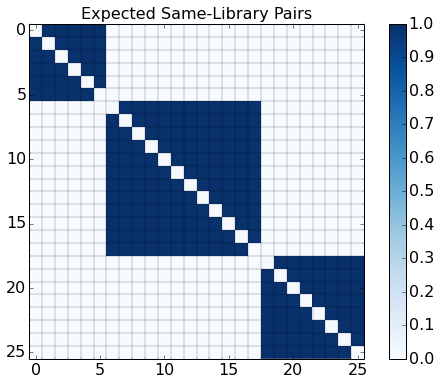

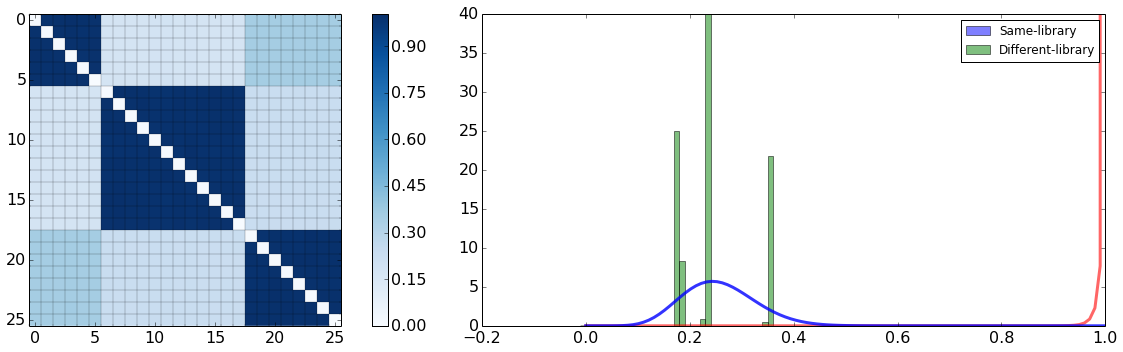

In [98]:
ten_libraries_distances = { \
#               "All Pairs Affinity" : "feb_test_ice_only_libraries.ap_affinity.csv", \
#               "NoF Exact Pairs Affinity" : "noF_test_agilent_only_libraries.cosine.csv", \
#               "OptNo Exact Pairs Affinity" : "optNo_test_agilent_only_libraries.cosine.csv", \
#               "Feb Exact Pairs Affinity" : "feb_test_agilent_only_libraries.cosine.csv", \

#               "Jaccard Similarity Index" : "feb_test_ice_only_libraries.jaccard.csv", \
#               "Cosine Similarity" : "optNo_test_ice_only_libraries.cosine.csv", \
#               "Random Pairs Affinity" : "test_10_exome_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "feb_test_two_sense_libraries.ten.csv", \
#               "Ten limited Affinity" : "test_10_exome_libraries.ten.csv", \
#               "Five limited Affinity" : "test_10_exome_libraries.five.csv", \
#               "Four limited Affinity" : "test_10_exome_libraries.four.csv", \
#               "Three limited Affinity" : "test_10_exome_libraries.three.csv", \
#               "Two limited Affinity" : "test_10_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "feb_test_two_sense_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
plt.tight_layout(False)


In [ ]:
metadata_files = [ "test_10_exome_libraries.read_groups.json", "test_agilent_libraries.read_groups.json", "test_agilent_ice_libraries.read_groups.json", "test_strand_agnostic_libraries.read_groups.json", "test_two_sense_libraries.read_groups.json", "test_rna_libraries.read_groups.json" ]
metadata_files = [ "test_agilent_libraries.read_groups.json", "test_agilent_ice_libraries.read_groups.json", ]

for metadata in metadata_files:
    print metadata
    meta = read_metadata(metadata)
    groups, libraries = get_groups_and_libraries(meta)
    print len(set(libraries))
    print len(groups)
    for library in sorted(set(libraries)): print library
    print sorted(set(libraries))
    print 


In [ ]:
datasets_overview = pd.read_csv("feb_datasets_for_display.csv")
datasets_overview.to_latex("feb_datasets_for_display.tex")

1
NO DISTRIBUTIONS
Training subset indices
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
Testing subset indices
[0 1 2 3 4 5]


/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


p(different-library | truly different-library)  \
All Pairs Affinity subset 1                                              NaN   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 1                                    1.0   

                              rand index  \
All Pairs Affinity subset 1          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 1                                                NaN        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 1                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 1                 1.0                         1   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 1                     1                     1   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 1                   0    ...          1.001529   

                             ratio clusters discovered  \
All Pairs Affinity subset 1                          1   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 1                                                NaN      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 1                                         0.0   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 1               0.0    2.220446e-16   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 1             1000              -1             -1   

                             threshold  
All Pairs Affinity subset 1   0.612921  

[1 rows x 36 columns]

2
NO DISTRIBUTIONS
Training subset indices
[ 0  1  2  3  4  5 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
Testing subset indices
[ 6  7  8  9 10]


p(different-library | truly different-library)  \
All Pairs Affinity subset 2                                              NaN   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 2                                    1.0   

                              rand index  \
All Pairs Affinity subset 2          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 2                                                NaN        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 2                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 2                 1.0                         1   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 2                     1                     1   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 2                   0    ...          1.004211   

                             ratio clusters discovered  \
All Pairs Affinity subset 2                          1   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 2                                                NaN      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 2                                         0.0   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 2               0.0             0.0   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 2             1000              -1             -1   

                             threshold  
All Pairs Affinity subset 2   0.674809  

[1 rows x 36 columns]

3
NO DISTRIBUTIONS
Training subset indices
[ 0  1  2  3  4  5  6  7  8  9 10 16 17 18 19 20 21 22 23 24 25]
Testing subset indices
[11 12 13 14 15]


p(different-library | truly different-library)  \
All Pairs Affinity subset 3                                              NaN   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 3                                    1.0   

                              rand index  \
All Pairs Affinity subset 3          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 3                                                NaN        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 3                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 3                 1.0                         1   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 3                     1                     1   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 3                   0    ...          1.000402   

                             ratio clusters discovered  \
All Pairs Affinity subset 3                          1   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 3                                                NaN      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 3                                         0.0   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 3               0.0             0.0   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 3             1000              -1             -1   

                             threshold  
All Pairs Affinity subset 3   0.674726  

[1 rows x 36 columns]

4
NO DISTRIBUTIONS
Training subset indices
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 21 22 23 24 25]
Testing subset indices
[16 17 18 19 20]


p(different-library | truly different-library)  \
All Pairs Affinity subset 4                                              1.0   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 4                                    1.0   

                              rand index  \
All Pairs Affinity subset 4          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 4                                                1.0        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 4                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 4                 1.0                         2   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 4                     1                     1   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 4                   0    ...          0.999627   

                             ratio clusters discovered  \
All Pairs Affinity subset 4                          1   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 4                                                1.0      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 4                                         0.0   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 4               0.6   -3.330669e-16   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 4             1000              -1             -1   

                             threshold  
All Pairs Affinity subset 4   0.673697  

[1 rows x 36 columns]

5
NO DISTRIBUTIONS
Training subset indices
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Testing subset indices
[21 22 23 24 25]


p(different-library | truly different-library)  \
All Pairs Affinity subset 5                                              NaN   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 5                                    1.0   

                              rand index  \
All Pairs Affinity subset 5          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 5                                                NaN        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 5                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 5                 1.0                         1   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 5                     1                     1   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 5                   0    ...          1.003091   

                             ratio clusters discovered  \
All Pairs Affinity subset 5                          1   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 5                                                NaN      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 5                                         0.0   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 5               0.0             0.0   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 5             1000              -1             -1   

                             threshold  
All Pairs Affinity subset 5   0.673483  

[1 rows x 36 columns]

KeyError: 'positive'

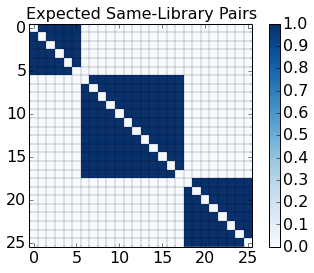

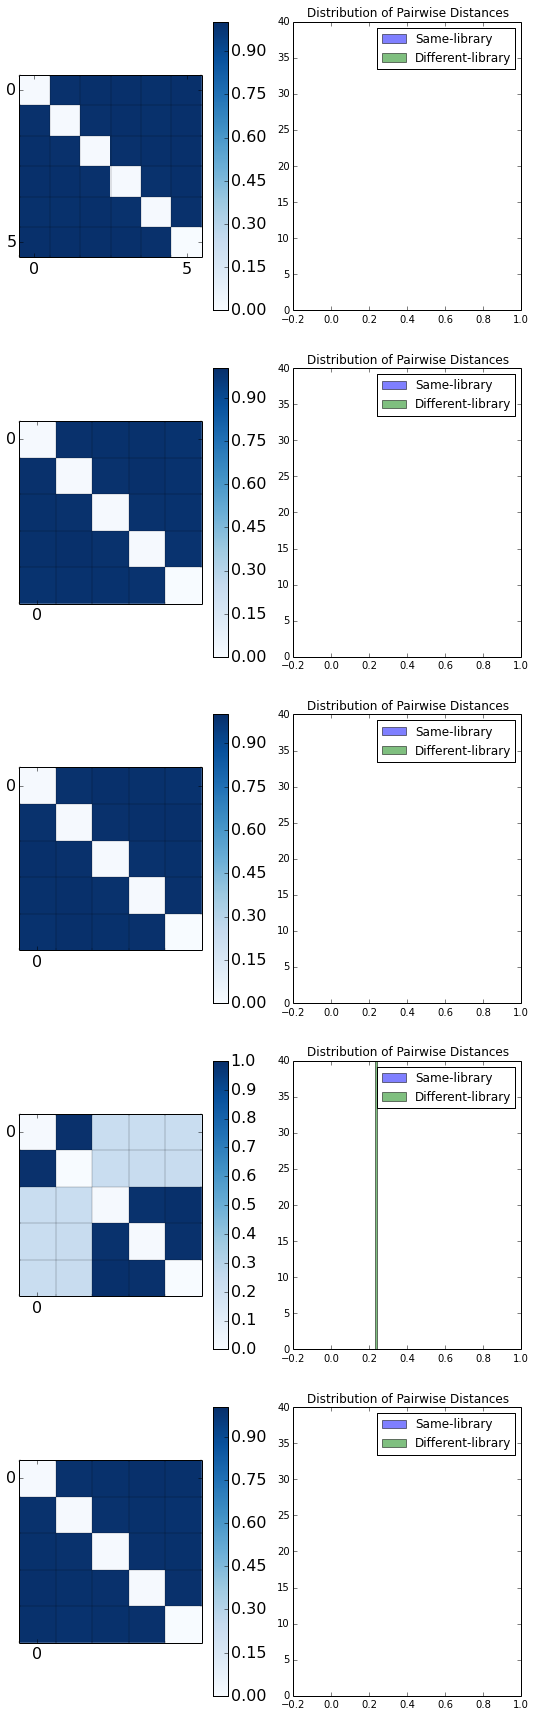

In [74]:
# Run experiment only on all-pairs affinity to test various threshold getters. Evaluate intermediates to see the process of building the threshold
ap_distance = pd.read_csv("feb_test_two_sense_libraries.ten.csv", header=[0,1], index_col=[0,1])
metadata_file = "feb_test_two_sense_libraries.read_groups.json"
meta = read_metadata(metadata_file)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)
plot_matrix(truth, title="Expected Same-Library Pairs")

fig = plt.figure(3, figsize=(45, 6*5))
i = 0

evaluation, false_calls = run_experiment(ap_distance, len(groups), "All Pairs Affinity", truth, min_max_mean, np.mean, True, fig, 5, 0)    
evaluation_criteria = evaluation
all_false_calls = false_calls
print "evaluation criteria"
display(evaluation_criteria.sort_index())
print "false calls"
display(all_false_calls)


0.229812242592
0.235611867653

0.990230707787
1.00426567638

0.229812242592
0.235611867653

0.990230707787
0.9999999


FitSolverError: Solver for the MLE equations failed to converge: The iteration is not making good progress, as measured by the   improvement from the last five Jacobian evaluations.

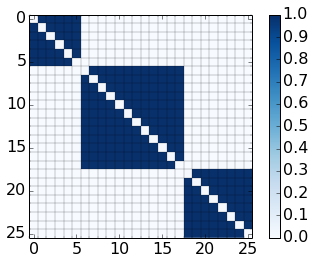

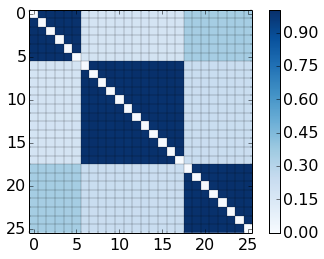

In [89]:
fig1= plt.figure(1)
ax1 = fig1.gca()
fig2=plt.figure(2)
ax2=fig2.gca()

plot_matrix(truth, ax=ax1)
plot_matrix(ap_distance, ax=ax2)

train = [6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
test = [0,1,2,3,4,5]

train_dists = ap_distance.iloc[train, train]

train_truth = truth.iloc[train, train]
test_truth = truth.iloc[test, test]

# plot_matrix(np.tril(train_dists.values, -2))
# plot_matrix(train_truth)

# display(train_dists)
# print np.min(np.tril(train_dists.values, -2))

# print train_truth.values.diagonal()

# plot_matrix((train_truth.values+1))


same_distances = train_dists.values[train_truth.values>0]

# print same_distances
diff_distances = train_dists.values[train_truth.values==0]

print np.min(diff_distances)
print np.max(diff_distances)
print
print np.min(same_distances)
print np.max(same_distances)
print

distance = train_dists.clip(10**-12, 1.0 - (10**-7)) # was (None, 0.999999999)
# distance = train_dists.clip(10**-12, 0.999999999) # was (None, 0.999999999)

#     faux_counts = []
    
# Fit a beta distribution to the true positives
#     true_positives=np.append(distance.values[truth.values>0], faux_counts)

true_positives=distance.values[train_truth.values>0]
true_negatives=(distance.values[train_truth.values==0] + 10**-27)

print np.min(true_negatives)
print np.max(true_negatives)
print
print np.min(true_positives)
print np.max(true_positives)


alphaT, betaT, locT, scaleT = beta.fit(true_positives, floc=0, fscale=1)
dPos = beta(alphaT, betaT, locT, scaleT) # "freeze" the distribution parameters as an object
pos_dist = {"alpha": alphaT, "beta": betaT, "dist": dPos}

# Fit a beta distribution to the true negatives
#     true_negatives=np.append(distance.values[truth.values==0] + 10**-27, faux_counts)
# alphaN, betaN, locN, scaleN = beta.fit(true_negatives, floc=0, fscale=1)
# dNeg = beta(alphaN, betaN, locN, scaleN)
# neg_dist = {"alpha": alphaN, "beta": betaN, "dist": dNeg}

print pos_dist
# print neg_dist




{'__doc__': 'A beta continuous random variable.\n\n    Continuous random variables are defined from a standard form and may\n    require some shape parameters to complete its specification.  Any\n    optional keyword parameters can be passed to the methods of the RV\n    object as given below:\n    \n    Methods\n    -------\n    rvs(a, b, loc=0, scale=1, size=1)\n        Random variates.\n    pdf(x, a, b, loc=0, scale=1)\n        Probability density function.\n    logpdf(x, a, b, loc=0, scale=1)\n        Log of the probability density function.\n    cdf(x, a, b, loc=0, scale=1)\n        Cumulative density function.\n    logcdf(x, a, b, loc=0, scale=1)\n        Log of the cumulative density function.\n    sf(x, a, b, loc=0, scale=1)\n        Survival function (1-cdf --- sometimes more accurate).\n    logsf(x, a, b, loc=0, scale=1)\n        Log of the survival function.\n    ppf(q, a, b, loc=0, scale=1)\n        Percent point function (inverse of cdf --- percentiles).\n    isf(q, a, b, 

In [35]:
print 1.0 - (10**-12)
print 1.0 - (10**-11)
print 1.0 - (10**-10)
print 1.0 - (10**-9)
print 0.999999999

0.999999999999
0.99999999999
0.9999999999
0.999999999
0.999999999


In [ ]:
{'alpha': 381.41092110594451, 'beta': 0.11018549364631501, 'dist': <scipy.stats.distributions.rv_frozen object at 0x114c4ea50>}
{'alpha': 1111.4517659879023, 'beta': 99.236791795497837, 'dist': <scipy.stats.distributions.rv_frozen object at 0x114e646d0>}

In [ ]:
# Run experiment only on all-pairs affinity to test various threshold getters. Evaluate intermediates to see the process of building the threshold
ap_distance = pd.read_csv("noF_test_two_sense_libraries.ap_affinity.csv", header=[0,1], index_col=[0,1])
metadata_file = "noF_test_two_sense_libraries.read_groups.json"
meta = read_metadata(metadata_file)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)
plot_matrix(truth, title="Expected Same-Library Pairs")

fig = plt.figure(3, figsize=(45, 6*5))
i = 0

evaluation, false_calls = run_experiment(ap_distance, len(groups), "Unlimited Affinity", truth, min_max_mean, np.mean, True, fig, 5, 0)    
evaluation_criteria = evaluation
all_false_calls = false_calls
print "evaluation criteria"
display(evaluation_criteria.sort_index())
print "false calls"
display(all_false_calls)


In [ ]:
ap_distance = pd.read_csv("noF_test_two_sense_libraries.ap_affinity.csv", header=[0,1], index_col=[0,1])
metadata_file = "noF_test_two_sense_libraries.read_groups.json"
meta = read_metadata(metadata_file)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)
plot_matrix(truth, title="Expected Same-Library Pairs")

In [ ]:
fig = plt.figure(1)
# plt.set_tight_layout(False)
ax = plt.gca()

def plot_farp(matrix, title='Matrix', vmax=None, ax=None):
#     matrix = matrix[:21,:21]
    
#     print matrix
    
    if ax is None:
        ax = plt.gca()
    n, m = matrix.shape
    
    print n
    print m
    
    x = np.arange(n)
    y = np.arange(n)
    X, Y = np.meshgrid(x, y)
    
#     print X
#     print Y
    
#     colors = ax.pcolor(X, Y, matrix, edgecolor='k', cmap = plt.cm.Blues, vmin=0, vmax=vmax)
#     colors = ax.pcolor(matrix, edgecolor='k', cmap = plt.cm.Blues, vmin=0, vmax=vmax)

    colors = ax.imshow(matrix, cmap=plt.cm.Blues, vmin=0, vmax=vmax,
           extent=[0, n, 0, m],
           interpolation='none', origin='lower')

    cb = plt.colorbar(colors, ax=ax)
    ax.set_xticks(np.arange(0,n,5) + 0.5)
    ax.set_yticks(np.arange(0,m,5) + 0.5)
    ax.set_xticklabels(np.arange(0,n,5))
    ax.set_yticklabels(np.arange(0,m,5))
    
    # Minor ticks
    ax.set_xticks(np.arange(n), minor=True)
    ax.set_yticks(np.arange(m), minor=True)
    
    font_size=14
    ax.tick_params(which='minor', colors='k', width=0.2)
    ax.tick_params(which='major', labelsize=font_size)
    cb.ax.tick_params(labelsize=font_size)


    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.2)
#     ax.set_title(title)
    ax.invert_yaxis()
    
    

plot_farp(truth.values, title="Expected Same-Library Pairs", ax=ax)

In [ ]:
fig = plt.figure(1)
# fig.set_tight_layout(True)
ax = plt.gca()

def plot_farp(matrix, title='Matrix', vmax=None, ax=None):
    if ax is None:
        ax = plt.gca()
    n, m = matrix.shape
    
    x = np.arange(n)
    y = np.arange(n)
    
    colors = plt.imshow(matrix, cmap=plt.cm.Blues, vmin=0, vmax=vmax,
           extent=[0, n, 0, m],
           interpolation='none', origin='lower')

    plt.colorbar(colors, ax=ax)
    ax.set_xticks(x+0.5)
    ax.set_yticks(y+0.5)
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)
    
    # Minor ticks
    ax.set_xticks(x, minor=True)
    ax.set_yticks(y, minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.2)
    ax.set_title(title)
    ax.invert_yaxis()
    
    

plot_farp(truth.values, title="Expected Same-Library Pairs", ax=ax)

In [ ]:
# Here I am farping around with diffusion distances. Not going well so far
ap_distance = pd.read_csv("test_10_exome_libraries.ep_affinity.csv", header=[0,1], index_col=[0,1])
metadata_file = "test_10_exome_libraries.read_groups.json"
meta = read_metadata(metadata_file)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)

In [ ]:
tfig = plt.figure(1, figsize=(6, 6))
plot_matrix(truth, title="Expected Same-Library Pairs", ax=tfig.gca())

In [ ]:
plot_matrix(adjust_LLRs(LLR_matrix))

In [ ]:

# train = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
#  25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
#  50, 51, 52, 53, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
# test = [54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]

# train = [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
#  40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
#  65 66 67 68 69 70 71 72 73]
# test = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]
# {'positive': {'alpha': 4.7252326446152013, 'beta': 7.047736189059969, 'dist': <scipy.stats.distributions.rv_frozen object at 0x1125e9650>}, 'negative': {'alpha': 19.467082238545974, 'beta': 1363.5352656628584, 'dist': <scipy.stats.distributions.rv_frozen object at 0x1125e98d0>}}

test = [54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,]
distributions = {'positive': {'alpha': 4.7252326446152013, 'beta': 7.047736189059969}, 'negative': {'alpha': 19.467082238545974, 'beta': 1363.5352656628584}}


# print train

# distributions = {'positive': {'alpha': 4.7252326446152013, 'beta': 7.047736189059969}, 'negative': {'alpha': 19.467082238545974, 'beta': 1363.5352656628584}}
# distributions = {'positive': {'alpha': 16.521529789114986, 'beta': 0.10217402121593845}, 'negative': {'alpha': 0.60979088920943336, 'beta': 0.29894539365504158}}
# distributions = {'positive': {'alpha': 26.538288437064899, 'beta': 0.99527335276294793}, 'negative': {'alpha': 0.79561260296184988, 'beta': 27.695977536397333}}

x = ap_distance.iloc[57,56]

print x

# Likelihood ratio test.
# print "foop"
# print (10**-16)
a = 1.0 - (10**-12)
if x > 1: x = a#0.9999999999999999
if x == 0: x=10**-12
dPos = distributions['positive']
dNeg = distributions['negative']
LLalt = beta.logpdf(x, dPos['alpha'], dPos['beta'], 0, 1) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
LLnull = beta.logpdf(x, dNeg['alpha'], dNeg['beta'], 0, 1) # log likelihood that our 'different-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
n_pdf = beta.pdf(x, dNeg['alpha'], dNeg['beta'], 0, 1)
# print "npdf ", n_pdf
# print np.log(n_pdf)
# print np.log10(n_pdf)
# print beta.logpdf(x, dNeg['alpha'], dNeg['beta'], 0, 1)

# LLnull = np.log(beta.pdf(x, dNeg['alpha'], dNeg['beta'], 0, 1)) # log likelihood that our 'different-library' distribution is the best model
LLratio = LLalt - LLnull

print "yepp"
print x
print LLalt
print np.isfinite(LLalt)
print LLnull
print LLratio

print 'ar'
if x >= 1.0: x = 1.0 - (10**-12) # smallest value that does not cause infinities in pdf
if x == 0: x=10**-12
dPos = distributions['positive']
dNeg = distributions['negative']
Lalt = beta.pdf(x, dPos['alpha'], dPos['beta'], 0, 1) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
Lnull = beta.pdf(x, dNeg['alpha'], dNeg['beta'], 0, 1) # log likelihood that our 'different-library' distribution is the best
Lratio = Lalt / Lnull
print Lratio
# BATG
print Lalt
print Lnull

# np.exp(-884.086202824)
# np.exp(-10)

print Lalt / (10**-300)

In [ ]:
Jaccard Similarity Index    0.804271
Name:  p(different-library | truly different-library), dtype: float64
Jaccard Similarity Index    0.893103
Name:  p(same-library | truly same-library), dtype: float64
Jaccard Similarity Index    0.81557
Name:  rand index, dtype: float64
Jaccard Similarity Index    0.998492
Name: Cluster p(different-library | truly different-library), dtype: float64
Jaccard Similarity Index    1.0
Name: Cluster p(same-library | truly same-library), dtype: float64
Jaccard Similarity Index    0.998684
Name: Cluster rand index, dtype: float64
Jaccard Similarity Index    8
Name: Dist Clusters discovered, dtype: int64
Jaccard Similarity Index    1.0
Name: Expected False-Diffs, dtype: float64
Jaccard Similarity Index    0.0
Name: Expected False-Sames, dtype: float64
Jaccard Similarity Index    0.768805
Name: Hellinger Distance, dtype: float64
Jaccard Similarity Index    0.577889
Name: LLR Cluster p(different-library | truly different-library), dtype: float64
Jaccard Similarity Index    1.0
Name: LLR Cluster p(same-library | truly same-library), dtype: float64
Jaccard Similarity Index    0.631579
Name: LLR Cluster rand index, dtype: float64
Jaccard Similarity Index    2
Name: LLR Clusters discovered, dtype: int64
Jaccard Similarity Index    0.800754
Name: LLR p(different-library | truly different-library), dtype: float64
Jaccard Similarity Index    0.917241
Name: LLR p(same-library | truly same-library), dtype: float64
Jaccard Similarity Index    0.81557
Name: LLR rand index, dtype: float64
Jaccard Similarity Index    0.266972
Name: LLR_part_mod, dtype: float64
Jaccard Similarity Index   -0.393519
Name: LLR_threshold, dtype: float64
Jaccard Similarity Index    0.577889
Name: Ratio Cluster p(different-library | truly different-library), dtype: float64
Jaccard Similarity Index    1.0
Name: Ratio Cluster p(same-library | truly same-library), dtype: float64
Jaccard Similarity Index    0.631579
Name: Ratio Cluster rand index, dtype: float64
Jaccard Similarity Index    0.253455
Name: diff-lib alpha, dtype: float64
Jaccard Similarity Index    81.045074
Name: diff-lib beta, dtype: float64
Jaccard Similarity Index    0.559428
Name: dist_part_mod, dtype: float64
Jaccard Similarity Index    0.558989
Name: expected_part_mod, dtype: float64
Jaccard Similarity Index    0.308838
Name: max_distance, dtype: float64
Jaccard Similarity Index    9
Name: ratio clusters discovered, dtype: int64
Jaccard Similarity Index    0.89598
Name: ratio p(different-library | truly different-library), dtype: float64
Jaccard Similarity Index    0.796552
Name: ratio p(same-library | truly same-library), dtype: float64
Jaccard Similarity Index    0.883333
Name: ratio rand index, dtype: float64
Jaccard Similarity Index    0.769668
Name: ratio_part_mod, dtype: float64
Jaccard Similarity Index    0.993296
Name: ratio_threshold, dtype: float64
Jaccard Similarity Index    1.666352
Name: same-lib alpha, dtype: float64
Jaccard Similarity Index    37.61557
Name: same-lib beta, dtype: float64
Jaccard Similarity Index    0.007793
Name: threshold, dtype: float64

In [ ]:
calculate_log_likelihoods_ratio(0.007793, distributions)

In [ ]:
# distributions = {'positive': {'alpha': 4.7252326446152013, 'beta': 7.047736189059969}, 'negative': {'alpha': 19.467082238545974, 'beta': 1363.5352656628584}}
distributions = {'positive': {'alpha': 1.666352, 'beta': 37.61557}, 'negative': {'alpha': 0.253455, 'beta': 81.045074}}
LLR_threshold = -0.393519

dPos = distributions['positive']
dNeg = distributions['negative']
def posPDF(x):
    return beta.pdf(x, dPos['alpha'], dPos['beta'], 0, 1)

def negPDF(x):
    return beta.pdf(x, dNeg['alpha'], dNeg['beta'], 0, 1)

def minPDFs(x):
    return min(posPDF(x), negPDF(x))

def sqrtProdPDFs(x):
    return np.sqrt(posPDF(x) * negPDF(x))


import scipy.integrate as integrate
from scipy.special import beta as farp

posIntegral = integrate.quad(posPDF, 0, 1)
negIntegral = integrate.quad(negPDF, 0, 1)
ovl = integrate.quad(minPDFs, 0, 1)
bhatta = integrate.quad(sqrtProdPDFs, 0, 1)

h2_direct = 1-bhatta[0]

a1 = dPos['alpha']
b1 = dPos['beta']

a2 = dNeg['alpha']
b2 = dNeg['beta']

def hellinger(distributions):
    dPos = distributions['positive']
    dNeg = distributions['negative']
    a1 = dPos['alpha']
    b1 = dPos['beta']

    a2 = dNeg['alpha']
    b2 = dNeg['beta']
    h2 = 1 - ((farp(np.mean([a1, a2]), np.mean([b1, b2]))) / np.sqrt(farp(a1, b1) * farp(a2, b2)))
    return np.sqrt(h2)

# def expectedTruePosNeg(distributions, threshold):
#     dPos = distributions['positive']['dist']
#     dNeg = distributions['negative']['dist']
    
#     expectedFalseSames = dPos.cdf(x)
#     expectedFalseDiffs = dNeg.sf(x)
#     return (expectedFalseSames, expectedFalseDiffs)
#     a1 = dPos['alpha']
#     b1 = dPos['beta']

#     a2 = dNeg['alpha']
#     b2 = dNeg['beta']
#     h2 = 1 - ((farp(np.mean([a1, a2]), np.mean([b1, b2]))) / np.sqrt(farp(a1, b1) * farp(a2, b2)))
#     return np.sqrt(h2)


print posIntegral
print negIntegral
print ovl
print 1-ovl[0]
print
print bhatta
print h2_direct
print h2_wiki
print np.sqrt(h2_direct)
print np.sqrt(h2_wiki)
print hellinger(distributions)

samesies = beta(a1, b1, 0, 1)
diffsies = beta(a2, b2, 0, 1)

distributions["positive"]["dist"] = samesies
distributions["negative"]["dist"] = diffsies



print
print expectedFalsePosNeg(distributions, LLR_threshold)

In [ ]:
def guess_LLR_threshold_distance(x, distributions, LLR_threshold):
    guess_LLR = calculate_log_likelihoods_ratio(x, distributions)
    return np.abs(LLR_threshold - guess_LLR)


guess_LLR_threshold_distance(0.0067, distributions, LLR_threshold)



from scipy.optimize import minimize_scalar

calc_x = minimize_scalar(guess_LLR_threshold_distance, method='bounded', args=(distributions, LLR_threshold), bounds=[0,1])


print calc_x
print calc_x['x']
print calculate_log_likelihoods_ratio(calc_x['x'], distributions)
print LLR_threshold


def find_LLR_threshold_distance(distributions, LLR_threshold):
    calc_x = minimize_scalar(guess_LLR_threshold_distance, method='bounded', args=(distributions, LLR_threshold), bounds=[0,1])
    return calc_x['x']

inferred_x = find_LLR_threshold_distance(distributions, LLR_threshold)
expectedFalsePosNeg(distributions, inferred_x)




In [ ]:

import scipy
scipy.__version__

In [ ]:
if ax is None:
        ax = plt.gca()
same_distances = farp.values[truth>0]
diff_distances = farp.values[truth==0]

# Plot histogram barchars for same-library and different-library distances
my_bins=np.arange(-0.01,1,.01)
ax.hist(farp, normed=True, bins=my_bins, alpha=0.5, label='Same-library')
# ax.hist(diff_distances, normed=True, bins=my_bins, alpha=0.5, label='Different-library')
ax.set_ylim([0, 40])
ax.legend(loc='upper right')
ax.set_title('Distribution of Pairwise Distances')

plt.show()

In [ ]:
samples=["P_IN_DI7481_T1", \
"P_IN_DI7481_N1", \
"NDB_IN_LE8155_T1", \
"NDB_IN_LE8155_N1", \
"DCB_IN_MA6119_T1", \
"DCB_IN_MA6119_N1", \
"NDB_IN_GU4093_T1", \
"NDB_IN_GU4093_N1", \
"NDB_IN_KU9696_T1", \
"NDB_IN_KU9696_N1", \
"DCB_IN_KA7540_T2", \
"DCB_IN_KA7540_N1", \
"NDB_IN_SI2896_T1", \
"NDB_IN_SI2896_N1", \
"NDB_IN_GO8303_T1", \
"NDB_IN_GO8303_N1" \
        ]

# NB: Thresholds taken from the 'combined' run
distance_metrics = {"All Pairs Affinity" : { "suffix": ".ap_affinity.csv", "threshold": 0.100282}, \
              "Exact Pairs Affinity" : { "suffix": ".ep_affinity.csv", "threshold": 0.002503}, \
              "Jaccard Similarity Index" : { "suffix": ".jaccard.csv", "threshold": 0.002758}, \
              "Cosine Similarity" : { "suffix": ".cosine.csv", "threshold": 0.008481}, \
              "Random Pairs Affinity" : { "suffix": ".random.csv", "threshold": 0.003390}
                    }

for sample in samples:
    j = 0
    display(HTML("<h3>Evaluating sample: </h3>" + sample))
    metadata_file = sample + ".bam.read_groups.json"
    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
#     plot_matrix(truth, title="Expected Same-Library Pairs")
    distributions={}
    
    fig = plt.figure(figsize=(45, 6*len(distance_metrics)))
    j+=1
    
    i = 0
    for label, value in distance_metrics.iteritems():
        i += 1
        distance_file = sample + value["suffix"]
        distance = pd.read_csv(distance_file, header=[0,1], index_col=[0,1])
        thresholds = [value["threshold"]]
        print distance_file, thresholds
        evaluation, false_calls = evaluate(distance, sample+label, distributions, truth, thresholds, np.mean, len(groups), fig, len(distance_metrics), i)
        if i == 1:
            evaluation_criteria = evaluation
            all_false_calls = false_calls
        else:
            evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
            if false_calls is not None:
                if all_false_calls is None:
                    all_false_calls = false_calls
                else:
                    all_false_calls = all_false_calls.append(false_calls)
    print "evaluation criteria"
    display(evaluation_criteria.sort_index())
    print "false calls"
    display(all_false_calls)

In [ ]:
def add_cosine_plot(thing):
    t2 = np.arange(0.0, 5.0, 0.02)
    thing.plot(t2, np.cos(2*np.pi*t2), 'r--')

def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

def add_weird_stuff(other):
    t1 = np.arange(0.0, 5.0, 0.1)
    t2 = np.arange(0.0, 5.0, 0.02)
    other.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

fig1 = plt.figure(2, figsize=(10, 6))
sub11 = fig1.add_subplot(3,1,1)
add_weird_stuff(sub11)

sub12 = fig1.add_subplot(312)
add_cosine_plot(sub12)

fig2 = plt.figure(1, figsize=(10, 6))
sub21 = fig2.add_subplot(3,1,1)
add_weird_stuff(sub21)

sub22 = fig2.add_subplot(312)
add_weird_stuff(sub22)



print("LOOOOOL")
plt.show()

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
#               "All Pairs Affinity" : "test_exome_libraries.ap_affinity.csv", \
#               "Exact Pairs Affinity" : "test_exome_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_exome_libraries.jaccard.csv", \
#               "Cosine Similarity" : "test_exome_libraries.cosine.csv", \
#               "Random Pairs Affinity" : "test_exome_libraries.random.csv" , \
#               "Unlimited Pairs Affinity" : "test_exome_libraries.unlimited.csv", \
#               "Ten limited Affinity" : "test_exome_libraries.ten.csv", \
#               "Five limited Affinity" : "test_exome_libraries.five.csv", \
#               "Four limited Affinity" : "test_exome_libraries.four.csv", \
#               "Three limited Affinity" : "test_exome_libraries.three.csv", \
#               "Two limited Affinity" : "test_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "test_exome_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_weird_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_weird_libraries.ep_affinity.csv", \
#               "Jaccard Similarity Index" : "test_weird_libraries.jaccard.csv", \
#               "Cosine Similarity" : "test_weird_libraries.cosine.csv", \
#               "Random Pairs Affinity" : "test_weird_libraries.random.csv" , \
#               "Unlimited Pairs Affinity" : "test_weird_libraries.unlimited.csv", \
#               "Ten limited Affinity" : "test_weird_libraries.ten.csv", \
#               "Five limited Affinity" : "test_weird_libraries.five.csv", \
#               "Four limited Affinity" : "test_weird_libraries.four.csv", \
#               "Three limited Affinity" : "test_weird_libraries.three.csv", \
#               "Two limitedr Affinity" : "test_weird_libraries.two.csv" \
             }

ten_libraries_metadata = "test_weird_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_agilent_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_agilent_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_agilent_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_agilent_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_agilent_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_agilent_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_agilent_libraries.ten.csv", \
              "Five limited Affinity" : "test_agilent_libraries.five.csv", \
              "Four limited Affinity" : "test_agilent_libraries.four.csv", \
              "Three limited Affinity" : "test_agilent_libraries.three.csv", \
              "Two limited Affinity" : "test_agilent_libraries.two.csv" \
             }

ten_libraries_metadata = "test_agilent_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_pcr_free_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_pcr_free_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_pcr_free_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_pcr_free_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_pcr_free_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_pcr_free_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_pcr_free_libraries.ten.csv", \
              "Five limited Affinity" : "test_pcr_free_libraries.five.csv", \
              "Four limited Affinity" : "test_pcr_free_libraries.four.csv", \
              "Three limited Affinity" : "test_pcr_free_libraries.three.csv", \
              "Two limited Affinity" : "test_pcr_free_libraries.two.csv" \
             }

ten_libraries_metadata = "test_pcr_free_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
#               "All Pairs Affinity" : "test_pcr_plus_libraries.ap_affinity.csv", \
#               "Exact Pairs Affinity" : "test_pcr_plus_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_pcr_plus_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_pcr_plus_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_pcr_plus_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_pcr_plus_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_pcr_plus_libraries.ten.csv", \
              "Five limited Affinity" : "test_pcr_plus_libraries.five.csv", \
              "Four limited Affinity" : "test_pcr_plus_libraries.four.csv", \
              "Three limited Affinity" : "test_pcr_plus_libraries.three.csv", \
              "Two limited Affinity" : "test_pcr_plus_libraries.two.csv" \
             }

ten_libraries_metadata = "test_pcr_plus_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_genomes_new_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_genomes_new_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_genomes_new_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_genomes_new_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_genomes_new_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_genomes_new_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_genomes_new_libraries.ten.csv", \
              "Five limited Affinity" : "test_genomes_new_libraries.five.csv", \
              "Four limited Affinity" : "test_genomes_new_libraries.four.csv", \
              "Three limited Affinity" : "test_genomes_new_libraries.three.csv", \
              "Two limited Affinity" : "test_genomes_new_libraries.two.csv" \
             }

ten_libraries_metadata = "test_genomes_new_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_rna_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_rna_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_rna_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_rna_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_rna_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_rna_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_rna_libraries.ten.csv", \
              "Five limited Affinity" : "test_rna_libraries.five.csv", \
              "Four limited Affinity" : "test_rna_libraries.four.csv", \
              "Three limited Affinity" : "test_rna_libraries.three.csv", \
              "Two limited Affinity" : "test_rna_libraries.two.csv" \
             }

ten_libraries_metadata = "test_rna_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
data_types = ["10_exome", "rna", "agilent", "agilent_ice","exome", "pcr_free", "pcr_plus"] # Omit genomes_new, combined due to inclusion of PCR-free
labels = []
metrics = {}
for j in xrange(len(data_types)):
    data = data_types[j]
    print "evaluating {}".format(data)
    distance_files = { \
              "All Pairs Affinity" : "test_{}_libraries.ap_affinity.csv".format(data), \
              "Exact Pairs Affinity" : "test_{}_libraries.ep_affinity.csv".format(data), \
              "Jaccard Similarity Index" : "test_{}_libraries.jaccard.csv".format(data), \
              "Cosine Similarity" : "test_{}_libraries.cosine.csv".format(data), \
              "Random Pairs Affinity" : "test_{}_libraries.random.csv".format(data), \
              "Unlimited Pairs Affinity" : "test_{}_libraries.unlimited.csv".format(data), \
              "Ten limited Affinity" : "test_{}_libraries.ten.csv".format(data), \
              "Five limited Affinity" : "test_{}_libraries.five.csv".format(data), \
              "Four limited Affinity" : "test_{}_libraries.four.csv".format(data), \
              "Three limited Affinity" : "test_{}_libraries.three.csv".format(data), \
              "Two limited Affinity" : "test_{}_libraries.two.csv".format(data) \
             }
    metadata_file = "test_{}_libraries.read_groups.json".format(data)

    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
#     plot_matrix(truth, title="Expected Same-Library Pairs")
    
#     fig = plt.figure(2, figsize=(45, 6*len(distance_files)))
    i = 0
    evaluation_criteria = None
    for test_label, test_file in distance_files.iteritems():
        i += 1
        print "evaluating {}".format(test_label)
        distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
        evaluation, false_calls = run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False, None, len(distance_files), i)
        if i == 1:
            evaluation_criteria = evaluation
            all_false_calls = false_calls
        else:
            evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
            if false_calls is not None:
                if all_false_calls is None:
                    all_false_calls = false_calls
                else:
                    all_false_calls = all_false_calls.append(false_calls)
    
    # Gather up some of the metrics sliced from our broader evaluation criteria
    per_type_metrics = { \
        "LLR_rand_index" : evaluation_criteria["LLR rand index"], \
        "LLR_sensitivity" : evaluation_criteria["LLR p(same-library | truly same-library)"], \
        "LLR_specificity" : evaluation_criteria["LLR p(different-library | truly different-library)"], \
        "Cluster_rand_index" : evaluation_criteria["Cluster rand index"], \
        "Cluster_sensitivity" : evaluation_criteria["Cluster p(same-library | truly same-library)"], \
        "Cluster_specificity" : evaluation_criteria["Cluster p(different-library | truly different-library)"], \
        "LLR_cluster_rand_index" : evaluation_criteria["LLR Cluster rand index"], \
        "LLR_cluster_sensitivity" : evaluation_criteria["LLR Cluster p(same-library | truly same-library)"], \
        "LLR_cluster_specificity" : evaluation_criteria["LLR Cluster p(different-library | truly different-library)"], \
        "ratio_rand_index" : evaluation_criteria["ratio rand index"], \
        "ratio_sensitivity" : evaluation_criteria["ratio p(same-library | truly same-library)"], \
        "ratio_specificity" : evaluation_criteria["ratio p(different-library | truly different-library)"], \
        "ratio_cluster_rand_index" : evaluation_criteria["Ratio Cluster rand index"], \
        "ratio_cluster_sensitivity" : evaluation_criteria["Ratio Cluster p(same-library | truly same-library)"], \
        "ratio_cluster_specificity" : evaluation_criteria["Ratio Cluster p(different-library | truly different-library)"] \
    }
    
    
    if j == 0:
        labels = [data]
        
        # wrap each metric in a dataframe and keep hold of it as the nucleus for our growing list
        for key, value in per_type_metrics.iteritems():
            metrics[key] = pd.DataFrame(value)
        
    else:
        labels.append(data)
        
        # concatenate the new data-types metrics to our existing ones.
        for key, value in metrics.iteritems():
            metrics[key] = pd.concat([metrics[key], per_type_metrics[key]], axis=1)
        
#         LLR_rand_index = pd.concat([LLR_rand_index, LLR_rand], axis=1)
#         LLR_sensitivity = pd.concat([LLR_sensitivity, LLR_sens], axis=1)
#         LLR_specificity = pd.concat([LLR_specificity, LLR_spec], axis=1)
        
#         Cluster_rand_index = pd.concat([Cluster_rand_index, Cluster_rand], axis=1)
#         Cluster_sensitivity = pd.concat([Cluster_sensitivity, Cluster_sens], axis=1)
#         Cluster_specificity = pd.concat([Cluster_specificity, Cluster_spec], axis=1)
        
#     LLR_rand_index.columns=labels
#     LLR_sensitivity.columns=labels
#     LLR_specificity.columns=labels
    
#     Cluster_rand_index.columns=labels
#     Cluster_sensitivity.columns=labels
#     Cluster_specificity.columns=labels
    
    # update the labels and do a diagnostic print
    for key, value in metrics.iteritems():
        metrics[key].columns=labels    
        print key
        display(metrics[key])
    
    
#     display(LLR_sensitivity)
#     display(LLR_specificity)
    
#     display(Cluster_rand_index)
#     display(Cluster_sensitivity)
#     display(Cluster_specificity)

    

In [ ]:
for key, value in metrics.iteritems():
    metrics[key] = metrics[key].sort_index()

# LLR_rand_index=LLR_rand_index.sort_index()
# LLR_sensitivity=LLR_sensitivity.sort_index()
# LLR_specificity=LLR_specificity.sort_index()
    
# Cluster_rand_index=Cluster_rand_index.sort_index()
# Cluster_sensitivity=Cluster_sensitivity.sort_index()
# Cluster_specificity=Cluster_specificity.sort_index()

In [ ]:
for key, value in metrics.iteritems():
    print key
    display(metrics[key])

In [ ]:
for key, value in metrics.iteritems():
    file_name = key + ".csv"
    matrix = metrics[key]
    matrix.to_csv(file_name)
    

In [134]:
import matplotlib.patches as mpatches
import matplotlib.markers as mk
import matplotlib.colors as mcl

def plot_scatter(x_df, y_df, x_label, y_label, title=None, ax=None, draw_line=False, display_legend=False, draw_nineties=False):
    al = 0.5
    marker_size = 75
    
    if x_df.shape != y_df.shape:
        raise AssertionError("Attempting to create scatterplot from two dataframes with different shape")
    
    if ax is None:
        ax = plt.gca()
    
    rows = range(len(x_df.index))
    for i in xrange(len(x_df.columns)):
        dataset_key = x_df.columns[i]
        ax.scatter(x=x_df[dataset_key], y=y_df[dataset_key], c=rows, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', label=dataset_key, alpha=al)
    
    if draw_line:
        ax.plot([0,1.1], [0,1.1], c='k')
        
    if draw_nineties:
        ax.plot([0.9,0.9], [0, 1.1], c='k', linestyle='--')
        ax.plot([0, 1.1], [0.9,0.9], c='k', linestyle='--')

        
    ax.set_ylim(ymin=0, ymax=1.01)
    ax.set_xlim(xmin=0, xmax=1.01)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if title is not None:
        ax.set_title(title)
    
    if display_legend:
        # Set up an extra set of handles/labels within the legend, for the color key
        cmap = plt.cm.get_cmap()
        norm = mcl.Normalize(vmin=0,vmax=rows[-1])
        patches = []
        for i in rows:
            patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
        handles, labels = ax.get_legend_handles_labels()
        new_handle = [handle for i,handle in enumerate(handles)]+patches
        new_label = [label for i,label in enumerate(labels)]+[dist for dist in x_df.index]

        # display the legend
#         ax.legend(new_handle, new_label, loc=3)
        ax.legend(new_handle, new_label, ncol=2, bbox_to_anchor=(4.3,1.01))


    


In [ ]:
fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["LLR_sensitivity"], "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True)
plot_scatter(metrics["Cluster_specificity"], metrics["Cluster_sensitivity"], "Specificity", "Sensitivity", "Distance Clustering Performance by Dataset", ax=plot2)
plot_scatter(metrics["ratio_cluster_specificity"], metrics["ratio_cluster_sensitivity"], "Specificity", "Sensitivity", "Ratio Clustering Performance by Dataset", ax=plot3)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["Cluster_specificity"], "Pairwise Specificity", "Clustering Specificity", "Pairwise vs Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_specificity"], metrics["ratio_cluster_specificity"], "Pairwise Specificity", "Ratio Clustering Specificity", "Pairwise vs Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_specificity"], metrics["ratio_cluster_specificity"], "Clustering Specificity", "Ratio Clustering Specificity", "Clustering vs Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "LLR Pairwise Sensitivity", "Clustering Sensitivity", "LLR Pairwise vs Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_sensitivity"], metrics["ratio_cluster_sensitivity"], "LLR Pairwise Sensitivity", "Ratio Clustering Sensitivity", "LLR Pairwise vs Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_sensitivity"], metrics["ratio_cluster_sensitivity"], "Cluster Sensitivity", "Ratio Clustering Sensitivity", "Clustering vs Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [ ]:
distance = u'Exact Pairs Affinity'

Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T

Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T


fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True, draw_nineties=True)
plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Similarity Clustering Performance by Dataset", ax=plot2, draw_nineties=True)
plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Likelihood Ratio Clustering Performance by Dataset", ax=plot3, draw_nineties=True)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(Lsp, Csp, "LLR Pairwise Specificity", "Similarity Clustering Specificity", "LLR Pairwise vs Similarity Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=False)
plot_scatter(Lsp, LCsp, "LLR Pairwise Specificity", "Likelihood Ratio Clustering Specificity", "LLR Pairwise vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(Csp, LCsp, "Similarity Clustering Specificity", "Likelihood Ratio Clustering Specificity", "Similarity Clustering vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(Lse, Cse, "LLR Pairwise Sensitivity", "Similarity Clustering Sensitivity", "LLR Pairwise vs Similarity Score Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=False)
plot_scatter(Lse, LCse, "LLR Pairwise Sensitivity", "Likelihood Ratio Clustering Sensitivity", "LLR Pairwise vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(Cse, LCse, "Similarity Clustering Sensitivity", "Likelihood Ratio Clustering Sensitivity", "Similarity Clustering vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [ ]:
plot_scatter(pd.DataFrame(LLR_specificity["10_exome"]), pd.DataFrame(LLR_sensitivity["10_exome"]), "Specificity", "Sensitivity", "'Distance Pairwise Performance 10 Exome", ax=None, display_legend=True)

# pd.DataFrame(LLR_specificity["10_exome"])

In [ ]:
plot_scatter(pd.DataFrame(Cluster_specificity["10_exome"]), pd.DataFrame(Cluster_sensitivity["10_exome"]), "Specificity", "Sensitivity", "'Distance Clustering Performance 10 Exome", ax=None, display_legend=True)


In [ ]:
distances = metrics["LLR_specificity"].index
print len(metrics)
print len(distances)
n_distances = len(distances)
fig = plt.figure(figsize=(24, 6*n_distances))
for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
    distance = distances[i]
    Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
    Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T
    
    Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
    Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T
    
    LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
    LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T
    
    # Get the appropriate axes
    plot_columns = 3
    cell_adjustment = i * plot_columns
    L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
    C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
    LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))
    
    # Only display the legend once
    doLegend = (i==0)
    
    plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
    plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
    plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)




In [ ]:
distances = metrics["LLR_specificity"].index
print len(metrics)
print len(distances)
n_distances = len(distances)
fig = plt.figure(figsize=(24, 6*n_distances))
for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
    distance = distances[i]
    Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
    Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T
    
    Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
    Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T
    
    LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
    LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T
    
    # Get the appropriate axes
    plot_columns = 3
    cell_adjustment = i * plot_columns
    L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
    C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
    LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))
    
    # Only display the legend once
    doLegend = (i==0)
    
    plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
    plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
    plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)




In [ ]:
distances = metrics["LLR_specificity"].index
print distances
# print len(metrics)
# print len(distances)
# n_distances = len(distances)
# fig = plt.figure(figsize=(24, 6*n_distances))
# for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
fig = plt.figure(figsize=(24, 96))
distance = u'Exact Pairs Affinity'
Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T

Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T

# Get the appropriate axes
plot_columns = 3
cell_adjustment = i * plot_columns
L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))

# Only display the legend once
doLegend = True

plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)


fig2 = plt.figure(2, figsize=(8, 8))
plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=fig2.gca(), display_legend=True, draw_nineties=True)


fig3 = plt.figure(3, figsize=(8, 8))
plot_scatter(Rsp, Rse, "Specificity", "Sensitivity", "Ratio Pairwise Performance "+distance, ax=fig3.gca(), display_legend=True, draw_nineties=True)


In [ ]:
LLR_rand_index.to_csv('llr_rand_index_dataset_by_distance.csv') # Can also do to_latex, to_html :)
LLR_sensitivity.to_csv('llr_sensitivity_dataset_by_distance.csv')
LLR_specificity.to_csv('llr_specificity_dataset_by_distance.csv')
    
Cluster_rand_index.to_csv('cluster_rand_index_dataset_by_distance.csv')
Cluster_sensitivity.to_csv('cluster_sensitivity_dataset_by_distance.csv')
Cluster_specificity.to_csv('cluster_specificity_dataset_by_distance.csv')

In [ ]:
display(LLR_specificity)
display(LLR_sensitivity)

In [ ]:
plt.__doc__

In [ ]:
import matplotlib as mpl
mpl.__version__

In [ ]:
LLR_specificity.sort_index()

In [ ]:
rows = range(len(Cluster_specificity.index))

display(Cluster_specificity)
display(Cluster_sensitivity)

for i in xrange(len(Cluster_sensitivity.columns)):
    dataset_key = Cluster_sensitivity.columns[i]
    plt.scatter(x=Cluster_specificity[dataset_key], y=Cluster_sensitivity[dataset_key], c=rows, s=50, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', label=dataset_key)
plt.ylim(ymin=0, ymax=1.1)
plt.xlim(xmin=0, xmax=1.1)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Distance Clustering Performance by Dataset')
plt.legend(loc=3)

In [ ]:
sup.to_csv("llr_rand_index_dataset_by_distance.csv")
sup.to_latex("llr_rand_index_dataset_by_distance.tex")
sup.to_html("llr_rand_index_dataset_by_distance.html")

In [ ]:
labels=[data]
labels

In [ ]:
blarp = ['10_exome']
blarp.append(['farp'])
print blarp

In [ ]:
sub = evaluation_criteria["LLR rand index"]
display(sub)

sup = pd.DataFrame(sub)
sup = pd.concat([sup, sub], axis=1, keys=["farp", "blarp"])
print sup.columns
sup


In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_combined_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_combined_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_combined_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_combined_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_combined_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_combined_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_combined_libraries.ten.csv", \
              "Five limited Affinity" : "test_combined_libraries.five.csv", \
              "Four limited Affinity" : "test_combined_libraries.four.csv", \
              "Three limited Affinity" : "test_combined_libraries.three.csv", \
              "Two limited Affinity" : "test_combined_libraries.two.csv" \
             }

ten_libraries_metadata = "test_combined_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
table_file = "test_pcr_plus_libraries.table.json"
meta_file = "test_pcr_plus_libraries.read_groups.json"

meta = read_metadata(meta_file)
table = read_table(table_file)  

groups, libraries = get_groups_and_libraries(meta)
n_groups = len(groups)
plus_matrix = multiplicity_matrix(table, n_groups)
plot_matrix_rows(plus_matrix, title='Number of n-tuples for each n by group')


In [ ]:
table_file = "test_pcr_free_libraries.table.json"
meta_file = "test_pcr_free_libraries.read_groups.json"

meta = read_metadata(meta_file)
table = read_table(table_file)  

groups, libraries = get_groups_and_libraries(meta)
n_groups = len(groups)
free_matrix = multiplicity_matrix(table, n_groups)


In [ ]:
plt.xlim(xmax=7)
plot_matrix_rows(plus_matrix, title='Number of n-tuples for each n by group')
plt.xlim(xmax=7)
plot_matrix_rows(free_matrix, title='Number of n-tuples for each n by group')


In [ ]:
fig = plt.figure()
# ax = fig.add_subplot(211)
# plt.subplot(211)
plt.xlim(xmax=10)
plot_matrix_rows(plus_matrix)
# plot_matrix(free_matrix[:,:5], ax=ax)

# bx = fig.add_subplot(212)
# plt.subplot(212)
plt.xlim(xmax=10)
plot_matrix_rows(free_matrix)
# plot_matrix(plus_matrix[:,:5], ax=bx)

In [ ]:
Reading inputs
Calculating pairwise distances
------------------------------
All pairs affinity
Traceback (most recent call last):
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 266, in <module>
    main()
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 263, in main
    evaluate(args.TABLE, args.METADATA)
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 215, in evaluate
    ap_affinity = package_and_sort(zero_diag(all_pairs_affinity(table, len(groups))), groups, libraries)
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 47, in all_pairs_affinity
    return normalize_by_diagonal(all_pairs(table, n_groups))
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 43, in all_pairs
    ap_matrix[item[0][i],item[0][j]] += item[1]
IndexError: index 88 is out of bounds for axis 1 with size 88

In [ ]:
meta_file="test_10_exome_both_ends_libraries.read_groups.json"
input_file="test_10_exome_both_ends_libraries.table.json"
meta = read_metadata(meta_file)
table = read_table(input_file)
groups, libraries = get_groups_and_libraries(meta)
print "GROUPS"
print len(groups)
print groups
print "LIBRARIES"
print len(libraries)
print libraries

all_pairs_affinity(table, len(groups))


In [ ]:
meta_file="test_10_exome_libraries.read_groups.json"
input_file="test_10_exome_libraries.table.json"
meta = read_metadata(meta_file)
table = read_table(input_file)
groups, libraries = get_groups_and_libraries(meta)
print "GROUPS"
print len(groups)
print groups
print "LIBRARIES"
print len(libraries)
print libraries

# all_pairs_affinity(table, len(groups))


In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_10_exome_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_10_exome_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_exome_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_10_exome_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_10_exome_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_10_exome_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_10_exome_libraries.ten.csv", \
              "Five limited Affinity" : "test_10_exome_libraries.five.csv", \
              "Four limited Affinity" : "test_10_exome_libraries.four.csv", \
              "Three limited Affinity" : "test_10_exome_libraries.three.csv", \
              "Two limited Affinity" : "test_10_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_exome_libraries.read_groups.json"

no_filters = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_10_exome_first_end_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_10_exome_first_end_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_exome_first_end_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_10_exome_first_end_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_10_exome_first_end_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_10_exome_first_end_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_10_exome_first_end_libraries.ten.csv", \
              "Five limited Affinity" : "test_10_exome_first_end_libraries.five.csv", \
              "Four limited Affinity" : "test_10_exome_first_end_libraries.four.csv", \
              "Three limited Affinity" : "test_10_exome_first_end_libraries.three.csv", \
              "Two limited Affinity" : "test_10_exome_first_end_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_exome_first_end_libraries.read_groups.json"

first_end = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_10_exome_both_ends_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_10_exome_both_ends_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_exome_both_ends_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_10_exome_both_ends_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_10_exome_both_ends_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_10_exome_both_ends_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_10_exome_both_ends_libraries.ten.csv", \
              "Five limited Affinity" : "test_10_exome_both_ends_libraries.five.csv", \
              "Four limited Affinity" : "test_10_exome_both_ends_libraries.four.csv", \
              "Three limited Affinity" : "test_10_exome_both_ends_libraries.three.csv", \
              "Two limited Affinity" : "test_10_exome_both_ends_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_exome_both_ends_libraries.read_groups.json"

both_ends = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
display(both_ends)

In [ ]:
marker_size=30
al=0.75
subfigs = 3
analyses = [" p(same-library | truly same-library)", " p(different-library | truly different-library)", "LLR p(same-library | truly same-library)", "LLR p(different-library | truly different-library)"]
for i in range(len(analyses)):
    analysis = analyses[i]
    thisfig = plt.figure(i, figsize=(9*subfigs, 9))
    
    
    both_ends_cluster = pd.DataFrame(both_ends[analysis])
    both_ends_cluster.columns=['Both-ends, filtered']

    first_end_cluster = pd.DataFrame(first_end[analysis])
    first_end_cluster.columns=['First-ends, filtered']

    no_filter_cluster = pd.DataFrame(no_filters[analysis])
    no_filter_cluster.columns=['ufiltered']
    
#     display(no_filter_cluster)
#     display(both_ends_cluster)
    
    ax1 = thisfig.add_subplot(131)
    ax1.scatter(x=no_filter_cluster.values, y=both_ends_cluster.values, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)
    ax1.set_xlabel("No Filter")
    ax1.set_ylabel("Both ends filtered")
    ax1.set_title(analysis)
    
    ax2 = thisfig.add_subplot(132)
    ax2.scatter(x=no_filter_cluster.values, y=first_end_cluster.values, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)
    ax2.set_xlabel("No Filter")
    ax2.set_ylabel("First end filtered")
    
    ax3 = thisfig.add_subplot(133)
    ax3.scatter(x=first_end_cluster.values, y=both_ends_cluster.values, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)
    ax3.set_xlabel("First end filtered")
    ax3.set_ylabel("Both ends filtered")
    
    axes = [ax1, ax2, ax3]
    for ax in axes:
        ax.set_ylim(ymin=0, ymax=1.1)
        ax.set_xlim(xmin=0, xmax=1.1)
        ax.plot([0,1.1], [0,1.1], c='k')

    
    thisfig.show()
#     plot_scatter(no_filter_cluster, both_ends_cluster, "no filter", "both end filtering", "farp", draw_line=False)


In [ ]:
display(evaluation)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "feb_test_exomes_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "feb_test_exomes_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "feb_test_exomes_libraries.jaccard.csv", \
              "Cosine Similarity" : "feb_test_exomes_libraries.cosine.csv", \
              "Random Pairs Affinity" : "feb_test_exomes_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "feb_test_exomes_libraries.unlimited.csv", \
              "Ten limited Affinity" : "feb_test_exomes_libraries.ten.csv", \
              "Five limited Affinity" : "feb_test_exomes_libraries.five.csv", \
              "Four limited Affinity" : "feb_test_exomes_libraries.four.csv", \
              "Three limited Affinity" : "feb_test_exomes_libraries.three.csv", \
              "Two limited Affinity" : "feb_test_exomes_libraries.two.csv" \
             }

ten_libraries_metadata = "feb_test_exomes_libraries.read_groups.json"

evaluation = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
#               "All Pairs Affinity" : "feb_test_exomes_libraries.ap_affinity.csv", \
#               "Exact Pairs Affinity" : "feb_test_exomes_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "feb_test_exomes_libraries.jaccard.csv", \
#               "Cosine Similarity" : "feb_test_exomes_libraries.cosine.csv", \
#               "Random Pairs Affinity" : "feb_test_exomes_libraries.random.csv" , \
#               "Unlimited Pairs Affinity" : "feb_test_exomes_libraries.unlimited.csv", \
#               "Ten limited Affinity" : "feb_test_exomes_libraries.ten.csv", \
#               "Five limited Affinity" : "feb_test_exomes_libraries.five.csv", \
#               "Four limited Affinity" : "feb_test_exomes_libraries.four.csv", \
#               "Three limited Affinity" : "feb_test_exomes_libraries.three.csv", \
#               "Two limited Affinity" : "feb_test_exomes_libraries.two.csv" \
             }

ten_libraries_metadata = "feb_test_exomes_libraries.read_groups.json"

evaluation = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

for col in evaluation.columns():
    display(evaluation[col])

In [ ]:
display(evaluation["Hellinger Distance"])
display(evaluation["Expected False-Sames"])
display(evaluation["Expected False-Diffs"])


for col in evaluation.columns:
    print evaluation[col]

In [39]:
def run_all(category, handle):
    ten_libraries_distances = { \
                  "All Pairs Affinity" : "{}_test_{}_libraries.ap_affinity.csv".format(category, handle), \
                  "Exact Pairs Affinity" : "{}_test_{}_libraries.ep_affinity.csv".format(category, handle), \
                  "Jaccard Similarity Index" : "{}_test_{}_libraries.jaccard.csv".format(category, handle), \
                  "Cosine Similarity" : "{}_test_{}_libraries.cosine.csv".format(category, handle), \
                  "Random Pairs Affinity" : "{}_test_{}_libraries.random.csv".format(category, handle) , \
#                   "Unlimited Pairs Affinity" : "{}_test_{}_libraries.unlimited.csv".format(category, handle), \
                  "Ten limited Affinity" : "{}_test_{}_libraries.ten.csv".format(category, handle), \
                  "Five limited Affinity" : "{}_test_{}_libraries.five.csv".format(category, handle), \
                  "Four limited Affinity" : "{}_test_{}_libraries.four.csv".format(category, handle), \
                  "Three limited Affinity" : "{}_test_{}_libraries.three.csv".format(category, handle), \
#                   "Two limited Affinity" : "{}_test_{}_libraries.two.csv".format(category, handle) \
                 }

    ten_libraries_metadata = "feb_test_{}_libraries.read_groups.json".format(handle)

    return evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
run_all("noF", "exomes")

In [ ]:
run_all("pcr_plus")

1
2
NO DISTRIBUTIONS
3
NO DISTRIBUTIONS
4
NO DISTRIBUTIONS
5
NO DISTRIBUTIONS
1

/Library/Python/2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: overflow encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars



2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
evaluation criteria


/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt


p(different-library | truly different-library)  \
All Pairs Affinity                                                    1.0   
Cosine Similarity                                                     1.0   
Exact Pairs Affinity                                                  1.0   
Five limited Affinity                                                 1.0   
Four limited Affinity                                                 1.0   
Jaccard Similarity Index                                              1.0   
Random Pairs Affinity                                                 1.0   
Ten limited Affinity                                                  1.0   
Three limited Affinity                                                1.0   

                           p(same-library | truly same-library)   rand index  \
All Pairs Affinity                                          1.0          1.0   
Cosine Similarity                                           1.0          1.0   
Exact Pairs Affinity                                        1.0          1.0   
Five limited Affinity                                       1.0          1.0   
Four limited Affinity                                       1.0          1.0   
Jaccard Similarity Index                                    1.0          1.0   
Random Pairs Affinity                                       1.0          1.0   
Ten limited Affinity                                        1.0          1.0   
Three limited Affinity                                      1.0          1.0   

                          Cluster p(different-library | truly different-library)  \
All Pairs Affinity                                                 0.555556        
Cosine Similarity                                                  0.555556        
Exact Pairs Affinity                                               1.000000        
Five limited Affinity                                              1.000000        
Four limited Affinity                                              1.000000        
Jaccard Similarity Index                                           0.777778        
Random Pairs Affinity                                              1.000000        
Ten limited Affinity                                               0.777778        
Three limited Affinity                                             1.000000        

                          Cluster p(same-library | truly same-library)  \
All Pairs Affinity                                                 1.0   
Cosine Similarity                                                  1.0   
Exact Pairs Affinity                                               1.0   
Five limited Affinity                                              1.0   
Four limited Affinity                                              1.0   
Jaccard Similarity Index                                           1.0   
Random Pairs Affinity                                              1.0   
Ten limited Affinity                                               1.0   
Three limited Affinity                                             1.0   

                          Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity                  0.704615                         2   
Cosine Similarity                   0.704615                         2   
Exact Pairs Affinity                1.000000                         3   
Five limited Affinity               1.000000                         3   
Four limited Affinity               1.000000                         3   
Jaccard Similarity Index            0.852308                         2   
Random Pairs Affinity               1.000000                         3   
Ten limited Affinity                0.852308                         2   
Three limited Affinity              1.000000                         3   

                          Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity                1.111811e-79          1.00

p(different-library | truly different-library)  \
All Pairs Affinity                                                    1.0   
Jaccard Similarity Index                                              1.0   
Random Pairs Affinity                                                 1.0   
Five limited Affinity                                                 1.0   
Ten limited Affinity                                                  1.0   
Cosine Similarity                                                     1.0   
Four limited Affinity                                                 1.0   
Exact Pairs Affinity                                                  1.0   
Three limited Affinity                                                1.0   

                           p(same-library | truly same-library)   rand index  \
All Pairs Affinity                                          1.0          1.0   
Jaccard Similarity Index                                    1.0          1.0   
Random Pairs Affinity                                       1.0          1.0   
Five limited Affinity                                       1.0          1.0   
Ten limited Affinity                                        1.0          1.0   
Cosine Similarity                                           1.0          1.0   
Four limited Affinity                                       1.0          1.0   
Exact Pairs Affinity                                        1.0          1.0   
Three limited Affinity                                      1.0          1.0   

                          Cluster p(different-library | truly different-library)  \
All Pairs Affinity                                                 0.555556        
Jaccard Similarity Index                                           0.777778        
Random Pairs Affinity                                              1.000000        
Five limited Affinity                                              1.000000        
Ten limited Affinity                                               0.777778        
Cosine Similarity                                                  0.555556        
Four limited Affinity                                              1.000000        
Exact Pairs Affinity                                               1.000000        
Three limited Affinity                                             1.000000        

                          Cluster p(same-library | truly same-library)  \
All Pairs Affinity                                                 1.0   
Jaccard Similarity Index                                           1.0   
Random Pairs Affinity                                              1.0   
Five limited Affinity                                              1.0   
Ten limited Affinity                                               1.0   
Cosine Similarity                                                  1.0   
Four limited Affinity                                              1.0   
Exact Pairs Affinity                                               1.0   
Three limited Affinity                                             1.0   

                          Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity                  0.704615                         2   
Jaccard Similarity Index            0.852308                         2   
Random Pairs Affinity               1.000000                         3   
Five limited Affinity               1.000000                         3   
Ten limited Affinity                0.852308                         2   
Cosine Similarity                   0.704615                         2   
Four limited Affinity               1.000000                         3   
Exact Pairs Affinity                1.000000                         3   
Three limited Affinity              1.000000                         3   

                          Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity                1.111811e-79          1.00

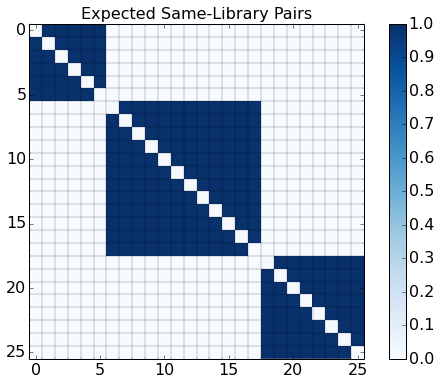

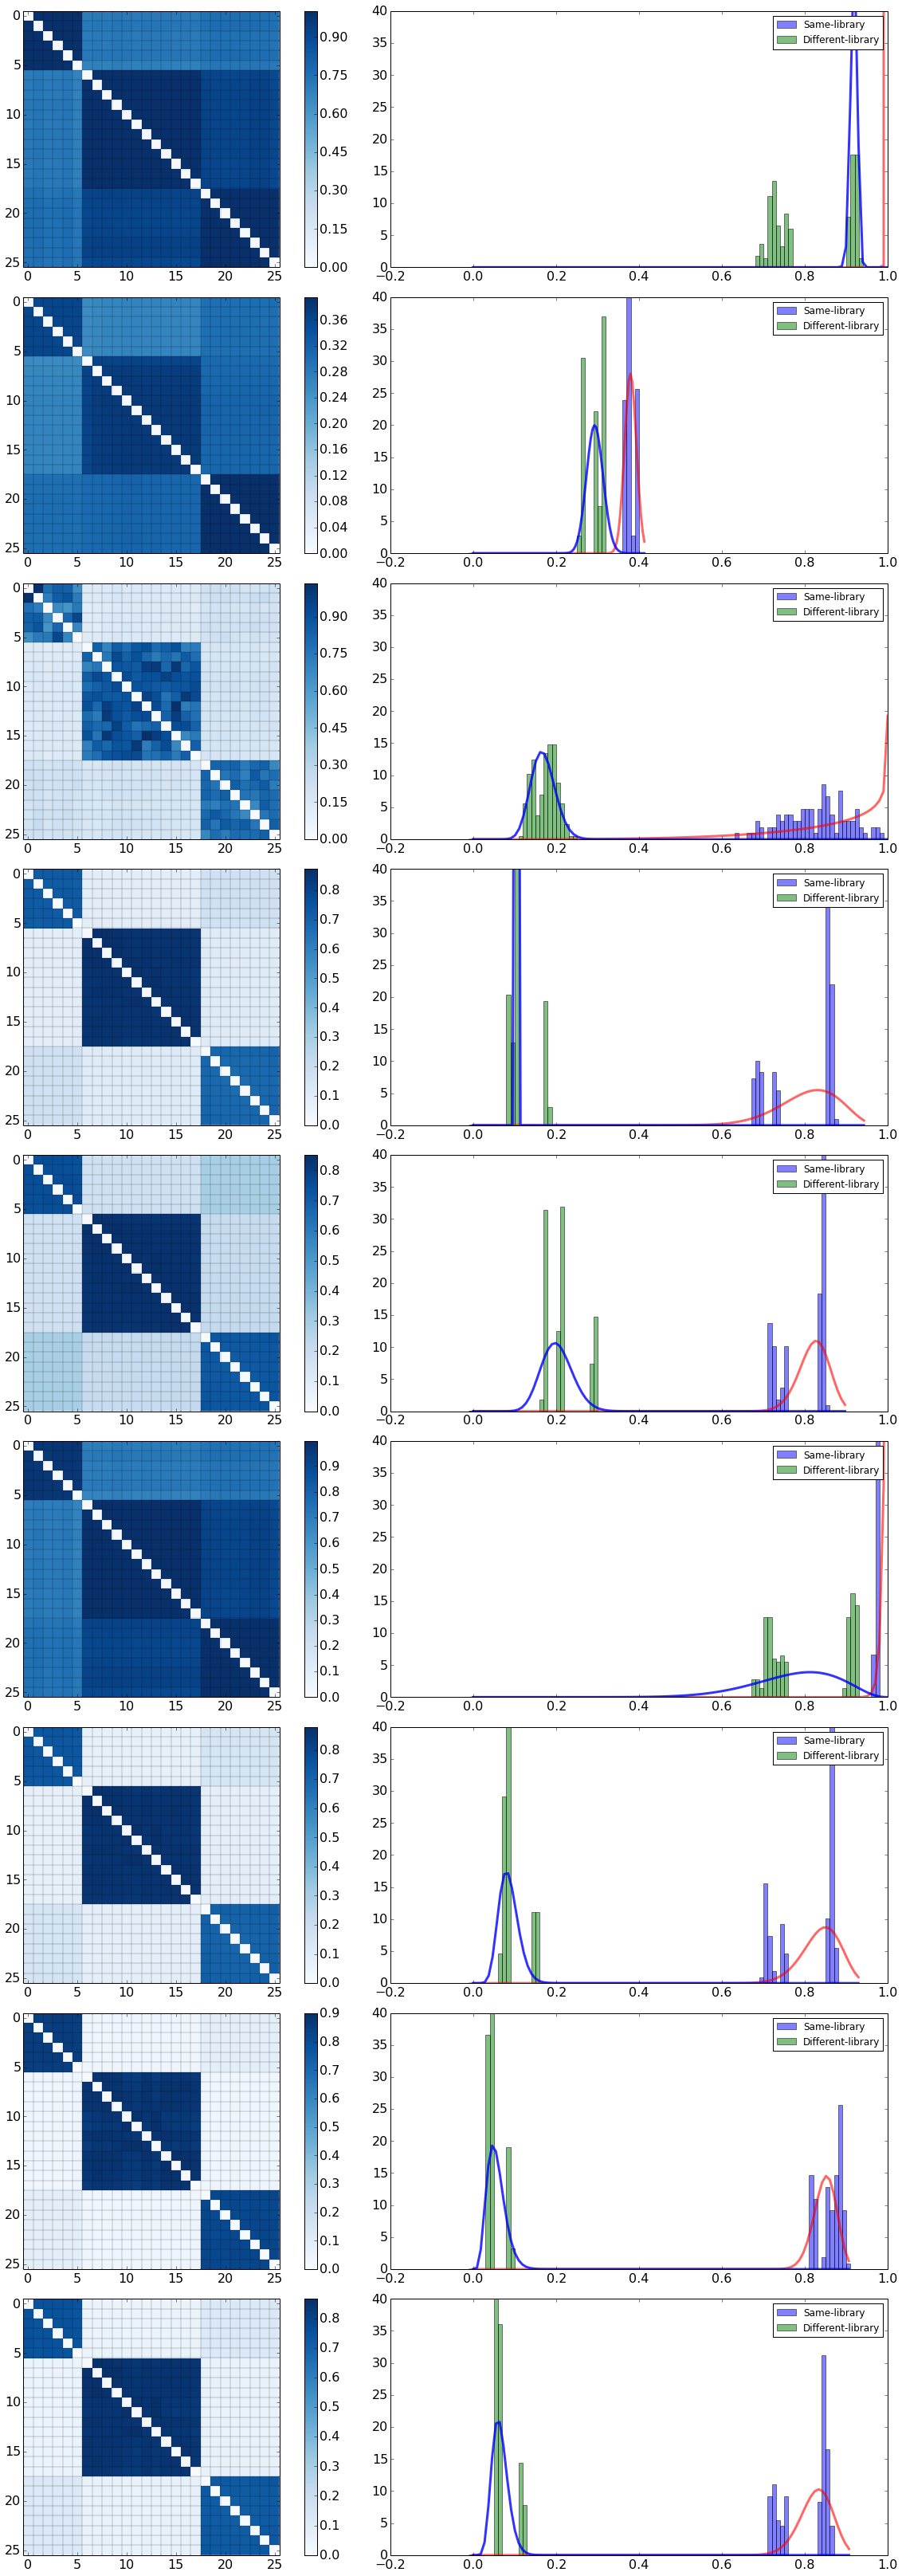

In [42]:
run_all("noF", "two_sense")

In [ ]:
run_all("strand_agnostic")

In [ ]:
noFilters = run_all("noF", "pcr_free")



In [ ]:
noFilters.columns

print noFilters['Hellinger Distance']
print 
print noOpticals['Hellinger Distance']
print 
print clean['Hellinger Distance']

In [ ]:
print noFilters['Expected False-Sames']['All Pairs Affinity']
print 
print noOpticals['Expected False-Sames']['All Pairs Affinity']
print 
print clean['Expected False-Sames']['All Pairs Affinity']

In [ ]:
print noFilters['Expected False-Diffs']['All Pairs Affinity']
print 
print noOpticals['Expected False-Diffs']['All Pairs Affinity']
print 
print clean['Expected False-Diffs']['All Pairs Affinity']

In [ ]:
noFilters.columns

In [ ]:
noOpticals = run_all("optNo", "ice_only")

In [ ]:
clean = run_all("feb", "ice_only")

In [ ]:
test_two_sense = run_all('noF', 'ice_only')

In [45]:
data_types = ["pcr_free", "pcr_plus",  "genomes", "combined", "ice_only", "agilent_only", "exomes", "two_sense","strand_agnostic", "rna"] # "genomes", "combined"] # Omit genomes_new, combined due to inclusion of PCR-free


def all_sets(data_types, flavor):
    labels = []
    metrics = {}
    for j in xrange(len(data_types)):
        data = data_types[j]
        print "evaluating {}".format(data)
        distance_files = { \
                  "All Pairs Affinity" : "{}_test_{}_libraries.ap_affinity.csv".format(flavor, data), \
                  "Exact Pairs Affinity" : "{}_test_{}_libraries.ep_affinity.csv".format(flavor, data), \
                  "Jaccard Similarity Index" : "{}_test_{}_libraries.jaccard.csv".format(flavor, data), \
                  "Cosine Similarity" : "{}_test_{}_libraries.cosine.csv".format(flavor, data), \
                  "Random Pairs Affinity" : "{}_test_{}_libraries.random.csv".format(flavor, data), \
#                   "Unlimited Pairs Affinity" : "{}_test_{}_libraries.unlimited.csv".format(flavor, data), \
                  "Ten limited Affinity" : "{}_test_{}_libraries.ten.csv".format(flavor, data), \
                  "Five limited Affinity" : "{}_test_{}_libraries.five.csv".format(flavor, data), \
                  "Four limited Affinity" : "{}_test_{}_libraries.four.csv".format(flavor, data), \
                  "Three limited Affinity" : "{}_test_{}_libraries.three.csv".format(flavor, data), \
#                   "Two limited Affinity" : "{}_test_{}_libraries.two.csv".format(flavor, data) \
                 }
        metadata_file = "{}_test_{}_libraries.read_groups.json".format(flavor, data)

        meta = read_metadata(metadata_file)
        groups, libraries = get_groups_and_libraries(meta)
        truth = make_truth_matrix(groups, libraries)
        
        i = 0
        evaluation_criteria = None
        for test_label, test_file in distance_files.iteritems():
            i += 1
            print "evaluating {}".format(test_label)
            distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
            evaluation, false_calls = run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False, None, len(distance_files), i)
            if i == 1:
                evaluation_criteria = evaluation
                all_false_calls = false_calls
            else:
                evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
                if false_calls is not None:
                    if all_false_calls is None:
                        all_false_calls = false_calls
                    else:
                        all_false_calls = all_false_calls.append(false_calls)

        # Gather up some of the metrics sliced from our broader evaluation criteria
        per_type_metrics = {}
#         per_type_metrics = { \
#             "LLR_rand_index" : evaluation_criteria["LLR rand index"], \
#             "LLR_sensitivity" : evaluation_criteria["LLR p(same-library | truly same-library)"], \
#             "LLR_specificity" : evaluation_criteria["LLR p(different-library | truly different-library)"], \
#             "Cluster_rand_index" : evaluation_criteria["Cluster rand index"], \
#             "Cluster_sensitivity" : evaluation_criteria["Cluster p(same-library | truly same-library)"], \
#             "Cluster_specificity" : evaluation_criteria["Cluster p(different-library | truly different-library)"], \
#             "LLR_cluster_rand_index" : evaluation_criteria["LLR Cluster rand index"], \
#             "LLR_cluster_sensitivity" : evaluation_criteria["LLR Cluster p(same-library | truly same-library)"], \
#             "LLR_cluster_specificity" : evaluation_criteria["LLR Cluster p(different-library | truly different-library)"], \
#             "ratio_rand_index" : evaluation_criteria["ratio rand index"], \
#             "ratio_sensitivity" : evaluation_criteria["ratio p(same-library | truly same-library)"], \
#             "ratio_specificity" : evaluation_criteria["ratio p(different-library | truly different-library)"], \
#             "ratio_cluster_rand_index" : evaluation_criteria["Ratio Cluster rand index"], \
#             "ratio_cluster_sensitivity" : evaluation_criteria["Ratio Cluster p(same-library | truly same-library)"], \
#             "ratio_cluster_specificity" : evaluation_criteria["Ratio Cluster p(different-library | truly different-library)"] \
#         }
        
        
        for col in evaluation_criteria.columns:
            updated = col.replace(" ", "_")
            per_type_metrics[updated] = evaluation_criteria[col]
        
#         per_type_metrics = evaluation_criteria


        if j == 0:
            labels = [data]

            # wrap each metric in a dataframe and keep hold of it as the nucleus for our growing list
            for key, value in per_type_metrics.iteritems():
                metrics[key] = pd.DataFrame(value)

        else:
            labels.append(data)

            # concatenate the new data-types metrics to our existing ones.
            for key, value in metrics.iteritems():
                metrics[key] = pd.concat([metrics[key], per_type_metrics[key]], axis=1)

        # update the labels and do a diagnostic print
        for key, value in metrics.iteritems():
            metrics[key].columns=labels    
            print key
            display(metrics[key])

    # Get a consistent sort on the indices for all final metrics
    # Also cache a copy of each frame
    for key, value in metrics.iteritems():
            metrics[key] = metrics[key].sort_index()
            metrics_file = "{}_{}_evaluation.csv".format(flavor, key)
            metrics[key].to_csv(metrics_file)
    
    return metrics

In [46]:
# reduced_types=["rna", "genomes", "pcr_free", "pcr_plus", "ice_only", "agilent_only", "exomes", "strand_agnostic"] # "two_sense",
unfiltered = all_sets(data_types, "noF")






evaluating pcr_free
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index

/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars



1
2
3
NO DISTRIBUTIONS
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free
All Pairs Affinity        0.841312
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.905142
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

Expected_False-Sames


pcr_free
All Pairs Affinity        2.499591e-01
Jaccard Similarity Index  1.465493e-07
Random Pairs Affinity     1.519996e-01
Five limited Affinity     9.999995e-01
Ten limited Affinity      9.009400e-02
Cosine Similarity         5.643405e-01
Four limited Affinity     2.019505e-01
Exact Pairs Affinity      1.180938e-01
Three limited Affinity    1.908391e-01

ratio_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.701087
Jaccard Similarity Index  0.994565
Random Pairs Affinity     0.693841
Five limited Affinity     0.576087
Ten limited Affinity      0.411232
Cosine Similarity         0.806159
Four limited Affinity     0.673913
Exact Pairs Affinity      0.927536
Three limited Affinity    0.777174

LLR_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.806159
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.856884
Five limited Affinity     0.766304
Ten limited Affinity      0.465580
Cosine Similarity         0.867754
Four limited Affinity     0.827899
Exact Pairs Affinity      0.958333
Three limited Affinity    0.927536

_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.858696
Jaccard Similarity Index  0.500000
Random Pairs Affinity     0.922101
Five limited Affinity     0.847826
Ten limited Affinity      0.797101
Cosine Similarity         0.862319
Four limited Affinity     0.902174
Exact Pairs Affinity      0.971014
Three limited Affinity    0.949275

threshold


pcr_free
All Pairs Affinity        0.943889
Jaccard Similarity Index  0.049099
Random Pairs Affinity     0.038585
Five limited Affinity     0.055527
Ten limited Affinity      0.122684
Cosine Similarity         0.926217
Four limited Affinity     0.043126
Exact Pairs Affinity      0.017815
Three limited Affinity    0.031202

dist_part_mod


pcr_free
All Pairs Affinity        4.440892e-16
Jaccard Similarity Index -1.998401e-15
Random Pairs Affinity     7.820593e-02
Five limited Affinity     5.163400e-02
Ten limited Affinity      2.886661e-02
Cosine Similarity         8.881784e-16
Four limited Affinity     6.402317e-02
Exact Pairs Affinity      1.465206e-01
Three limited Affinity    8.473983e-02

ratio_clusters_discovered


pcr_free
All Pairs Affinity               4
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                3
Four limited Affinity            3
Exact Pairs Affinity             2
Three limited Affinity           2

_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        0.272569
Jaccard Similarity Index  0.000000
Random Pairs Affinity     0.621528
Five limited Affinity     0.501736
Ten limited Affinity      0.409722
Cosine Similarity         0.303819
Four limited Affinity     0.531250
Exact Pairs Affinity      0.701389
Three limited Affinity    0.597222

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.719203
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.813406
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

LLR_Clusters_discovered


pcr_free
All Pairs Affinity               3
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             3
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

ratio_part_mod


pcr_free
All Pairs Affinity        0.482725
Jaccard Similarity Index  0.499588
Random Pairs Affinity     0.057141
Five limited Affinity     0.012229
Ten limited Affinity      0.040789
Cosine Similarity         0.151179
Four limited Affinity     0.030886
Exact Pairs Affinity      0.487992
Three limited Affinity    0.129134

LLR_part_mod


pcr_free
All Pairs Affinity        0.257639
Jaccard Similarity Index  0.234436
Random Pairs Affinity     0.246452
Five limited Affinity     0.190716
Ten limited Affinity      0.115257
Cosine Similarity         0.057770
Four limited Affinity     0.212088
Exact Pairs Affinity      0.362739
Three limited Affinity    0.246865

Hellinger_Distance


pcr_free
All Pairs Affinity        0.595595
Jaccard Similarity Index       NaN
Random Pairs Affinity     0.596917
Five limited Affinity     0.439177
Ten limited Affinity      0.280271
Cosine Similarity         0.333985
Four limited Affinity     0.531749
Exact Pairs Affinity      0.853750
Three limited Affinity    0.666406

Cluster_rand_index


pcr_free
All Pairs Affinity        0.489362
Jaccard Similarity Index  0.489362
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.489362
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        0.958333
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.993056
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity             0.0
Jaccard Similarity Index       0.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              0.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

_rand_index


pcr_free
All Pairs Affinity        0.559397
Jaccard Similarity Index  0.244681
Random Pairs Affinity     0.768617
Five limited Affinity     0.671099
Ten limited Affinity      0.599291
Cosine Similarity         0.577128
Four limited Affinity     0.712766
Exact Pairs Affinity      0.833333
Three limited Affinity    0.769504

expected_part_mod


pcr_free
All Pairs Affinity       -0.001203
Jaccard Similarity Index -0.002034
Random Pairs Affinity     0.078206
Five limited Affinity     0.051634
Ten limited Affinity      0.028867
Cosine Similarity        -0.001191
Four limited Affinity     0.064023
Exact Pairs Affinity      0.146521
Three limited Affinity    0.084740

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        0.958333
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.993056
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        0.888889
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.987847
Five limited Affinity     0.973958
Ten limited Affinity      0.977431
Cosine Similarity         0.628472
Four limited Affinity     0.977431
Exact Pairs Affinity      0.989583
Three limited Affinity    0.979167

Dist_Clusters_discovered


pcr_free
All Pairs Affinity               1
Jaccard Similarity Index         1
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                1
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

diff-lib_beta


pcr_free
All Pairs Affinity             1.423883
Jaccard Similarity Index  496997.447726
Random Pairs Affinity       1284.701380
Five limited Affinity        872.119259
Ten limited Affinity         381.863378
Cosine Similarity              3.324590
Four limited Affinity       1158.300842
Exact Pairs Affinity        2988.282437
Three limited Affinity      1682.130060

Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

max_distance


pcr_free
All Pairs Affinity        1.001859
Jaccard Similarity Index  0.057536
Random Pairs Affinity     0.077574
Five limited Affinity     0.099952
Ten limited Affinity      0.201389
Cosine Similarity         0.985728
Four limited Affinity     0.080192
Exact Pairs Affinity      0.045637
Three limited Affinity    0.061439

same-lib_alpha


pcr_free
All Pairs Affinity         17.756156
Jaccard Similarity Index  190.580365
Random Pairs Affinity      29.136685
Five limited Affinity      32.277623
Ten limited Affinity       29.540711
Cosine Similarity          72.994448
Four limited Affinity      33.341723
Exact Pairs Affinity       21.743992
Three limited Affinity     33.279403

LLR_Cluster_rand_index


pcr_free
All Pairs Affinity        0.841312
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.905142
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

ratio_rand_index


pcr_free
All Pairs Affinity        0.796986
Jaccard Similarity Index  0.997340
Random Pairs Affinity     0.843972
Five limited Affinity     0.779255
Ten limited Affinity      0.700355
Cosine Similarity         0.715426
Four limited Affinity     0.828901
Exact Pairs Affinity      0.959220
Three limited Affinity    0.880319

ratio_threshold


pcr_free
All Pairs Affinity        1.089037e+00
Jaccard Similarity Index  7.449981e+06
Random Pairs Affinity     5.026816e+00
Five limited Affinity     3.281982e+00
Ten limited Affinity      2.872473e+00
Cosine Similarity         1.367465e+00
Four limited Affinity     3.357253e+00
Exact Pairs Affinity      2.479746e+00
Three limited Affinity    2.964446e+00

LLR_rand_index


pcr_free
All Pairs Affinity        0.672872
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.828014
Five limited Affinity     0.754433
Ten limited Affinity      0.718972
Cosine Similarity         0.572695
Four limited Affinity     0.748227
Exact Pairs Affinity      0.906028
Three limited Affinity    0.808511

LLR_threshold


pcr_free
All Pairs Affinity        -0.679796
Jaccard Similarity Index  10.449233
Random Pairs Affinity     -0.176005
Five limited Affinity      0.074177
Ten limited Affinity       0.491136
Cosine Similarity         -0.533545
Four limited Affinity     -0.228578
Exact Pairs Affinity      -1.639943
Three limited Affinity    -0.672368

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.719203
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.813406
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

diff-lib_alpha


pcr_free
All Pairs Affinity           18.384492
Jaccard Similarity Index  26133.970452
Random Pairs Affinity        47.638597
Five limited Affinity        49.388571
Ten limited Affinity         53.142707
Cosine Similarity            39.993190
Four limited Affinity        49.139545
Exact Pairs Affinity         47.870960
Three limited Affinity       49.609748

same-lib_beta


pcr_free
All Pairs Affinity           0.255120
Jaccard Similarity Index  3337.091090
Random Pairs Affinity      572.029092
Five limited Affinity      461.339767
Ten limited Affinity       188.229309
Cosine Similarity            3.534014
Four limited Affinity      604.041160
Exact Pairs Affinity       734.549808
Three limited Affinity     794.525728

Expected_False-Diffs


pcr_free
All Pairs Affinity        1.515981e-01
Jaccard Similarity Index  2.589158e-01
Random Pairs Affinity     1.997913e-01
Five limited Affinity     7.566288e-07
Ten limited Affinity      6.501182e-01
Cosine Similarity         1.085852e-01
Four limited Affinity     2.203881e-01
Exact Pairs Affinity      3.076792e-02
Three limited Affinity    1.116076e-01

LLR_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        0.545139
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.800347
Five limited Affinity     0.743056
Ten limited Affinity      0.961806
Cosine Similarity         0.289931
Four limited Affinity     0.671875
Exact Pairs Affinity      0.855903
Three limited Affinity    0.694444

evaluating pcr_plus
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.841312  0.643687
Jaccard Similarity Index  1.000000  0.490566
Random Pairs Affinity     1.000000  0.962264
Five limited Affinity     1.000000  0.962264
Ten limited Affinity      0.905142  0.962264
Cosine Similarity         1.000000  0.622642
Four limited Affinity     1.000000  0.962264
Exact Pairs Affinity      1.000000  0.962264
Three limited Affinity    1.000000  0.962264

Expected_False-Sames


pcr_free  pcr_plus
All Pairs Affinity        2.499591e-01  0.995983
Jaccard Similarity Index  1.465493e-07  0.005822
Random Pairs Affinity     1.519996e-01  0.043987
Five limited Affinity     9.999995e-01  0.082655
Ten limited Affinity      9.009400e-02  0.118463
Cosine Similarity         5.643405e-01  0.979683
Four limited Affinity     2.019505e-01  0.078085
Exact Pairs Affinity      1.180938e-01  0.038725
Three limited Affinity    1.908391e-01  0.068826

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.701087  0.158284
Jaccard Similarity Index  0.994565  0.556213
Random Pairs Affinity     0.693841  0.902367
Five limited Affinity     0.576087  0.757396
Ten limited Affinity      0.411232  0.430473
Cosine Similarity         0.806159  0.155325
Four limited Affinity     0.673913  0.909763
Exact Pairs Affinity      0.927536  0.924556
Three limited Affinity    0.777174  0.921598

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.806159  0.272189
Jaccard Similarity Index  1.000000  0.557692
Random Pairs Affinity     0.856884  0.924556
Five limited Affinity     0.766304  0.923077
Ten limited Affinity      0.465580  0.646450
Cosine Similarity         0.867754  0.210059
Four limited Affinity     0.827899  0.924556
Exact Pairs Affinity      0.958333  0.926036
Three limited Affinity    0.927536  0.924556

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.858696  0.920118
Jaccard Similarity Index  0.500000  0.961538
Random Pairs Affinity     0.922101  0.924556
Five limited Affinity     0.847826  0.924556
Ten limited Affinity      0.797101  0.850592
Cosine Similarity         0.862319  0.591716
Four limited Affinity     0.902174  0.924556
Exact Pairs Affinity      0.971014  0.958580
Three limited Affinity    0.949275  0.924556

threshold


pcr_free  pcr_plus
All Pairs Affinity        0.943889  0.986061
Jaccard Similarity Index  0.049099  0.040936
Random Pairs Affinity     0.038585  0.009619
Five limited Affinity     0.055527  0.013063
Ten limited Affinity      0.122684  0.032262
Cosine Similarity         0.926217  0.952488
Four limited Affinity     0.043126  0.009681
Exact Pairs Affinity      0.017815  0.003848
Three limited Affinity    0.031202  0.006675

dist_part_mod


pcr_free      pcr_plus
All Pairs Affinity        4.440892e-16  1.110223e-15
Jaccard Similarity Index -1.998401e-15  1.291795e-02
Random Pairs Affinity     7.820593e-02  2.375785e-01
Five limited Affinity     5.163400e-02  1.891105e-01
Ten limited Affinity      2.886661e-02  9.911049e-02
Cosine Similarity         8.881784e-16 -2.109424e-15
Four limited Affinity     6.402317e-02  2.248622e-01
Exact Pairs Affinity      1.465206e-01  3.393762e-01
Three limited Affinity    8.473983e-02  2.706408e-01

ratio_clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               4         6
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             2         2
Cosine Similarity                3         2
Four limited Affinity            3         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         3

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        0.272569  0.132479
Jaccard Similarity Index  0.000000  0.037037
Random Pairs Affinity     0.621528  0.964387
Five limited Affinity     0.501736  0.943020
Ten limited Affinity      0.409722  0.933048
Cosine Similarity         0.303819  0.491453
Four limited Affinity     0.531250  0.945869
Exact Pairs Affinity      0.701389  0.964387
Three limited Affinity    0.597222  0.952991

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.719203  0.406805
Jaccard Similarity Index  1.000000  1.000000
Random Pairs Affinity     1.000000  0.963018
Five limited Affinity     1.000000  0.963018
Ten limited Affinity      0.813406  0.963018
Cosine Similarity         1.000000  0.619822
Four limited Affinity     1.000000  0.963018
Exact Pairs Affinity      1.000000  0.963018
Three limited Affinity    1.000000  0.963018

LLR_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               3         5
Jaccard Similarity Index         2         1
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             3         2
Cosine Similarity                2         2
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

ratio_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.482725  0.617050
Jaccard Similarity Index  0.499588  0.202687
Random Pairs Affinity     0.057141  0.445816
Five limited Affinity     0.012229  0.028224
Ten limited Affinity      0.040789  0.120807
Cosine Similarity         0.151179  0.203861
Four limited Affinity     0.030886  0.237915
Exact Pairs Affinity      0.487992  0.499506
Three limited Affinity    0.129134  0.499319

LLR_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.257639  0.418058
Jaccard Similarity Index  0.234436  0.000000
Random Pairs Affinity     0.246452  0.373413
Five limited Affinity     0.190716  0.327078
Ten limited Affinity      0.115257  0.194008
Cosine Similarity         0.057770  0.154483
Four limited Affinity     0.212088  0.359019
Exact Pairs Affinity      0.362739  0.427485
Three limited Affinity    0.246865  0.391493

Hellinger_Distance


pcr_free  pcr_plus
All Pairs Affinity        0.595595  0.399067
Jaccard Similarity Index       NaN       NaN
Random Pairs Affinity     0.596917  0.832802
Five limited Affinity     0.439177  0.739087
Ten limited Affinity      0.280271  0.375745
Cosine Similarity         0.333985  0.204017
Four limited Affinity     0.531749  0.802450
Exact Pairs Affinity      0.853750  0.929993
Three limited Affinity    0.666406  0.867191

Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.489362  0.490566
Jaccard Similarity Index  0.489362  0.925980
Random Pairs Affinity     1.000000  1.000000
Five limited Affinity     1.000000  1.000000
Ten limited Affinity      1.000000  1.000000
Cosine Similarity         0.489362  0.490566
Four limited Affinity     1.000000  1.000000
Exact Pairs Affinity      1.000000  1.000000
Three limited Affinity    1.000000  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        0.958333  0.871795
Jaccard Similarity Index  1.000000  0.000000
Random Pairs Affinity     1.000000  0.961538
Five limited Affinity     1.000000  0.961538
Ten limited Affinity      0.993056  0.961538
Cosine Similarity         1.000000  0.625356
Four limited Affinity     1.000000  0.961538
Exact Pairs Affinity      1.000000  0.961538
Three limited Affinity    1.000000  0.961538

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity             0.0   0.00000
Jaccard Similarity Index       0.0   0.92735
Random Pairs Affinity          1.0   1.00000
Five limited Affinity          1.0   1.00000
Ten limited Affinity           1.0   1.00000
Cosine Similarity              0.0   0.00000
Four limited Affinity          1.0   1.00000
Exact Pairs Affinity           1.0   1.00000
Three limited Affinity         1.0   1.00000

_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.559397  0.518868
Jaccard Similarity Index  0.244681  0.490566
Random Pairs Affinity     0.768617  0.944848
Five limited Affinity     0.671099  0.933962
Ten limited Affinity      0.599291  0.892598
Cosine Similarity         0.577128  0.540639
Four limited Affinity     0.712766  0.935414
Exact Pairs Affinity      0.833333  0.961538
Three limited Affinity    0.769504  0.939042

expected_part_mod


pcr_free  pcr_plus
All Pairs Affinity       -0.001203 -0.008944
Jaccard Similarity Index -0.002034  0.010487
Random Pairs Affinity     0.078206  0.237579
Five limited Affinity     0.051634  0.189110
Ten limited Affinity      0.028867  0.099110
Cosine Similarity        -0.001191 -0.008948
Four limited Affinity     0.064023  0.224862
Exact Pairs Affinity      0.146521  0.339376
Three limited Affinity    0.084740  0.270641

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        0.958333  0.871795
Jaccard Similarity Index  1.000000  0.000000
Random Pairs Affinity     1.000000  0.961538
Five limited Affinity     1.000000  0.961538
Ten limited Affinity      0.993056  0.961538
Cosine Similarity         1.000000  0.625356
Four limited Affinity     1.000000  0.961538
Exact Pairs Affinity      1.000000  0.961538
Three limited Affinity    1.000000  0.961538

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        0.888889  0.987179
Jaccard Similarity Index  1.000000  0.955840
Random Pairs Affinity     0.987847  0.994302
Five limited Affinity     0.973958  0.991453
Ten limited Affinity      0.977431  0.974359
Cosine Similarity         0.628472  0.951567
Four limited Affinity     0.977431  0.992877
Exact Pairs Affinity      0.989583  0.995726
Three limited Affinity    0.979167  0.991453

Dist_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               1         1
Jaccard Similarity Index         1         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             2         2
Cosine Similarity                1         1
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

diff-lib_beta


pcr_free      pcr_plus
All Pairs Affinity             1.423883      3.556398
Jaccard Similarity Index  496997.447726  99912.092786
Random Pairs Affinity       1284.701380   1457.489663
Five limited Affinity        872.119259    863.880368
Ten limited Affinity         381.863378    348.750750
Cosine Similarity              3.324590     19.992821
Four limited Affinity       1158.300842   1207.047665
Exact Pairs Affinity        2988.282437   4019.580350
Three limited Affinity      1682.130060   1904.393100

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.924556
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

max_distance


pcr_free  pcr_plus
All Pairs Affinity        1.001859  1.001442
Jaccard Similarity Index  0.057536  0.069296
Random Pairs Affinity     0.077574  0.038823
Five limited Affinity     0.099952  0.042854
Ten limited Affinity      0.201389  0.068169
Cosine Similarity         0.985728  0.984604
Four limited Affinity     0.080192  0.038621
Exact Pairs Affinity      0.045637  0.031239
Three limited Affinity    0.061439  0.034747

same-lib_alpha


pcr_free    pcr_plus
All Pairs Affinity         17.756156  158.044051
Jaccard Similarity Index  190.580365   71.751081
Random Pairs Affinity      29.136685    5.123280
Five limited Affinity      32.277623    5.343354
Ten limited Affinity       29.540711    7.833145
Cosine Similarity          72.994448  188.138331
Four limited Affinity      33.341723    4.934046
Exact Pairs Affinity       21.743992    3.780059
Three limited Affinity     33.279403    4.464095

LLR_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.841312  0.643687
Jaccard Similarity Index  1.000000  0.490566
Random Pairs Affinity     1.000000  0.962264
Five limited Affinity     1.000000  0.962264
Ten limited Affinity      0.905142  0.962264
Cosine Similarity         1.000000  0.622642
Four limited Affinity     1.000000  0.962264
Exact Pairs Affinity      1.000000  0.962264
Three limited Affinity    1.000000  0.962264

ratio_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.796986  0.580552
Jaccard Similarity Index  0.997340  0.759797
Random Pairs Affinity     0.843972  0.949202
Five limited Affinity     0.779255  0.876633
Ten limited Affinity      0.700355  0.707547
Cosine Similarity         0.715426  0.560958
Four limited Affinity     0.828901  0.952104
Exact Pairs Affinity      0.959220  0.960813
Three limited Affinity    0.880319  0.957184

ratio_threshold


pcr_free   pcr_plus
All Pairs Affinity        1.089037e+00   3.128768
Jaccard Similarity Index  7.449981e+06  30.264638
Random Pairs Affinity     5.026816e+00  12.402610
Five limited Affinity     3.281982e+00   6.458930
Ten limited Affinity      2.872473e+00   5.800796
Cosine Similarity         1.367465e+00   2.154654
Four limited Affinity     3.357253e+00   4.468554
Exact Pairs Affinity      2.479746e+00   1.904607
Three limited Affinity    2.964446e+00   2.513350

LLR_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.672872  0.613208
Jaccard Similarity Index  1.000000  0.747460
Random Pairs Affinity     0.828014  0.944848
Five limited Affinity     0.754433  0.943396
Ten limited Affinity      0.718972  0.808418
Cosine Similarity         0.572695  0.573295
Four limited Affinity     0.748227  0.944122
Exact Pairs Affinity      0.906028  0.944848
Three limited Affinity    0.808511  0.944122

LLR_threshold


pcr_free  pcr_plus
All Pairs Affinity        -0.679796  0.417281
Jaccard Similarity Index  10.449233  0.760517
Random Pairs Affinity     -0.176005 -0.399189
Five limited Affinity      0.074177 -0.319146
Ten limited Affinity       0.491136  0.467066
Cosine Similarity         -0.533545  0.437893
Four limited Affinity     -0.228578 -0.746749
Exact Pairs Affinity      -1.639943 -2.010904
Three limited Affinity    -0.672368 -1.360855

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.719203  0.406805
Jaccard Similarity Index  1.000000  1.000000
Random Pairs Affinity     1.000000  0.963018
Five limited Affinity     1.000000  0.963018
Ten limited Affinity      0.813406  0.963018
Cosine Similarity         1.000000  0.619822
Four limited Affinity     1.000000  0.963018
Exact Pairs Affinity      1.000000  0.963018
Three limited Affinity    1.000000  0.963018

diff-lib_alpha


pcr_free     pcr_plus
All Pairs Affinity           18.384492   394.526143
Jaccard Similarity Index  26133.970452  5865.034378
Random Pairs Affinity        47.638597    10.888995
Five limited Affinity        49.388571     9.566450
Ten limited Affinity         53.142707     9.637751
Cosine Similarity            39.993190   395.530133
Four limited Affinity        49.139545     9.796908
Exact Pairs Affinity         47.870960    11.650899
Three limited Affinity       49.609748    10.439380

same-lib_beta


pcr_free     pcr_plus
All Pairs Affinity           0.255120     0.890166
Jaccard Similarity Index  3337.091090  1090.837530
Random Pairs Affinity      572.029092   192.755837
Five limited Affinity      461.339767   174.751512
Ten limited Affinity       188.229309   193.744512
Cosine Similarity            3.534014     9.056626
Four limited Affinity      604.041160   181.072325
Exact Pairs Affinity       734.549808   177.740645
Three limited Affinity     794.525728   183.436143

Expected_False-Diffs


pcr_free  pcr_plus
All Pairs Affinity        1.515981e-01  0.011671
Jaccard Similarity Index  2.589158e-01  0.269696
Random Pairs Affinity     1.997913e-01  0.071942
Five limited Affinity     7.566288e-07  0.125379
Ten limited Affinity      6.501182e-01  0.495689
Cosine Similarity         1.085852e-01  0.055026
Four limited Affinity     2.203881e-01  0.076482
Exact Pairs Affinity      3.076792e-02  0.014150
Three limited Affinity    1.116076e-01  0.038233

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        0.545139  0.941595
Jaccard Similarity Index  1.000000  0.930199
Random Pairs Affinity     0.800347  0.964387
Five limited Affinity     0.743056  0.962963
Ten limited Affinity      0.961806  0.964387
Cosine Similarity         0.289931  0.923077
Four limited Affinity     0.671875  0.962963
Exact Pairs Affinity      0.855903  0.962963
Three limited Affinity    0.694444  0.962963

evaluating genomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.841312  0.643687  0.828119
Jaccard Similarity Index  1.000000  0.490566  0.243168
Random Pairs Affinity     1.000000  0.962264  0.990099
Five limited Affinity     1.000000  0.962264  0.871287
Ten limited Affinity      0.905142  0.962264  0.851485
Cosine Similarity         1.000000  0.622642  0.668515
Four limited Affinity     1.000000  0.962264  1.000000
Exact Pairs Affinity      1.000000  0.962264  1.000000
Three limited Affinity    1.000000  0.962264  1.000000

Expected_False-Sames


pcr_free  pcr_plus       genomes
All Pairs Affinity        2.499591e-01  0.995983  1.911013e-01
Jaccard Similarity Index  1.465493e-07  0.005822  1.494479e-10
Random Pairs Affinity     1.519996e-01  0.043987  5.827376e-01
Five limited Affinity     9.999995e-01  0.082655  6.683541e-01
Ten limited Affinity      9.009400e-02  0.118463  1.906413e-02
Cosine Similarity         5.643405e-01  0.979683  5.585651e-01
Four limited Affinity     2.019505e-01  0.078085  7.434232e-02
Exact Pairs Affinity      1.180938e-01  0.038725  4.165125e-01
Three limited Affinity    1.908391e-01  0.068826  6.644300e-02

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.701087  0.158284  0.250000
Jaccard Similarity Index  0.994565  0.556213  0.958469
Random Pairs Affinity     0.693841  0.902367  0.510586
Five limited Affinity     0.576087  0.757396  0.390065
Ten limited Affinity      0.411232  0.430473  0.253257
Cosine Similarity         0.806159  0.155325  0.745114
Four limited Affinity     0.673913  0.909763  0.512215
Exact Pairs Affinity      0.927536  0.924556  0.788274
Three limited Affinity    0.777174  0.921598  0.653094

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.806159  0.272189  0.779316
Jaccard Similarity Index  1.000000  0.557692  0.978827
Random Pairs Affinity     0.856884  0.924556  0.948697
Five limited Affinity     0.766304  0.923077  0.949511
Ten limited Affinity      0.465580  0.646450  0.424267
Cosine Similarity         0.867754  0.210059  0.954397
Four limited Affinity     0.827899  0.924556  0.815961
Exact Pairs Affinity      0.958333  0.926036  0.954397
Three limited Affinity    0.927536  0.924556  0.935668

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.858696  0.920118  0.929153
Jaccard Similarity Index  0.500000  0.961538  0.978827
Random Pairs Affinity     0.922101  0.924556  0.780130
Five limited Affinity     0.847826  0.924556  0.693811
Ten limited Affinity      0.797101  0.850592  0.455212
Cosine Similarity         0.862319  0.591716  0.831433
Four limited Affinity     0.902174  0.924556  0.804560
Exact Pairs Affinity      0.971014  0.958580  0.938111
Three limited Affinity    0.949275  0.924556  0.929153

threshold


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.943889  0.986061  0.967924
Jaccard Similarity Index  0.049099  0.040936  0.070140
Random Pairs Affinity     0.038585  0.009619  0.017645
Five limited Affinity     0.055527  0.013063  0.022365
Ten limited Affinity      0.122684  0.032262  0.054542
Cosine Similarity         0.926217  0.952488  0.954972
Four limited Affinity     0.043126  0.009681  0.017119
Exact Pairs Affinity      0.017815  0.003848  0.008570
Three limited Affinity    0.031202  0.006675  0.012759

dist_part_mod


pcr_free      pcr_plus   genomes
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321

ratio_clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               4         6        7
Jaccard Similarity Index         2         2        2
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        4
Ten limited Affinity             2         2        2
Cosine Similarity                3         2        2
Four limited Affinity            3         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         3        4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.272569  0.132479  0.258503
Jaccard Similarity Index  0.000000  0.037037  0.019362
Random Pairs Affinity     0.621528  0.964387  0.848770
Five limited Affinity     0.501736  0.943020  0.841444
Ten limited Affinity      0.409722  0.933048  0.839613
Cosine Similarity         0.303819  0.491453  0.445840
Four limited Affinity     0.531250  0.945869  0.844584
Exact Pairs Affinity      0.701389  0.964387  0.862376
Three limited Affinity    0.597222  0.952991  0.847462

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.719203  0.406805  0.947068
Jaccard Similarity Index  1.000000  1.000000  1.000000
Random Pairs Affinity     1.000000  0.963018  0.978827
Five limited Affinity     1.000000  0.963018  0.978827
Ten limited Affinity      0.813406  0.963018  0.958469
Cosine Similarity         1.000000  0.619822  0.890065
Four limited Affinity     1.000000  0.963018  1.000000
Exact Pairs Affinity      1.000000  0.963018  1.000000
Three limited Affinity    1.000000  0.963018  1.000000

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               3         5        3
Jaccard Similarity Index         2         1        1
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        3
Ten limited Affinity             3         2        3
Cosine Similarity                2         2        2
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

ratio_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.482725  0.617050  0.665405
Jaccard Similarity Index  0.499588  0.202687  0.010091
Random Pairs Affinity     0.057141  0.445816  0.199271
Five limited Affinity     0.012229  0.028224  0.277212
Ten limited Affinity      0.040789  0.120807  0.145901
Cosine Similarity         0.151179  0.203861  0.134721
Four limited Affinity     0.030886  0.237915  0.464077
Exact Pairs Affinity      0.487992  0.499506  0.659041
Three limited Affinity    0.129134  0.499319  0.643368

LLR_part_mod


pcr_free  pcr_plus       genomes
All Pairs Affinity        0.257639  0.418058  1.557462e-01
Jaccard Similarity Index  0.234436  0.000000 -1.221245e-15
Random Pairs Affinity     0.246452  0.373413  8.423506e-02
Five limited Affinity     0.190716  0.327078  5.487061e-02
Ten limited Affinity      0.115257  0.194008  1.148039e-01
Cosine Similarity         0.057770  0.154483  2.252706e-02
Four limited Affinity     0.212088  0.359019  1.644085e-01
Exact Pairs Affinity      0.362739  0.427485  1.549608e-01
Three limited Affinity    0.246865  0.391493  1.954972e-01

Hellinger_Distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.595595  0.399067  0.469575
Jaccard Similarity Index       NaN       NaN  0.174263
Random Pairs Affinity     0.596917  0.832802  0.667096
Five limited Affinity     0.439177  0.739087  0.561993
Ten limited Affinity      0.280271  0.375745  0.301846
Cosine Similarity         0.333985  0.204017  0.414235
Four limited Affinity     0.531749  0.802450  0.628983
Exact Pairs Affinity      0.853750  0.929993  0.865444
Three limited Affinity    0.666406  0.867191  0.729720

Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.489362  0.490566  0.609109
Jaccard Similarity Index  0.489362  0.925980  0.737822
Random Pairs Affinity     1.000000  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  1.000000  1.000000
Cosine Similarity         0.489362  0.490566  0.609109
Four limited Affinity     1.000000  1.000000  1.000000
Exact Pairs Affinity      1.000000  1.000000  1.000000
Three limited Affinity    1.000000  1.000000  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.958333  0.871795  0.789901
Jaccard Similarity Index  1.000000  0.000000  0.000000
Random Pairs Affinity     1.000000  0.961538  0.993721
Five limited Affinity     1.000000  0.961538  0.836735
Ten limited Affinity      0.993056  0.961538  0.817111
Cosine Similarity         1.000000  0.625356  0.597331
Four limited Affinity     1.000000  0.961538  1.000000
Exact Pairs Affinity      1.000000  0.961538  1.000000
Three limited Affinity    1.000000  0.961538  1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             0.0   0.00000  0.483516
Jaccard Similarity Index       0.0   0.92735  0.660387
Random Pairs Affinity          1.0   1.00000  1.000000
Five limited Affinity          1.0   1.00000  1.000000
Ten limited Affinity           1.0   1.00000  1.000000
Cosine Similarity              0.0   0.00000  0.483516
Four limited Affinity          1.0   1.00000  1.000000
Exact Pairs Affinity           1.0   1.00000  1.000000
Three limited Affinity         1.0   1.00000  1.000000

_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.559397  0.518868  0.421584
Jaccard Similarity Index  0.244681  0.490566  0.252673
Random Pairs Affinity     0.768617  0.944848  0.832079
Five limited Affinity     0.671099  0.933962  0.805545
Ten limited Affinity      0.599291  0.892598  0.746139
Cosine Similarity         0.577128  0.540639  0.539604
Four limited Affinity     0.712766  0.935414  0.834851
Exact Pairs Affinity      0.833333  0.961538  0.880792
Three limited Affinity    0.769504  0.939042  0.867327

expected_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity       -0.001203 -0.008944 -0.003837
Jaccard Similarity Index -0.002034  0.010487  0.000240
Random Pairs Affinity     0.078206  0.237579  0.179409
Five limited Affinity     0.051634  0.189110  0.132872
Ten limited Affinity      0.028867  0.099110  0.063761
Cosine Similarity        -0.001191 -0.008948 -0.003828
Four limited Affinity     0.064023  0.224862  0.166097
Exact Pairs Affinity      0.146521  0.339376  0.326352
Three limited Affinity    0.084740  0.270641  0.215321

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.958333  0.871795  0.789901
Jaccard Similarity Index  1.000000  0.000000  0.000000
Random Pairs Affinity     1.000000  0.961538  0.993721
Five limited Affinity     1.000000  0.961538  0.836735
Ten limited Affinity      0.993056  0.961538  0.817111
Cosine Similarity         1.000000  0.625356  0.597331
Four limited Affinity     1.000000  0.961538  1.000000
Exact Pairs Affinity      1.000000  0.961538  1.000000
Three limited Affinity    1.000000  0.961538  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.888889  0.987179  0.992674
Jaccard Similarity Index  1.000000  0.955840  0.019362
Random Pairs Affinity     0.987847  0.994302  0.992936
Five limited Affinity     0.973958  0.991453  0.983778
Ten limited Affinity      0.977431  0.974359  0.994767
Cosine Similarity         0.628472  0.951567  0.585296
Four limited Affinity     0.977431  0.992877  0.993197
Exact Pairs Affinity      0.989583  0.995726  0.997645
Three limited Affinity    0.979167  0.991453  0.995552

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               1         1        2
Jaccard Similarity Index         1         2        2
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        4
Ten limited Affinity             2         2        4
Cosine Similarity                1         1        2
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

diff-lib_beta


pcr_free      pcr_plus     genomes
All Pairs Affinity             1.423883      3.556398    1.121789
Jaccard Similarity Index  496997.447726  99912.092786  692.740069
Random Pairs Affinity       1284.701380   1457.489663  305.357643
Five limited Affinity        872.119259    863.880368  222.723555
Ten limited Affinity         381.863378    348.750750  147.328789
Cosine Similarity              3.324590     19.992821    4.259642
Four limited Affinity       1158.300842   1207.047665  476.120736
Exact Pairs Affinity        2988.282437   4019.580350  624.271043
Three limited Affinity      1682.130060   1904.393100  650.489283

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  1.000000
Jaccard Similarity Index       1.0  0.924556  0.978827
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  1.000000
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

max_distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.001859  1.001442  1.003642
Jaccard Similarity Index  0.057536  0.069296  0.104672
Random Pairs Affinity     0.077574  0.038823  0.061749
Five limited Affinity     0.099952  0.042854  0.066040
Ten limited Affinity      0.201389  0.068169  0.137019
Cosine Similarity         0.985728  0.984604  0.988229
Four limited Affinity     0.080192  0.038621  0.053603
Exact Pairs Affinity      0.045637  0.031239  0.039855
Three limited Affinity    0.061439  0.034747  0.043171

same-lib_alpha


pcr_free    pcr_plus     genomes
All Pairs Affinity         17.756156  158.044051   41.531656
Jaccard Similarity Index  190.580365   71.751081   98.700162
Random Pairs Affinity      29.136685    5.123280    7.121605
Five limited Affinity      32.277623    5.343354    6.878594
Ten limited Affinity       29.540711    7.833145    3.553484
Cosine Similarity          72.994448  188.138331  199.710955
Four limited Affinity      33.341723    4.934046    4.886915
Exact Pairs Affinity       21.743992    3.780059    7.120015
Three limited Affinity     33.279403    4.464095    4.953476

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.841312  0.643687  0.828119
Jaccard Similarity Index  1.000000  0.490566  0.243168
Random Pairs Affinity     1.000000  0.962264  0.990099
Five limited Affinity     1.000000  0.962264  0.871287
Ten limited Affinity      0.905142  0.962264  0.851485
Cosine Similarity         1.000000  0.622642  0.668515
Four limited Affinity     1.000000  0.962264  1.000000
Exact Pairs Affinity      1.000000  0.962264  1.000000
Three limited Affinity    1.000000  0.962264  1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.796986  0.580552  0.812079
Jaccard Similarity Index  0.997340  0.759797  0.247723
Random Pairs Affinity     0.843972  0.949202  0.875644
Five limited Affinity     0.779255  0.876633  0.839406
Ten limited Affinity      0.700355  0.707547  0.814455
Cosine Similarity         0.715426  0.560958  0.624158
Four limited Affinity     0.828901  0.952104  0.876238
Exact Pairs Affinity      0.959220  0.960813  0.946733
Three limited Affinity    0.880319  0.957184  0.912277

ratio_threshold


pcr_free   pcr_plus     genomes
All Pairs Affinity        1.089037e+00   3.128768    4.107393
Jaccard Similarity Index  7.449981e+06  30.264638    0.765821
Random Pairs Affinity     5.026816e+00  12.402610    5.345191
Five limited Affinity     3.281982e+00   6.458930    3.864006
Ten limited Affinity      2.872473e+00   5.800796   20.021043
Cosine Similarity         1.367465e+00   2.154654    1.573539
Four limited Affinity     3.357253e+00   4.468554   67.450540
Exact Pairs Affinity      2.479746e+00   1.904607    4.183847
Three limited Affinity    2.964446e+00   2.513350  114.606579

LLR_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.672872  0.613208  0.777426
Jaccard Similarity Index  1.000000  0.747460  0.252673
Random Pairs Affinity     0.828014  0.944848  0.698020
Five limited Affinity     0.754433  0.943396  0.574455
Ten limited Affinity      0.718972  0.808418  0.763762
Cosine Similarity         0.572695  0.573295  0.422574
Four limited Affinity     0.748227  0.944122  0.837030
Exact Pairs Affinity      0.906028  0.944848  0.858614
Three limited Affinity    0.808511  0.944122  0.867921

LLR_threshold


pcr_free  pcr_plus   genomes
All Pairs Affinity        -0.679796  0.417281  0.050881
Jaccard Similarity Index  10.449233  0.760517 -5.337340
Random Pairs Affinity     -0.176005 -0.399189 -2.683916
Five limited Affinity      0.074177 -0.319146 -2.232934
Ten limited Affinity       0.491136  0.467066  1.458788
Cosine Similarity         -0.533545  0.437893 -0.853637
Four limited Affinity     -0.228578 -0.746749  0.536614
Exact Pairs Affinity      -1.639943 -2.010904 -4.349230
Three limited Affinity    -0.672368 -1.360855  0.273219

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.719203  0.406805  0.947068
Jaccard Similarity Index  1.000000  1.000000  1.000000
Random Pairs Affinity     1.000000  0.963018  0.978827
Five limited Affinity     1.000000  0.963018  0.978827
Ten limited Affinity      0.813406  0.963018  0.958469
Cosine Similarity         1.000000  0.619822  0.890065
Four limited Affinity     1.000000  0.963018  1.000000
Exact Pairs Affinity      1.000000  0.963018  1.000000
Three limited Affinity    1.000000  0.963018  1.000000

diff-lib_alpha


pcr_free     pcr_plus    genomes
All Pairs Affinity           18.384492   394.526143  33.088171
Jaccard Similarity Index  26133.970452  5865.034378  65.882713
Random Pairs Affinity        47.638597    10.888995   4.419341
Five limited Affinity        49.388571     9.566450   4.434836
Ten limited Affinity         53.142707     9.637751   5.113222
Cosine Similarity            39.993190   395.530133  70.397499
Four limited Affinity        49.139545     9.796908   4.735848
Exact Pairs Affinity         47.870960    11.650899   3.806386
Three limited Affinity       49.609748    10.439380   4.518916

same-lib_beta


pcr_free     pcr_plus     genomes
All Pairs Affinity           0.255120     0.890166    0.367333
Jaccard Similarity Index  3337.091090  1090.837530  989.119576
Random Pairs Affinity      572.029092   192.755837  198.049356
Five limited Affinity      461.339767   174.751512  165.436245
Ten limited Affinity       188.229309   193.744512   67.418245
Cosine Similarity            3.534014     9.056626    7.131764
Four limited Affinity      604.041160   181.072325  192.887626
Exact Pairs Affinity       734.549808   177.740645  276.166516
Three limited Affinity     794.525728   183.436143  223.390474

Expected_False-Diffs


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.515981e-01  0.011671  0.306977
Jaccard Similarity Index  2.589158e-01  0.269696  1.000000
Random Pairs Affinity     1.997913e-01  0.071942  0.010322
Five limited Affinity     7.566288e-07  0.125379  0.015356
Ten limited Affinity      6.501182e-01  0.495689  0.800834
Cosine Similarity         1.085852e-01  0.055026  0.053080
Four limited Affinity     2.203881e-01  0.076482  0.258932
Exact Pairs Affinity      3.076792e-02  0.014150  0.001742
Three limited Affinity    1.116076e-01  0.038233  0.154231

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.545139  0.941595  0.776818
Jaccard Similarity Index  1.000000  0.930199  0.019362
Random Pairs Affinity     0.800347  0.964387  0.617478
Five limited Affinity     0.743056  0.962963  0.453951
Ten limited Affinity      0.961806  0.964387  0.872841
Cosine Similarity         0.289931  0.923077  0.251701
Four limited Affinity     0.671875  0.962963  0.843799
Exact Pairs Affinity      0.855903  0.962963  0.827839
Three limited Affinity    0.694444  0.962963  0.846154

evaluating combined
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824
Five limited Affinity     1.000000  0.962264  0.871287  0.866319
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598
Cosine Similarity         1.000000  0.622642  0.668515  0.720680
Four limited Affinity     1.000000  0.962264  1.000000  0.875611
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334
Three limited Affinity    1.000000  0.962264  1.000000  0.895487

Expected_False-Sames


pcr_free  pcr_plus       genomes  combined
All Pairs Affinity        2.499591e-01  0.995983  1.911013e-01  0.126387
Jaccard Similarity Index  1.465493e-07  0.005822  1.494479e-10  0.000004
Random Pairs Affinity     1.519996e-01  0.043987  5.827376e-01  0.021650
Five limited Affinity     9.999995e-01  0.082655  6.683541e-01  0.026726
Ten limited Affinity      9.009400e-02  0.118463  1.906413e-02  0.040569
Cosine Similarity         5.643405e-01  0.979683  5.585651e-01  0.228548
Four limited Affinity     2.019505e-01  0.078085  7.434232e-02  0.024088
Exact Pairs Affinity      1.180938e-01  0.038725  4.165125e-01  0.016108
Three limited Affinity    1.908391e-01  0.068826  6.644300e-02  0.021396

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.701087  0.158284  0.250000  0.666667
Jaccard Similarity Index  0.994565  0.556213  0.958469  0.274203
Random Pairs Affinity     0.693841  0.902367  0.510586  0.566377
Five limited Affinity     0.576087  0.757396  0.390065  0.591884
Ten limited Affinity      0.411232  0.430473  0.253257  0.484638
Cosine Similarity         0.806159  0.155325  0.745114  0.705507
Four limited Affinity     0.673913  0.909763  0.512215  0.594783
Exact Pairs Affinity      0.927536  0.924556  0.788274  0.608116
Three limited Affinity    0.777174  0.921598  0.653094  0.607536

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.806159  0.272189  0.779316  0.895072
Jaccard Similarity Index  1.000000  0.557692  0.978827  0.630725
Random Pairs Affinity     0.856884  0.924556  0.948697  0.608116
Five limited Affinity     0.766304  0.923077  0.949511  0.608116
Ten limited Affinity      0.465580  0.646450  0.424267  0.608116
Cosine Similarity         0.867754  0.210059  0.954397  0.832464
Four limited Affinity     0.827899  0.924556  0.815961  0.608116
Exact Pairs Affinity      0.958333  0.926036  0.954397  0.608116
Three limited Affinity    0.927536  0.924556  0.935668  0.608116

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.858696  0.920118  0.929153  0.884638
Jaccard Similarity Index  0.500000  0.961538  0.978827  0.272464
Random Pairs Affinity     0.922101  0.924556  0.780130  0.608116
Five limited Affinity     0.847826  0.924556  0.693811  0.608116
Ten limited Affinity      0.797101  0.850592  0.455212  0.606957
Cosine Similarity         0.862319  0.591716  0.831433  0.806377
Four limited Affinity     0.902174  0.924556  0.804560  0.608116
Exact Pairs Affinity      0.971014  0.958580  0.938111  0.608116
Three limited Affinity    0.949275  0.924556  0.929153  0.608116

threshold


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.943889  0.986061  0.967924  0.763398
Jaccard Similarity Index  0.049099  0.040936  0.070140  0.191498
Random Pairs Affinity     0.038585  0.009619  0.017645  0.221698
Five limited Affinity     0.055527  0.013063  0.022365  0.146980
Ten limited Affinity      0.122684  0.032262  0.054542  0.228061
Cosine Similarity         0.926217  0.952488  0.954972  0.531210
Four limited Affinity     0.043126  0.009681  0.017119  0.133896
Exact Pairs Affinity      0.017815  0.003848  0.008570  0.123862
Three limited Affinity    0.031202  0.006675  0.012759  0.107532

dist_part_mod


pcr_free      pcr_plus   genomes  combined
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               4         6        7         7
Jaccard Similarity Index         2         2        2         3
Random Pairs Affinity            2         2        4        14
Five limited Affinity            2         2        4        15
Ten limited Affinity             2         2        2        11
Cosine Similarity                3         2        2         5
Four limited Affinity            3         2        4        15
Exact Pairs Affinity             2         2        4        15
Three limited Affinity           2         3        4        15

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.272569  0.132479  0.258503  0.892479
Jaccard Similarity Index  0.000000  0.037037  0.019362  0.905333
Random Pairs Affinity     0.621528  0.964387  0.848770  0.967735
Five limited Affinity     0.501736  0.943020  0.841444  0.966649
Ten limited Affinity      0.409722  0.933048  0.839613  0.966606
Cosine Similarity         0.303819  0.491453  0.445840  0.890698
Four limited Affinity     0.531250  0.945869  0.844584  0.966649
Exact Pairs Affinity      0.701389  0.964387  0.862376  0.968386
Three limited Affinity    0.597222  0.952991  0.847462  0.966649

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.719203  0.406805  0.947068       1.0
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0
Five limited Affinity     1.000000  0.963018  0.978827       1.0
Ten limited Affinity      0.813406  0.963018  0.958469       1.0
Cosine Similarity         1.000000  0.619822  0.890065       1.0
Four limited Affinity     1.000000  0.963018  1.000000       1.0
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0
Three limited Affinity    1.000000  0.963018  1.000000       1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               3         5        3         3
Jaccard Similarity Index         2         1        1         3
Random Pairs Affinity            2         2        4         7
Five limited Affinity            2         2        3         6
Ten limited Affinity             3         2        3         4
Cosine Similarity                2         2        2         3
Four limited Affinity            2         2        4         7
Exact Pairs Affinity             2         2        4        10
Three limited Affinity           2         2        4         9

ratio_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.482725  0.617050  0.665405  0.713942
Jaccard Similarity Index  0.499588  0.202687  0.010091  0.389056
Random Pairs Affinity     0.057141  0.445816  0.199271  0.852763
Five limited Affinity     0.012229  0.028224  0.277212  0.873746
Ten limited Affinity      0.040789  0.120807  0.145901  0.851255
Cosine Similarity         0.151179  0.203861  0.134721  0.661291
Four limited Affinity     0.030886  0.237915  0.464077  0.879655
Exact Pairs Affinity      0.487992  0.499506  0.659041  0.883209
Three limited Affinity    0.129134  0.499319  0.643368  0.881813

LLR_part_mod


pcr_free  pcr_plus       genomes  combined
All Pairs Affinity        0.257639  0.418058  1.557462e-01  0.270614
Jaccard Similarity Index  0.234436  0.000000 -1.221245e-15  0.226896
Random Pairs Affinity     0.246452  0.373413  8.423506e-02  0.432102
Five limited Affinity     0.190716  0.327078  5.487061e-02  0.422441
Ten limited Affinity      0.115257  0.194008  1.148039e-01  0.286478
Cosine Similarity         0.057770  0.154483  2.252706e-02  0.283346
Four limited Affinity     0.212088  0.359019  1.644085e-01  0.488880
Exact Pairs Affinity      0.362739  0.427485  1.549608e-01  0.713725
Three limited Affinity    0.246865  0.391493  1.954972e-01  0.567990

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.595595  0.399067  0.469575  0.819957
Jaccard Similarity Index       NaN       NaN  0.174263  0.546706
Random Pairs Affinity     0.596917  0.832802  0.667096  0.565357
Five limited Affinity     0.439177  0.739087  0.561993  0.591612
Ten limited Affinity      0.280271  0.375745  0.301846  0.561525
Cosine Similarity         0.333985  0.204017  0.414235  0.762525
Four limited Affinity     0.531749  0.802450  0.628983  0.603064
Exact Pairs Affinity      0.853750  0.929993  0.865444  0.640071
Three limited Affinity    0.666406  0.867191  0.729720  0.624333

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185
Five limited Affinity     1.000000  1.000000  1.000000  0.866319
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229
Cosine Similarity         0.489362  0.490566  0.609109  0.813598
Four limited Affinity     1.000000  1.000000  1.000000  0.893063
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759
Three limited Affinity    1.000000  1.000000  1.000000  0.893063

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998
Five limited Affinity     1.000000  0.961538  0.836735  0.856305
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635
Cosine Similarity         1.000000  0.625356  0.597331  0.699757
Four limited Affinity     1.000000  0.961538  1.000000  0.866293
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468
Three limited Affinity    1.000000  0.961538  1.000000  0.887659

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             0.0   0.00000  0.483516  0.799635
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884
Five limited Affinity          1.0   1.00000  1.000000  0.856305
Ten limited Affinity           1.0   1.00000  1.000000  0.846535
Cosine Similarity              0.0   0.00000  0.483516  0.799635
Four limited Affinity          1.0   1.00000  1.000000  0.885053
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475
Three limited Affinity         1.0   1.00000  1.000000  0.885053

_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.559397  0.518868  0.421584  0.891932
Jaccard Similarity Index  0.244681  0.490566  0.252673  0.861229
Random Pairs Affinity     0.768617  0.944848  0.832079  0.942674
Five limited Affinity     0.671099  0.933962  0.805545  0.941664
Ten limited Affinity      0.599291  0.892598  0.746139  0.941542
Cosine Similarity         0.577128  0.540639  0.539604  0.884822
Four limited Affinity     0.712766  0.935414  0.834851  0.941664
Exact Pairs Affinity      0.833333  0.961538  0.880792  0.943280
Three limited Affinity    0.769504  0.939042  0.867327  0.941664

expected_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879
Five limited Affinity     0.051634  0.189110  0.132872  0.502284
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446
Four limited Affinity     0.064023  0.224862  0.166097  0.538999
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645
Three limited Affinity    0.084740  0.270641  0.215321  0.588607

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998
Five limited Affinity     1.000000  0.961538  0.836735  0.856305
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635
Cosine Similarity         1.000000  0.625356  0.597331  0.699757
Four limited Affinity     1.000000  0.961538  1.000000  0.866293
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468
Three limited Affinity    1.000000  0.961538  1.000000  0.887659

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.888889  0.987179  0.992674  0.947933
Jaccard Similarity Index  1.000000  0.955840  0.019362  0.903075
Random Pairs Affinity     0.987847  0.994302  0.992936  0.995180
Five limited Affinity     0.973958  0.991453  0.983778  0.983411
Ten limited Affinity      0.977431  0.974359  0.994767  0.983325
Cosine Similarity         0.628472  0.951567  0.585296  0.929955
Four limited Affinity     0.977431  0.992877  0.993197  0.983325
Exact Pairs Affinity      0.989583  0.995726  0.997645  0.982413
Three limited Affinity    0.979167  0.991453  0.995552  0.983325

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               1         1        2         4
Jaccard Similarity Index         1         2        2         3
Random Pairs Affinity            2         2        4         7
Five limited Affinity            2         2        4         6
Ten limited Affinity             2         2        4         5
Cosine Similarity                1         1        2         4
Four limited Affinity            2         2        4         8
Exact Pairs Affinity             2         2        4         8
Three limited Affinity           2         2        4         8

diff-lib_beta


pcr_free      pcr_plus     genomes   combined
All Pairs Affinity             1.423883      3.556398    1.121789   0.500677
Jaccard Similarity Index  496997.447726  99912.092786  692.740069   4.290864
Random Pairs Affinity       1284.701380   1457.489663  305.357643   8.166293
Five limited Affinity        872.119259    863.880368  222.723555  13.818457
Ten limited Affinity         381.863378    348.750750  147.328789   7.328796
Cosine Similarity              3.324590     19.992821    4.259642   0.697710
Four limited Affinity       1158.300842   1207.047665  476.120736  15.614353
Exact Pairs Affinity        2988.282437   4019.580350  624.271043  17.400964
Three limited Affinity      1682.130060   1904.393100  650.489283  20.687401

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  1.000000       1.0
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0

max_distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680
Five limited Affinity     0.099952  0.042854  0.066040  0.982905
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240
Cosine Similarity         0.985728  0.984604  0.988229  0.997495
Four limited Affinity     0.080192  0.038621  0.053603  0.987888
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724
Three limited Affinity    0.061439  0.034747  0.043171  0.988307

same-lib_alpha


pcr_free    pcr_plus     genomes   combined
All Pairs Affinity         17.756156  158.044051   41.531656  10.622504
Jaccard Similarity Index  190.580365   71.751081   98.700162   1.263809
Random Pairs Affinity      29.136685    5.123280    7.121605   0.448435
Five limited Affinity      32.277623    5.343354    6.878594   0.557372
Ten limited Affinity       29.540711    7.833145    3.553484   0.689460
Cosine Similarity          72.994448  188.138331  199.710955   4.067353
Four limited Affinity      33.341723    4.934046    4.886915   0.514268
Exact Pairs Affinity       21.743992    3.780059    7.120015   0.366711
Three limited Affinity     33.279403    4.464095    4.953476   0.493109

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824
Five limited Affinity     1.000000  0.962264  0.871287  0.866319
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598
Cosine Similarity         1.000000  0.622642  0.668515  0.720680
Four limited Affinity     1.000000  0.962264  1.000000  0.875611
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334
Three limited Affinity    1.000000  0.962264  1.000000  0.895487

ratio_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.796986  0.580552  0.812079  0.928332
Jaccard Similarity Index  0.997340  0.759797  0.247723  0.859249
Random Pairs Affinity     0.843972  0.949202  0.875644  0.965297
Five limited Affinity     0.779255  0.876633  0.839406  0.956127
Ten limited Affinity      0.700355  0.707547  0.814455  0.948572
Cosine Similarity         0.715426  0.560958  0.624158  0.914313
Four limited Affinity     0.828901  0.952104  0.876238  0.956248
Exact Pairs Affinity      0.959220  0.960813  0.946733  0.956329
Three limited Affinity    0.880319  0.957184  0.912277  0.957137

ratio_threshold


pcr_free   pcr_plus     genomes   combined
All Pairs Affinity        1.089037e+00   3.128768    4.107393   9.852160
Jaccard Similarity Index  7.449981e+06  30.264638    0.765821   3.082621
Random Pairs Affinity     5.026816e+00  12.402610    5.345191  20.920005
Five limited Affinity     3.281982e+00   6.458930    3.864006  18.562889
Ten limited Affinity      2.872473e+00   5.800796   20.021043  16.251920
Cosine Similarity         1.367465e+00   2.154654    1.573539   7.159222
Four limited Affinity     3.357253e+00   4.468554   67.450540  17.996297
Exact Pairs Affinity      2.479746e+00   1.904607    4.183847  15.277023
Three limited Affinity    2.964446e+00   2.513350  114.606579  18.136338

LLR_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.672872  0.613208  0.777426  0.891649
Jaccard Similarity Index  1.000000  0.747460  0.252673  0.841272
Random Pairs Affinity     0.828014  0.944848  0.698020  0.942997
Five limited Affinity     0.754433  0.943396  0.574455  0.941664
Ten limited Affinity      0.718972  0.808418  0.763762  0.935887
Cosine Similarity         0.572695  0.573295  0.422574  0.867814
Four limited Affinity     0.748227  0.944122  0.837030  0.941664
Exact Pairs Affinity      0.906028  0.944848  0.858614  0.943562
Three limited Affinity    0.808511  0.944122  0.867921  0.941664

LLR_threshold


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        -0.679796  0.417281  0.050881 -0.892045
Jaccard Similarity Index  10.449233  0.760517 -5.337340  0.311348
Random Pairs Affinity     -0.176005 -0.399189 -2.683916  1.217705
Five limited Affinity      0.074177 -0.319146 -2.232934  1.084951
Ten limited Affinity       0.491136  0.467066  1.458788  1.093512
Cosine Similarity         -0.533545  0.437893 -0.853637 -2.354004
Four limited Affinity     -0.228578 -0.746749  0.536614  1.053014
Exact Pairs Affinity      -1.639943 -2.010904 -4.349230  0.948621
Three limited Affinity    -0.672368 -1.360855  0.273219  1.016504

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.719203  0.406805  0.947068       1.0
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0
Five limited Affinity     1.000000  0.963018  0.978827       1.0
Ten limited Affinity      0.813406  0.963018  0.958469       1.0
Cosine Similarity         1.000000  0.619822  0.890065       1.0
Four limited Affinity     1.000000  0.963018  1.000000       1.0
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0
Three limited Affinity    1.000000  0.963018  1.000000       1.0

diff-lib_alpha


pcr_free     pcr_plus    genomes  combined
All Pairs Affinity           18.384492   394.526143  33.088171  0.139948
Jaccard Similarity Index  26133.970452  5865.034378  65.882713  0.224785
Random Pairs Affinity        47.638597    10.888995   4.419341  0.293506
Five limited Affinity        49.388571     9.566450   4.434836  0.360794
Ten limited Affinity         53.142707     9.637751   5.113222  0.323178
Cosine Similarity            39.993190   395.530133  70.397499  0.146944
Four limited Affinity        49.139545     9.796908   4.735848  0.362362
Exact Pairs Affinity         47.870960    11.650899   3.806386  0.329315
Three limited Affinity       49.609748    10.439380   4.518916  0.378027

same-lib_beta


pcr_free     pcr_plus     genomes  combined
All Pairs Affinity           0.255120     0.890166    0.367333  0.306064
Jaccard Similarity Index  3337.091090  1090.837530  989.119576  5.588145
Random Pairs Affinity      572.029092   192.755837  198.049356  0.781432
Five limited Affinity      461.339767   174.751512  165.436245  1.360327
Ten limited Affinity       188.229309   193.744512   67.418245  1.554940
Cosine Similarity            3.534014     9.056626    7.131764  0.676466
Four limited Affinity      604.041160   181.072325  192.887626  1.174219
Exact Pairs Affinity       734.549808   177.740645  276.166516  0.495041
Three limited Affinity     794.525728   183.436143  223.390474  1.129984

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.515981e-01  0.011671  0.306977  0.007678
Jaccard Similarity Index  2.589158e-01  0.269696  1.000000  0.999995
Random Pairs Affinity     1.997913e-01  0.071942  0.010322  0.451252
Five limited Affinity     7.566288e-07  0.125379  0.015356  0.402227
Ten limited Affinity      6.501182e-01  0.495689  0.800834  0.446495
Cosine Similarity         1.085852e-01  0.055026  0.053080  0.002822
Four limited Affinity     2.203881e-01  0.076482  0.258932  0.384394
Exact Pairs Affinity      3.076792e-02  0.014150  0.001742  0.332408
Three limited Affinity    1.116076e-01  0.038233  0.154231  0.354325

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.545139  0.941595  0.776818  0.891393
Jaccard Similarity Index  1.000000  0.930199  0.019362  0.857044
Random Pairs Affinity     0.800347  0.964387  0.617478  0.968082
Five limited Affinity     0.743056  0.962963  0.453951  0.966649
Ten limited Affinity      0.961806  0.964387  0.872841  0.960439
Cosine Similarity         0.289931  0.923077  0.251701  0.870462
Four limited Affinity     0.671875  0.962963  0.843799  0.966649
Exact Pairs Affinity      0.855903  0.962963  0.827839  0.968690
Three limited Affinity    0.694444  0.962963  0.846154  0.966649

evaluating ice_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: overflow encountered in double_scalars


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000

Expected_False-Sames


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        2.499591e-01  0.995983  1.911013e-01  0.126387   
Jaccard Similarity Index  1.465493e-07  0.005822  1.494479e-10  0.000004   
Random Pairs Affinity     1.519996e-01  0.043987  5.827376e-01  0.021650   
Five limited Affinity     9.999995e-01  0.082655  6.683541e-01  0.026726   
Ten limited Affinity      9.009400e-02  0.118463  1.906413e-02  0.040569   
Cosine Similarity         5.643405e-01  0.979683  5.585651e-01  0.228548   
Four limited Affinity     2.019505e-01  0.078085  7.434232e-02  0.024088   
Exact Pairs Affinity      1.180938e-01  0.038725  4.165125e-01  0.016108   
Three limited Affinity    1.908391e-01  0.068826  6.644300e-02  0.021396   

                              ice_only  
All Pairs Affinity        1.458138e-01  
Jaccard Similarity Index  1.110223e-16  
Random Pairs Affinity     1.110223e-16  
Five limited Affinity     1.110223e-16  
Ten limited Affinity      1.110223e-16  
Cosine Similarity         3.151476e-01  
Four limited Affinity     1.110223e-16  
Exact Pairs Affinity      1.110223e-16  
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.701087  0.158284  0.250000  0.666667  0.752066
Jaccard Similarity Index  0.994565  0.556213  0.958469  0.274203  1.000000
Random Pairs Affinity     0.693841  0.902367  0.510586  0.566377  1.000000
Five limited Affinity     0.576087  0.757396  0.390065  0.591884  0.892562
Ten limited Affinity      0.411232  0.430473  0.253257  0.484638  1.000000
Cosine Similarity         0.806159  0.155325  0.745114  0.705507  0.495868
Four limited Affinity     0.673913  0.909763  0.512215  0.594783  1.000000
Exact Pairs Affinity      0.927536  0.924556  0.788274  0.608116  1.000000
Three limited Affinity    0.777174  0.921598  0.653094  0.607536  0.913223

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.806159  0.272189  0.779316  0.895072  0.917355
Jaccard Similarity Index  1.000000  0.557692  0.978827  0.630725  1.000000
Random Pairs Affinity     0.856884  0.924556  0.948697  0.608116  1.000000
Five limited Affinity     0.766304  0.923077  0.949511  0.608116  1.000000
Ten limited Affinity      0.465580  0.646450  0.424267  0.608116  1.000000
Cosine Similarity         0.867754  0.210059  0.954397  0.832464  0.772727
Four limited Affinity     0.827899  0.924556  0.815961  0.608116  1.000000
Exact Pairs Affinity      0.958333  0.926036  0.954397  0.608116  1.000000
Three limited Affinity    0.927536  0.924556  0.935668  0.608116  1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.858696  0.920118  0.929153  0.884638  0.900826
Jaccard Similarity Index  0.500000  0.961538  0.978827  0.272464  1.000000
Random Pairs Affinity     0.922101  0.924556  0.780130  0.608116  1.000000
Five limited Affinity     0.847826  0.924556  0.693811  0.608116  1.000000
Ten limited Affinity      0.797101  0.850592  0.455212  0.606957  1.000000
Cosine Similarity         0.862319  0.591716  0.831433  0.806377  0.772727
Four limited Affinity     0.902174  0.924556  0.804560  0.608116  1.000000
Exact Pairs Affinity      0.971014  0.958580  0.938111  0.608116  1.000000
Three limited Affinity    0.949275  0.924556  0.929153  0.608116  1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.943889  0.986061  0.967924  0.763398  0.954200
Jaccard Similarity Index  0.049099  0.040936  0.070140  0.191498  0.094886
Random Pairs Affinity     0.038585  0.009619  0.017645  0.221698  0.181110
Five limited Affinity     0.055527  0.013063  0.022365  0.146980  0.234730
Ten limited Affinity      0.122684  0.032262  0.054542  0.228061  0.288333
Cosine Similarity         0.926217  0.952488  0.954972  0.531210  0.782204
Four limited Affinity     0.043126  0.009681  0.017119  0.133896  0.217708
Exact Pairs Affinity      0.017815  0.003848  0.008570  0.123862  0.168444
Three limited Affinity    0.031202  0.006675  0.012759  0.107532  0.193011

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  
All Pairs Affinity        0.004904  
Jaccard Similarity Index  0.097316  
Random Pairs Affinity     0.520738  
Five limited Affinity     0.516969  
Ten limited Affinity      0.406218  
Cosine Similarity         0.004592  
Four limited Affinity     0.548644  
Exact Pairs Affinity      0.619690  
Three limited Affinity    0.579047

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               4         6        7         7         4
Jaccard Similarity Index         2         2        2         3         4
Random Pairs Affinity            2         2        4        14         4
Five limited Affinity            2         2        4        15         4
Ten limited Affinity             2         2        2        11         4
Cosine Similarity                3         2        2         5         4
Four limited Affinity            3         2        4        15         4
Exact Pairs Affinity             2         2        4        15         4
Three limited Affinity           2         3        4        15         4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.272569  0.132479  0.258503  0.892479  0.713745
Jaccard Similarity Index  0.000000  0.037037  0.019362  0.905333  1.000000
Random Pairs Affinity     0.621528  0.964387  0.848770  0.967735  1.000000
Five limited Affinity     0.501736  0.943020  0.841444  0.966649  1.000000
Ten limited Affinity      0.409722  0.933048  0.839613  0.966606  1.000000
Cosine Similarity         0.303819  0.491453  0.445840  0.890698  0.495586
Four limited Affinity     0.531250  0.945869  0.844584  0.966649  1.000000
Exact Pairs Affinity      0.701389  0.964387  0.862376  0.968386  1.000000
Three limited Affinity    0.597222  0.952991  0.847462  0.966649  1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               3         5        3         3         2
Jaccard Similarity Index         2         1        1         3         4
Random Pairs Affinity            2         2        4         7         4
Five limited Affinity            2         2        3         6         4
Ten limited Affinity             3         2        3         4         4
Cosine Similarity                2         2        2         3         2
Four limited Affinity            2         2        4         7         4
Exact Pairs Affinity             2         2        4        10         4
Three limited Affinity           2         2        4         9         4

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.482725  0.617050  0.665405  0.713942  0.419607
Jaccard Similarity Index  0.499588  0.202687  0.010091  0.389056  0.747934
Random Pairs Affinity     0.057141  0.445816  0.199271  0.852763  0.747934
Five limited Affinity     0.012229  0.028224  0.277212  0.873746  0.747934
Ten limited Affinity      0.040789  0.120807  0.145901  0.851255  0.747934
Cosine Similarity         0.151179  0.203861  0.134721  0.661291  0.071989
Four limited Affinity     0.030886  0.237915  0.464077  0.879655  0.747934
Exact Pairs Affinity      0.487992  0.499506  0.659041  0.883209  0.747934
Three limited Affinity    0.129134  0.499319  0.643368  0.881813  0.747934

LLR_part_mod


pcr_free  pcr_plus       genomes  combined  ice_only
All Pairs Affinity        0.257639  0.418058  1.557462e-01  0.270614  0.084146
Jaccard Similarity Index  0.234436  0.000000 -1.221245e-15  0.226896  0.349963
Random Pairs Affinity     0.246452  0.373413  8.423506e-02  0.432102  0.705566
Five limited Affinity     0.190716  0.327078  5.487061e-02  0.422441  0.631345
Ten limited Affinity      0.115257  0.194008  1.148039e-01  0.286478  0.690679
Cosine Similarity         0.057770  0.154483  2.252706e-02  0.283346  0.044683
Four limited Affinity     0.212088  0.359019  1.644085e-01  0.488880  0.712228
Exact Pairs Affinity      0.362739  0.427485  1.549608e-01  0.713725  0.665477
Three limited Affinity    0.246865  0.391493  1.954972e-01  0.567990  0.723900

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.595595  0.399067  0.469575  0.819957  0.723496
Jaccard Similarity Index       NaN       NaN  0.174263  0.546706       NaN
Random Pairs Affinity     0.596917  0.832802  0.667096  0.565357  0.999990
Five limited Affinity     0.439177  0.739087  0.561993  0.591612  1.000000
Ten limited Affinity      0.280271  0.375745  0.301846  0.561525  0.999903
Cosine Similarity         0.333985  0.204017  0.414235  0.762525  0.359223
Four limited Affinity     0.531749  0.802450  0.628983  0.603064  0.999998
Exact Pairs Affinity      0.853750  0.929993  0.865444  0.640071  1.000000
Three limited Affinity    0.666406  0.867191  0.729720  0.624333  1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.559397  0.518868  0.421584  0.891932  0.757488
Jaccard Similarity Index  0.244681  0.490566  0.252673  0.861229  1.000000
Random Pairs Affinity     0.768617  0.944848  0.832079  0.942674  1.000000
Five limited Affinity     0.671099  0.933962  0.805545  0.941664  1.000000
Ten limited Affinity      0.599291  0.892598  0.746139  0.941542  1.000000
Cosine Similarity         0.577128  0.540639  0.539604  0.884822  0.560386
Four limited Affinity     0.712766  0.935414  0.834851  0.941664  1.000000
Exact Pairs Affinity      0.833333  0.961538  0.880792  0.943280  1.000000
Three limited Affinity    0.769504  0.939042  0.867327  0.941664  1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.888889  0.987179  0.992674  0.947933  0.930643
Jaccard Similarity Index  1.000000  0.955840  0.019362  0.903075  1.000000
Random Pairs Affinity     0.987847  0.994302  0.992936  0.995180  1.000000
Five limited Affinity     0.973958  0.991453  0.983778  0.983411  1.000000
Ten limited Affinity      0.977431  0.974359  0.994767  0.983325  1.000000
Cosine Similarity         0.628472  0.951567  0.585296  0.929955  0.847415
Four limited Affinity     0.977431  0.992877  0.993197  0.983325  1.000000
Exact Pairs Affinity      0.989583  0.995726  0.997645  0.982413  1.000000
Three limited Affinity    0.979167  0.991453  0.995552  0.983325  1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               1         1        2         4         2
Jaccard Similarity Index         1         2        2         3         4
Random Pairs Affinity            2         2        4         7         4
Five limited Affinity            2         2        4         6         4
Ten limited Affinity             2         2        4         5         4
Cosine Similarity                1         1        2         4         2
Four limited Affinity            2         2        4         8         4
Exact Pairs Affinity             2         2        4         8         4
Three limited Affinity           2         2        4         8         4

diff-lib_beta


pcr_free      pcr_plus     genomes   combined  \
All Pairs Affinity             1.423883      3.556398    1.121789   0.500677   
Jaccard Similarity Index  496997.447726  99912.092786  692.740069   4.290864   
Random Pairs Affinity       1284.701380   1457.489663  305.357643   8.166293   
Five limited Affinity        872.119259    863.880368  222.723555  13.818457   
Ten limited Affinity         381.863378    348.750750  147.328789   7.328796   
Cosine Similarity              3.324590     19.992821    4.259642   0.697710   
Four limited Affinity       1158.300842   1207.047665  476.120736  15.614353   
Exact Pairs Affinity        2988.282437   4019.580350  624.271043  17.400964   
Three limited Affinity      1682.130060   1904.393100  650.489283  20.687401   

                             ice_only  
All Pairs Affinity           3.636243  
Jaccard Similarity Index  1995.829029  
Random Pairs Affinity      661.751077  
Five limited Affinity      509.305692  
Ten limited Affinity       314.920571  
Cosine Similarity           12.400509  
Four limited Affinity      729.521251  
Exact Pairs Affinity      1417.451067  
Three limited Affinity    1744.585138

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259

same-lib_alpha


pcr_free    pcr_plus     genomes   combined  \
All Pairs Affinity         17.756156  158.044051   41.531656  10.622504   
Jaccard Similarity Index  190.580365   71.751081   98.700162   1.263809   
Random Pairs Affinity      29.136685    5.123280    7.121605   0.448435   
Five limited Affinity      32.277623    5.343354    6.878594   0.557372   
Ten limited Affinity       29.540711    7.833145    3.553484   0.689460   
Cosine Similarity          72.994448  188.138331  199.710955   4.067353   
Four limited Affinity      33.341723    4.934046    4.886915   0.514268   
Exact Pairs Affinity       21.743992    3.780059    7.120015   0.366711   
Three limited Affinity     33.279403    4.464095    4.953476   0.493109   

                            ice_only  
All Pairs Affinity        197.939036  
Jaccard Similarity Index  423.484098  
Random Pairs Affinity      12.653567  
Five limited Affinity      56.662072  
Ten limited Affinity       14.036148  
Cosine Similarity          47.000675  
Four limited Affinity      13.272865  
Exact Pairs Affinity       70.090853  
Three limited Affinity     24.428137

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.796986  0.580552  0.812079  0.928332  0.888889
Jaccard Similarity Index  0.997340  0.759797  0.247723  0.859249  1.000000
Random Pairs Affinity     0.843972  0.949202  0.875644  0.965297  1.000000
Five limited Affinity     0.779255  0.876633  0.839406  0.956127  0.974879
Ten limited Affinity      0.700355  0.707547  0.814455  0.948572  1.000000
Cosine Similarity         0.715426  0.560958  0.624158  0.914313  0.765217
Four limited Affinity     0.828901  0.952104  0.876238  0.956248  1.000000
Exact Pairs Affinity      0.959220  0.960813  0.946733  0.956329  1.000000
Three limited Affinity    0.880319  0.957184  0.912277  0.957137  0.979710

ratio_threshold


pcr_free   pcr_plus     genomes   combined  \
All Pairs Affinity        1.089037e+00   3.128768    4.107393   9.852160   
Jaccard Similarity Index  7.449981e+06  30.264638    0.765821   3.082621   
Random Pairs Affinity     5.026816e+00  12.402610    5.345191  20.920005   
Five limited Affinity     3.281982e+00   6.458930    3.864006  18.562889   
Ten limited Affinity      2.872473e+00   5.800796   20.021043  16.251920   
Cosine Similarity         1.367465e+00   2.154654    1.573539   7.159222   
Four limited Affinity     3.357253e+00   4.468554   67.450540  17.996297   
Exact Pairs Affinity      2.479746e+00   1.904607    4.183847  15.277023   
Three limited Affinity    2.964446e+00   2.513350  114.606579  18.136338   

                               ice_only  
All Pairs Affinity         4.807861e+00  
Jaccard Similarity Index   2.754727e+10  
Random Pairs Affinity      1.193053e+53  
Five limited Affinity      5.489897e+85  
Ten limited Affinity       3.216112e+44  
Cosine Similarity          2.374644e+00  
Four limited Affinity     3.923475e+105  
Exact Pairs Affinity       3.144226e+99  
Three limited Affinity     9.828790e+99

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.672872  0.613208  0.777426  0.891649  0.736232
Jaccard Similarity Index  1.000000  0.747460  0.252673  0.841272  1.000000
Random Pairs Affinity     0.828014  0.944848  0.698020  0.942997  1.000000
Five limited Affinity     0.754433  0.943396  0.574455  0.941664  1.000000
Ten limited Affinity      0.718972  0.808418  0.763762  0.935887  1.000000
Cosine Similarity         0.572695  0.573295  0.422574  0.867814  0.560386
Four limited Affinity     0.748227  0.944122  0.837030  0.941664  1.000000
Exact Pairs Affinity      0.906028  0.944848  0.858614  0.943562  1.000000
Three limited Affinity    0.808511  0.944122  0.867921  0.941664  1.000000

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only
All Pairs Affinity        -0.679796  0.417281  0.050881 -0.892045    0.181530
Jaccard Similarity Index  10.449233  0.760517 -5.337340  0.311348   -7.666580
Random Pairs Affinity     -0.176005 -0.399189 -2.683916  1.217705   53.297407
Five limited Affinity      0.074177 -0.319146 -2.232934  1.084951   54.310453
Ten limited Affinity       0.491136  0.467066  1.458788  1.093512   44.745042
Cosine Similarity         -0.533545  0.437893 -0.853637 -2.354004    0.001762
Four limited Affinity     -0.228578 -0.746749  0.536614  1.053014  111.612286
Exact Pairs Affinity      -1.639943 -2.010904 -4.349230  0.948621  170.007370
Three limited Affinity    -0.672368 -1.360855  0.273219  1.016504  235.656088

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0

diff-lib_alpha


pcr_free     pcr_plus    genomes  combined  \
All Pairs Affinity           18.384492   394.526143  33.088171  0.139948   
Jaccard Similarity Index  26133.970452  5865.034378  65.882713  0.224785   
Random Pairs Affinity        47.638597    10.888995   4.419341  0.293506   
Five limited Affinity        49.388571     9.566450   4.434836  0.360794   
Ten limited Affinity         53.142707     9.637751   5.113222  0.323178   
Cosine Similarity            39.993190   395.530133  70.397499  0.146944   
Four limited Affinity        49.139545     9.796908   4.735848  0.362362   
Exact Pairs Affinity         47.870960    11.650899   3.806386  0.329315   
Three limited Affinity       49.609748    10.439380   4.518916  0.378027   

                            ice_only  
All Pairs Affinity         34.665602  
Jaccard Similarity Index  145.717604  
Random Pairs Affinity      29.826514  
Five limited Affinity      26.872012  
Ten limited Affinity       31.939114  
Cosine Similarity          37.205668  
Four limited Affinity      29.191268  
Exact Pairs Affinity       28.903963  
Three limited Affinity     61.112993

same-lib_beta


pcr_free     pcr_plus     genomes  combined  \
All Pairs Affinity           0.255120     0.890166    0.367333  0.306064   
Jaccard Similarity Index  3337.091090  1090.837530  989.119576  5.588145   
Random Pairs Affinity      572.029092   192.755837  198.049356  0.781432   
Five limited Affinity      461.339767   174.751512  165.436245  1.360327   
Ten limited Affinity       188.229309   193.744512   67.418245  1.554940   
Cosine Similarity            3.534014     9.056626    7.131764  0.676466   
Four limited Affinity      604.041160   181.072325  192.887626  1.174219   
Exact Pairs Affinity       734.549808   177.740645  276.166516  0.495041   
Three limited Affinity     794.525728   183.436143  223.390474  1.129984   

                             ice_only  
All Pairs Affinity           6.005473  
Jaccard Similarity Index  3094.933361  
Random Pairs Affinity       11.852116  
Five limited Affinity       38.243345  
Ten limited Affinity         9.280414  
Cosine Similarity           11.104765  
Four limited Affinity       11.639847  
Exact Pairs Affinity        68.637942  
Three limited Affinity      27.229409

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        1.515981e-01  0.011671  0.306977  0.007678   
Jaccard Similarity Index  2.589158e-01  0.269696  1.000000  0.999995   
Random Pairs Affinity     1.997913e-01  0.071942  0.010322  0.451252   
Five limited Affinity     7.566288e-07  0.125379  0.015356  0.402227   
Ten limited Affinity      6.501182e-01  0.495689  0.800834  0.446495   
Cosine Similarity         1.085852e-01  0.055026  0.053080  0.002822   
Four limited Affinity     2.203881e-01  0.076482  0.258932  0.384394   
Exact Pairs Affinity      3.076792e-02  0.014150  0.001742  0.332408   
Three limited Affinity    1.116076e-01  0.038233  0.154231  0.354325   

                              ice_only  
All Pairs Affinity        7.615870e-02  
Jaccard Similarity Index  1.000000e+00  
Random Pairs Affinity     1.093683e-04  
Five limited Affinity     8.642717e-13  
Ten limited Affinity      2.255611e-03  
Cosine Similarity         2.851643e-01  
Four limited Affinity     8.801488e-04  
Exact Pairs Affinity      4.214751e-17  
Three limited Affinity    1.900257e-05

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.545139  0.941595  0.776818  0.891393  0.680958
Jaccard Similarity Index  1.000000  0.930199  0.019362  0.857044  1.000000
Random Pairs Affinity     0.800347  0.964387  0.617478  0.968082  1.000000
Five limited Affinity     0.743056  0.962963  0.453951  0.966649  1.000000
Ten limited Affinity      0.961806  0.964387  0.872841  0.960439  1.000000
Cosine Similarity         0.289931  0.923077  0.251701  0.870462  0.495586
Four limited Affinity     0.671875  0.962963  0.843799  0.966649  1.000000
Exact Pairs Affinity      0.855903  0.962963  0.827839  0.968690  1.000000
Three limited Affinity    0.694444  0.962963  0.846154  0.966649  1.000000

evaluating agilent_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only  
All Pairs Affinity            0.921633  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.275918  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Expected_False-Sames


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        2.499591e-01  0.995983  1.911013e-01  0.126387   
Jaccard Similarity Index  1.465493e-07  0.005822  1.494479e-10  0.000004   
Random Pairs Affinity     1.519996e-01  0.043987  5.827376e-01  0.021650   
Five limited Affinity     9.999995e-01  0.082655  6.683541e-01  0.026726   
Ten limited Affinity      9.009400e-02  0.118463  1.906413e-02  0.040569   
Cosine Similarity         5.643405e-01  0.979683  5.585651e-01  0.228548   
Four limited Affinity     2.019505e-01  0.078085  7.434232e-02  0.024088   
Exact Pairs Affinity      1.180938e-01  0.038725  4.165125e-01  0.016108   
Three limited Affinity    1.908391e-01  0.068826  6.644300e-02  0.021396   

                              ice_only  agilent_only  
All Pairs Affinity        1.458138e-01  1.005384e-01  
Jaccard Similarity Index  1.110223e-16  9.662055e-03  
Random Pairs Affinity     1.110223e-16  1.110223e-16  
Five limited Affinity     1.110223e-16  1.110223e-16  
Ten limited Affinity      1.110223e-16  8.335554e-13  
Cosine Similarity         3.151476e-01  1.319354e-01  
Four limited Affinity     1.110223e-16  1.110223e-16  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  
Three limited Affinity    1.110223e-16  1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.701087  0.158284  0.250000  0.666667  0.752066   
Jaccard Similarity Index  0.994565  0.556213  0.958469  0.274203  1.000000   
Random Pairs Affinity     0.693841  0.902367  0.510586  0.566377  1.000000   
Five limited Affinity     0.576087  0.757396  0.390065  0.591884  0.892562   
Ten limited Affinity      0.411232  0.430473  0.253257  0.484638  1.000000   
Cosine Similarity         0.806159  0.155325  0.745114  0.705507  0.495868   
Four limited Affinity     0.673913  0.909763  0.512215  0.594783  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.788274  0.608116  1.000000   
Three limited Affinity    0.777174  0.921598  0.653094  0.607536  0.913223   

                          agilent_only  
All Pairs Affinity            0.091716  
Jaccard Similarity Index      0.902367  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.855030  
Four limited Affinity         1.000000  
Exact Pairs Affinity          0.893491  
Three limited Affinity        1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.806159  0.272189  0.779316  0.895072  0.917355   
Jaccard Similarity Index  1.000000  0.557692  0.978827  0.630725  1.000000   
Random Pairs Affinity     0.856884  0.924556  0.948697  0.608116  1.000000   
Five limited Affinity     0.766304  0.923077  0.949511  0.608116  1.000000   
Ten limited Affinity      0.465580  0.646450  0.424267  0.608116  1.000000   
Cosine Similarity         0.867754  0.210059  0.954397  0.832464  0.772727   
Four limited Affinity     0.827899  0.924556  0.815961  0.608116  1.000000   
Exact Pairs Affinity      0.958333  0.926036  0.954397  0.608116  1.000000   
Three limited Affinity    0.927536  0.924556  0.935668  0.608116  1.000000   

                          agilent_only  
All Pairs Affinity            0.411243  
Jaccard Similarity Index      0.911243  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.937870  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.858696  0.920118  0.929153  0.884638  0.900826   
Jaccard Similarity Index  0.500000  0.961538  0.978827  0.272464  1.000000   
Random Pairs Affinity     0.922101  0.924556  0.780130  0.608116  1.000000   
Five limited Affinity     0.847826  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.850592  0.455212  0.606957  1.000000   
Cosine Similarity         0.862319  0.591716  0.831433  0.806377  0.772727   
Four limited Affinity     0.902174  0.924556  0.804560  0.608116  1.000000   
Exact Pairs Affinity      0.971014  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.929153  0.608116  1.000000   

                          agilent_only  
All Pairs Affinity            0.807692  
Jaccard Similarity Index      0.931953  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.130178  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.943889  0.986061  0.967924  0.763398  0.954200   
Jaccard Similarity Index  0.049099  0.040936  0.070140  0.191498  0.094886   
Random Pairs Affinity     0.038585  0.009619  0.017645  0.221698  0.181110   
Five limited Affinity     0.055527  0.013063  0.022365  0.146980  0.234730   
Ten limited Affinity      0.122684  0.032262  0.054542  0.228061  0.288333   
Cosine Similarity         0.926217  0.952488  0.954972  0.531210  0.782204   
Four limited Affinity     0.043126  0.009681  0.017119  0.133896  0.217708   
Exact Pairs Affinity      0.017815  0.003848  0.008570  0.123862  0.168444   
Three limited Affinity    0.031202  0.006675  0.012759  0.107532  0.193011   

                          agilent_only  
All Pairs Affinity            0.710900  
Jaccard Similarity Index      0.013124  
Random Pairs Affinity         0.253669  
Five limited Affinity         0.163918  
Ten limited Affinity          0.163898  
Cosine Similarity             0.299648  
Four limited Affinity         0.181737  
Exact Pairs Affinity          0.343274  
Three limited Affinity        0.202868

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only  
All Pairs Affinity        0.004904      0.018832  
Jaccard Similarity Index  0.097316      0.338040  
Random Pairs Affinity     0.520738      0.528787  
Five limited Affinity     0.516969      0.499638  
Ten limited Affinity      0.406218      0.447996  
Cosine Similarity         0.004592      0.016179  
Four limited Affinity     0.548644      0.516470  
Exact Pairs Affinity      0.619690      0.559466  
Three limited Affinity    0.579047      0.533852

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        7         7         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        14         4   
Five limited Affinity            2         2        4        15         4   
Ten limited Affinity             2         2        2        11         4   
Cosine Similarity                3         2        2         5         4   
Four limited Affinity            3         2        4        15         4   
Exact Pairs Affinity             2         2        4        15         4   
Three limited Affinity           2         3        4        15         4   

                          agilent_only  
All Pairs Affinity                   4  
Jaccard Similarity Index             4  
Random Pairs Affinity                5  
Five limited Affinity                5  
Ten limited Affinity                 5  
Cosine Similarity                    1  
Four limited Affinity                5  
Exact Pairs Affinity                 5  
Three limited Affinity               5

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.272569  0.132479  0.258503  0.892479  0.713745   
Jaccard Similarity Index  0.000000  0.037037  0.019362  0.905333  1.000000   
Random Pairs Affinity     0.621528  0.964387  0.848770  0.967735  1.000000   
Five limited Affinity     0.501736  0.943020  0.841444  0.966649  1.000000   
Ten limited Affinity      0.409722  0.933048  0.839613  0.966606  1.000000   
Cosine Similarity         0.303819  0.491453  0.445840  0.890698  0.495586   
Four limited Affinity     0.531250  0.945869  0.844584  0.966649  1.000000   
Exact Pairs Affinity      0.701389  0.964387  0.862376  0.968386  1.000000   
Three limited Affinity    0.597222  0.952991  0.847462  0.966649  1.000000   

                          agilent_only  
All Pairs Affinity            0.721533  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.836528  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         5        3         3         2   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        3         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  
All Pairs Affinity                   3  
Jaccard Similarity Index             5  
Random Pairs Affinity                5  
Five limited Affinity                5  
Ten limited Affinity                 5  
Cosine Similarity                    1  
Four limited Affinity                5  
Exact Pairs Affinity                 5  
Three limited Affinity               5

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.482725  0.617050  0.665405  0.713942  0.419607   
Jaccard Similarity Index  0.499588  0.202687  0.010091  0.389056  0.747934   
Random Pairs Affinity     0.057141  0.445816  0.199271  0.852763  0.747934   
Five limited Affinity     0.012229  0.028224  0.277212  0.873746  0.747934   
Ten limited Affinity      0.040789  0.120807  0.145901  0.851255  0.747934   
Cosine Similarity         0.151179  0.203861  0.134721  0.661291  0.071989   
Four limited Affinity     0.030886  0.237915  0.464077  0.879655  0.747934   
Exact Pairs Affinity      0.487992  0.499506  0.659041  0.883209  0.747934   
Three limited Affinity    0.129134  0.499319  0.643368  0.881813  0.747934   

                          agilent_only  
All Pairs Affinity        5.425053e-01  
Jaccard Similarity Index  4.481861e-01  
Random Pairs Affinity     6.153796e-01  
Five limited Affinity     6.153845e-01  
Ten limited Affinity      6.153832e-01  
Cosine Similarity        -3.330669e-15  
Four limited Affinity     6.153846e-01  
Exact Pairs Affinity      6.153846e-01  
Three limited Affinity    6.153846e-01

LLR_part_mod


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.257639  0.418058  1.557462e-01  0.270614   
Jaccard Similarity Index  0.234436  0.000000 -1.221245e-15  0.226896   
Random Pairs Affinity     0.246452  0.373413  8.423506e-02  0.432102   
Five limited Affinity     0.190716  0.327078  5.487061e-02  0.422441   
Ten limited Affinity      0.115257  0.194008  1.148039e-01  0.286478   
Cosine Similarity         0.057770  0.154483  2.252706e-02  0.283346   
Four limited Affinity     0.212088  0.359019  1.644085e-01  0.488880   
Exact Pairs Affinity      0.362739  0.427485  1.549608e-01  0.713725   
Three limited Affinity    0.246865  0.391493  1.954972e-01  0.567990   

                          ice_only  agilent_only  
All Pairs Affinity        0.084146  1.411906e-01  
Jaccard Similarity Index  0.349963  6.467120e-01  
Random Pairs Affinity     0.705566  7.049586e-01  
Five limited Affinity     0.631345  6.393469e-01  
Ten limited Affinity      0.690679  6.395564e-01  
Cosine Similarity         0.044683 -1.776357e-15  
Four limited Affinity     0.712228  6.347958e-01  
Exact Pairs Affinity      0.665477  6.140866e-01  
Three limited Affinity    0.723900  6.327214e-01

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.595595  0.399067  0.469575  0.819957  0.723496   
Jaccard Similarity Index       NaN       NaN  0.174263  0.546706       NaN   
Random Pairs Affinity     0.596917  0.832802  0.667096  0.565357  0.999990   
Five limited Affinity     0.439177  0.739087  0.561993  0.591612  1.000000   
Ten limited Affinity      0.280271  0.375745  0.301846  0.561525  0.999903   
Cosine Similarity         0.333985  0.204017  0.414235  0.762525  0.359223   
Four limited Affinity     0.531749  0.802450  0.628983  0.603064  0.999998   
Exact Pairs Affinity      0.853750  0.929993  0.865444  0.640071  1.000000   
Three limited Affinity    0.666406  0.867191  0.729720  0.624333  1.000000   

                          agilent_only  
All Pairs Affinity            0.314061  
Jaccard Similarity Index      0.739381  
Random Pairs Affinity         0.992245  
Five limited Affinity         0.998109  
Ten limited Affinity          0.993030  
Cosine Similarity             0.039380  
Four limited Affinity         0.999267  
Exact Pairs Affinity          1.000000  
Three limited Affinity        0.999928

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only  
All Pairs Affinity            0.921633  
Jaccard Similarity Index      0.995102  
Random Pairs Affinity         0.995102  
Five limited Affinity         0.995102  
Ten limited Affinity          0.995102  
Cosine Similarity             0.921633  
Four limited Affinity         0.995102  
Exact Pairs Affinity          0.995102  
Three limited Affinity        0.995102

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only  
All Pairs Affinity             0.89177  
Jaccard Similarity Index       1.00000  
Random Pairs Affinity          1.00000  
Five limited Affinity          1.00000  
Ten limited Affinity           1.00000  
Cosine Similarity              0.00000  
Four limited Affinity          1.00000  
Exact Pairs Affinity           1.00000  
Three limited Affinity         1.00000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only  
All Pairs Affinity            0.891770  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         0.993236  
Five limited Affinity         0.993236  
Ten limited Affinity          0.993236  
Cosine Similarity             0.891770  
Four limited Affinity         0.993236  
Exact Pairs Affinity          0.993236  
Three limited Affinity        0.993236

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.559397  0.518868  0.421584  0.891932  0.757488   
Jaccard Similarity Index  0.244681  0.490566  0.252673  0.861229  1.000000   
Random Pairs Affinity     0.768617  0.944848  0.832079  0.942674  1.000000   
Five limited Affinity     0.671099  0.933962  0.805545  0.941664  1.000000   
Ten limited Affinity      0.599291  0.892598  0.746139  0.941542  1.000000   
Cosine Similarity         0.577128  0.540639  0.539604  0.884822  0.560386   
Four limited Affinity     0.712766  0.935414  0.834851  0.941664  1.000000   
Exact Pairs Affinity      0.833333  0.961538  0.880792  0.943280  1.000000   
Three limited Affinity    0.769504  0.939042  0.867327  0.941664  1.000000   

                          agilent_only  
All Pairs Affinity            0.745306  
Jaccard Similarity Index      0.976327  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.641633  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only  
All Pairs Affinity            0.015930  
Jaccard Similarity Index      0.336753  
Random Pairs Affinity         0.528405  
Five limited Affinity         0.499107  
Ten limited Affinity          0.447233  
Cosine Similarity             0.010390  
Four limited Affinity         0.516043  
Exact Pairs Affinity          0.559278  
Three limited Affinity        0.533531

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only  
All Pairs Affinity             0.89177  
Jaccard Similarity Index       1.00000  
Random Pairs Affinity          1.00000  
Five limited Affinity          1.00000  
Ten limited Affinity           1.00000  
Cosine Similarity              0.00000  
Four limited Affinity          1.00000  
Exact Pairs Affinity           1.00000  
Three limited Affinity         1.00000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.888889  0.987179  0.992674  0.947933  0.930643   
Jaccard Similarity Index  1.000000  0.955840  0.019362  0.903075  1.000000   
Random Pairs Affinity     0.987847  0.994302  0.992936  0.995180  1.000000   
Five limited Affinity     0.973958  0.991453  0.983778  0.983411  1.000000   
Ten limited Affinity      0.977431  0.974359  0.994767  0.983325  1.000000   
Cosine Similarity         0.628472  0.951567  0.585296  0.929955  0.847415   
Four limited Affinity     0.977431  0.992877  0.993197  0.983325  1.000000   
Exact Pairs Affinity      0.989583  0.995726  0.997645  0.982413  1.000000   
Three limited Affinity    0.979167  0.991453  0.995552  0.983325  1.000000   

                          agilent_only  
All Pairs Affinity            0.993236  
Jaccard Similarity Index      0.994363  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.243517  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  
All Pairs Affinity                   3  
Jaccard Similarity Index             4  
Random Pairs Affinity                4  
Five limited Affinity                4  
Ten limited Affinity                 4  
Cosine Similarity                    3  
Four limited Affinity                4  
Exact Pairs Affinity                 4  
Three limited Affinity               4

diff-lib_beta


pcr_free      pcr_plus     genomes   combined  \
All Pairs Affinity             1.423883      3.556398    1.121789   0.500677   
Jaccard Similarity Index  496997.447726  99912.092786  692.740069   4.290864   
Random Pairs Affinity       1284.701380   1457.489663  305.357643   8.166293   
Five limited Affinity        872.119259    863.880368  222.723555  13.818457   
Ten limited Affinity         381.863378    348.750750  147.328789   7.328796   
Cosine Similarity              3.324590     19.992821    4.259642   0.697710   
Four limited Affinity       1158.300842   1207.047665  476.120736  15.614353   
Exact Pairs Affinity        2988.282437   4019.580350  624.271043  17.400964   
Three limited Affinity      1682.130060   1904.393100  650.489283  20.687401   

                             ice_only  agilent_only  
All Pairs Affinity           3.636243     12.966405  
Jaccard Similarity Index  1995.829029   1062.434033  
Random Pairs Affinity      661.751077    699.673034  
Five limited Affinity      509.305692    800.674954  
Ten limited Affinity       314.920571    418.885685  
Cosine Similarity           12.400509     13.184557  
Four limited Affinity      729.521251   1052.967698  
Exact Pairs Affinity      1417.451067   1639.196727  
Three limited Affinity    1744.585138   1403.467743

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only  
All Pairs Affinity            0.993392  
Jaccard Similarity Index      0.327707  
Random Pairs Affinity         1.132901  
Five limited Affinity         0.982434  
Ten limited Affinity          0.975696  
Cosine Similarity             0.845200  
Four limited Affinity         0.987005  
Exact Pairs Affinity          0.997584  
Three limited Affinity        0.987993

same-lib_alpha


pcr_free    pcr_plus     genomes   combined  \
All Pairs Affinity         17.756156  158.044051   41.531656  10.622504   
Jaccard Similarity Index  190.580365   71.751081   98.700162   1.263809   
Random Pairs Affinity      29.136685    5.123280    7.121605   0.448435   
Five limited Affinity      32.277623    5.343354    6.878594   0.557372   
Ten limited Affinity       29.540711    7.833145    3.553484   0.689460   
Cosine Similarity          72.994448  188.138331  199.710955   4.067353   
Four limited Affinity      33.341723    4.934046    4.886915   0.514268   
Exact Pairs Affinity       21.743992    3.780059    7.120015   0.366711   
Three limited Affinity     33.279403    4.464095    4.953476   0.493109   

                            ice_only  agilent_only  
All Pairs Affinity        197.939036     26.558526  
Jaccard Similarity Index  423.484098      1.919785  
Random Pairs Affinity      12.653567      2.953314  
Five limited Affinity      56.662072      5.481995  
Ten limited Affinity       14.036148      5.474847  
Cosine Similarity          47.000675      3.384400  
Four limited Affinity      13.272865      5.761785  
Exact Pairs Affinity       70.090853     41.038466  
Three limited Affinity     24.428137      7.120363

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only  
All Pairs Affinity            0.921633  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.275918  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.796986  0.580552  0.812079  0.928332  0.888889   
Jaccard Similarity Index  0.997340  0.759797  0.247723  0.859249  1.000000   
Random Pairs Affinity     0.843972  0.949202  0.875644  0.965297  1.000000   
Five limited Affinity     0.779255  0.876633  0.839406  0.956127  0.974879   
Ten limited Affinity      0.700355  0.707547  0.814455  0.948572  1.000000   
Cosine Similarity         0.715426  0.560958  0.624158  0.914313  0.765217   
Four limited Affinity     0.828901  0.952104  0.876238  0.956248  1.000000   
Exact Pairs Affinity      0.959220  0.960813  0.946733  0.956329  1.000000   
Three limited Affinity    0.880319  0.957184  0.912277  0.957137  0.979710   

                          agilent_only  
All Pairs Affinity            0.744490  
Jaccard Similarity Index      0.968980  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.412245  
Four limited Affinity         1.000000  
Exact Pairs Affinity          0.970612  
Three limited Affinity        1.000000

ratio_threshold


pcr_free   pcr_plus     genomes   combined  \
All Pairs Affinity        1.089037e+00   3.128768    4.107393   9.852160   
Jaccard Similarity Index  7.449981e+06  30.264638    0.765821   3.082621   
Random Pairs Affinity     5.026816e+00  12.402610    5.345191  20.920005   
Five limited Affinity     3.281982e+00   6.458930    3.864006  18.562889   
Ten limited Affinity      2.872473e+00   5.800796   20.021043  16.251920   
Cosine Similarity         1.367465e+00   2.154654    1.573539   7.159222   
Four limited Affinity     3.357253e+00   4.468554   67.450540  17.996297   
Exact Pairs Affinity      2.479746e+00   1.904607    4.183847  15.277023   
Three limited Affinity    2.964446e+00   2.513350  114.606579  18.136338   

                               ice_only  agilent_only  
All Pairs Affinity         4.807861e+00  9.972634e+00  
Jaccard Similarity Index   2.754727e+10  5.533509e+00  
Random Pairs Affinity      1.193053e+53  1.063653e+97  
Five limited Affinity      5.489897e+85  1.354837e+56  
Ten limited Affinity       3.216112e+44  1.915282e+19  
Cosine Similarity          2.374644e+00  9.328313e-01  
Four limited Affinity     3.923475e+105  2.270629e+96  
Exact Pairs Affinity       3.144226e+99  7.151397e+98  
Three limited Affinity     9.828790e+99  3.161034e+96

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.672872  0.613208  0.777426  0.891649  0.736232   
Jaccard Similarity Index  1.000000  0.747460  0.252673  0.841272  1.000000   
Random Pairs Affinity     0.828014  0.944848  0.698020  0.942997  1.000000   
Five limited Affinity     0.754433  0.943396  0.574455  0.941664  1.000000   
Ten limited Affinity      0.718972  0.808418  0.763762  0.935887  1.000000   
Cosine Similarity         0.572695  0.573295  0.422574  0.867814  0.560386   
Four limited Affinity     0.748227  0.944122  0.837030  0.941664  1.000000   
Exact Pairs Affinity      0.906028  0.944848  0.858614  0.943562  1.000000   
Three limited Affinity    0.808511  0.944122  0.867921  0.941664  1.000000   

                          agilent_only  
All Pairs Affinity            0.781224  
Jaccard Similarity Index      0.970612  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.323265  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        -0.679796  0.417281  0.050881 -0.892045    0.181530   
Jaccard Similarity Index  10.449233  0.760517 -5.337340  0.311348   -7.666580   
Random Pairs Affinity     -0.176005 -0.399189 -2.683916  1.217705   53.297407   
Five limited Affinity      0.074177 -0.319146 -2.232934  1.084951   54.310453   
Ten limited Affinity       0.491136  0.467066  1.458788  1.093512   44.745042   
Cosine Similarity         -0.533545  0.437893 -0.853637 -2.354004    0.001762   
Four limited Affinity     -0.228578 -0.746749  0.536614  1.053014  111.612286   
Exact Pairs Affinity      -1.639943 -2.010904 -4.349230  0.948621  170.007370   
Three limited Affinity    -0.672368 -1.360855  0.273219  1.016504  235.656088   

                          agilent_only  
All Pairs Affinity            0.674041  
Jaccard Similarity Index      1.254533  
Random Pairs Affinity       143.180941  
Five limited Affinity        61.481540  
Ten limited Affinity         20.355882  
Cosine Similarity            -0.123979  
Four limited Affinity       109.837793  
Exact Pairs Affinity       1183.437871  
Three limited Affinity      197.230357

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

diff-lib_alpha


pcr_free     pcr_plus    genomes  combined  \
All Pairs Affinity           18.384492   394.526143  33.088171  0.139948   
Jaccard Similarity Index  26133.970452  5865.034378  65.882713  0.224785   
Random Pairs Affinity        47.638597    10.888995   4.419341  0.293506   
Five limited Affinity        49.388571     9.566450   4.434836  0.360794   
Ten limited Affinity         53.142707     9.637751   5.113222  0.323178   
Cosine Similarity            39.993190   395.530133  70.397499  0.146944   
Four limited Affinity        49.139545     9.796908   4.735848  0.362362   
Exact Pairs Affinity         47.870960    11.650899   3.806386  0.329315   
Three limited Affinity       49.609748    10.439380   4.518916  0.378027   

                            ice_only  agilent_only  
All Pairs Affinity         34.665602     27.848372  
Jaccard Similarity Index  145.717604      7.099129  
Random Pairs Affinity      29.826514     25.286716  
Five limited Affinity      26.872012     32.088850  
Ten limited Affinity       31.939114     23.565302  
Cosine Similarity          37.205668      3.574758  
Four limited Affinity      29.191268     38.786502  
Exact Pairs Affinity       28.903963     45.301580  
Three limited Affinity     61.112993     45.112188

same-lib_beta


pcr_free     pcr_plus     genomes  combined  \
All Pairs Affinity           0.255120     0.890166    0.367333  0.306064   
Jaccard Similarity Index  3337.091090  1090.837530  989.119576  5.588145   
Random Pairs Affinity      572.029092   192.755837  198.049356  0.781432   
Five limited Affinity      461.339767   174.751512  165.436245  1.360327   
Ten limited Affinity       188.229309   193.744512   67.418245  1.554940   
Cosine Similarity            3.534014     9.056626    7.131764  0.676466   
Four limited Affinity      604.041160   181.072325  192.887626  1.174219   
Exact Pairs Affinity       734.549808   177.740645  276.166516  0.495041   
Three limited Affinity     794.525728   183.436143  223.390474  1.129984   

                             ice_only  agilent_only  
All Pairs Affinity           6.005473      9.011907  
Jaccard Similarity Index  3094.933361     58.851853  
Random Pairs Affinity       11.852116      1.278570  
Five limited Affinity       38.243345      4.937031  
Ten limited Affinity         9.280414      5.915332  
Cosine Similarity           11.104765     13.287565  
Four limited Affinity       11.639847      4.205185  
Exact Pairs Affinity        68.637942      3.099707  
Three limited Affinity      27.229409      4.244550

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        1.515981e-01  0.011671  0.306977  0.007678   
Jaccard Similarity Index  2.589158e-01  0.269696  1.000000  0.999995   
Random Pairs Affinity     1.997913e-01  0.071942  0.010322  0.451252   
Five limited Affinity     7.566288e-07  0.125379  0.015356  0.402227   
Ten limited Affinity      6.501182e-01  0.495689  0.800834  0.446495   
Cosine Similarity         1.085852e-01  0.055026  0.053080  0.002822   
Four limited Affinity     2.203881e-01  0.076482  0.258932  0.384394   
Exact Pairs Affinity      3.076792e-02  0.014150  0.001742  0.332408   
Three limited Affinity    1.116076e-01  0.038233  0.154231  0.354325   

                              ice_only  agilent_only  
All Pairs Affinity        7.615870e-02  6.190309e-01  
Jaccard Similarity Index  1.000000e+00  2.193759e-01  
Random Pairs Affinity     1.093683e-04  3.230029e-02  
Five limited Affinity     8.642717e-13  4.413940e-03  
Ten limited Affinity      2.255611e-03  7.132370e-03  
Cosine Similarity         2.851643e-01  8.882175e-01  
Four limited Affinity     8.801488e-04  3.372902e-03  
Exact Pairs Affinity      4.214751e-17  2.047192e-08  
Three limited Affinity    1.900257e-05  1.331831e-03

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545139  0.941595  0.776818  0.891393  0.680958   
Jaccard Similarity Index  1.000000  0.930199  0.019362  0.857044  1.000000   
Random Pairs Affinity     0.800347  0.964387  0.617478  0.968082  1.000000   
Five limited Affinity     0.743056  0.962963  0.453951  0.966649  1.000000   
Ten limited Affinity      0.961806  0.964387  0.872841  0.960439  1.000000   
Cosine Similarity         0.289931  0.923077  0.251701  0.870462  0.495586   
Four limited Affinity     0.671875  0.962963  0.843799  0.966649  1.000000   
Exact Pairs Affinity      0.855903  0.962963  0.827839  0.968690  1.000000   
Three limited Affinity    0.694444  0.962963  0.846154  0.966649  1.000000   

                          agilent_only  
All Pairs Affinity            0.922210  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.089064  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

evaluating exomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.921633  0.631579  
Jaccard Similarity Index      1.000000  0.631579  
Random Pairs Affinity         1.000000  0.818202  
Five limited Affinity         1.000000  0.631579  
Ten limited Affinity          1.000000  0.631579  
Cosine Similarity             0.275918  0.631579  
Four limited Affinity         1.000000  0.754605  
Exact Pairs Affinity          1.000000  0.824781  
Three limited Affinity        1.000000  0.805044

Expected_False-Sames


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        2.499591e-01  0.995983  1.911013e-01  0.126387   
Jaccard Similarity Index  1.465493e-07  0.005822  1.494479e-10  0.000004   
Random Pairs Affinity     1.519996e-01  0.043987  5.827376e-01  0.021650   
Five limited Affinity     9.999995e-01  0.082655  6.683541e-01  0.026726   
Ten limited Affinity      9.009400e-02  0.118463  1.906413e-02  0.040569   
Cosine Similarity         5.643405e-01  0.979683  5.585651e-01  0.228548   
Four limited Affinity     2.019505e-01  0.078085  7.434232e-02  0.024088   
Exact Pairs Affinity      1.180938e-01  0.038725  4.165125e-01  0.016108   
Three limited Affinity    1.908391e-01  0.068826  6.644300e-02  0.021396   

                              ice_only  agilent_only        exomes  
All Pairs Affinity        1.458138e-01  1.005384e-01  2.314802e-01  
Jaccard Similarity Index  1.110223e-16  9.662055e-03  1.603400e-01  
Random Pairs Affinity     1.110223e-16  1.110223e-16  2.545227e-04  
Five limited Affinity     1.110223e-16  1.110223e-16  5.108227e-04  
Ten limited Affinity      1.110223e-16  8.335554e-13  2.176489e-02  
Cosine Similarity         3.151476e-01  1.319354e-01  2.616042e-01  
Four limited Affinity     1.110223e-16  1.110223e-16  3.665967e-04  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.711566e-07  
Three limited Affinity    1.110223e-16  1.110223e-16  9.788220e-06

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.701087  0.158284  0.250000  0.666667  0.752066   
Jaccard Similarity Index  0.994565  0.556213  0.958469  0.274203  1.000000   
Random Pairs Affinity     0.693841  0.902367  0.510586  0.566377  1.000000   
Five limited Affinity     0.576087  0.757396  0.390065  0.591884  0.892562   
Ten limited Affinity      0.411232  0.430473  0.253257  0.484638  1.000000   
Cosine Similarity         0.806159  0.155325  0.745114  0.705507  0.495868   
Four limited Affinity     0.673913  0.909763  0.512215  0.594783  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.788274  0.608116  1.000000   
Three limited Affinity    0.777174  0.921598  0.653094  0.607536  0.913223   

                          agilent_only    exomes  
All Pairs Affinity            0.091716  0.536207  
Jaccard Similarity Index      0.902367  0.501724  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  0.924138  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.855030  0.424138  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          0.893491  1.000000  
Three limited Affinity        1.000000  0.998276

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.806159  0.272189  0.779316  0.895072  0.917355   
Jaccard Similarity Index  1.000000  0.557692  0.978827  0.630725  1.000000   
Random Pairs Affinity     0.856884  0.924556  0.948697  0.608116  1.000000   
Five limited Affinity     0.766304  0.923077  0.949511  0.608116  1.000000   
Ten limited Affinity      0.465580  0.646450  0.424267  0.608116  1.000000   
Cosine Similarity         0.867754  0.210059  0.954397  0.832464  0.772727   
Four limited Affinity     0.827899  0.924556  0.815961  0.608116  1.000000   
Exact Pairs Affinity      0.958333  0.926036  0.954397  0.608116  1.000000   
Three limited Affinity    0.927536  0.924556  0.935668  0.608116  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.411243  0.884483  
Jaccard Similarity Index      0.911243  0.501724  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.937870  0.424138  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.858696  0.920118  0.929153  0.884638  0.900826   
Jaccard Similarity Index  0.500000  0.961538  0.978827  0.272464  1.000000   
Random Pairs Affinity     0.922101  0.924556  0.780130  0.608116  1.000000   
Five limited Affinity     0.847826  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.850592  0.455212  0.606957  1.000000   
Cosine Similarity         0.862319  0.591716  0.831433  0.806377  0.772727   
Four limited Affinity     0.902174  0.924556  0.804560  0.608116  1.000000   
Exact Pairs Affinity      0.971014  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.929153  0.608116  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.807692  0.724138  
Jaccard Similarity Index      0.931953  0.501724  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.130178  0.424138  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.943889  0.986061  0.967924  0.763398  0.954200   
Jaccard Similarity Index  0.049099  0.040936  0.070140  0.191498  0.094886   
Random Pairs Affinity     0.038585  0.009619  0.017645  0.221698  0.181110   
Five limited Affinity     0.055527  0.013063  0.022365  0.146980  0.234730   
Ten limited Affinity      0.122684  0.032262  0.054542  0.228061  0.288333   
Cosine Similarity         0.926217  0.952488  0.954972  0.531210  0.782204   
Four limited Affinity     0.043126  0.009681  0.017119  0.133896  0.217708   
Exact Pairs Affinity      0.017815  0.003848  0.008570  0.123862  0.168444   
Three limited Affinity    0.031202  0.006675  0.012759  0.107532  0.193011   

                          agilent_only    exomes  
All Pairs Affinity            0.710900  0.755223  
Jaccard Similarity Index      0.013124  0.044934  
Random Pairs Affinity         0.253669  0.190763  
Five limited Affinity         0.163918  0.170199  
Ten limited Affinity          0.163898  0.168886  
Cosine Similarity             0.299648  0.468980  
Four limited Affinity         0.181737  0.177398  
Exact Pairs Affinity          0.343274  0.171983  
Three limited Affinity        0.202868  0.186351

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only    exomes  
All Pairs Affinity        0.004904      0.018832  0.406196  
Jaccard Similarity Index  0.097316      0.338040  0.255293  
Random Pairs Affinity     0.520738      0.528787  0.665407  
Five limited Affinity     0.516969      0.499638  0.648876  
Ten limited Affinity      0.406218      0.447996  0.569671  
Cosine Similarity         0.004592      0.016179  0.308025  
Four limited Affinity     0.548644      0.516470  0.670347  
Exact Pairs Affinity      0.619690      0.559466  0.700297  
Three limited Affinity    0.579047      0.533852  0.688622

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        7         7         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        14         4   
Five limited Affinity            2         2        4        15         4   
Ten limited Affinity             2         2        2        11         4   
Cosine Similarity                3         2        2         5         4   
Four limited Affinity            3         2        4        15         4   
Exact Pairs Affinity             2         2        4        15         4   
Three limited Affinity           2         3        4        15         4   

                          agilent_only  exomes  
All Pairs Affinity                   4       2  
Jaccard Similarity Index             4       6  
Random Pairs Affinity                5       9  
Five limited Affinity                5       9  
Ten limited Affinity                 5       9  
Cosine Similarity                    1       2  
Four limited Affinity                5       9  
Exact Pairs Affinity                 5       9  
Three limited Affinity               5       9

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.272569  0.132479  0.258503  0.892479  0.713745   
Jaccard Similarity Index  0.000000  0.037037  0.019362  0.905333  1.000000   
Random Pairs Affinity     0.621528  0.964387  0.848770  0.967735  1.000000   
Five limited Affinity     0.501736  0.943020  0.841444  0.966649  1.000000   
Ten limited Affinity      0.409722  0.933048  0.839613  0.966606  1.000000   
Cosine Similarity         0.303819  0.491453  0.445840  0.890698  0.495586   
Four limited Affinity     0.531250  0.945869  0.844584  0.966649  1.000000   
Exact Pairs Affinity      0.701389  0.964387  0.862376  0.968386  1.000000   
Three limited Affinity    0.597222  0.952991  0.847462  0.966649  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.721533  0.761809  
Jaccard Similarity Index      0.993236  0.800754  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.836528  0.796734  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         5        3         3         2   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        3         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  
All Pairs Affinity                   3       2  
Jaccard Similarity Index             5       2  
Random Pairs Affinity                5       5  
Five limited Affinity                5       2  
Ten limited Affinity                 5       2  
Cosine Similarity                    1       2  
Four limited Affinity                5       3  
Exact Pairs Affinity                 5       5  
Three limited Affinity               5       4

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.482725  0.617050  0.665405  0.713942  0.419607   
Jaccard Similarity Index  0.499588  0.202687  0.010091  0.389056  0.747934   
Random Pairs Affinity     0.057141  0.445816  0.199271  0.852763  0.747934   
Five limited Affinity     0.012229  0.028224  0.277212  0.873746  0.747934   
Ten limited Affinity      0.040789  0.120807  0.145901  0.851255  0.747934   
Cosine Similarity         0.151179  0.203861  0.134721  0.661291  0.071989   
Four limited Affinity     0.030886  0.237915  0.464077  0.879655  0.747934   
Exact Pairs Affinity      0.487992  0.499506  0.659041  0.883209  0.747934   
Three limited Affinity    0.129134  0.499319  0.643368  0.881813  0.747934   

                          agilent_only    exomes  
All Pairs Affinity        5.425053e-01  0.427825  
Jaccard Similarity Index  4.481861e-01  0.349277  
Random Pairs Affinity     6.153796e-01  0.825478  
Five limited Affinity     6.153845e-01  0.831318  
Ten limited Affinity      6.153832e-01  0.835218  
Cosine Similarity        -3.330669e-15  0.250540  
Four limited Affinity     6.153846e-01  0.825499  
Exact Pairs Affinity      6.153846e-01  0.825495  
Three limited Affinity    6.153846e-01  0.825499

LLR_part_mod


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.257639  0.418058  1.557462e-01  0.270614   
Jaccard Similarity Index  0.234436  0.000000 -1.221245e-15  0.226896   
Random Pairs Affinity     0.246452  0.373413  8.423506e-02  0.432102   
Five limited Affinity     0.190716  0.327078  5.487061e-02  0.422441   
Ten limited Affinity      0.115257  0.194008  1.148039e-01  0.286478   
Cosine Similarity         0.057770  0.154483  2.252706e-02  0.283346   
Four limited Affinity     0.212088  0.359019  1.644085e-01  0.488880   
Exact Pairs Affinity      0.362739  0.427485  1.549608e-01  0.713725   
Three limited Affinity    0.246865  0.391493  1.954972e-01  0.567990   

                          ice_only  agilent_only    exomes  
All Pairs Affinity        0.084146  1.411906e-01  0.277511  
Jaccard Similarity Index  0.349963  6.467120e-01  0.305100  
Random Pairs Affinity     0.705566  7.049586e-01  0.583446  
Five limited Affinity     0.631345  6.393469e-01  0.359797  
Ten limited Affinity      0.690679  6.395564e-01  0.363003  
Cosine Similarity         0.044683 -1.776357e-15  0.244907  
Four limited Affinity     0.712228  6.347958e-01  0.390538  
Exact Pairs Affinity      0.665477  6.140866e-01  0.639753  
Three limited Affinity    0.723900  6.327214e-01  0.458224

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.595595  0.399067  0.469575  0.819957  0.723496   
Jaccard Similarity Index       NaN       NaN  0.174263  0.546706       NaN   
Random Pairs Affinity     0.596917  0.832802  0.667096  0.565357  0.999990   
Five limited Affinity     0.439177  0.739087  0.561993  0.591612  1.000000   
Ten limited Affinity      0.280271  0.375745  0.301846  0.561525  0.999903   
Cosine Similarity         0.333985  0.204017  0.414235  0.762525  0.359223   
Four limited Affinity     0.531749  0.802450  0.628983  0.603064  0.999998   
Exact Pairs Affinity      0.853750  0.929993  0.865444  0.640071  1.000000   
Three limited Affinity    0.666406  0.867191  0.729720  0.624333  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.314061  0.591424  
Jaccard Similarity Index      0.739381  0.487411  
Random Pairs Affinity         0.992245  0.970140  
Five limited Affinity         0.998109  0.999812  
Ten limited Affinity          0.993030  0.971044  
Cosine Similarity             0.039380  0.283873  
Four limited Affinity         0.999267  0.999231  
Exact Pairs Affinity          1.000000  0.989653  
Three limited Affinity        0.999928  0.999338

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.921633  0.631579  
Jaccard Similarity Index      0.995102  0.716009  
Random Pairs Affinity         0.995102  0.963158  
Five limited Affinity         0.995102  0.992105  
Ten limited Affinity          0.995102  0.889474  
Cosine Similarity             0.921633  0.631579  
Four limited Affinity         0.995102  0.992105  
Exact Pairs Affinity          0.995102  0.998684  
Three limited Affinity        0.995102  0.992105

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only    exomes  
All Pairs Affinity             0.89177  0.577889  
Jaccard Similarity Index       1.00000  0.577889  
Random Pairs Affinity          1.00000  0.791709  
Five limited Affinity          1.00000  0.577889  
Ten limited Affinity           1.00000  0.577889  
Cosine Similarity              0.00000  0.577889  
Four limited Affinity          1.00000  0.718844  
Exact Pairs Affinity           1.00000  0.799246  
Three limited Affinity         1.00000  0.776633

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.891770  0.577889  
Jaccard Similarity Index      0.993236  0.674623  
Random Pairs Affinity         0.993236  0.957789  
Five limited Affinity         0.993236  0.990955  
Ten limited Affinity          0.993236  0.873367  
Cosine Similarity             0.891770  0.577889  
Four limited Affinity         0.993236  0.990955  
Exact Pairs Affinity          0.993236  0.998492  
Three limited Affinity        0.993236  0.990955

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.559397  0.518868  0.421584  0.891932  0.757488   
Jaccard Similarity Index  0.244681  0.490566  0.252673  0.861229  1.000000   
Random Pairs Affinity     0.768617  0.944848  0.832079  0.942674  1.000000   
Five limited Affinity     0.671099  0.933962  0.805545  0.941664  1.000000   
Ten limited Affinity      0.599291  0.892598  0.746139  0.941542  1.000000   
Cosine Similarity         0.577128  0.540639  0.539604  0.884822  0.560386   
Four limited Affinity     0.712766  0.935414  0.834851  0.941664  1.000000   
Exact Pairs Affinity      0.833333  0.961538  0.880792  0.943280  1.000000   
Three limited Affinity    0.769504  0.939042  0.867327  0.941664  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.745306  0.757018  
Jaccard Similarity Index      0.976327  0.762719  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.641633  0.749342  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only    exomes  
All Pairs Affinity            0.015930  0.111524  
Jaccard Similarity Index      0.336753  0.193952  
Random Pairs Affinity         0.528405  0.664595  
Five limited Affinity         0.499107  0.647434  
Ten limited Affinity          0.447233  0.563068  
Cosine Similarity             0.010390  0.074138  
Four limited Affinity         0.516043  0.669336  
Exact Pairs Affinity          0.559278  0.700137  
Three limited Affinity        0.533531  0.688180

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only    exomes  
All Pairs Affinity             0.89177  0.577889  
Jaccard Similarity Index       1.00000  0.577889  
Random Pairs Affinity          1.00000  0.791709  
Five limited Affinity          1.00000  0.577889  
Ten limited Affinity           1.00000  0.577889  
Cosine Similarity              0.00000  0.577889  
Four limited Affinity          1.00000  0.718844  
Exact Pairs Affinity           1.00000  0.799246  
Three limited Affinity         1.00000  0.776633

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.888889  0.987179  0.992674  0.947933  0.930643   
Jaccard Similarity Index  1.000000  0.955840  0.019362  0.903075  1.000000   
Random Pairs Affinity     0.987847  0.994302  0.992936  0.995180  1.000000   
Five limited Affinity     0.973958  0.991453  0.983778  0.983411  1.000000   
Ten limited Affinity      0.977431  0.974359  0.994767  0.983325  1.000000   
Cosine Similarity         0.628472  0.951567  0.585296  0.929955  0.847415   
Four limited Affinity     0.977431  0.992877  0.993197  0.983325  1.000000   
Exact Pairs Affinity      0.989583  0.995726  0.997645  0.982413  1.000000   
Three limited Affinity    0.979167  0.991453  0.995552  0.983325  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.993236  0.795226  
Jaccard Similarity Index      0.994363  0.800754  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.243517  0.799246  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  
All Pairs Affinity                   3       2  
Jaccard Similarity Index             4       3  
Random Pairs Affinity                4       7  
Five limited Affinity                4       8  
Ten limited Affinity                 4       5  
Cosine Similarity                    3       2  
Four limited Affinity                4       8  
Exact Pairs Affinity                 4       8  
Three limited Affinity               4       8

diff-lib_beta


pcr_free      pcr_plus     genomes   combined  \
All Pairs Affinity             1.423883      3.556398    1.121789   0.500677   
Jaccard Similarity Index  496997.447726  99912.092786  692.740069   4.290864   
Random Pairs Affinity       1284.701380   1457.489663  305.357643   8.166293   
Five limited Affinity        872.119259    863.880368  222.723555  13.818457   
Ten limited Affinity         381.863378    348.750750  147.328789   7.328796   
Cosine Similarity              3.324590     19.992821    4.259642   0.697710   
Four limited Affinity       1158.300842   1207.047665  476.120736  15.614353   
Exact Pairs Affinity        2988.282437   4019.580350  624.271043  17.400964   
Three limited Affinity      1682.130060   1904.393100  650.489283  20.687401   

                             ice_only  agilent_only     exomes  
All Pairs Affinity           3.636243     12.966405   0.835353  
Jaccard Similarity Index  1995.829029   1062.434033  30.328055  
Random Pairs Affinity      661.751077    699.673034  36.579110  
Five limited Affinity      509.305692    800.674954  33.812981  
Ten limited Affinity       314.920571    418.885685  17.017991  
Cosine Similarity           12.400509     13.184557   1.521322  
Four limited Affinity      729.521251   1052.967698  44.882714  
Exact Pairs Affinity      1417.451067   1639.196727  81.742466  
Three limited Affinity    1744.585138   1403.467743  58.870263

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only    exomes  
All Pairs Affinity            0.993392  0.993477  
Jaccard Similarity Index      0.327707  0.326322  
Random Pairs Affinity         1.132901  1.142042  
Five limited Affinity         0.982434  0.982768  
Ten limited Affinity          0.975696  0.975495  
Cosine Similarity             0.845200  0.879237  
Four limited Affinity         0.987005  0.987484  
Exact Pairs Affinity          0.997584  0.998012  
Three limited Affinity        0.987993  0.988321

same-lib_alpha


pcr_free    pcr_plus     genomes   combined  \
All Pairs Affinity         17.756156  158.044051   41.531656  10.622504   
Jaccard Similarity Index  190.580365   71.751081   98.700162   1.263809   
Random Pairs Affinity      29.136685    5.123280    7.121605   0.448435   
Five limited Affinity      32.277623    5.343354    6.878594   0.557372   
Ten limited Affinity       29.540711    7.833145    3.553484   0.689460   
Cosine Similarity          72.994448  188.138331  199.710955   4.067353   
Four limited Affinity      33.341723    4.934046    4.886915   0.514268   
Exact Pairs Affinity       21.743992    3.780059    7.120015   0.366711   
Three limited Affinity     33.279403    4.464095    4.953476   0.493109   

                            ice_only  agilent_only     exomes  
All Pairs Affinity        197.939036     26.558526   5.099310  
Jaccard Similarity Index  423.484098      1.919785   1.422345  
Random Pairs Affinity      12.653567      2.953314   2.443152  
Five limited Affinity      56.662072      5.481995  15.955801  
Ten limited Affinity       14.036148      5.474847   5.786488  
Cosine Similarity          47.000675      3.384400   0.962121  
Four limited Affinity      13.272865      5.761785   8.584946  
Exact Pairs Affinity       70.090853     41.038466   2.544607  
Three limited Affinity     24.428137      7.120363   6.718162

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.921633  0.631579  
Jaccard Similarity Index      1.000000  0.631579  
Random Pairs Affinity         1.000000  0.818202  
Five limited Affinity         1.000000  0.631579  
Ten limited Affinity          1.000000  0.631579  
Cosine Similarity             0.275918  0.631579  
Four limited Affinity         1.000000  0.754605  
Exact Pairs Affinity          1.000000  0.824781  
Three limited Affinity        1.000000  0.805044

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.796986  0.580552  0.812079  0.928332  0.888889   
Jaccard Similarity Index  0.997340  0.759797  0.247723  0.859249  1.000000   
Random Pairs Affinity     0.843972  0.949202  0.875644  0.965297  1.000000   
Five limited Affinity     0.779255  0.876633  0.839406  0.956127  0.974879   
Ten limited Affinity      0.700355  0.707547  0.814455  0.948572  1.000000   
Cosine Similarity         0.715426  0.560958  0.624158  0.914313  0.765217   
Four limited Affinity     0.828901  0.952104  0.876238  0.956248  1.000000   
Exact Pairs Affinity      0.959220  0.960813  0.946733  0.956329  1.000000   
Three limited Affinity    0.880319  0.957184  0.912277  0.957137  0.979710   

                          agilent_only    exomes  
All Pairs Affinity            0.744490  0.762281  
Jaccard Similarity Index      0.968980  0.762719  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  0.990351  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.412245  0.751535  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          0.970612  1.000000  
Three limited Affinity        1.000000  0.999781

ratio_threshold


pcr_free   pcr_plus     genomes   combined  \
All Pairs Affinity        1.089037e+00   3.128768    4.107393   9.852160   
Jaccard Similarity Index  7.449981e+06  30.264638    0.765821   3.082621   
Random Pairs Affinity     5.026816e+00  12.402610    5.345191  20.920005   
Five limited Affinity     3.281982e+00   6.458930    3.864006  18.562889   
Ten limited Affinity      2.872473e+00   5.800796   20.021043  16.251920   
Cosine Similarity         1.367465e+00   2.154654    1.573539   7.159222   
Four limited Affinity     3.357253e+00   4.468554   67.450540  17.996297   
Exact Pairs Affinity      2.479746e+00   1.904607    4.183847  15.277023   
Three limited Affinity    2.964446e+00   2.513350  114.606579  18.136338   

                               ice_only  agilent_only        exomes  
All Pairs Affinity         4.807861e+00  9.972634e+00  2.877914e+00  
Jaccard Similarity Index   2.754727e+10  5.533509e+00  2.659205e+00  
Random Pairs Affinity      1.193053e+53  1.063653e+97  1.038912e+04  
Five limited Affinity      5.489897e+85  1.354837e+56  1.673804e+05  
Ten limited Affinity       3.216112e+44  1.915282e+19  8.603578e-01  
Cosine Similarity          2.374644e+00  9.328313e-01  1.850058e+00  
Four limited Affinity     3.923475e+105  2.270629e+96  1.699012e+04  
Exact Pairs Affinity       3.144226e+99  7.151397e+98  2.298479e+10  
Three limited Affinity     9.828790e+99  3.161034e+96  1.917679e+08

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.672872  0.613208  0.777426  0.891649  0.736232   
Jaccard Similarity Index  1.000000  0.747460  0.252673  0.841272  1.000000   
Random Pairs Affinity     0.828014  0.944848  0.698020  0.942997  1.000000   
Five limited Affinity     0.754433  0.943396  0.574455  0.941664  1.000000   
Ten limited Affinity      0.718972  0.808418  0.763762  0.935887  1.000000   
Cosine Similarity         0.572695  0.573295  0.422574  0.867814  0.560386   
Four limited Affinity     0.748227  0.944122  0.837030  0.941664  1.000000   
Exact Pairs Affinity      0.906028  0.944848  0.858614  0.943562  1.000000   
Three limited Affinity    0.808511  0.944122  0.867921  0.941664  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.781224  0.741228  
Jaccard Similarity Index      0.970612  0.762719  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.323265  0.740570  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        -0.679796  0.417281  0.050881 -0.892045    0.181530   
Jaccard Similarity Index  10.449233  0.760517 -5.337340  0.311348   -7.666580   
Random Pairs Affinity     -0.176005 -0.399189 -2.683916  1.217705   53.297407   
Five limited Affinity      0.074177 -0.319146 -2.232934  1.084951   54.310453   
Ten limited Affinity       0.491136  0.467066  1.458788  1.093512   44.745042   
Cosine Similarity         -0.533545  0.437893 -0.853637 -2.354004    0.001762   
Four limited Affinity     -0.228578 -0.746749  0.536614  1.053014  111.612286   
Exact Pairs Affinity      -1.639943 -2.010904 -4.349230  0.948621  170.007370   
Three limited Affinity    -0.672368 -1.360855  0.273219  1.016504  235.656088   

                          agilent_only    exomes  
All Pairs Affinity            0.674041  0.479600  
Jaccard Similarity Index      1.254533  0.457020  
Random Pairs Affinity       143.180941  3.468940  
Five limited Affinity        61.481540 -5.880095  
Ten limited Affinity         20.355882 -1.629115  
Cosine Similarity            -0.123979  0.280924  
Four limited Affinity       109.837793 -1.483651  
Exact Pairs Affinity       1183.437871  9.677015  
Three limited Affinity      197.230357  3.379844

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

diff-lib_alpha


pcr_free     pcr_plus    genomes  combined  \
All Pairs Affinity           18.384492   394.526143  33.088171  0.139948   
Jaccard Similarity Index  26133.970452  5865.034378  65.882713  0.224785   
Random Pairs Affinity        47.638597    10.888995   4.419341  0.293506   
Five limited Affinity        49.388571     9.566450   4.434836  0.360794   
Ten limited Affinity         53.142707     9.637751   5.113222  0.323178   
Cosine Similarity            39.993190   395.530133  70.397499  0.146944   
Four limited Affinity        49.139545     9.796908   4.735848  0.362362   
Exact Pairs Affinity         47.870960    11.650899   3.806386  0.329315   
Three limited Affinity       49.609748    10.439380   4.518916  0.378027   

                            ice_only  agilent_only    exomes  
All Pairs Affinity         34.665602     27.848372  0.565367  
Jaccard Similarity Index  145.717604      7.099129  0.559074  
Random Pairs Affinity      29.826514     25.286716  0.733870  
Five limited Affinity      26.872012     32.088850  0.753989  
Ten limited Affinity       31.939114     23.565302  0.671272  
Cosine Similarity          37.205668      3.574758  0.512456  
Four limited Affinity      29.191268     38.786502  0.737321  
Exact Pairs Affinity       28.903963     45.301580  0.816976  
Three limited Affinity     61.112993     45.112188  0.822160

same-lib_beta


pcr_free     pcr_plus     genomes  combined  \
All Pairs Affinity           0.255120     0.890166    0.367333  0.306064   
Jaccard Similarity Index  3337.091090  1090.837530  989.119576  5.588145   
Random Pairs Affinity      572.029092   192.755837  198.049356  0.781432   
Five limited Affinity      461.339767   174.751512  165.436245  1.360327   
Ten limited Affinity       188.229309   193.744512   67.418245  1.554940   
Cosine Similarity            3.534014     9.056626    7.131764  0.676466   
Four limited Affinity      604.041160   181.072325  192.887626  1.174219   
Exact Pairs Affinity       734.549808   177.740645  276.166516  0.495041   
Three limited Affinity     794.525728   183.436143  223.390474  1.129984   

                             ice_only  agilent_only     exomes  
All Pairs Affinity           6.005473      9.011907   0.955544  
Jaccard Similarity Index  3094.933361     58.851853  20.051872  
Random Pairs Affinity       11.852116      1.278570   1.462234  
Five limited Affinity       38.243345      4.937031  10.153902  
Ten limited Affinity         9.280414      5.915332   4.897160  
Cosine Similarity           11.104765     13.287565   1.173397  
Four limited Affinity       11.639847      4.205185   6.445889  
Exact Pairs Affinity        68.637942      3.099707   1.403131  
Three limited Affinity      27.229409      4.244550   4.246795

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        1.515981e-01  0.011671  0.306977  0.007678   
Jaccard Similarity Index  2.589158e-01  0.269696  1.000000  0.999995   
Random Pairs Affinity     1.997913e-01  0.071942  0.010322  0.451252   
Five limited Affinity     7.566288e-07  0.125379  0.015356  0.402227   
Ten limited Affinity      6.501182e-01  0.495689  0.800834  0.446495   
Cosine Similarity         1.085852e-01  0.055026  0.053080  0.002822   
Four limited Affinity     2.203881e-01  0.076482  0.258932  0.384394   
Exact Pairs Affinity      3.076792e-02  0.014150  0.001742  0.332408   
Three limited Affinity    1.116076e-01  0.038233  0.154231  0.354325   

                              ice_only  agilent_only        exomes  
All Pairs Affinity        7.615870e-02  6.190309e-01  1.566070e-01  
Jaccard Similarity Index  1.000000e+00  2.193759e-01  3.395922e-01  
Random Pairs Affinity     1.093683e-04  3.230029e-02  2.954195e-02  
Five limited Affinity     8.642717e-13  4.413940e-03  7.996369e-07  
Ten limited Affinity      2.255611e-03  7.132370e-03  3.040041e-03  
Cosine Similarity         2.851643e-01  8.882175e-01  4.553981e-01  
Four limited Affinity     8.801488e-04  3.372902e-03  8.570800e-05  
Exact Pairs Affinity      4.214751e-17  2.047192e-08  1.818271e-02  
Three limited Affinity    1.900257e-05  1.331831e-03  5.710078e-04

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545139  0.941595  0.776818  0.891393  0.680958   
Jaccard Similarity Index  1.000000  0.930199  0.019362  0.857044  1.000000   
Random Pairs Affinity     0.800347  0.964387  0.617478  0.968082  1.000000   
Five limited Affinity     0.743056  0.962963  0.453951  0.966649  1.000000   
Ten limited Affinity      0.961806  0.964387  0.872841  0.960439  1.000000   
Cosine Similarity         0.289931  0.923077  0.251701  0.870462  0.495586   
Four limited Affinity     0.671875  0.962963  0.843799  0.966649  1.000000   
Exact Pairs Affinity      0.855903  0.962963  0.827839  0.968690  1.000000   
Three limited Affinity    0.694444  0.962963  0.846154  0.966649  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.922210  0.720352  
Jaccard Similarity Index      0.993236  0.800754  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.089064  0.786683  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

evaluating two_sense
evaluating All Pairs Affinity
1
2
NO DISTRIBUTIONS
3
NO DISTRIBUTIONS
4
NO DISTRIBUTIONS
5
NO DISTRIBUTIONS
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.921633  0.631579   1.000000  
Jaccard Similarity Index      1.000000  0.631579   0.852308  
Random Pairs Affinity         1.000000  0.818202   0.916923  
Five limited Affinity         1.000000  0.631579   1.000000  
Ten limited Affinity          1.000000  0.631579   0.852308  
Cosine Similarity             0.275918  0.631579   1.000000  
Four limited Affinity         1.000000  0.754605   1.000000  
Exact Pairs Affinity          1.000000  0.824781   1.000000  
Three limited Affinity        1.000000  0.805044   1.000000

Expected_False-Sames


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        2.499591e-01  0.995983  1.911013e-01  0.126387   
Jaccard Similarity Index  1.465493e-07  0.005822  1.494479e-10  0.000004   
Random Pairs Affinity     1.519996e-01  0.043987  5.827376e-01  0.021650   
Five limited Affinity     9.999995e-01  0.082655  6.683541e-01  0.026726   
Ten limited Affinity      9.009400e-02  0.118463  1.906413e-02  0.040569   
Cosine Similarity         5.643405e-01  0.979683  5.585651e-01  0.228548   
Four limited Affinity     2.019505e-01  0.078085  7.434232e-02  0.024088   
Exact Pairs Affinity      1.180938e-01  0.038725  4.165125e-01  0.016108   
Three limited Affinity    1.908391e-01  0.068826  6.644300e-02  0.021396   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.458138e-01  1.005384e-01  2.314802e-01   
Jaccard Similarity Index  1.110223e-16  9.662055e-03  1.603400e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  2.545227e-04   
Five limited Affinity     1.110223e-16  1.110223e-16  5.108227e-04   
Ten limited Affinity      1.110223e-16  8.335554e-13  2.176489e-02   
Cosine Similarity         3.151476e-01  1.319354e-01  2.616042e-01   
Four limited Affinity     1.110223e-16  1.110223e-16  3.665967e-04   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.711566e-07   
Three limited Affinity    1.110223e-16  1.110223e-16  9.788220e-06   

                             two_sense  
All Pairs Affinity        1.000000e+00  
Jaccard Similarity Index  1.210568e-02  
Random Pairs Affinity     1.110223e-16  
Five limited Affinity     2.199896e-11  
Ten limited Affinity      8.154255e-12  
Cosine Similarity         2.881088e-02  
Four limited Affinity     1.110223e-16  
Exact Pairs Affinity      1.110223e-16  
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.701087  0.158284  0.250000  0.666667  0.752066   
Jaccard Similarity Index  0.994565  0.556213  0.958469  0.274203  1.000000   
Random Pairs Affinity     0.693841  0.902367  0.510586  0.566377  1.000000   
Five limited Affinity     0.576087  0.757396  0.390065  0.591884  0.892562   
Ten limited Affinity      0.411232  0.430473  0.253257  0.484638  1.000000   
Cosine Similarity         0.806159  0.155325  0.745114  0.705507  0.495868   
Four limited Affinity     0.673913  0.909763  0.512215  0.594783  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.788274  0.608116  1.000000   
Three limited Affinity    0.777174  0.921598  0.653094  0.607536  0.913223   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.091716  0.536207   0.981651  
Jaccard Similarity Index      0.902367  0.501724   1.000000  
Random Pairs Affinity         1.000000  1.000000   1.000000  
Five limited Affinity         1.000000  0.924138   1.000000  
Ten limited Affinity          1.000000  1.000000   0.963303  
Cosine Similarity             0.855030  0.424138   1.000000  
Four limited Affinity         1.000000  1.000000   1.000000  
Exact Pairs Affinity          0.893491  1.000000   0.963303  
Three limited Affinity        1.000000  0.998276   0.926606

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.806159  0.272189  0.779316  0.895072  0.917355   
Jaccard Similarity Index  1.000000  0.557692  0.978827  0.630725  1.000000   
Random Pairs Affinity     0.856884  0.924556  0.948697  0.608116  1.000000   
Five limited Affinity     0.766304  0.923077  0.949511  0.608116  1.000000   
Ten limited Affinity      0.465580  0.646450  0.424267  0.608116  1.000000   
Cosine Similarity         0.867754  0.210059  0.954397  0.832464  0.772727   
Four limited Affinity     0.827899  0.924556  0.815961  0.608116  1.000000   
Exact Pairs Affinity      0.958333  0.926036  0.954397  0.608116  1.000000   
Three limited Affinity    0.927536  0.924556  0.935668  0.608116  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.411243  0.884483        1.0  
Jaccard Similarity Index      0.911243  0.501724        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.937870  0.424138        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.858696  0.920118  0.929153  0.884638  0.900826   
Jaccard Similarity Index  0.500000  0.961538  0.978827  0.272464  1.000000   
Random Pairs Affinity     0.922101  0.924556  0.780130  0.608116  1.000000   
Five limited Affinity     0.847826  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.850592  0.455212  0.606957  1.000000   
Cosine Similarity         0.862319  0.591716  0.831433  0.806377  0.772727   
Four limited Affinity     0.902174  0.924556  0.804560  0.608116  1.000000   
Exact Pairs Affinity      0.971014  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.929153  0.608116  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.807692  0.724138        1.0  
Jaccard Similarity Index      0.931953  0.501724        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.130178  0.424138        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.943889  0.986061  0.967924  0.763398  0.954200   
Jaccard Similarity Index  0.049099  0.040936  0.070140  0.191498  0.094886   
Random Pairs Affinity     0.038585  0.009619  0.017645  0.221698  0.181110   
Five limited Affinity     0.055527  0.013063  0.022365  0.146980  0.234730   
Ten limited Affinity      0.122684  0.032262  0.054542  0.228061  0.288333   
Cosine Similarity         0.926217  0.952488  0.954972  0.531210  0.782204   
Four limited Affinity     0.043126  0.009681  0.017119  0.133896  0.217708   
Exact Pairs Affinity      0.017815  0.003848  0.008570  0.123862  0.168444   
Three limited Affinity    0.031202  0.006675  0.012759  0.107532  0.193011   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.710900  0.755223   0.962852  
Jaccard Similarity Index      0.013124  0.044934   0.338747  
Random Pairs Affinity         0.253669  0.190763   0.439463  
Five limited Affinity         0.163918  0.170199   0.420899  
Ten limited Affinity          0.163898  0.168886   0.497261  
Cosine Similarity             0.299648  0.468980   0.949975  
Four limited Affinity         0.181737  0.177398   0.419301  
Exact Pairs Affinity          0.343274  0.171983   0.447371  
Three limited Affinity        0.202868  0.186351   0.412574

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only    exomes  two_sense  
All Pairs Affinity        0.004904      0.018832  0.406196   0.019896  
Jaccard Similarity Index  0.097316      0.338040  0.255293   0.029441  
Random Pairs Affinity     0.520738      0.528787  0.665407   0.298798  
Five limited Affinity     0.516969      0.499638  0.648876   0.346305  
Ten limited Affinity      0.406218      0.447996  0.569671   0.251174  
Cosine Similarity         0.004592      0.016179  0.308025   0.019637  
Four limited Affinity     0.548644      0.516470  0.670347   0.379170  
Exact Pairs Affinity      0.619690      0.559466  0.700297   0.460764  
Three limited Affinity    0.579047      0.533852  0.688622   0.412424

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        7         7         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        14         4   
Five limited Affinity            2         2        4        15         4   
Ten limited Affinity             2         2        2        11         4   
Cosine Similarity                3         2        2         5         4   
Four limited Affinity            3         2        4        15         4   
Exact Pairs Affinity             2         2        4        15         4   
Three limited Affinity           2         3        4        15         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   4       2          2  
Jaccard Similarity Index             4       6          3  
Random Pairs Affinity                5       9          3  
Five limited Affinity                5       9          3  
Ten limited Affinity                 5       9          3  
Cosine Similarity                    1       2          3  
Four limited Affinity                5       9          3  
Exact Pairs Affinity                 5       9          3  
Three limited Affinity               5       9          3

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.272569  0.132479  0.258503  0.892479  0.713745   
Jaccard Similarity Index  0.000000  0.037037  0.019362  0.905333  1.000000   
Random Pairs Affinity     0.621528  0.964387  0.848770  0.967735  1.000000   
Five limited Affinity     0.501736  0.943020  0.841444  0.966649  1.000000   
Ten limited Affinity      0.409722  0.933048  0.839613  0.966606  1.000000   
Cosine Similarity         0.303819  0.491453  0.445840  0.890698  0.495586   
Four limited Affinity     0.531250  0.945869  0.844584  0.966649  1.000000   
Exact Pairs Affinity      0.701389  0.964387  0.862376  0.968386  1.000000   
Three limited Affinity    0.597222  0.952991  0.847462  0.966649  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.721533  0.761809        1.0  
Jaccard Similarity Index      0.993236  0.800754        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.836528  0.796734        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0   1.000000  
Jaccard Similarity Index           1.0     1.0   1.000000  
Random Pairs Affinity              1.0     1.0   0.752294  
Five limited Affinity              1.0     1.0   1.000000  
Ten limited Affinity               1.0     1.0   1.000000  
Cosine Similarity                  1.0     1.0   1.000000  
Four limited Affinity              1.0     1.0   1.000000  
Exact Pairs Affinity               1.0     1.0   1.000000  
Three limited Affinity             1.0     1.0   1.000000

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         5        3         3         2   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        3         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   3       2          3  
Jaccard Similarity Index             5       2          2  
Random Pairs Affinity                5       5          4  
Five limited Affinity                5       2          3  
Ten limited Affinity                 5       2          2  
Cosine Similarity                    1       2          3  
Four limited Affinity                5       3          3  
Exact Pairs Affinity                 5       5          3  
Three limited Affinity               5       4          3

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.482725  0.617050  0.665405  0.713942  0.419607   
Jaccard Similarity Index  0.499588  0.202687  0.010091  0.389056  0.747934   
Random Pairs Affinity     0.057141  0.445816  0.199271  0.852763  0.747934   
Five limited Affinity     0.012229  0.028224  0.277212  0.873746  0.747934   
Ten limited Affinity      0.040789  0.120807  0.145901  0.851255  0.747934   
Cosine Similarity         0.151179  0.203861  0.134721  0.661291  0.071989   
Four limited Affinity     0.030886  0.237915  0.464077  0.879655  0.747934   
Exact Pairs Affinity      0.487992  0.499506  0.659041  0.883209  0.747934   
Three limited Affinity    0.129134  0.499319  0.643368  0.881813  0.747934   

                          agilent_only    exomes  two_sense  
All Pairs Affinity        5.425053e-01  0.427825   0.260668  
Jaccard Similarity Index  4.481861e-01  0.349277   0.480441  
Random Pairs Affinity     6.153796e-01  0.825478   0.548438  
Five limited Affinity     6.153845e-01  0.831318   0.548439  
Ten limited Affinity      6.153832e-01  0.835218   0.548439  
Cosine Similarity        -3.330669e-15  0.250540   0.416938  
Four limited Affinity     6.153846e-01  0.825499   0.548439  
Exact Pairs Affinity      6.153846e-01  0.825495   0.548439  
Three limited Affinity    6.153846e-01  0.825499   0.548439

LLR_part_mod


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.257639  0.418058  1.557462e-01  0.270614   
Jaccard Similarity Index  0.234436  0.000000 -1.221245e-15  0.226896   
Random Pairs Affinity     0.246452  0.373413  8.423506e-02  0.432102   
Five limited Affinity     0.190716  0.327078  5.487061e-02  0.422441   
Ten limited Affinity      0.115257  0.194008  1.148039e-01  0.286478   
Cosine Similarity         0.057770  0.154483  2.252706e-02  0.283346   
Four limited Affinity     0.212088  0.359019  1.644085e-01  0.488880   
Exact Pairs Affinity      0.362739  0.427485  1.549608e-01  0.713725   
Three limited Affinity    0.246865  0.391493  1.954972e-01  0.567990   

                          ice_only  agilent_only    exomes  two_sense  
All Pairs Affinity        0.084146  1.411906e-01  0.277511   0.278252  
Jaccard Similarity Index  0.349963  6.467120e-01  0.305100   0.136995  
Random Pairs Affinity     0.705566  7.049586e-01  0.583446   0.513978  
Five limited Affinity     0.631345  6.393469e-01  0.359797   0.426715  
Ten limited Affinity      0.690679  6.395564e-01  0.363003   0.406729  
Cosine Similarity         0.044683 -1.776357e-15  0.244907   0.130835  
Four limited Affinity     0.712228  6.347958e-01  0.390538   0.439964  
Exact Pairs Affinity      0.665477  6.140866e-01  0.639753   0.469034  
Three limited Affinity    0.723900  6.327214e-01  0.458224   0.452856

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.595595  0.399067  0.469575  0.819957  0.723496   
Jaccard Similarity Index       NaN       NaN  0.174263  0.546706       NaN   
Random Pairs Affinity     0.596917  0.832802  0.667096  0.565357  0.999990   
Five limited Affinity     0.439177  0.739087  0.561993  0.591612  1.000000   
Ten limited Affinity      0.280271  0.375745  0.301846  0.561525  0.999903   
Cosine Similarity         0.333985  0.204017  0.414235  0.762525  0.359223   
Four limited Affinity     0.531749  0.802450  0.628983  0.603064  0.999998   
Exact Pairs Affinity      0.853750  0.929993  0.865444  0.640071  1.000000   
Three limited Affinity    0.666406  0.867191  0.729720  0.624333  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.314061  0.591424   1.000000  
Jaccard Similarity Index      0.739381  0.487411        NaN  
Random Pairs Affinity         0.992245  0.970140   0.992049  
Five limited Affinity         0.998109  0.999812   0.999970  
Ten limited Affinity          0.993030  0.971044   1.000000  
Cosine Similarity             0.039380  0.283873   0.952924  
Four limited Affinity         0.999267  0.999231   1.000000  
Exact Pairs Affinity          1.000000  0.989653   1.000000  
Three limited Affinity        0.999928  0.999338   1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.921633  0.631579   0.704615  
Jaccard Similarity Index      0.995102  0.716009   0.852308  
Random Pairs Affinity         0.995102  0.963158   1.000000  
Five limited Affinity         0.995102  0.992105   1.000000  
Ten limited Affinity          0.995102  0.889474   0.852308  
Cosine Similarity             0.921633  0.631579   0.704615  
Four limited Affinity         0.995102  0.992105   1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000  
Three limited Affinity        0.995102  0.992105   1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity             0.89177  0.577889   1.000000  
Jaccard Similarity Index       1.00000  0.577889   0.777778  
Random Pairs Affinity          1.00000  0.791709   1.000000  
Five limited Affinity          1.00000  0.577889   1.000000  
Ten limited Affinity           1.00000  0.577889   0.777778  
Cosine Similarity              0.00000  0.577889   1.000000  
Four limited Affinity          1.00000  0.718844   1.000000  
Exact Pairs Affinity           1.00000  0.799246   1.000000  
Three limited Affinity         1.00000  0.776633   1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.891770  0.577889   0.555556  
Jaccard Similarity Index      0.993236  0.674623   0.777778  
Random Pairs Affinity         0.993236  0.957789   1.000000  
Five limited Affinity         0.993236  0.990955   1.000000  
Ten limited Affinity          0.993236  0.873367   0.777778  
Cosine Similarity             0.891770  0.577889   0.555556  
Four limited Affinity         0.993236  0.990955   1.000000  
Exact Pairs Affinity          0.993236  0.998492   1.000000  
Three limited Affinity        0.993236  0.990955   1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.559397  0.518868  0.421584  0.891932  0.757488   
Jaccard Similarity Index  0.244681  0.490566  0.252673  0.861229  1.000000   
Random Pairs Affinity     0.768617  0.944848  0.832079  0.942674  1.000000   
Five limited Affinity     0.671099  0.933962  0.805545  0.941664  1.000000   
Ten limited Affinity      0.599291  0.892598  0.746139  0.941542  1.000000   
Cosine Similarity         0.577128  0.540639  0.539604  0.884822  0.560386   
Four limited Affinity     0.712766  0.935414  0.834851  0.941664  1.000000   
Exact Pairs Affinity      0.833333  0.961538  0.880792  0.943280  1.000000   
Three limited Affinity    0.769504  0.939042  0.867327  0.941664  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.745306  0.757018        1.0  
Jaccard Similarity Index      0.976327  0.762719        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.641633  0.749342        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.015930  0.111524   0.012279  
Jaccard Similarity Index      0.336753  0.193952   0.026428  
Random Pairs Affinity         0.528405  0.664595   0.298798  
Five limited Affinity         0.499107  0.647434   0.346305  
Ten limited Affinity          0.447233  0.563068   0.249020  
Cosine Similarity             0.010390  0.074138   0.012067  
Four limited Affinity         0.516043  0.669336   0.379170  
Exact Pairs Affinity          0.559278  0.700137   0.460764  
Three limited Affinity        0.533531  0.688180   0.412424

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity             0.89177  0.577889   1.000000  
Jaccard Similarity Index       1.00000  0.577889   0.777778  
Random Pairs Affinity          1.00000  0.791709   1.000000  
Five limited Affinity          1.00000  0.577889   1.000000  
Ten limited Affinity           1.00000  0.577889   0.777778  
Cosine Similarity              0.00000  0.577889   1.000000  
Four limited Affinity          1.00000  0.718844   1.000000  
Exact Pairs Affinity           1.00000  0.799246   1.000000  
Three limited Affinity         1.00000  0.776633   1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.888889  0.987179  0.992674  0.947933  0.930643   
Jaccard Similarity Index  1.000000  0.955840  0.019362  0.903075  1.000000   
Random Pairs Affinity     0.987847  0.994302  0.992936  0.995180  1.000000   
Five limited Affinity     0.973958  0.991453  0.983778  0.983411  1.000000   
Ten limited Affinity      0.977431  0.974359  0.994767  0.983325  1.000000   
Cosine Similarity         0.628472  0.951567  0.585296  0.929955  0.847415   
Four limited Affinity     0.977431  0.992877  0.993197  0.983325  1.000000   
Exact Pairs Affinity      0.989583  0.995726  0.997645  0.982413  1.000000   
Three limited Affinity    0.979167  0.991453  0.995552  0.983325  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.993236  0.795226        1.0  
Jaccard Similarity Index      0.994363  0.800754        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.243517  0.799246        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   3       2          2  
Jaccard Similarity Index             4       3          2  
Random Pairs Affinity                4       7          3  
Five limited Affinity                4       8          3  
Ten limited Affinity                 4       5          2  
Cosine Similarity                    3       2          2  
Four limited Affinity                4       8          3  
Exact Pairs Affinity                 4       8          3  
Three limited Affinity               4       8          3

diff-lib_beta


pcr_free      pcr_plus     genomes   combined  \
All Pairs Affinity             1.423883      3.556398    1.121789   0.500677   
Jaccard Similarity Index  496997.447726  99912.092786  692.740069   4.290864   
Random Pairs Affinity       1284.701380   1457.489663  305.357643   8.166293   
Five limited Affinity        872.119259    863.880368  222.723555  13.818457   
Ten limited Affinity         381.863378    348.750750  147.328789   7.328796   
Cosine Similarity              3.324590     19.992821    4.259642   0.697710   
Four limited Affinity       1158.300842   1207.047665  476.120736  15.614353   
Exact Pairs Affinity        2988.282437   4019.580350  624.271043  17.400964   
Three limited Affinity      1682.130060   1904.393100  650.489283  20.687401   

                             ice_only  agilent_only     exomes   two_sense  
All Pairs Affinity           3.636243     12.966405   0.835353   99.236792  
Jaccard Similarity Index  1995.829029   1062.434033  30.328055  308.693284  
Random Pairs Affinity      661.751077    699.673034  36.579110  131.286759  
Five limited Affinity      509.305692    800.674954  33.812981   71.840659  
Ten limited Affinity       314.920571    418.885685  17.017991   90.648852  
Cosine Similarity           12.400509     13.184557   1.521322    3.058182  
Four limited Affinity      729.521251   1052.967698  44.882714   95.950544  
Exact Pairs Affinity      1417.451067   1639.196727  81.742466  140.376586  
Three limited Affinity    1744.585138   1403.467743  58.870263  152.379540

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0        1.0  
Jaccard Similarity Index           1.0     1.0        1.0  
Random Pairs Affinity              1.0     1.0        1.0  
Five limited Affinity              1.0     1.0        1.0  
Ten limited Affinity               1.0     1.0        1.0  
Cosine Similarity                  1.0     1.0        1.0  
Four limited Affinity              1.0     1.0        1.0  
Exact Pairs Affinity               1.0     1.0        1.0  
Three limited Affinity             1.0     1.0        1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.993392  0.993477   1.000715  
Jaccard Similarity Index      0.327707  0.326322   0.395074  
Random Pairs Affinity         1.132901  1.142042   1.035393  
Five limited Affinity         0.982434  0.982768   0.872044  
Ten limited Affinity          0.975696  0.975495   0.851224  
Cosine Similarity             0.845200  0.879237   0.997961  
Four limited Affinity         0.987005  0.987484   0.878803  
Exact Pairs Affinity          0.997584  0.998012   0.901539  
Three limited Affinity        0.987993  0.988321   0.865195

same-lib_alpha


pcr_free    pcr_plus     genomes   combined  \
All Pairs Affinity         17.756156  158.044051   41.531656  10.622504   
Jaccard Similarity Index  190.580365   71.751081   98.700162   1.263809   
Random Pairs Affinity      29.136685    5.123280    7.121605   0.448435   
Five limited Affinity      32.277623    5.343354    6.878594   0.557372   
Ten limited Affinity       29.540711    7.833145    3.553484   0.689460   
Cosine Similarity          72.994448  188.138331  199.710955   4.067353   
Four limited Affinity      33.341723    4.934046    4.886915   0.514268   
Exact Pairs Affinity       21.743992    3.780059    7.120015   0.366711   
Three limited Affinity     33.279403    4.464095    4.953476   0.493109   

                            ice_only  agilent_only     exomes    two_sense  
All Pairs Affinity        197.939036     26.558526   5.099310   381.410921  
Jaccard Similarity Index  423.484098      1.919785   1.422345  1233.584255  
Random Pairs Affinity      12.653567      2.953314   2.443152     6.539283  
Five limited Affinity      56.662072      5.481995  15.955801    20.680488  
Ten limited Affinity       14.036148      5.474847   5.786488    90.040669  
Cosine Similarity          47.000675      3.384400   0.962121   120.257215  
Four limited Affinity      13.272865      5.761785   8.584946    31.422310  
Exact Pairs Affinity       70.090853     41.038466   2.544607   204.286763  
Three limited Affinity     24.428137      7.120363   6.718162    76.811250

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.921633  0.631579   1.000000  
Jaccard Similarity Index      1.000000  0.631579   0.852308  
Random Pairs Affinity         1.000000  0.818202   0.916923  
Five limited Affinity         1.000000  0.631579   1.000000  
Ten limited Affinity          1.000000  0.631579   0.852308  
Cosine Similarity             0.275918  0.631579   1.000000  
Four limited Affinity         1.000000  0.754605   1.000000  
Exact Pairs Affinity          1.000000  0.824781   1.000000  
Three limited Affinity        1.000000  0.805044   1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.796986  0.580552  0.812079  0.928332  0.888889   
Jaccard Similarity Index  0.997340  0.759797  0.247723  0.859249  1.000000   
Random Pairs Affinity     0.843972  0.949202  0.875644  0.965297  1.000000   
Five limited Affinity     0.779255  0.876633  0.839406  0.956127  0.974879   
Ten limited Affinity      0.700355  0.707547  0.814455  0.948572  1.000000   
Cosine Similarity         0.715426  0.560958  0.624158  0.914313  0.765217   
Four limited Affinity     0.828901  0.952104  0.876238  0.956248  1.000000   
Exact Pairs Affinity      0.959220  0.960813  0.946733  0.956329  1.000000   
Three limited Affinity    0.880319  0.957184  0.912277  0.957137  0.979710   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.744490  0.762281   0.993846  
Jaccard Similarity Index      0.968980  0.762719   1.000000  
Random Pairs Affinity         1.000000  1.000000   1.000000  
Five limited Affinity         1.000000  0.990351   1.000000  
Ten limited Affinity          1.000000  1.000000   0.987692  
Cosine Similarity             0.412245  0.751535   1.000000  
Four limited Affinity         1.000000  1.000000   1.000000  
Exact Pairs Affinity          0.970612  1.000000   0.987692  
Three limited Affinity        1.000000  0.999781   0.975385

ratio_threshold


pcr_free   pcr_plus     genomes   combined  \
All Pairs Affinity        1.089037e+00   3.128768    4.107393   9.852160   
Jaccard Similarity Index  7.449981e+06  30.264638    0.765821   3.082621   
Random Pairs Affinity     5.026816e+00  12.402610    5.345191  20.920005   
Five limited Affinity     3.281982e+00   6.458930    3.864006  18.562889   
Ten limited Affinity      2.872473e+00   5.800796   20.021043  16.251920   
Cosine Similarity         1.367465e+00   2.154654    1.573539   7.159222   
Four limited Affinity     3.357253e+00   4.468554   67.450540  17.996297   
Exact Pairs Affinity      2.479746e+00   1.904607    4.183847  15.277023   
Three limited Affinity    2.964446e+00   2.513350  114.606579  18.136338   

                               ice_only  agilent_only        exomes  \
All Pairs Affinity         4.807861e+00  9.972634e+00  2.877914e+00   
Jaccard Similarity Index   2.754727e+10  5.533509e+00  2.659205e+00   
Random Pairs Affinity      1.193053e+53  1.063653e+97  1.038912e+04   
Five limited Affinity      5.489897e+85  1.354837e+56  1.673804e+05   
Ten limited Affinity       3.216112e+44  1.915282e+19  8.603578e-01   
Cosine Similarity          2.374644e+00  9.328313e-01  1.850058e+00   
Four limited Affinity     3.923475e+105  2.270629e+96  1.699012e+04   
Exact Pairs Affinity       3.144226e+99  7.151397e+98  2.298479e+10   
Three limited Affinity     9.828790e+99  3.161034e+96  1.917679e+08   

                             two_sense  
All Pairs Affinity        1.056327e+89  
Jaccard Similarity Index  1.395237e+02  
Random Pairs Affinity     5.800320e+29  
Five limited Affinity     4.326985e+22  
Ten limited Affinity      1.715178e+26  
Cosine Similarity         3.389182e+00  
Four limited Affinity     1.600515e+36  
Exact Pairs Affinity      2.100143e+90  
Three limited Affinity    1.485880e+67

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.672872  0.613208  0.777426  0.891649  0.736232   
Jaccard Similarity Index  1.000000  0.747460  0.252673  0.841272  1.000000   
Random Pairs Affinity     0.828014  0.944848  0.698020  0.942997  1.000000   
Five limited Affinity     0.754433  0.943396  0.574455  0.941664  1.000000   
Ten limited Affinity      0.718972  0.808418  0.763762  0.935887  1.000000   
Cosine Similarity         0.572695  0.573295  0.422574  0.867814  0.560386   
Four limited Affinity     0.748227  0.944122  0.837030  0.941664  1.000000   
Exact Pairs Affinity      0.906028  0.944848  0.858614  0.943562  1.000000   
Three limited Affinity    0.808511  0.944122  0.867921  0.941664  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.781224  0.741228        1.0  
Jaccard Similarity Index      0.970612  0.762719        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.323265  0.740570        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        -0.679796  0.417281  0.050881 -0.892045    0.181530   
Jaccard Similarity Index  10.449233  0.760517 -5.337340  0.311348   -7.666580   
Random Pairs Affinity     -0.176005 -0.399189 -2.683916  1.217705   53.297407   
Five limited Affinity      0.074177 -0.319146 -2.232934  1.084951   54.310453   
Ten limited Affinity       0.491136  0.467066  1.458788  1.093512   44.745042   
Cosine Similarity         -0.533545  0.437893 -0.853637 -2.354004    0.001762   
Four limited Affinity     -0.228578 -0.746749  0.536614  1.053014  111.612286   
Exact Pairs Affinity      -1.639943 -2.010904 -4.349230  0.948621  170.007370   
Three limited Affinity    -0.672368 -1.360855  0.273219  1.016504  235.656088   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.674041  0.479600  88.293835  
Jaccard Similarity Index      1.254533  0.457020  -7.876821  
Random Pairs Affinity       143.180941  3.468940  32.092632  
Five limited Affinity        61.481540 -5.880095  16.191489  
Ten limited Affinity         20.355882 -1.629115  -1.079636  
Cosine Similarity            -0.123979  0.280924  -1.302099  
Four limited Affinity       109.837793 -1.483651  21.950736  
Exact Pairs Affinity       1183.437871  9.677015 -94.869150  
Three limited Affinity      197.230357  3.379844  18.418053

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0   1.000000  
Jaccard Similarity Index           1.0     1.0   1.000000  
Random Pairs Affinity              1.0     1.0   0.752294  
Five limited Affinity              1.0     1.0   1.000000  
Ten limited Affinity               1.0     1.0   1.000000  
Cosine Similarity                  1.0     1.0   1.000000  
Four limited Affinity              1.0     1.0   1.000000  
Exact Pairs Affinity               1.0     1.0   1.000000  
Three limited Affinity             1.0     1.0   1.000000

diff-lib_alpha


pcr_free     pcr_plus    genomes  combined  \
All Pairs Affinity           18.384492   394.526143  33.088171  0.139948   
Jaccard Similarity Index  26133.970452  5865.034378  65.882713  0.224785   
Random Pairs Affinity        47.638597    10.888995   4.419341  0.293506   
Five limited Affinity        49.388571     9.566450   4.434836  0.360794   
Ten limited Affinity         53.142707     9.637751   5.113222  0.323178   
Cosine Similarity            39.993190   395.530133  70.397499  0.146944   
Four limited Affinity        49.139545     9.796908   4.735848  0.362362   
Exact Pairs Affinity         47.870960    11.650899   3.806386  0.329315   
Three limited Affinity       49.609748    10.439380   4.518916  0.378027   

                            ice_only  agilent_only    exomes    two_sense  
All Pairs Affinity         34.665602     27.848372  0.565367  1111.451766  
Jaccard Similarity Index  145.717604      7.099129  0.559074   122.173248  
Random Pairs Affinity      29.826514     25.286716  0.733870    28.124286  
Five limited Affinity      26.872012     32.088850  0.753989    10.243474  
Ten limited Affinity       31.939114     23.565302  0.671272    22.998586  
Cosine Similarity          37.205668      3.574758  0.512456    12.055749  
Four limited Affinity      29.191268     38.786502  0.737321     9.736359  
Exact Pairs Affinity       28.903963     45.301580  0.816976     7.460720  
Three limited Affinity     61.112993     45.112188  0.822160    10.629339

same-lib_beta


pcr_free     pcr_plus     genomes  combined  \
All Pairs Affinity           0.255120     0.890166    0.367333  0.306064   
Jaccard Similarity Index  3337.091090  1090.837530  989.119576  5.588145   
Random Pairs Affinity      572.029092   192.755837  198.049356  0.781432   
Five limited Affinity      461.339767   174.751512  165.436245  1.360327   
Ten limited Affinity       188.229309   193.744512   67.418245  1.554940   
Cosine Similarity            3.534014     9.056626    7.131764  0.676466   
Four limited Affinity      604.041160   181.072325  192.887626  1.174219   
Exact Pairs Affinity       734.549808   177.740645  276.166516  0.495041   
Three limited Affinity     794.525728   183.436143  223.390474  1.129984   

                             ice_only  agilent_only     exomes    two_sense  
All Pairs Affinity           6.005473      9.011907   0.955544     0.110185  
Jaccard Similarity Index  3094.933361     58.851853  20.051872  2070.099141  
Random Pairs Affinity       11.852116      1.278570   1.462234     1.477329  
Five limited Affinity       38.243345      4.937031  10.153902     6.764125  
Ten limited Affinity         9.280414      5.915332   4.897160    19.626568  
Cosine Similarity           11.104765     13.287565   1.173397     1.236440  
Four limited Affinity       11.639847      4.205185   6.445889     6.999554  
Exact Pairs Affinity        68.637942      3.099707   1.403131    31.444562  
Three limited Affinity      27.229409      4.244550   4.246795    16.147107

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        1.515981e-01  0.011671  0.306977  0.007678   
Jaccard Similarity Index  2.589158e-01  0.269696  1.000000  0.999995   
Random Pairs Affinity     1.997913e-01  0.071942  0.010322  0.451252   
Five limited Affinity     7.566288e-07  0.125379  0.015356  0.402227   
Ten limited Affinity      6.501182e-01  0.495689  0.800834  0.446495   
Cosine Similarity         1.085852e-01  0.055026  0.053080  0.002822   
Four limited Affinity     2.203881e-01  0.076482  0.258932  0.384394   
Exact Pairs Affinity      3.076792e-02  0.014150  0.001742  0.332408   
Three limited Affinity    1.116076e-01  0.038233  0.154231  0.354325   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        7.615870e-02  6.190309e-01  1.566070e-01   
Jaccard Similarity Index  1.000000e+00  2.193759e-01  3.395922e-01   
Random Pairs Affinity     1.093683e-04  3.230029e-02  2.954195e-02   
Five limited Affinity     8.642717e-13  4.413940e-03  7.996369e-07   
Ten limited Affinity      2.255611e-03  7.132370e-03  3.040041e-03   
Cosine Similarity         2.851643e-01  8.882175e-01  4.553981e-01   
Four limited Affinity     8.801488e-04  3.372902e-03  8.570800e-05   
Exact Pairs Affinity      4.214751e-17  2.047192e-08  1.818271e-02   
Three limited Affinity    1.900257e-05  1.331831e-03  5.710078e-04   

                             two_sense  
All Pairs Affinity        1.111811e-79  
Jaccard Similarity Index  8.455438e-07  
Random Pairs Affinity     2.267966e-02  
Five limited Affinity     7.631721e-04  
Ten limited Affinity      2.787546e-12  
Cosine Similarity         3.308588e-03  
Four limited Affinity     1.205329e-06  
Exact Pairs Affinity      5.945182e-61  
Three limited Affinity    1.203059e-16

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545139  0.941595  0.776818  0.891393  0.680958   
Jaccard Similarity Index  1.000000  0.930199  0.019362  0.857044  1.000000   
Random Pairs Affinity     0.800347  0.964387  0.617478  0.968082  1.000000   
Five limited Affinity     0.743056  0.962963  0.453951  0.966649  1.000000   
Ten limited Affinity      0.961806  0.964387  0.872841  0.960439  1.000000   
Cosine Similarity         0.289931  0.923077  0.251701  0.870462  0.495586   
Four limited Affinity     0.671875  0.962963  0.843799  0.966649  1.000000   
Exact Pairs Affinity      0.855903  0.962963  0.827839  0.968690  1.000000   
Three limited Affinity    0.694444  0.962963  0.846154  0.966649  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.922210  0.720352        1.0  
Jaccard Similarity Index      0.993236  0.800754        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.089064  0.786683        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

evaluating strand_agnostic
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.921633  0.631579   1.000000         0.866135  
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.781028  
Random Pairs Affinity         1.000000  0.818202   0.916923         0.972518  
Five limited Affinity         1.000000  0.631579   1.000000         1.000000  
Ten limited Affinity          1.000000  0.631579   0.852308         0.829787  
Cosine Similarity             0.275918  0.631579   1.000000         0.724291  
Four limited Affinity         1.000000  0.754605   1.000000         1.000000  
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000  
Three limited Affinity        1.000000  0.805044   1.000000         1.000000

Expected_False-Sames


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        2.499591e-01  0.995983  1.911013e-01  0.126387   
Jaccard Similarity Index  1.465493e-07  0.005822  1.494479e-10  0.000004   
Random Pairs Affinity     1.519996e-01  0.043987  5.827376e-01  0.021650   
Five limited Affinity     9.999995e-01  0.082655  6.683541e-01  0.026726   
Ten limited Affinity      9.009400e-02  0.118463  1.906413e-02  0.040569   
Cosine Similarity         5.643405e-01  0.979683  5.585651e-01  0.228548   
Four limited Affinity     2.019505e-01  0.078085  7.434232e-02  0.024088   
Exact Pairs Affinity      1.180938e-01  0.038725  4.165125e-01  0.016108   
Three limited Affinity    1.908391e-01  0.068826  6.644300e-02  0.021396   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.458138e-01  1.005384e-01  2.314802e-01   
Jaccard Similarity Index  1.110223e-16  9.662055e-03  1.603400e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  2.545227e-04   
Five limited Affinity     1.110223e-16  1.110223e-16  5.108227e-04   
Ten limited Affinity      1.110223e-16  8.335554e-13  2.176489e-02   
Cosine Similarity         3.151476e-01  1.319354e-01  2.616042e-01   
Four limited Affinity     1.110223e-16  1.110223e-16  3.665967e-04   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.711566e-07   
Three limited Affinity    1.110223e-16  1.110223e-16  9.788220e-06   

                             two_sense  strand_agnostic  
All Pairs Affinity        1.000000e+00         0.955911  
Jaccard Similarity Index  1.210568e-02         0.248187  
Random Pairs Affinity     1.110223e-16         0.995517  
Five limited Affinity     2.199896e-11         0.209042  
Ten limited Affinity      8.154255e-12         0.951369  
Cosine Similarity         2.881088e-02         0.953725  
Four limited Affinity     1.110223e-16         0.298892  
Exact Pairs Affinity      1.110223e-16         0.091028  
Three limited Affinity    1.110223e-16         0.994528

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.701087  0.158284  0.250000  0.666667  0.752066   
Jaccard Similarity Index  0.994565  0.556213  0.958469  0.274203  1.000000   
Random Pairs Affinity     0.693841  0.902367  0.510586  0.566377  1.000000   
Five limited Affinity     0.576087  0.757396  0.390065  0.591884  0.892562   
Ten limited Affinity      0.411232  0.430473  0.253257  0.484638  1.000000   
Cosine Similarity         0.806159  0.155325  0.745114  0.705507  0.495868   
Four limited Affinity     0.673913  0.909763  0.512215  0.594783  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.788274  0.608116  1.000000   
Three limited Affinity    0.777174  0.921598  0.653094  0.607536  0.913223   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.091716  0.536207   0.981651         0.766667  
Jaccard Similarity Index      0.902367  0.501724   1.000000         0.672222  
Random Pairs Affinity         1.000000  1.000000   1.000000         0.763889  
Five limited Affinity         1.000000  0.924138   1.000000         0.761111  
Ten limited Affinity          1.000000  1.000000   0.963303         0.786111  
Cosine Similarity             0.855030  0.424138   1.000000         0.377778  
Four limited Affinity         1.000000  1.000000   1.000000         0.925000  
Exact Pairs Affinity          0.893491  1.000000   0.963303         1.000000  
Three limited Affinity        1.000000  0.998276   0.926606         0.927778

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.806159  0.272189  0.779316  0.895072  0.917355   
Jaccard Similarity Index  1.000000  0.557692  0.978827  0.630725  1.000000   
Random Pairs Affinity     0.856884  0.924556  0.948697  0.608116  1.000000   
Five limited Affinity     0.766304  0.923077  0.949511  0.608116  1.000000   
Ten limited Affinity      0.465580  0.646450  0.424267  0.608116  1.000000   
Cosine Similarity         0.867754  0.210059  0.954397  0.832464  0.772727   
Four limited Affinity     0.827899  0.924556  0.815961  0.608116  1.000000   
Exact Pairs Affinity      0.958333  0.926036  0.954397  0.608116  1.000000   
Three limited Affinity    0.927536  0.924556  0.935668  0.608116  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.411243  0.884483        1.0         0.783333  
Jaccard Similarity Index      0.911243  0.501724        1.0         0.677778  
Random Pairs Affinity         1.000000  1.000000        1.0         0.800000  
Five limited Affinity         1.000000  1.000000        1.0         0.905556  
Ten limited Affinity          1.000000  1.000000        1.0         0.791667  
Cosine Similarity             0.937870  0.424138        1.0         0.419444  
Four limited Affinity         1.000000  1.000000        1.0         0.925000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         0.958333

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.858696  0.920118  0.929153  0.884638  0.900826   
Jaccard Similarity Index  0.500000  0.961538  0.978827  0.272464  1.000000   
Random Pairs Affinity     0.922101  0.924556  0.780130  0.608116  1.000000   
Five limited Affinity     0.847826  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.850592  0.455212  0.606957  1.000000   
Cosine Similarity         0.862319  0.591716  0.831433  0.806377  0.772727   
Four limited Affinity     0.902174  0.924556  0.804560  0.608116  1.000000   
Exact Pairs Affinity      0.971014  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.929153  0.608116  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.807692  0.724138        1.0         0.969444  
Jaccard Similarity Index      0.931953  0.501724        1.0         0.886111  
Random Pairs Affinity         1.000000  1.000000        1.0         0.927778  
Five limited Affinity         1.000000  1.000000        1.0         0.925000  
Ten limited Affinity          1.000000  1.000000        1.0         0.880556  
Cosine Similarity             0.130178  0.424138        1.0         0.888889  
Four limited Affinity         1.000000  1.000000        1.0         0.925000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         0.958333

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.943889  0.986061  0.967924  0.763398  0.954200   
Jaccard Similarity Index  0.049099  0.040936  0.070140  0.191498  0.094886   
Random Pairs Affinity     0.038585  0.009619  0.017645  0.221698  0.181110   
Five limited Affinity     0.055527  0.013063  0.022365  0.146980  0.234730   
Ten limited Affinity      0.122684  0.032262  0.054542  0.228061  0.288333   
Cosine Similarity         0.926217  0.952488  0.954972  0.531210  0.782204   
Four limited Affinity     0.043126  0.009681  0.017119  0.133896  0.217708   
Exact Pairs Affinity      0.017815  0.003848  0.008570  0.123862  0.168444   
Three limited Affinity    0.031202  0.006675  0.012759  0.107532  0.193011   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.710900  0.755223   0.962852         0.944011  
Jaccard Similarity Index      0.013124  0.044934   0.338747         0.311651  
Random Pairs Affinity         0.253669  0.190763   0.439463         0.359711  
Five limited Affinity         0.163918  0.170199   0.420899         0.277399  
Ten limited Affinity          0.163898  0.168886   0.497261         0.406411  
Cosine Similarity             0.299648  0.468980   0.949975         0.885872  
Four limited Affinity         0.181737  0.177398   0.419301         0.259070  
Exact Pairs Affinity          0.343274  0.171983   0.447371         0.254574  
Three limited Affinity        0.202868  0.186351   0.412574         0.213510

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity        0.004904      0.018832  0.406196   0.019896   
Jaccard Similarity Index  0.097316      0.338040  0.255293   0.029441   
Random Pairs Affinity     0.520738      0.528787  0.665407   0.298798   
Five limited Affinity     0.516969      0.499638  0.648876   0.346305   
Ten limited Affinity      0.406218      0.447996  0.569671   0.251174   
Cosine Similarity         0.004592      0.016179  0.308025   0.019637   
Four limited Affinity     0.548644      0.516470  0.670347   0.379170   
Exact Pairs Affinity      0.619690      0.559466  0.700297   0.460764   
Three limited Affinity    0.579047      0.533852  0.688622   0.412424   

                          strand_agnostic  
All Pairs Affinity          -2.886580e-15  
Jaccard Similarity Index     1.110223e-15  
Random Pairs Affinity        9.673709e-02  
Five limited Affinity        9.437089e-02  
Ten limited Affinity         3.903526e-02  
Cosine Similarity           -1.776357e-15  
Four limited Affinity        1.226797e-01  
Exact Pairs Affinity         2.503753e-01  
Three limited Affinity       1.638793e-01

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        7         7         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        14         4   
Five limited Affinity            2         2        4        15         4   
Ten limited Affinity             2         2        2        11         4   
Cosine Similarity                3         2        2         5         4   
Four limited Affinity            3         2        4        15         4   
Exact Pairs Affinity             2         2        4        15         4   
Three limited Affinity           2         3        4        15         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   4       2          2                6  
Jaccard Similarity Index             4       6          3                2  
Random Pairs Affinity                5       9          3                4  
Five limited Affinity                5       9          3                4  
Ten limited Affinity                 5       9          3                3  
Cosine Similarity                    1       2          3                2  
Four limited Affinity                5       9          3                4  
Exact Pairs Affinity                 5       9          3                4  
Three limited Affinity               5       9          3                4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.272569  0.132479  0.258503  0.892479  0.713745   
Jaccard Similarity Index  0.000000  0.037037  0.019362  0.905333  1.000000   
Random Pairs Affinity     0.621528  0.964387  0.848770  0.967735  1.000000   
Five limited Affinity     0.501736  0.943020  0.841444  0.966649  1.000000   
Ten limited Affinity      0.409722  0.933048  0.839613  0.966606  1.000000   
Cosine Similarity         0.303819  0.491453  0.445840  0.890698  0.495586   
Four limited Affinity     0.531250  0.945869  0.844584  0.966649  1.000000   
Exact Pairs Affinity      0.701389  0.964387  0.862376  0.968386  1.000000   
Three limited Affinity    0.597222  0.952991  0.847462  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.721533  0.761809        1.0         0.036458  
Jaccard Similarity Index      0.993236  0.800754        1.0         0.164062  
Random Pairs Affinity         1.000000  1.000000        1.0         0.493490  
Five limited Affinity         1.000000  1.000000        1.0         0.500000  
Ten limited Affinity          1.000000  1.000000        1.0         0.312500  
Cosine Similarity             0.836528  0.796734        1.0         0.080729  
Four limited Affinity         1.000000  1.000000        1.0         0.500000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         0.505208

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0   1.000000         0.580556  
Jaccard Similarity Index           1.0     1.0   1.000000         0.783333  
Random Pairs Affinity              1.0     1.0   0.752294         0.958333  
Five limited Affinity              1.0     1.0   1.000000         1.000000  
Ten limited Affinity               1.0     1.0   1.000000         0.822222  
Cosine Similarity                  1.0     1.0   1.000000         0.847222  
Four limited Affinity              1.0     1.0   1.000000         1.000000  
Exact Pairs Affinity               1.0     1.0   1.000000         1.000000  
Three limited Affinity             1.0     1.0   1.000000         1.000000

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         5        3         3         2   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        3         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   3       2          3                6  
Jaccard Similarity Index             5       2          2                3  
Random Pairs Affinity                5       5          4                3  
Five limited Affinity                5       2          3                3  
Ten limited Affinity                 5       2          2                3  
Cosine Similarity                    1       2          3                2  
Four limited Affinity                5       3          3                3  
Exact Pairs Affinity                 5       5          3                3  
Three limited Affinity               5       4          3                3

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.482725  0.617050  0.665405  0.713942  0.419607   
Jaccard Similarity Index  0.499588  0.202687  0.010091  0.389056  0.747934   
Random Pairs Affinity     0.057141  0.445816  0.199271  0.852763  0.747934   
Five limited Affinity     0.012229  0.028224  0.277212  0.873746  0.747934   
Ten limited Affinity      0.040789  0.120807  0.145901  0.851255  0.747934   
Cosine Similarity         0.151179  0.203861  0.134721  0.661291  0.071989   
Four limited Affinity     0.030886  0.237915  0.464077  0.879655  0.747934   
Exact Pairs Affinity      0.487992  0.499506  0.659041  0.883209  0.747934   
Three limited Affinity    0.129134  0.499319  0.643368  0.881813  0.747934   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity        5.425053e-01  0.427825   0.260668         0.646061  
Jaccard Similarity Index  4.481861e-01  0.349277   0.480441         0.156057  
Random Pairs Affinity     6.153796e-01  0.825478   0.548438         0.538114  
Five limited Affinity     6.153845e-01  0.831318   0.548439         0.515572  
Ten limited Affinity      6.153832e-01  0.835218   0.548439         0.144843  
Cosine Similarity        -3.330669e-15  0.250540   0.416938         0.149387  
Four limited Affinity     6.153846e-01  0.825499   0.548439         0.590710  
Exact Pairs Affinity      6.153846e-01  0.825495   0.548439         0.657032  
Three limited Affinity    6.153846e-01  0.825499   0.548439         0.592199

LLR_part_mod


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.257639  0.418058  1.557462e-01  0.270614   
Jaccard Similarity Index  0.234436  0.000000 -1.221245e-15  0.226896   
Random Pairs Affinity     0.246452  0.373413  8.423506e-02  0.432102   
Five limited Affinity     0.190716  0.327078  5.487061e-02  0.422441   
Ten limited Affinity      0.115257  0.194008  1.148039e-01  0.286478   
Cosine Similarity         0.057770  0.154483  2.252706e-02  0.283346   
Four limited Affinity     0.212088  0.359019  1.644085e-01  0.488880   
Exact Pairs Affinity      0.362739  0.427485  1.549608e-01  0.713725   
Three limited Affinity    0.246865  0.391493  1.954972e-01  0.567990   

                          ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity        0.084146  1.411906e-01  0.277511   0.278252   
Jaccard Similarity Index  0.349963  6.467120e-01  0.305100   0.136995   
Random Pairs Affinity     0.705566  7.049586e-01  0.583446   0.513978   
Five limited Affinity     0.631345  6.393469e-01  0.359797   0.426715   
Ten limited Affinity      0.690679  6.395564e-01  0.363003   0.406729   
Cosine Similarity         0.044683 -1.776357e-15  0.244907   0.130835   
Four limited Affinity     0.712228  6.347958e-01  0.390538   0.439964   
Exact Pairs Affinity      0.665477  6.140866e-01  0.639753   0.469034   
Three limited Affinity    0.723900  6.327214e-01  0.458224   0.452856   

                          strand_agnostic  
All Pairs Affinity               0.486911  
Jaccard Similarity Index         0.100081  
Random Pairs Affinity            0.463517  
Five limited Affinity            0.410679  
Ten limited Affinity             0.352927  
Cosine Similarity                0.167770  
Four limited Affinity            0.490322  
Exact Pairs Affinity             0.586658  
Three limited Affinity           0.521176

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.595595  0.399067  0.469575  0.819957  0.723496   
Jaccard Similarity Index       NaN       NaN  0.174263  0.546706       NaN   
Random Pairs Affinity     0.596917  0.832802  0.667096  0.565357  0.999990   
Five limited Affinity     0.439177  0.739087  0.561993  0.591612  1.000000   
Ten limited Affinity      0.280271  0.375745  0.301846  0.561525  0.999903   
Cosine Similarity         0.333985  0.204017  0.414235  0.762525  0.359223   
Four limited Affinity     0.531749  0.802450  0.628983  0.603064  0.999998   
Exact Pairs Affinity      0.853750  0.929993  0.865444  0.640071  1.000000   
Three limited Affinity    0.666406  0.867191  0.729720  0.624333  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.314061  0.591424   1.000000         0.478133  
Jaccard Similarity Index      0.739381  0.487411        NaN         0.292708  
Random Pairs Affinity         0.992245  0.970140   0.992049         0.666219  
Five limited Affinity         0.998109  0.999812   0.999970         0.668123  
Ten limited Affinity          0.993030  0.971044   1.000000         0.489610  
Cosine Similarity             0.039380  0.283873   0.952924         0.143317  
Four limited Affinity         0.999267  0.999231   1.000000         0.723414  
Exact Pairs Affinity          1.000000  0.989653   1.000000         0.935823  
Three limited Affinity        0.999928  0.999338   1.000000         0.806287

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.921633  0.631579   0.704615         0.319149  
Jaccard Similarity Index      0.995102  0.716009   0.852308         0.319149  
Random Pairs Affinity         0.995102  0.963158   1.000000         1.000000  
Five limited Affinity         0.995102  0.992105   1.000000         1.000000  
Ten limited Affinity          0.995102  0.889474   0.852308         1.000000  
Cosine Similarity             0.921633  0.631579   0.704615         0.319149  
Four limited Affinity         0.995102  0.992105   1.000000         1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000  
Three limited Affinity        0.995102  0.992105   1.000000         1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity             0.89177  0.577889   1.000000         1.000000  
Jaccard Similarity Index       1.00000  0.577889   0.777778         0.779948  
Random Pairs Affinity          1.00000  0.791709   1.000000         0.979167  
Five limited Affinity          1.00000  0.577889   1.000000         1.000000  
Ten limited Affinity           1.00000  0.577889   0.777778         0.833333  
Cosine Similarity              0.00000  0.577889   1.000000         0.666667  
Four limited Affinity          1.00000  0.718844   1.000000         1.000000  
Exact Pairs Affinity           1.00000  0.799246   1.000000         1.000000  
Three limited Affinity         1.00000  0.776633   1.000000         1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.891770  0.577889   0.555556              0.0  
Jaccard Similarity Index      0.993236  0.674623   0.777778              0.0  
Random Pairs Affinity         0.993236  0.957789   1.000000              1.0  
Five limited Affinity         0.993236  0.990955   1.000000              1.0  
Ten limited Affinity          0.993236  0.873367   0.777778              1.0  
Cosine Similarity             0.891770  0.577889   0.555556              0.0  
Four limited Affinity         0.993236  0.990955   1.000000              1.0  
Exact Pairs Affinity          0.993236  0.998492   1.000000              1.0  
Three limited Affinity        0.993236  0.990955   1.000000              1.0

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.559397  0.518868  0.421584  0.891932  0.757488   
Jaccard Similarity Index  0.244681  0.490566  0.252673  0.861229  1.000000   
Random Pairs Affinity     0.768617  0.944848  0.832079  0.942674  1.000000   
Five limited Affinity     0.671099  0.933962  0.805545  0.941664  1.000000   
Ten limited Affinity      0.599291  0.892598  0.746139  0.941542  1.000000   
Cosine Similarity         0.577128  0.540639  0.539604  0.884822  0.560386   
Four limited Affinity     0.712766  0.935414  0.834851  0.941664  1.000000   
Exact Pairs Affinity      0.833333  0.961538  0.880792  0.943280  1.000000   
Three limited Affinity    0.769504  0.939042  0.867327  0.941664  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.745306  0.757018        1.0         0.334220  
Jaccard Similarity Index      0.976327  0.762719        1.0         0.394504  
Random Pairs Affinity         1.000000  1.000000        1.0         0.632092  
Five limited Affinity         1.000000  1.000000        1.0         0.635638  
Ten limited Affinity          1.000000  1.000000        1.0         0.493794  
Cosine Similarity             0.641633  0.749342        1.0         0.338652  
Four limited Affinity         1.000000  1.000000        1.0         0.635638  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         0.649823

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.015930  0.111524   0.012279        -0.011849  
Jaccard Similarity Index      0.336753  0.193952   0.026428        -0.003754  
Random Pairs Affinity         0.528405  0.664595   0.298798         0.096737  
Five limited Affinity         0.499107  0.647434   0.346305         0.094371  
Ten limited Affinity          0.447233  0.563068   0.249020         0.039035  
Cosine Similarity             0.010390  0.074138   0.012067        -0.011849  
Four limited Affinity         0.516043  0.669336   0.379170         0.122680  
Exact Pairs Affinity          0.559278  0.700137   0.460764         0.250375  
Three limited Affinity        0.533531  0.688180   0.412424         0.163879

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity             0.89177  0.577889   1.000000         1.000000  
Jaccard Similarity Index       1.00000  0.577889   0.777778         0.779948  
Random Pairs Affinity          1.00000  0.791709   1.000000         0.979167  
Five limited Affinity          1.00000  0.577889   1.000000         1.000000  
Ten limited Affinity           1.00000  0.577889   0.777778         0.833333  
Cosine Similarity              0.00000  0.577889   1.000000         0.666667  
Four limited Affinity          1.00000  0.718844   1.000000         1.000000  
Exact Pairs Affinity           1.00000  0.799246   1.000000         1.000000  
Three limited Affinity         1.00000  0.776633   1.000000         1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.888889  0.987179  0.992674  0.947933  0.930643   
Jaccard Similarity Index  1.000000  0.955840  0.019362  0.903075  1.000000   
Random Pairs Affinity     0.987847  0.994302  0.992936  0.995180  1.000000   
Five limited Affinity     0.973958  0.991453  0.983778  0.983411  1.000000   
Ten limited Affinity      0.977431  0.974359  0.994767  0.983325  1.000000   
Cosine Similarity         0.628472  0.951567  0.585296  0.929955  0.847415   
Four limited Affinity     0.977431  0.992877  0.993197  0.983325  1.000000   
Exact Pairs Affinity      0.989583  0.995726  0.997645  0.982413  1.000000   
Three limited Affinity    0.979167  0.991453  0.995552  0.983325  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.993236  0.795226        1.0         0.954427  
Jaccard Similarity Index      0.994363  0.800754        1.0         0.635417  
Random Pairs Affinity         1.000000  1.000000        1.0         0.984375  
Five limited Affinity         1.000000  1.000000        1.0         0.717448  
Ten limited Affinity          1.000000  1.000000        1.0         0.532552  
Cosine Similarity             0.243517  0.799246        1.0         0.941406  
Four limited Affinity         1.000000  1.000000        1.0         0.528646  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         0.587240

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   3       2          2                1  
Jaccard Similarity Index             4       3          2                1  
Random Pairs Affinity                4       7          3                3  
Five limited Affinity                4       8          3                3  
Ten limited Affinity                 4       5          2                3  
Cosine Similarity                    3       2          2                1  
Four limited Affinity                4       8          3                3  
Exact Pairs Affinity                 4       8          3                3  
Three limited Affinity               4       8          3                3

diff-lib_beta


pcr_free      pcr_plus     genomes   combined  \
All Pairs Affinity             1.423883      3.556398    1.121789   0.500677   
Jaccard Similarity Index  496997.447726  99912.092786  692.740069   4.290864   
Random Pairs Affinity       1284.701380   1457.489663  305.357643   8.166293   
Five limited Affinity        872.119259    863.880368  222.723555  13.818457   
Ten limited Affinity         381.863378    348.750750  147.328789   7.328796   
Cosine Similarity              3.324590     19.992821    4.259642   0.697710   
Four limited Affinity       1158.300842   1207.047665  476.120736  15.614353   
Exact Pairs Affinity        2988.282437   4019.580350  624.271043  17.400964   
Three limited Affinity      1682.130060   1904.393100  650.489283  20.687401   

                             ice_only  agilent_only     exomes   two_sense  \
All Pairs Affinity           3.636243     12.966405   0.835353   99.236792   
Jaccard Similarity Index  1995.829029   1062.434033  30.328055  308.693284   
Random Pairs Affinity      661.751077    699.673034  36.579110  131.286759   
Five limited Affinity      509.305692    800.674954  33.812981   71.840659   
Ten limited Affinity       314.920571    418.885685  17.017991   90.648852   
Cosine Similarity           12.400509     13.184557   1.521322    3.058182   
Four limited Affinity      729.521251   1052.967698  44.882714   95.950544   
Exact Pairs Affinity      1417.451067   1639.196727  81.742466  140.376586   
Three limited Affinity    1744.585138   1403.467743  58.870263  152.379540   

                          strand_agnostic  
All Pairs Affinity               1.806007  
Jaccard Similarity Index       293.096074  
Random Pairs Affinity           46.907437  
Five limited Affinity           64.822188  
Ten limited Affinity            34.412283  
Cosine Similarity               13.699183  
Four limited Affinity           90.661126  
Exact Pairs Affinity            94.395096  
Three limited Affinity         124.848414

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0        1.0              1.0  
Jaccard Similarity Index           1.0     1.0        1.0              1.0  
Random Pairs Affinity              1.0     1.0        1.0              1.0  
Five limited Affinity              1.0     1.0        1.0              1.0  
Ten limited Affinity               1.0     1.0        1.0              1.0  
Cosine Similarity                  1.0     1.0        1.0              1.0  
Four limited Affinity              1.0     1.0        1.0              1.0  
Exact Pairs Affinity               1.0     1.0        1.0              1.0  
Three limited Affinity             1.0     1.0        1.0              1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.993392  0.993477   1.000715         1.002007  
Jaccard Similarity Index      0.327707  0.326322   0.395074         0.377445  
Random Pairs Affinity         1.132901  1.142042   1.035393         0.802783  
Five limited Affinity         0.982434  0.982768   0.872044         0.703260  
Ten limited Affinity          0.975696  0.975495   0.851224         0.796875  
Cosine Similarity             0.845200  0.879237   0.997961         0.966269  
Four limited Affinity         0.987005  0.987484   0.878803         0.705010  
Exact Pairs Affinity          0.997584  0.998012   0.901539         0.768659  
Three limited Affinity        0.987993  0.988321   0.865195         0.663992

same-lib_alpha


pcr_free    pcr_plus     genomes   combined  \
All Pairs Affinity         17.756156  158.044051   41.531656  10.622504   
Jaccard Similarity Index  190.580365   71.751081   98.700162   1.263809   
Random Pairs Affinity      29.136685    5.123280    7.121605   0.448435   
Five limited Affinity      32.277623    5.343354    6.878594   0.557372   
Ten limited Affinity       29.540711    7.833145    3.553484   0.689460   
Cosine Similarity          72.994448  188.138331  199.710955   4.067353   
Four limited Affinity      33.341723    4.934046    4.886915   0.514268   
Exact Pairs Affinity       21.743992    3.780059    7.120015   0.366711   
Three limited Affinity     33.279403    4.464095    4.953476   0.493109   

                            ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity        197.939036     26.558526   5.099310   381.410921   
Jaccard Similarity Index  423.484098      1.919785   1.422345  1233.584255   
Random Pairs Affinity      12.653567      2.953314   2.443152     6.539283   
Five limited Affinity      56.662072      5.481995  15.955801    20.680488   
Ten limited Affinity       14.036148      5.474847   5.786488    90.040669   
Cosine Similarity          47.000675      3.384400   0.962121   120.257215   
Four limited Affinity      13.272865      5.761785   8.584946    31.422310   
Exact Pairs Affinity       70.090853     41.038466   2.544607   204.286763   
Three limited Affinity     24.428137      7.120363   6.718162    76.811250   

                          strand_agnostic  
All Pairs Affinity              17.898320  
Jaccard Similarity Index        70.849238  
Random Pairs Affinity            7.100021  
Five limited Affinity            8.199734  
Ten limited Affinity             7.598033  
Cosine Similarity               88.347160  
Four limited Affinity            8.167196  
Exact Pairs Affinity             7.294891  
Three limited Affinity           8.473707

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.921633  0.631579   1.000000         0.866135  
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.781028  
Random Pairs Affinity         1.000000  0.818202   0.916923         0.972518  
Five limited Affinity         1.000000  0.631579   1.000000         1.000000  
Ten limited Affinity          1.000000  0.631579   0.852308         0.829787  
Cosine Similarity             0.275918  0.631579   1.000000         0.724291  
Four limited Affinity         1.000000  0.754605   1.000000         1.000000  
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000  
Three limited Affinity        1.000000  0.805044   1.000000         1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.796986  0.580552  0.812079  0.928332  0.888889   
Jaccard Similarity Index  0.997340  0.759797  0.247723  0.859249  1.000000   
Random Pairs Affinity     0.843972  0.949202  0.875644  0.965297  1.000000   
Five limited Affinity     0.779255  0.876633  0.839406  0.956127  0.974879   
Ten limited Affinity      0.700355  0.707547  0.814455  0.948572  1.000000   
Cosine Similarity         0.715426  0.560958  0.624158  0.914313  0.765217   
Four limited Affinity     0.828901  0.952104  0.876238  0.956248  1.000000   
Exact Pairs Affinity      0.959220  0.960813  0.946733  0.956329  1.000000   
Three limited Affinity    0.880319  0.957184  0.912277  0.957137  0.979710   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.744490  0.762281   0.993846         0.894504  
Jaccard Similarity Index      0.968980  0.762719   1.000000         0.647163  
Random Pairs Affinity         1.000000  1.000000   1.000000         0.914007  
Five limited Affinity         1.000000  0.990351   1.000000         0.731383  
Ten limited Affinity          1.000000  1.000000   0.987692         0.613475  
Cosine Similarity             0.412245  0.751535   1.000000         0.761525  
Four limited Affinity         1.000000  1.000000   1.000000         0.655142  
Exact Pairs Affinity          0.970612  1.000000   0.987692         1.000000  
Three limited Affinity        1.000000  0.999781   0.975385         0.695922

ratio_threshold


pcr_free   pcr_plus     genomes   combined  \
All Pairs Affinity        1.089037e+00   3.128768    4.107393   9.852160   
Jaccard Similarity Index  7.449981e+06  30.264638    0.765821   3.082621   
Random Pairs Affinity     5.026816e+00  12.402610    5.345191  20.920005   
Five limited Affinity     3.281982e+00   6.458930    3.864006  18.562889   
Ten limited Affinity      2.872473e+00   5.800796   20.021043  16.251920   
Cosine Similarity         1.367465e+00   2.154654    1.573539   7.159222   
Four limited Affinity     3.357253e+00   4.468554   67.450540  17.996297   
Exact Pairs Affinity      2.479746e+00   1.904607    4.183847  15.277023   
Three limited Affinity    2.964446e+00   2.513350  114.606579  18.136338   

                               ice_only  agilent_only        exomes  \
All Pairs Affinity         4.807861e+00  9.972634e+00  2.877914e+00   
Jaccard Similarity Index   2.754727e+10  5.533509e+00  2.659205e+00   
Random Pairs Affinity      1.193053e+53  1.063653e+97  1.038912e+04   
Five limited Affinity      5.489897e+85  1.354837e+56  1.673804e+05   
Ten limited Affinity       3.216112e+44  1.915282e+19  8.603578e-01   
Cosine Similarity          2.374644e+00  9.328313e-01  1.850058e+00   
Four limited Affinity     3.923475e+105  2.270629e+96  1.699012e+04   
Exact Pairs Affinity       3.144226e+99  7.151397e+98  2.298479e+10   
Three limited Affinity     9.828790e+99  3.161034e+96  1.917679e+08   

                             two_sense  strand_agnostic  
All Pairs Affinity        1.056327e+89         0.826289  
Jaccard Similarity Index  1.395237e+02         0.996749  
Random Pairs Affinity     5.800320e+29         1.153389  
Five limited Affinity     4.326985e+22         0.638694  
Ten limited Affinity      1.715178e+26         0.591565  
Cosine Similarity         3.389182e+00         1.262670  
Four limited Affinity     1.600515e+36         0.226140  
Exact Pairs Affinity      2.100143e+90         0.050448  
Three limited Affinity    1.485880e+67         0.141274

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.672872  0.613208  0.777426  0.891649  0.736232   
Jaccard Similarity Index  1.000000  0.747460  0.252673  0.841272  1.000000   
Random Pairs Affinity     0.828014  0.944848  0.698020  0.942997  1.000000   
Five limited Affinity     0.754433  0.943396  0.574455  0.941664  1.000000   
Ten limited Affinity      0.718972  0.808418  0.763762  0.935887  1.000000   
Cosine Similarity         0.572695  0.573295  0.422574  0.867814  0.560386   
Four limited Affinity     0.748227  0.944122  0.837030  0.941664  1.000000   
Exact Pairs Affinity      0.906028  0.944848  0.858614  0.943562  1.000000   
Three limited Affinity    0.808511  0.944122  0.867921  0.941664  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.781224  0.741228        1.0         0.850177  
Jaccard Similarity Index      0.970612  0.762719        1.0         0.642730  
Random Pairs Affinity         1.000000  1.000000        1.0         0.846631  
Five limited Affinity         1.000000  1.000000        1.0         0.635638  
Ten limited Affinity          1.000000  1.000000        1.0         0.519504  
Cosine Similarity             0.323265  0.740570        1.0         0.706560  
Four limited Affinity         1.000000  1.000000        1.0         0.625000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         0.661348

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        -0.679796  0.417281  0.050881 -0.892045    0.181530   
Jaccard Similarity Index  10.449233  0.760517 -5.337340  0.311348   -7.666580   
Random Pairs Affinity     -0.176005 -0.399189 -2.683916  1.217705   53.297407   
Five limited Affinity      0.074177 -0.319146 -2.232934  1.084951   54.310453   
Ten limited Affinity       0.491136  0.467066  1.458788  1.093512   44.745042   
Cosine Similarity         -0.533545  0.437893 -0.853637 -2.354004    0.001762   
Four limited Affinity     -0.228578 -0.746749  0.536614  1.053014  111.612286   
Exact Pairs Affinity      -1.639943 -2.010904 -4.349230  0.948621  170.007370   
Three limited Affinity    -0.672368 -1.360855  0.273219  1.016504  235.656088   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.674041  0.479600  88.293835        -0.424953  
Jaccard Similarity Index      1.254533  0.457020  -7.876821        -0.143932  
Random Pairs Affinity       143.180941  3.468940  32.092632        -0.642391  
Five limited Affinity        61.481540 -5.880095  16.191489        -1.036369  
Ten limited Affinity         20.355882 -1.629115  -1.079636        -0.661289  
Cosine Similarity            -0.123979  0.280924  -1.302099         0.142301  
Four limited Affinity       109.837793 -1.483651  21.950736        -1.736703  
Exact Pairs Affinity       1183.437871  9.677015 -94.869150        -3.051571  
Three limited Affinity      197.230357  3.379844  18.418053        -2.272000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0   1.000000         0.580556  
Jaccard Similarity Index           1.0     1.0   1.000000         0.783333  
Random Pairs Affinity              1.0     1.0   0.752294         0.958333  
Five limited Affinity              1.0     1.0   1.000000         1.000000  
Ten limited Affinity               1.0     1.0   1.000000         0.822222  
Cosine Similarity                  1.0     1.0   1.000000         0.847222  
Four limited Affinity              1.0     1.0   1.000000         1.000000  
Exact Pairs Affinity               1.0     1.0   1.000000         1.000000  
Three limited Affinity             1.0     1.0   1.000000         1.000000

diff-lib_alpha


pcr_free     pcr_plus    genomes  combined  \
All Pairs Affinity           18.384492   394.526143  33.088171  0.139948   
Jaccard Similarity Index  26133.970452  5865.034378  65.882713  0.224785   
Random Pairs Affinity        47.638597    10.888995   4.419341  0.293506   
Five limited Affinity        49.388571     9.566450   4.434836  0.360794   
Ten limited Affinity         53.142707     9.637751   5.113222  0.323178   
Cosine Similarity            39.993190   395.530133  70.397499  0.146944   
Four limited Affinity        49.139545     9.796908   4.735848  0.362362   
Exact Pairs Affinity         47.870960    11.650899   3.806386  0.329315   
Three limited Affinity       49.609748    10.439380   4.518916  0.378027   

                            ice_only  agilent_only    exomes    two_sense  \
All Pairs Affinity         34.665602     27.848372  0.565367  1111.451766   
Jaccard Similarity Index  145.717604      7.099129  0.559074   122.173248   
Random Pairs Affinity      29.826514     25.286716  0.733870    28.124286   
Five limited Affinity      26.872012     32.088850  0.753989    10.243474   
Ten limited Affinity       31.939114     23.565302  0.671272    22.998586   
Cosine Similarity          37.205668      3.574758  0.512456    12.055749   
Four limited Affinity      29.191268     38.786502  0.737321     9.736359   
Exact Pairs Affinity       28.903963     45.301580  0.816976     7.460720   
Three limited Affinity     61.112993     45.112188  0.822160    10.629339   

                          strand_agnostic  
All Pairs Affinity              73.613188  
Jaccard Similarity Index       141.266462  
Random Pairs Affinity           25.744335  
Five limited Affinity           23.291740  
Ten limited Affinity            27.474187  
Cosine Similarity              149.139714  
Four limited Affinity           30.878637  
Exact Pairs Affinity            24.047616  
Three limited Affinity          31.063275

same-lib_beta


pcr_free     pcr_plus     genomes  combined  \
All Pairs Affinity           0.255120     0.890166    0.367333  0.306064   
Jaccard Similarity Index  3337.091090  1090.837530  989.119576  5.588145   
Random Pairs Affinity      572.029092   192.755837  198.049356  0.781432   
Five limited Affinity      461.339767   174.751512  165.436245  1.360327   
Ten limited Affinity       188.229309   193.744512   67.418245  1.554940   
Cosine Similarity            3.534014     9.056626    7.131764  0.676466   
Four limited Affinity      604.041160   181.072325  192.887626  1.174219   
Exact Pairs Affinity       734.549808   177.740645  276.166516  0.495041   
Three limited Affinity     794.525728   183.436143  223.390474  1.129984   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity           6.005473      9.011907   0.955544     0.110185   
Jaccard Similarity Index  3094.933361     58.851853  20.051872  2070.099141   
Random Pairs Affinity       11.852116      1.278570   1.462234     1.477329   
Five limited Affinity       38.243345      4.937031  10.153902     6.764125   
Ten limited Affinity         9.280414      5.915332   4.897160    19.626568   
Cosine Similarity           11.104765     13.287565   1.173397     1.236440   
Four limited Affinity       11.639847      4.205185   6.445889     6.999554   
Exact Pairs Affinity        68.637942      3.099707   1.403131    31.444562   
Three limited Affinity      27.229409      4.244550   4.246795    16.147107   

                          strand_agnostic  
All Pairs Affinity               0.292391  
Jaccard Similarity Index       134.875473  
Random Pairs Affinity            5.891072  
Five limited Affinity           10.967772  
Ten limited Affinity             6.122868  
Cosine Similarity                7.854827  
Four limited Affinity           10.879534  
Exact Pairs Affinity             5.357480  
Three limited Affinity          13.254681

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        1.515981e-01  0.011671  0.306977  0.007678   
Jaccard Similarity Index  2.589158e-01  0.269696  1.000000  0.999995   
Random Pairs Affinity     1.997913e-01  0.071942  0.010322  0.451252   
Five limited Affinity     7.566288e-07  0.125379  0.015356  0.402227   
Ten limited Affinity      6.501182e-01  0.495689  0.800834  0.446495   
Cosine Similarity         1.085852e-01  0.055026  0.053080  0.002822   
Four limited Affinity     2.203881e-01  0.076482  0.258932  0.384394   
Exact Pairs Affinity      3.076792e-02  0.014150  0.001742  0.332408   
Three limited Affinity    1.116076e-01  0.038233  0.154231  0.354325   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        7.615870e-02  6.190309e-01  1.566070e-01   
Jaccard Similarity Index  1.000000e+00  2.193759e-01  3.395922e-01   
Random Pairs Affinity     1.093683e-04  3.230029e-02  2.954195e-02   
Five limited Affinity     8.642717e-13  4.413940e-03  7.996369e-07   
Ten limited Affinity      2.255611e-03  7.132370e-03  3.040041e-03   
Cosine Similarity         2.851643e-01  8.882175e-01  4.553981e-01   
Four limited Affinity     8.801488e-04  3.372902e-03  8.570800e-05   
Exact Pairs Affinity      4.214751e-17  2.047192e-08  1.818271e-02   
Three limited Affinity    1.900257e-05  1.331831e-03  5.710078e-04   

                             two_sense  strand_agnostic  
All Pairs Affinity        1.111811e-79         0.072366  
Jaccard Similarity Index  8.455438e-07         0.457777  
Random Pairs Affinity     2.267966e-02         0.005509  
Five limited Affinity     7.631721e-04         0.129689  
Ten limited Affinity      2.787546e-12         0.054696  
Cosine Similarity         3.308588e-03         0.078319  
Four limited Affinity     1.205329e-06         0.079520  
Exact Pairs Affinity      5.945182e-61         0.007876  
Three limited Affinity    1.203059e-16         0.001176

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545139  0.941595  0.776818  0.891393  0.680958   
Jaccard Similarity Index  1.000000  0.930199  0.019362  0.857044  1.000000   
Random Pairs Affinity     0.800347  0.964387  0.617478  0.968082  1.000000   
Five limited Affinity     0.743056  0.962963  0.453951  0.966649  1.000000   
Ten limited Affinity      0.961806  0.964387  0.872841  0.960439  1.000000   
Cosine Similarity         0.289931  0.923077  0.251701  0.870462  0.495586   
Four limited Affinity     0.671875  0.962963  0.843799  0.966649  1.000000   
Exact Pairs Affinity      0.855903  0.962963  0.827839  0.968690  1.000000   
Three limited Affinity    0.694444  0.962963  0.846154  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.922210  0.720352        1.0         0.881510  
Jaccard Similarity Index      0.993236  0.800754        1.0         0.626302  
Random Pairs Affinity         1.000000  1.000000        1.0         0.868490  
Five limited Affinity         1.000000  1.000000        1.0         0.509115  
Ten limited Affinity          1.000000  1.000000        1.0         0.391927  
Cosine Similarity             0.089064  0.786683        1.0         0.841146  
Four limited Affinity         1.000000  1.000000        1.0         0.484375  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         0.522135

evaluating rna
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.921633  0.631579   1.000000         0.866135   
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.781028   
Random Pairs Affinity         1.000000  0.818202   0.916923         0.972518   
Five limited Affinity         1.000000  0.631579   1.000000         1.000000   
Ten limited Affinity          1.000000  0.631579   0.852308         0.829787   
Cosine Similarity             0.275918  0.631579   1.000000         0.724291   
Four limited Affinity         1.000000  0.754605   1.000000         1.000000   
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000   
Three limited Affinity        1.000000  0.805044   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     0.697890  
Five limited Affinity     0.697890  
Ten limited Affinity      0.635690  
Cosine Similarity         0.635690  
Four limited Affinity     0.905220  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.887449

Expected_False-Sames


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        2.499591e-01  0.995983  1.911013e-01  0.126387   
Jaccard Similarity Index  1.465493e-07  0.005822  1.494479e-10  0.000004   
Random Pairs Affinity     1.519996e-01  0.043987  5.827376e-01  0.021650   
Five limited Affinity     9.999995e-01  0.082655  6.683541e-01  0.026726   
Ten limited Affinity      9.009400e-02  0.118463  1.906413e-02  0.040569   
Cosine Similarity         5.643405e-01  0.979683  5.585651e-01  0.228548   
Four limited Affinity     2.019505e-01  0.078085  7.434232e-02  0.024088   
Exact Pairs Affinity      1.180938e-01  0.038725  4.165125e-01  0.016108   
Three limited Affinity    1.908391e-01  0.068826  6.644300e-02  0.021396   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.458138e-01  1.005384e-01  2.314802e-01   
Jaccard Similarity Index  1.110223e-16  9.662055e-03  1.603400e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  2.545227e-04   
Five limited Affinity     1.110223e-16  1.110223e-16  5.108227e-04   
Ten limited Affinity      1.110223e-16  8.335554e-13  2.176489e-02   
Cosine Similarity         3.151476e-01  1.319354e-01  2.616042e-01   
Four limited Affinity     1.110223e-16  1.110223e-16  3.665967e-04   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.711566e-07   
Three limited Affinity    1.110223e-16  1.110223e-16  9.788220e-06   

                             two_sense  strand_agnostic       rna  
All Pairs Affinity        1.000000e+00         0.955911  0.269314  
Jaccard Similarity Index  1.210568e-02         0.248187  0.421308  
Random Pairs Affinity     1.110223e-16         0.995517  0.108891  
Five limited Affinity     2.199896e-11         0.209042  0.159844  
Ten limited Affinity      8.154255e-12         0.951369  0.300615  
Cosine Similarity         2.881088e-02         0.953725  0.135826  
Four limited Affinity     1.110223e-16         0.298892  0.023204  
Exact Pairs Affinity      1.110223e-16         0.091028  0.074857  
Three limited Affinity    1.110223e-16         0.994528  0.117645

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.701087  0.158284  0.250000  0.666667  0.752066   
Jaccard Similarity Index  0.994565  0.556213  0.958469  0.274203  1.000000   
Random Pairs Affinity     0.693841  0.902367  0.510586  0.566377  1.000000   
Five limited Affinity     0.576087  0.757396  0.390065  0.591884  0.892562   
Ten limited Affinity      0.411232  0.430473  0.253257  0.484638  1.000000   
Cosine Similarity         0.806159  0.155325  0.745114  0.705507  0.495868   
Four limited Affinity     0.673913  0.909763  0.512215  0.594783  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.788274  0.608116  1.000000   
Three limited Affinity    0.777174  0.921598  0.653094  0.607536  0.913223   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.091716  0.536207   0.981651         0.766667   
Jaccard Similarity Index      0.902367  0.501724   1.000000         0.672222   
Random Pairs Affinity         1.000000  1.000000   1.000000         0.763889   
Five limited Affinity         1.000000  0.924138   1.000000         0.761111   
Ten limited Affinity          1.000000  1.000000   0.963303         0.786111   
Cosine Similarity             0.855030  0.424138   1.000000         0.377778   
Four limited Affinity         1.000000  1.000000   1.000000         0.925000   
Exact Pairs Affinity          0.893491  1.000000   0.963303         1.000000   
Three limited Affinity        1.000000  0.998276   0.926606         0.927778   

                               rna  
All Pairs Affinity        0.844350  
Jaccard Similarity Index  0.808102  
Random Pairs Affinity     0.880597  
Five limited Affinity     0.942431  
Ten limited Affinity      0.805970  
Cosine Similarity         0.827292  
Four limited Affinity     0.942431  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.968017

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.806159  0.272189  0.779316  0.895072  0.917355   
Jaccard Similarity Index  1.000000  0.557692  0.978827  0.630725  1.000000   
Random Pairs Affinity     0.856884  0.924556  0.948697  0.608116  1.000000   
Five limited Affinity     0.766304  0.923077  0.949511  0.608116  1.000000   
Ten limited Affinity      0.465580  0.646450  0.424267  0.608116  1.000000   
Cosine Similarity         0.867754  0.210059  0.954397  0.832464  0.772727   
Four limited Affinity     0.827899  0.924556  0.815961  0.608116  1.000000   
Exact Pairs Affinity      0.958333  0.926036  0.954397  0.608116  1.000000   
Three limited Affinity    0.927536  0.924556  0.935668  0.608116  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.411243  0.884483        1.0         0.783333   
Jaccard Similarity Index      0.911243  0.501724        1.0         0.677778   
Random Pairs Affinity         1.000000  1.000000        1.0         0.800000   
Five limited Affinity         1.000000  1.000000        1.0         0.905556   
Ten limited Affinity          1.000000  1.000000        1.0         0.791667   
Cosine Similarity             0.937870  0.424138        1.0         0.419444   
Four limited Affinity         1.000000  1.000000        1.0         0.925000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         0.958333   

                               rna  
All Pairs Affinity        0.970149  
Jaccard Similarity Index  0.940299  
Random Pairs Affinity     0.931770  
Five limited Affinity     0.942431  
Ten limited Affinity      0.938166  
Cosine Similarity         0.940299  
Four limited Affinity     0.963753  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.968017

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.858696  0.920118  0.929153  0.884638  0.900826   
Jaccard Similarity Index  0.500000  0.961538  0.978827  0.272464  1.000000   
Random Pairs Affinity     0.922101  0.924556  0.780130  0.608116  1.000000   
Five limited Affinity     0.847826  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.850592  0.455212  0.606957  1.000000   
Cosine Similarity         0.862319  0.591716  0.831433  0.806377  0.772727   
Four limited Affinity     0.902174  0.924556  0.804560  0.608116  1.000000   
Exact Pairs Affinity      0.971014  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.929153  0.608116  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.807692  0.724138        1.0         0.969444   
Jaccard Similarity Index      0.931953  0.501724        1.0         0.886111   
Random Pairs Affinity         1.000000  1.000000        1.0         0.927778   
Five limited Affinity         1.000000  1.000000        1.0         0.925000   
Ten limited Affinity          1.000000  1.000000        1.0         0.880556   
Cosine Similarity             0.130178  0.424138        1.0         0.888889   
Four limited Affinity         1.000000  1.000000        1.0         0.925000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         0.958333   

                               rna  
All Pairs Affinity        0.978678  
Jaccard Similarity Index  0.921109  
Random Pairs Affinity     0.931770  
Five limited Affinity     0.942431  
Ten limited Affinity      0.906183  
Cosine Similarity         0.923241  
Four limited Affinity     0.963753  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.968017

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.943889  0.986061  0.967924  0.763398  0.954200   
Jaccard Similarity Index  0.049099  0.040936  0.070140  0.191498  0.094886   
Random Pairs Affinity     0.038585  0.009619  0.017645  0.221698  0.181110   
Five limited Affinity     0.055527  0.013063  0.022365  0.146980  0.234730   
Ten limited Affinity      0.122684  0.032262  0.054542  0.228061  0.288333   
Cosine Similarity         0.926217  0.952488  0.954972  0.531210  0.782204   
Four limited Affinity     0.043126  0.009681  0.017119  0.133896  0.217708   
Exact Pairs Affinity      0.017815  0.003848  0.008570  0.123862  0.168444   
Three limited Affinity    0.031202  0.006675  0.012759  0.107532  0.193011   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.710900  0.755223   0.962852         0.944011   
Jaccard Similarity Index      0.013124  0.044934   0.338747         0.311651   
Random Pairs Affinity         0.253669  0.190763   0.439463         0.359711   
Five limited Affinity         0.163918  0.170199   0.420899         0.277399   
Ten limited Affinity          0.163898  0.168886   0.497261         0.406411   
Cosine Similarity             0.299648  0.468980   0.949975         0.885872   
Four limited Affinity         0.181737  0.177398   0.419301         0.259070   
Exact Pairs Affinity          0.343274  0.171983   0.447371         0.254574   
Three limited Affinity        0.202868  0.186351   0.412574         0.213510   

                               rna  
All Pairs Affinity        0.926122  
Jaccard Similarity Index  0.324469  
Random Pairs Affinity     0.365434  
Five limited Affinity     0.252637  
Ten limited Affinity      0.354041  
Cosine Similarity         0.867133  
Four limited Affinity     0.241417  
Exact Pairs Affinity      0.236638  
Three limited Affinity    0.207336

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity        0.004904      0.018832  0.406196   0.019896   
Jaccard Similarity Index  0.097316      0.338040  0.255293   0.029441   
Random Pairs Affinity     0.520738      0.528787  0.665407   0.298798   
Five limited Affinity     0.516969      0.499638  0.648876   0.346305   
Ten limited Affinity      0.406218      0.447996  0.569671   0.251174   
Cosine Similarity         0.004592      0.016179  0.308025   0.019637   
Four limited Affinity     0.548644      0.516470  0.670347   0.379170   
Exact Pairs Affinity      0.619690      0.559466  0.700297   0.460764   
Three limited Affinity    0.579047      0.533852  0.688622   0.412424   

                          strand_agnostic       rna  
All Pairs Affinity          -2.886580e-15  0.200102  
Jaccard Similarity Index     1.110223e-15  0.069223  
Random Pairs Affinity        9.673709e-02  0.215311  
Five limited Affinity        9.437089e-02  0.250347  
Ten limited Affinity         3.903526e-02  0.176720  
Cosine Similarity           -1.776357e-15  0.205958  
Four limited Affinity        1.226797e-01  0.282106  
Exact Pairs Affinity         2.503753e-01  0.400419  
Three limited Affinity       1.638793e-01  0.328473

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        7         7         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        14         4   
Five limited Affinity            2         2        4        15         4   
Ten limited Affinity             2         2        2        11         4   
Cosine Similarity                3         2        2         5         4   
Four limited Affinity            3         2        4        15         4   
Exact Pairs Affinity             2         2        4        15         4   
Three limited Affinity           2         3        4        15         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   4       2          2                6   
Jaccard Similarity Index             4       6          3                2   
Random Pairs Affinity                5       9          3                4   
Five limited Affinity                5       9          3                4   
Ten limited Affinity                 5       9          3                3   
Cosine Similarity                    1       2          3                2   
Four limited Affinity                5       9          3                4   
Exact Pairs Affinity                 5       9          3                4   
Three limited Affinity               5       9          3                4   

                          rna  
All Pairs Affinity          5  
Jaccard Similarity Index    2  
Random Pairs Affinity       7  
Five limited Affinity       6  
Ten limited Affinity        5  
Cosine Similarity           3  
Four limited Affinity       7  
Exact Pairs Affinity        7  
Three limited Affinity      6

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.272569  0.132479  0.258503  0.892479  0.713745   
Jaccard Similarity Index  0.000000  0.037037  0.019362  0.905333  1.000000   
Random Pairs Affinity     0.621528  0.964387  0.848770  0.967735  1.000000   
Five limited Affinity     0.501736  0.943020  0.841444  0.966649  1.000000   
Ten limited Affinity      0.409722  0.933048  0.839613  0.966606  1.000000   
Cosine Similarity         0.303819  0.491453  0.445840  0.890698  0.495586   
Four limited Affinity     0.531250  0.945869  0.844584  0.966649  1.000000   
Exact Pairs Affinity      0.701389  0.964387  0.862376  0.968386  1.000000   
Three limited Affinity    0.597222  0.952991  0.847462  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.721533  0.761809        1.0         0.036458   
Jaccard Similarity Index      0.993236  0.800754        1.0         0.164062   
Random Pairs Affinity         1.000000  1.000000        1.0         0.493490   
Five limited Affinity         1.000000  1.000000        1.0         0.500000   
Ten limited Affinity          1.000000  1.000000        1.0         0.312500   
Cosine Similarity             0.836528  0.796734        1.0         0.080729   
Four limited Affinity         1.000000  1.000000        1.0         0.500000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         0.505208   

                               rna  
All Pairs Affinity        0.665771  
Jaccard Similarity Index  0.658602  
Random Pairs Affinity     0.871416  
Five limited Affinity     0.827957  
Ten limited Affinity      0.766129  
Cosine Similarity         0.642921  
Four limited Affinity     0.827957  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.840950

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0   1.000000         0.580556   
Jaccard Similarity Index           1.0     1.0   1.000000         0.783333   
Random Pairs Affinity              1.0     1.0   0.752294         0.958333   
Five limited Affinity              1.0     1.0   1.000000         1.000000   
Ten limited Affinity               1.0     1.0   1.000000         0.822222   
Cosine Similarity                  1.0     1.0   1.000000         0.847222   
Four limited Affinity              1.0     1.0   1.000000         1.000000   
Exact Pairs Affinity               1.0     1.0   1.000000         1.000000   
Three limited Affinity             1.0     1.0   1.000000         1.000000   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         5        3         3         2   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        3         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   3       2          3                6   
Jaccard Similarity Index             5       2          2                3   
Random Pairs Affinity                5       5          4                3   
Five limited Affinity                5       2          3                3   
Ten limited Affinity                 5       2          2                3   
Cosine Similarity                    1       2          3                2   
Four limited Affinity                5       3          3                3   
Exact Pairs Affinity                 5       5          3                3   
Three limited Affinity               5       4          3                3   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       3  
Five limited Affinity       3  
Ten limited Affinity        2  
Cosine Similarity           2  
Four limited Affinity       5  
Exact Pairs Affinity        6  
Three limited Affinity      4

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.482725  0.617050  0.665405  0.713942  0.419607   
Jaccard Similarity Index  0.499588  0.202687  0.010091  0.389056  0.747934   
Random Pairs Affinity     0.057141  0.445816  0.199271  0.852763  0.747934   
Five limited Affinity     0.012229  0.028224  0.277212  0.873746  0.747934   
Ten limited Affinity      0.040789  0.120807  0.145901  0.851255  0.747934   
Cosine Similarity         0.151179  0.203861  0.134721  0.661291  0.071989   
Four limited Affinity     0.030886  0.237915  0.464077  0.879655  0.747934   
Exact Pairs Affinity      0.487992  0.499506  0.659041  0.883209  0.747934   
Three limited Affinity    0.129134  0.499319  0.643368  0.881813  0.747934   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity        5.425053e-01  0.427825   0.260668         0.646061   
Jaccard Similarity Index  4.481861e-01  0.349277   0.480441         0.156057   
Random Pairs Affinity     6.153796e-01  0.825478   0.548438         0.538114   
Five limited Affinity     6.153845e-01  0.831318   0.548439         0.515572   
Ten limited Affinity      6.153832e-01  0.835218   0.548439         0.144843   
Cosine Similarity        -3.330669e-15  0.250540   0.416938         0.149387   
Four limited Affinity     6.153846e-01  0.825499   0.548439         0.590710   
Exact Pairs Affinity      6.153846e-01  0.825495   0.548439         0.657032   
Three limited Affinity    6.153846e-01  0.825499   0.548439         0.592199   

                               rna  
All Pairs Affinity        0.571035  
Jaccard Similarity Index  0.282487  
Random Pairs Affinity     0.681037  
Five limited Affinity     0.625499  
Ten limited Affinity      0.581645  
Cosine Similarity         0.412685  
Four limited Affinity     0.748365  
Exact Pairs Affinity      0.774496  
Three limited Affinity    0.715295

LLR_part_mod


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.257639  0.418058  1.557462e-01  0.270614   
Jaccard Similarity Index  0.234436  0.000000 -1.221245e-15  0.226896   
Random Pairs Affinity     0.246452  0.373413  8.423506e-02  0.432102   
Five limited Affinity     0.190716  0.327078  5.487061e-02  0.422441   
Ten limited Affinity      0.115257  0.194008  1.148039e-01  0.286478   
Cosine Similarity         0.057770  0.154483  2.252706e-02  0.283346   
Four limited Affinity     0.212088  0.359019  1.644085e-01  0.488880   
Exact Pairs Affinity      0.362739  0.427485  1.549608e-01  0.713725   
Three limited Affinity    0.246865  0.391493  1.954972e-01  0.567990   

                          ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity        0.084146  1.411906e-01  0.277511   0.278252   
Jaccard Similarity Index  0.349963  6.467120e-01  0.305100   0.136995   
Random Pairs Affinity     0.705566  7.049586e-01  0.583446   0.513978   
Five limited Affinity     0.631345  6.393469e-01  0.359797   0.426715   
Ten limited Affinity      0.690679  6.395564e-01  0.363003   0.406729   
Cosine Similarity         0.044683 -1.776357e-15  0.244907   0.130835   
Four limited Affinity     0.712228  6.347958e-01  0.390538   0.439964   
Exact Pairs Affinity      0.665477  6.140866e-01  0.639753   0.469034   
Three limited Affinity    0.723900  6.327214e-01  0.458224   0.452856   

                          strand_agnostic       rna  
All Pairs Affinity               0.486911  0.204311  
Jaccard Similarity Index         0.100081  0.088438  
Random Pairs Affinity            0.463517  0.262446  
Five limited Affinity            0.410679  0.272729  
Ten limited Affinity             0.352927  0.150813  
Cosine Similarity                0.167770  0.202563  
Four limited Affinity            0.490322  0.389128  
Exact Pairs Affinity             0.586658  0.275836  
Three limited Affinity           0.521176  0.308864

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.595595  0.399067  0.469575  0.819957  0.723496   
Jaccard Similarity Index       NaN       NaN  0.174263  0.546706       NaN   
Random Pairs Affinity     0.596917  0.832802  0.667096  0.565357  0.999990   
Five limited Affinity     0.439177  0.739087  0.561993  0.591612  1.000000   
Ten limited Affinity      0.280271  0.375745  0.301846  0.561525  0.999903   
Cosine Similarity         0.333985  0.204017  0.414235  0.762525  0.359223   
Four limited Affinity     0.531749  0.802450  0.628983  0.603064  0.999998   
Exact Pairs Affinity      0.853750  0.929993  0.865444  0.640071  1.000000   
Three limited Affinity    0.666406  0.867191  0.729720  0.624333  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.314061  0.591424   1.000000         0.478133   
Jaccard Similarity Index      0.739381  0.487411        NaN         0.292708   
Random Pairs Affinity         0.992245  0.970140   0.992049         0.666219   
Five limited Affinity         0.998109  0.999812   0.999970         0.668123   
Ten limited Affinity          0.993030  0.971044   1.000000         0.489610   
Cosine Similarity             0.039380  0.283873   0.952924         0.143317   
Four limited Affinity         0.999267  0.999231   1.000000         0.723414   
Exact Pairs Affinity          1.000000  0.989653   1.000000         0.935823   
Three limited Affinity        0.999928  0.999338   1.000000         0.806287   

                               rna  
All Pairs Affinity        0.646507  
Jaccard Similarity Index  0.537863  
Random Pairs Affinity     0.751891  
Five limited Affinity     0.719268  
Ten limited Affinity      0.624444  
Cosine Similarity         0.717284  
Four limited Affinity     0.891896  
Exact Pairs Affinity      0.935192  
Three limited Affinity    0.816792

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.921633  0.631579   0.704615         0.319149   
Jaccard Similarity Index      0.995102  0.716009   0.852308         0.319149   
Random Pairs Affinity         0.995102  0.963158   1.000000         1.000000   
Five limited Affinity         0.995102  0.992105   1.000000         1.000000   
Ten limited Affinity          0.995102  0.889474   0.852308         1.000000   
Cosine Similarity             0.921633  0.631579   0.704615         0.319149   
Four limited Affinity         0.995102  0.992105   1.000000         1.000000   
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000   
Three limited Affinity        0.995102  0.992105   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     0.887449  
Five limited Affinity     0.887449  
Ten limited Affinity      0.697890  
Cosine Similarity         0.635690  
Four limited Affinity     0.887449  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.905220

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity             0.89177  0.577889   1.000000         1.000000   
Jaccard Similarity Index       1.00000  0.577889   0.777778         0.779948   
Random Pairs Affinity          1.00000  0.791709   1.000000         0.979167   
Five limited Affinity          1.00000  0.577889   1.000000         1.000000   
Ten limited Affinity           1.00000  0.577889   0.777778         0.833333   
Cosine Similarity              0.00000  0.577889   1.000000         0.666667   
Four limited Affinity          1.00000  0.718844   1.000000         1.000000   
Exact Pairs Affinity           1.00000  0.799246   1.000000         1.000000   
Three limited Affinity         1.00000  0.776633   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     0.634409  
Five limited Affinity     0.634409  
Ten limited Affinity      0.559140  
Cosine Similarity         0.559140  
Four limited Affinity     0.885305  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.863799

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.891770  0.577889   0.555556              0.0   
Jaccard Similarity Index      0.993236  0.674623   0.777778              0.0   
Random Pairs Affinity         0.993236  0.957789   1.000000              1.0   
Five limited Affinity         0.993236  0.990955   1.000000              1.0   
Ten limited Affinity          0.993236  0.873367   0.777778              1.0   
Cosine Similarity             0.891770  0.577889   0.555556              0.0   
Four limited Affinity         0.993236  0.990955   1.000000              1.0   
Exact Pairs Affinity          0.993236  0.998492   1.000000              1.0   
Three limited Affinity        0.993236  0.990955   1.000000              1.0   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     0.863799  
Five limited Affinity     0.863799  
Ten limited Affinity      0.634409  
Cosine Similarity         0.559140  
Four limited Affinity     0.863799  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.885305

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.559397  0.518868  0.421584  0.891932  0.757488   
Jaccard Similarity Index  0.244681  0.490566  0.252673  0.861229  1.000000   
Random Pairs Affinity     0.768617  0.944848  0.832079  0.942674  1.000000   
Five limited Affinity     0.671099  0.933962  0.805545  0.941664  1.000000   
Ten limited Affinity      0.599291  0.892598  0.746139  0.941542  1.000000   
Cosine Similarity         0.577128  0.540639  0.539604  0.884822  0.560386   
Four limited Affinity     0.712766  0.935414  0.834851  0.941664  1.000000   
Exact Pairs Affinity      0.833333  0.961538  0.880792  0.943280  1.000000   
Three limited Affinity    0.769504  0.939042  0.867327  0.941664  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.745306  0.757018        1.0         0.334220   
Jaccard Similarity Index      0.976327  0.762719        1.0         0.394504   
Random Pairs Affinity         1.000000  1.000000        1.0         0.632092   
Five limited Affinity         1.000000  1.000000        1.0         0.635638   
Ten limited Affinity          1.000000  1.000000        1.0         0.493794   
Cosine Similarity             0.641633  0.749342        1.0         0.338652   
Four limited Affinity         1.000000  1.000000        1.0         0.635638   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         0.649823   

                               rna  
All Pairs Affinity        0.720104  
Jaccard Similarity Index  0.704184  
Random Pairs Affinity     0.881896  
Five limited Affinity     0.847834  
Ten limited Affinity      0.790448  
Cosine Similarity         0.691596  
Four limited Affinity     0.851536  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.863014

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.015930  0.111524   0.012279        -0.011849   
Jaccard Similarity Index      0.336753  0.193952   0.026428        -0.003754   
Random Pairs Affinity         0.528405  0.664595   0.298798         0.096737   
Five limited Affinity         0.499107  0.647434   0.346305         0.094371   
Ten limited Affinity          0.447233  0.563068   0.249020         0.039035   
Cosine Similarity             0.010390  0.074138   0.012067        -0.011849   
Four limited Affinity         0.516043  0.669336   0.379170         0.122680   
Exact Pairs Affinity          0.559278  0.700137   0.460764         0.250375   
Three limited Affinity        0.533531  0.688180   0.412424         0.163879   

                               rna  
All Pairs Affinity        0.068157  
Jaccard Similarity Index  0.026119  
Random Pairs Affinity     0.207714  
Five limited Affinity     0.239264  
Ten limited Affinity      0.147725  
Cosine Similarity         0.070690  
Four limited Affinity     0.275126  
Exact Pairs Affinity      0.400419  
Three limited Affinity    0.327010

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.871795  0.789901  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  0.993721  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.836735  0.856305  1.000000   
Ten limited Affinity      0.993056  0.961538  0.817111  0.799635  1.000000   
Cosine Similarity         1.000000  0.625356  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.901468  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.887659  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity             0.89177  0.577889   1.000000         1.000000   
Jaccard Similarity Index       1.00000  0.577889   0.777778         0.779948   
Random Pairs Affinity          1.00000  0.791709   1.000000         0.979167   
Five limited Affinity          1.00000  0.577889   1.000000         1.000000   
Ten limited Affinity           1.00000  0.577889   0.777778         0.833333   
Cosine Similarity              0.00000  0.577889   1.000000         0.666667   
Four limited Affinity          1.00000  0.718844   1.000000         1.000000   
Exact Pairs Affinity           1.00000  0.799246   1.000000         1.000000   
Three limited Affinity         1.00000  0.776633   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     0.634409  
Five limited Affinity     0.634409  
Ten limited Affinity      0.559140  
Cosine Similarity         0.559140  
Four limited Affinity     0.885305  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.863799

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.888889  0.987179  0.992674  0.947933  0.930643   
Jaccard Similarity Index  1.000000  0.955840  0.019362  0.903075  1.000000   
Random Pairs Affinity     0.987847  0.994302  0.992936  0.995180  1.000000   
Five limited Affinity     0.973958  0.991453  0.983778  0.983411  1.000000   
Ten limited Affinity      0.977431  0.974359  0.994767  0.983325  1.000000   
Cosine Similarity         0.628472  0.951567  0.585296  0.929955  0.847415   
Four limited Affinity     0.977431  0.992877  0.993197  0.983325  1.000000   
Exact Pairs Affinity      0.989583  0.995726  0.997645  0.982413  1.000000   
Three limited Affinity    0.979167  0.991453  0.995552  0.983325  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.993236  0.795226        1.0         0.954427   
Jaccard Similarity Index      0.994363  0.800754        1.0         0.635417   
Random Pairs Affinity         1.000000  1.000000        1.0         0.984375   
Five limited Affinity         1.000000  1.000000        1.0         0.717448   
Ten limited Affinity          1.000000  1.000000        1.0         0.532552   
Cosine Similarity             0.243517  0.799246        1.0         0.941406   
Four limited Affinity         1.000000  1.000000        1.0         0.528646   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         0.587240   

                               rna  
All Pairs Affinity        0.756272  
Jaccard Similarity Index  0.770609  
Random Pairs Affinity     0.998208  
Five limited Affinity     0.832885  
Ten limited Affinity      0.828405  
Cosine Similarity         0.727151  
Four limited Affinity     0.840950  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.852151

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   3       2          2                1   
Jaccard Similarity Index             4       3          2                1   
Random Pairs Affinity                4       7          3                3   
Five limited Affinity                4       8          3                3   
Ten limited Affinity                 4       5          2                3   
Cosine Similarity                    3       2          2                1   
Four limited Affinity                4       8          3                3   
Exact Pairs Affinity                 4       8          3                3   
Three limited Affinity               4       8          3                3   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       4  
Five limited Affinity       4  
Ten limited Affinity        3  
Cosine Similarity           2  
Four limited Affinity       4  
Exact Pairs Affinity        6  
Three limited Affinity      5

diff-lib_beta


pcr_free      pcr_plus     genomes   combined  \
All Pairs Affinity             1.423883      3.556398    1.121789   0.500677   
Jaccard Similarity Index  496997.447726  99912.092786  692.740069   4.290864   
Random Pairs Affinity       1284.701380   1457.489663  305.357643   8.166293   
Five limited Affinity        872.119259    863.880368  222.723555  13.818457   
Ten limited Affinity         381.863378    348.750750  147.328789   7.328796   
Cosine Similarity              3.324590     19.992821    4.259642   0.697710   
Four limited Affinity       1158.300842   1207.047665  476.120736  15.614353   
Exact Pairs Affinity        2988.282437   4019.580350  624.271043  17.400964   
Three limited Affinity      1682.130060   1904.393100  650.489283  20.687401   

                             ice_only  agilent_only     exomes   two_sense  \
All Pairs Affinity           3.636243     12.966405   0.835353   99.236792   
Jaccard Similarity Index  1995.829029   1062.434033  30.328055  308.693284   
Random Pairs Affinity      661.751077    699.673034  36.579110  131.286759   
Five limited Affinity      509.305692    800.674954  33.812981   71.840659   
Ten limited Affinity       314.920571    418.885685  17.017991   90.648852   
Cosine Similarity           12.400509     13.184557   1.521322    3.058182   
Four limited Affinity      729.521251   1052.967698  44.882714   95.950544   
Exact Pairs Affinity      1417.451067   1639.196727  81.742466  140.376586   
Three limited Affinity    1744.585138   1403.467743  58.870263  152.379540   

                          strand_agnostic        rna  
All Pairs Affinity               1.806007   0.443027  
Jaccard Similarity Index       293.096074  40.420262  
Random Pairs Affinity           46.907437   8.950460  
Five limited Affinity           64.822188  11.263789  
Ten limited Affinity            34.412283   7.454017  
Cosine Similarity               13.699183   0.971047  
Four limited Affinity           90.661126  22.281456  
Exact Pairs Affinity            94.395096  12.850688  
Three limited Affinity         124.848414  14.543421

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0        1.0              1.0   
Jaccard Similarity Index           1.0     1.0        1.0              1.0   
Random Pairs Affinity              1.0     1.0        1.0              1.0   
Five limited Affinity              1.0     1.0        1.0              1.0   
Ten limited Affinity               1.0     1.0        1.0              1.0   
Cosine Similarity                  1.0     1.0        1.0              1.0   
Four limited Affinity              1.0     1.0        1.0              1.0   
Exact Pairs Affinity               1.0     1.0        1.0              1.0   
Three limited Affinity             1.0     1.0        1.0              1.0   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.993392  0.993477   1.000715         1.002007   
Jaccard Similarity Index      0.327707  0.326322   0.395074         0.377445   
Random Pairs Affinity         1.132901  1.142042   1.035393         0.802783   
Five limited Affinity         0.982434  0.982768   0.872044         0.703260   
Ten limited Affinity          0.975696  0.975495   0.851224         0.796875   
Cosine Similarity             0.845200  0.879237   0.997961         0.966269   
Four limited Affinity         0.987005  0.987484   0.878803         0.705010   
Exact Pairs Affinity          0.997584  0.998012   0.901539         0.768659   
Three limited Affinity        0.987993  0.988321   0.865195         0.663992   

                               rna  
All Pairs Affinity        1.001115  
Jaccard Similarity Index  0.407081  
Random Pairs Affinity     1.069146  
Five limited Affinity     0.871352  
Ten limited Affinity      0.848413  
Cosine Similarity         0.997500  
Four limited Affinity     0.882721  
Exact Pairs Affinity      0.914879  
Three limited Affinity    0.862673

same-lib_alpha


pcr_free    pcr_plus     genomes   combined  \
All Pairs Affinity         17.756156  158.044051   41.531656  10.622504   
Jaccard Similarity Index  190.580365   71.751081   98.700162   1.263809   
Random Pairs Affinity      29.136685    5.123280    7.121605   0.448435   
Five limited Affinity      32.277623    5.343354    6.878594   0.557372   
Ten limited Affinity       29.540711    7.833145    3.553484   0.689460   
Cosine Similarity          72.994448  188.138331  199.710955   4.067353   
Four limited Affinity      33.341723    4.934046    4.886915   0.514268   
Exact Pairs Affinity       21.743992    3.780059    7.120015   0.366711   
Three limited Affinity     33.279403    4.464095    4.953476   0.493109   

                            ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity        197.939036     26.558526   5.099310   381.410921   
Jaccard Similarity Index  423.484098      1.919785   1.422345  1233.584255   
Random Pairs Affinity      12.653567      2.953314   2.443152     6.539283   
Five limited Affinity      56.662072      5.481995  15.955801    20.680488   
Ten limited Affinity       14.036148      5.474847   5.786488    90.040669   
Cosine Similarity          47.000675      3.384400   0.962121   120.257215   
Four limited Affinity      13.272865      5.761785   8.584946    31.422310   
Exact Pairs Affinity       70.090853     41.038466   2.544607   204.286763   
Three limited Affinity     24.428137      7.120363   6.718162    76.811250   

                          strand_agnostic        rna  
All Pairs Affinity              17.898320  16.239801  
Jaccard Similarity Index        70.849238  81.355625  
Random Pairs Affinity            7.100021   4.248936  
Five limited Affinity            8.199734   3.614904  
Ten limited Affinity             7.598033   8.325049  
Cosine Similarity               88.347160  13.670821  
Four limited Affinity            8.167196   3.216263  
Exact Pairs Affinity             7.294891   5.528157  
Three limited Affinity           8.473707   3.736063

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.841312  0.643687  0.828119  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  0.990099  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.871287  0.866319  1.000000   
Ten limited Affinity      0.905142  0.962264  0.851485  0.813598  1.000000   
Cosine Similarity         1.000000  0.622642  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.908334  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.895487  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.921633  0.631579   1.000000         0.866135   
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.781028   
Random Pairs Affinity         1.000000  0.818202   0.916923         0.972518   
Five limited Affinity         1.000000  0.631579   1.000000         1.000000   
Ten limited Affinity          1.000000  0.631579   0.852308         0.829787   
Cosine Similarity             0.275918  0.631579   1.000000         0.724291   
Four limited Affinity         1.000000  0.754605   1.000000         1.000000   
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000   
Three limited Affinity        1.000000  0.805044   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     0.697890  
Five limited Affinity     0.697890  
Ten limited Affinity      0.635690  
Cosine Similarity         0.635690  
Four limited Affinity     0.905220  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.887449

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.796986  0.580552  0.812079  0.928332  0.888889   
Jaccard Similarity Index  0.997340  0.759797  0.247723  0.859249  1.000000   
Random Pairs Affinity     0.843972  0.949202  0.875644  0.965297  1.000000   
Five limited Affinity     0.779255  0.876633  0.839406  0.956127  0.974879   
Ten limited Affinity      0.700355  0.707547  0.814455  0.948572  1.000000   
Cosine Similarity         0.715426  0.560958  0.624158  0.914313  0.765217   
Four limited Affinity     0.828901  0.952104  0.876238  0.956248  1.000000   
Exact Pairs Affinity      0.959220  0.960813  0.946733  0.956329  1.000000   
Three limited Affinity    0.880319  0.957184  0.912277  0.957137  0.979710   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.744490  0.762281   0.993846         0.894504   
Jaccard Similarity Index      0.968980  0.762719   1.000000         0.647163   
Random Pairs Affinity         1.000000  1.000000   1.000000         0.914007   
Five limited Affinity         1.000000  0.990351   1.000000         0.731383   
Ten limited Affinity          1.000000  1.000000   0.987692         0.613475   
Cosine Similarity             0.412245  0.751535   1.000000         0.761525   
Four limited Affinity         1.000000  1.000000   1.000000         0.655142   
Exact Pairs Affinity          0.970612  1.000000   0.987692         1.000000   
Three limited Affinity        1.000000  0.999781   0.975385         0.695922   

                               rna  
All Pairs Affinity        0.771566  
Jaccard Similarity Index  0.777120  
Random Pairs Affinity     0.977786  
Five limited Affinity     0.851907  
Ten limited Affinity      0.824509  
Cosine Similarity         0.744539  
Four limited Affinity     0.858571  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.872270

ratio_threshold


pcr_free   pcr_plus     genomes   combined  \
All Pairs Affinity        1.089037e+00   3.128768    4.107393   9.852160   
Jaccard Similarity Index  7.449981e+06  30.264638    0.765821   3.082621   
Random Pairs Affinity     5.026816e+00  12.402610    5.345191  20.920005   
Five limited Affinity     3.281982e+00   6.458930    3.864006  18.562889   
Ten limited Affinity      2.872473e+00   5.800796   20.021043  16.251920   
Cosine Similarity         1.367465e+00   2.154654    1.573539   7.159222   
Four limited Affinity     3.357253e+00   4.468554   67.450540  17.996297   
Exact Pairs Affinity      2.479746e+00   1.904607    4.183847  15.277023   
Three limited Affinity    2.964446e+00   2.513350  114.606579  18.136338   

                               ice_only  agilent_only        exomes  \
All Pairs Affinity         4.807861e+00  9.972634e+00  2.877914e+00   
Jaccard Similarity Index   2.754727e+10  5.533509e+00  2.659205e+00   
Random Pairs Affinity      1.193053e+53  1.063653e+97  1.038912e+04   
Five limited Affinity      5.489897e+85  1.354837e+56  1.673804e+05   
Ten limited Affinity       3.216112e+44  1.915282e+19  8.603578e-01   
Cosine Similarity          2.374644e+00  9.328313e-01  1.850058e+00   
Four limited Affinity     3.923475e+105  2.270629e+96  1.699012e+04   
Exact Pairs Affinity       3.144226e+99  7.151397e+98  2.298479e+10   
Three limited Affinity     9.828790e+99  3.161034e+96  1.917679e+08   

                             two_sense  strand_agnostic       rna  
All Pairs Affinity        1.056327e+89         0.826289  1.793369  
Jaccard Similarity Index  1.395237e+02         0.996749  2.032768  
Random Pairs Affinity     5.800320e+29         1.153389  1.731496  
Five limited Affinity     4.326985e+22         0.638694  0.740560  
Ten limited Affinity      1.715178e+26         0.591565  1.247451  
Cosine Similarity         3.389182e+00         1.262670  3.449908  
Four limited Affinity     1.600515e+36         0.226140  1.573471  
Exact Pairs Affinity      2.100143e+90         0.050448  0.112576  
Three limited Affinity    1.485880e+67         0.141274  0.415768

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.672872  0.613208  0.777426  0.891649  0.736232   
Jaccard Similarity Index  1.000000  0.747460  0.252673  0.841272  1.000000   
Random Pairs Affinity     0.828014  0.944848  0.698020  0.942997  1.000000   
Five limited Affinity     0.754433  0.943396  0.574455  0.941664  1.000000   
Ten limited Affinity      0.718972  0.808418  0.763762  0.935887  1.000000   
Cosine Similarity         0.572695  0.573295  0.422574  0.867814  0.560386   
Four limited Affinity     0.748227  0.944122  0.837030  0.941664  1.000000   
Exact Pairs Affinity      0.906028  0.944848  0.858614  0.943562  1.000000   
Three limited Affinity    0.808511  0.944122  0.867921  0.941664  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.781224  0.741228        1.0         0.850177   
Jaccard Similarity Index      0.970612  0.762719        1.0         0.642730   
Random Pairs Affinity         1.000000  1.000000        1.0         0.846631   
Five limited Affinity         1.000000  1.000000        1.0         0.635638   
Ten limited Affinity          1.000000  1.000000        1.0         0.519504   
Cosine Similarity             0.323265  0.740570        1.0         0.706560   
Four limited Affinity         1.000000  1.000000        1.0         0.625000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         0.661348   

                               rna  
All Pairs Affinity        0.741207  
Jaccard Similarity Index  0.675676  
Random Pairs Affinity     0.883377  
Five limited Affinity     0.847834  
Ten limited Affinity      0.784154  
Cosine Similarity         0.687153  
Four limited Affinity     0.851536  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.862273

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        -0.679796  0.417281  0.050881 -0.892045    0.181530   
Jaccard Similarity Index  10.449233  0.760517 -5.337340  0.311348   -7.666580   
Random Pairs Affinity     -0.176005 -0.399189 -2.683916  1.217705   53.297407   
Five limited Affinity      0.074177 -0.319146 -2.232934  1.084951   54.310453   
Ten limited Affinity       0.491136  0.467066  1.458788  1.093512   44.745042   
Cosine Similarity         -0.533545  0.437893 -0.853637 -2.354004    0.001762   
Four limited Affinity     -0.228578 -0.746749  0.536614  1.053014  111.612286   
Exact Pairs Affinity      -1.639943 -2.010904 -4.349230  0.948621  170.007370   
Three limited Affinity    -0.672368 -1.360855  0.273219  1.016504  235.656088   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.674041  0.479600  88.293835        -0.424953   
Jaccard Similarity Index      1.254533  0.457020  -7.876821        -0.143932   
Random Pairs Affinity       143.180941  3.468940  32.092632        -0.642391   
Five limited Affinity        61.481540 -5.880095  16.191489        -1.036369   
Ten limited Affinity         20.355882 -1.629115  -1.079636        -0.661289   
Cosine Similarity            -0.123979  0.280924  -1.302099         0.142301   
Four limited Affinity       109.837793 -1.483651  21.950736        -1.736703   
Exact Pairs Affinity       1183.437871  9.677015 -94.869150        -3.051571   
Three limited Affinity      197.230357  3.379844  18.418053        -2.272000   

                               rna  
All Pairs Affinity       -0.174692  
Jaccard Similarity Index -0.803107  
Random Pairs Affinity    -0.287334  
Five limited Affinity    -0.604459  
Ten limited Affinity     -0.831478  
Cosine Similarity         0.647659  
Four limited Affinity     0.004096  
Exact Pairs Affinity     -2.274774  
Three limited Affinity   -0.940688

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.719203  0.406805  0.947068       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.813406  0.963018  0.958469       1.0       1.0   
Cosine Similarity         1.000000  0.619822  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0   1.000000         0.580556   
Jaccard Similarity Index           1.0     1.0   1.000000         0.783333   
Random Pairs Affinity              1.0     1.0   0.752294         0.958333   
Five limited Affinity              1.0     1.0   1.000000         1.000000   
Ten limited Affinity               1.0     1.0   1.000000         0.822222   
Cosine Similarity                  1.0     1.0   1.000000         0.847222   
Four limited Affinity              1.0     1.0   1.000000         1.000000   
Exact Pairs Affinity               1.0     1.0   1.000000         1.000000   
Three limited Affinity             1.0     1.0   1.000000         1.000000   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

diff-lib_alpha


pcr_free     pcr_plus    genomes  combined  \
All Pairs Affinity           18.384492   394.526143  33.088171  0.139948   
Jaccard Similarity Index  26133.970452  5865.034378  65.882713  0.224785   
Random Pairs Affinity        47.638597    10.888995   4.419341  0.293506   
Five limited Affinity        49.388571     9.566450   4.434836  0.360794   
Ten limited Affinity         53.142707     9.637751   5.113222  0.323178   
Cosine Similarity            39.993190   395.530133  70.397499  0.146944   
Four limited Affinity        49.139545     9.796908   4.735848  0.362362   
Exact Pairs Affinity         47.870960    11.650899   3.806386  0.329315   
Three limited Affinity       49.609748    10.439380   4.518916  0.378027   

                            ice_only  agilent_only    exomes    two_sense  \
All Pairs Affinity         34.665602     27.848372  0.565367  1111.451766   
Jaccard Similarity Index  145.717604      7.099129  0.559074   122.173248   
Random Pairs Affinity      29.826514     25.286716  0.733870    28.124286   
Five limited Affinity      26.872012     32.088850  0.753989    10.243474   
Ten limited Affinity       31.939114     23.565302  0.671272    22.998586   
Cosine Similarity          37.205668      3.574758  0.512456    12.055749   
Four limited Affinity      29.191268     38.786502  0.737321     9.736359   
Exact Pairs Affinity       28.903963     45.301580  0.816976     7.460720   
Three limited Affinity     61.112993     45.112188  0.822160    10.629339   

                          strand_agnostic        rna  
All Pairs Affinity              73.613188   0.803298  
Jaccard Similarity Index       141.266462  17.107041  
Random Pairs Affinity           25.744335   2.411686  
Five limited Affinity           23.291740   2.091964  
Ten limited Affinity            27.474187   2.846562  
Cosine Similarity              149.139714   0.934620  
Four limited Affinity           30.878637   2.408256  
Exact Pairs Affinity            24.047616   1.553261  
Three limited Affinity          31.063275   1.850270

same-lib_beta


pcr_free     pcr_plus     genomes  combined  \
All Pairs Affinity           0.255120     0.890166    0.367333  0.306064   
Jaccard Similarity Index  3337.091090  1090.837530  989.119576  5.588145   
Random Pairs Affinity      572.029092   192.755837  198.049356  0.781432   
Five limited Affinity      461.339767   174.751512  165.436245  1.360327   
Ten limited Affinity       188.229309   193.744512   67.418245  1.554940   
Cosine Similarity            3.534014     9.056626    7.131764  0.676466   
Four limited Affinity      604.041160   181.072325  192.887626  1.174219   
Exact Pairs Affinity       734.549808   177.740645  276.166516  0.495041   
Three limited Affinity     794.525728   183.436143  223.390474  1.129984   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity           6.005473      9.011907   0.955544     0.110185   
Jaccard Similarity Index  3094.933361     58.851853  20.051872  2070.099141   
Random Pairs Affinity       11.852116      1.278570   1.462234     1.477329   
Five limited Affinity       38.243345      4.937031  10.153902     6.764125   
Ten limited Affinity         9.280414      5.915332   4.897160    19.626568   
Cosine Similarity           11.104765     13.287565   1.173397     1.236440   
Four limited Affinity       11.639847      4.205185   6.445889     6.999554   
Exact Pairs Affinity        68.637942      3.099707   1.403131    31.444562   
Three limited Affinity      27.229409      4.244550   4.246795    16.147107   

                          strand_agnostic         rna  
All Pairs Affinity               0.292391    0.262112  
Jaccard Similarity Index       134.875473  143.309006  
Random Pairs Affinity            5.891072    2.726033  
Five limited Affinity           10.967772    3.714855  
Ten limited Affinity             6.122868    7.250130  
Cosine Similarity                7.854827    0.895512  
Four limited Affinity           10.879534    2.323897  
Exact Pairs Affinity             5.357480    2.998646  
Three limited Affinity          13.254681    3.828670

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        1.515981e-01  0.011671  0.306977  0.007678   
Jaccard Similarity Index  2.589158e-01  0.269696  1.000000  0.999995   
Random Pairs Affinity     1.997913e-01  0.071942  0.010322  0.451252   
Five limited Affinity     7.566288e-07  0.125379  0.015356  0.402227   
Ten limited Affinity      6.501182e-01  0.495689  0.800834  0.446495   
Cosine Similarity         1.085852e-01  0.055026  0.053080  0.002822   
Four limited Affinity     2.203881e-01  0.076482  0.258932  0.384394   
Exact Pairs Affinity      3.076792e-02  0.014150  0.001742  0.332408   
Three limited Affinity    1.116076e-01  0.038233  0.154231  0.354325   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        7.615870e-02  6.190309e-01  1.566070e-01   
Jaccard Similarity Index  1.000000e+00  2.193759e-01  3.395922e-01   
Random Pairs Affinity     1.093683e-04  3.230029e-02  2.954195e-02   
Five limited Affinity     8.642717e-13  4.413940e-03  7.996369e-07   
Ten limited Affinity      2.255611e-03  7.132370e-03  3.040041e-03   
Cosine Similarity         2.851643e-01  8.882175e-01  4.553981e-01   
Four limited Affinity     8.801488e-04  3.372902e-03  8.570800e-05   
Exact Pairs Affinity      4.214751e-17  2.047192e-08  1.818271e-02   
Three limited Affinity    1.900257e-05  1.331831e-03  5.710078e-04   

                             two_sense  strand_agnostic       rna  
All Pairs Affinity        1.111811e-79         0.072366  0.060446  
Jaccard Similarity Index  8.455438e-07         0.457777  0.040340  
Random Pairs Affinity     2.267966e-02         0.005509  0.094685  
Five limited Affinity     7.631721e-04         0.129689  0.087863  
Ten limited Affinity      2.787546e-12         0.054696  0.058054  
Cosine Similarity         3.308588e-03         0.078319  0.113453  
Four limited Affinity     1.205329e-06         0.079520  0.047319  
Exact Pairs Affinity      5.945182e-61         0.007876  0.005447  
Three limited Affinity    1.203059e-16         0.001176  0.045279

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545139  0.941595  0.776818  0.891393  0.680958   
Jaccard Similarity Index  1.000000  0.930199  0.019362  0.857044  1.000000   
Random Pairs Affinity     0.800347  0.964387  0.617478  0.968082  1.000000   
Five limited Affinity     0.743056  0.962963  0.453951  0.966649  1.000000   
Ten limited Affinity      0.961806  0.964387  0.872841  0.960439  1.000000   
Cosine Similarity         0.289931  0.923077  0.251701  0.870462  0.495586   
Four limited Affinity     0.671875  0.962963  0.843799  0.966649  1.000000   
Exact Pairs Affinity      0.855903  0.962963  0.827839  0.968690  1.000000   
Three limited Affinity    0.694444  0.962963  0.846154  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.922210  0.720352        1.0         0.881510   
Jaccard Similarity Index      0.993236  0.800754        1.0         0.626302   
Random Pairs Affinity         1.000000  1.000000        1.0         0.868490   
Five limited Affinity         1.000000  1.000000        1.0         0.509115   
Ten limited Affinity          1.000000  1.000000        1.0         0.391927   
Cosine Similarity             0.089064  0.786683        1.0         0.841146   
Four limited Affinity         1.000000  1.000000        1.0         0.484375   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         0.522135   

                               rna  
All Pairs Affinity        0.693100  
Jaccard Similarity Index  0.620072  
Random Pairs Affinity     0.873208  
Five limited Affinity     0.827957  
Ten limited Affinity      0.751792  
Cosine Similarity         0.633961  
Four limited Affinity     0.827957  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.840054

In [47]:
pd.DataFrame(unfiltered['LLR_p(different-library_|_truly_different-library)'])

pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545139  0.941595  0.776818  0.891393  0.680958   
Cosine Similarity         0.289931  0.923077  0.251701  0.870462  0.495586   
Exact Pairs Affinity      0.855903  0.962963  0.827839  0.968690  1.000000   
Five limited Affinity     0.743056  0.962963  0.453951  0.966649  1.000000   
Four limited Affinity     0.671875  0.962963  0.843799  0.966649  1.000000   
Jaccard Similarity Index  1.000000  0.930199  0.019362  0.857044  1.000000   
Random Pairs Affinity     0.800347  0.964387  0.617478  0.968082  1.000000   
Ten limited Affinity      0.961806  0.964387  0.872841  0.960439  1.000000   
Three limited Affinity    0.694444  0.962963  0.846154  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.922210  0.720352        1.0         0.881510   
Cosine Similarity             0.089064  0.786683        1.0         0.841146   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Five limited Affinity         1.000000  1.000000        1.0         0.509115   
Four limited Affinity         1.000000  1.000000        1.0         0.484375   
Jaccard Similarity Index      0.993236  0.800754        1.0         0.626302   
Random Pairs Affinity         1.000000  1.000000        1.0         0.868490   
Ten limited Affinity          1.000000  1.000000        1.0         0.391927   
Three limited Affinity        1.000000  1.000000        1.0         0.522135   

                               rna  
All Pairs Affinity        0.693100  
Cosine Similarity         0.633961  
Exact Pairs Affinity      1.000000  
Five limited Affinity     0.827957  
Four limited Affinity     0.827957  
Jaccard Similarity Index  0.620072  
Random Pairs Affinity     0.873208  
Ten limited Affinity      0.751792  
Three limited Affinity    0.840054

In [99]:
no_opticals = all_sets(data_types, "optNo")

evaluating pcr_free
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index

/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars



1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4

/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt
/Library/Python/2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: overflow encountered in double_scalars



5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free
All Pairs Affinity        0.880319
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.875887
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

Expected_False-Sames


pcr_free
All Pairs Affinity        0.012462
Jaccard Similarity Index  0.025218
Random Pairs Affinity     0.119952
Five limited Affinity     0.089895
Ten limited Affinity      0.091915
Cosine Similarity         0.966740
Four limited Affinity     0.088535
Exact Pairs Affinity      0.016751
Three limited Affinity    0.057678

ratio_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.500000
Random Pairs Affinity     0.922101
Five limited Affinity     0.672101
Ten limited Affinity      0.400362
Cosine Similarity         0.500000
Four limited Affinity     0.780797
Exact Pairs Affinity      0.929348
Three limited Affinity    0.923913

LLR_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.552536
Random Pairs Affinity     0.958333
Five limited Affinity     0.826087
Ten limited Affinity      0.581522
Cosine Similarity         0.648551
Four limited Affinity     0.916667
Exact Pairs Affinity      0.949275
Three limited Affinity    0.940217

_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.539855
Random Pairs Affinity     0.971014
Five limited Affinity     0.889493
Ten limited Affinity      0.782609
Cosine Similarity         0.500000
Four limited Affinity     0.949275
Exact Pairs Affinity      0.951087
Three limited Affinity    0.961957

threshold


pcr_free
All Pairs Affinity        0.258824
Jaccard Similarity Index  0.006309
Random Pairs Affinity     0.018279
Five limited Affinity     0.033292
Ten limited Affinity      0.078317
Cosine Similarity         0.021834
Four limited Affinity     0.023804
Exact Pairs Affinity      0.008824
Three limited Affinity    0.015350

dist_part_mod


pcr_free
All Pairs Affinity        0.220380
Jaccard Similarity Index  0.030925
Random Pairs Affinity     0.182594
Five limited Affinity     0.121522
Ten limited Affinity      0.061304
Cosine Similarity         0.088623
Four limited Affinity     0.152445
Exact Pairs Affinity      0.284375
Three limited Affinity    0.201358

ratio_clusters_discovered


pcr_free
All Pairs Affinity               2
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            3
Ten limited Affinity             2
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.578125
Random Pairs Affinity     0.748264
Five limited Affinity     0.819444
Ten limited Affinity      0.545139
Cosine Similarity         0.690972
Four limited Affinity     0.807292
Exact Pairs Affinity      0.954861
Three limited Affinity    0.828125

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.755435
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.746377
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

LLR_Clusters_discovered


pcr_free
All Pairs Affinity               3
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                3
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

ratio_part_mod


pcr_free
All Pairs Affinity        0.498066
Jaccard Similarity Index  0.000976
Random Pairs Affinity     0.472842
Five limited Affinity     0.086478
Ten limited Affinity      0.011075
Cosine Similarity         0.000343
Four limited Affinity     0.389117
Exact Pairs Affinity      0.499786
Three limited Affinity    0.483315

LLR_part_mod


pcr_free
All Pairs Affinity        0.151314
Jaccard Similarity Index  0.019589
Random Pairs Affinity     0.341663
Five limited Affinity     0.255951
Ten limited Affinity      0.157734
Cosine Similarity         0.005434
Four limited Affinity     0.298738
Exact Pairs Affinity      0.437355
Three limited Affinity    0.377988

Hellinger_Distance


pcr_free
All Pairs Affinity        0.818084
Jaccard Similarity Index       NaN
Random Pairs Affinity     0.823589
Five limited Affinity     0.644473
Ten limited Affinity      0.360215
Cosine Similarity         0.839034
Four limited Affinity     0.745221
Exact Pairs Affinity      0.904141
Three limited Affinity    0.809357

Cluster_rand_index


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.559397
Random Pairs Affinity     0.857270
Five limited Affinity     0.853723
Ten limited Affinity      0.661348
Cosine Similarity         0.597518
Four limited Affinity     0.876773
Exact Pairs Affinity      0.953014
Three limited Affinity    0.893617

expected_part_mod


pcr_free
All Pairs Affinity        0.220380
Jaccard Similarity Index  0.030925
Random Pairs Affinity     0.182594
Five limited Affinity     0.121522
Ten limited Affinity      0.061304
Cosine Similarity         0.088623
Four limited Affinity     0.152445
Exact Pairs Affinity      0.284375
Three limited Affinity    0.201358

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

ratio_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.994792
Random Pairs Affinity     0.982639
Five limited Affinity     0.998264
Ten limited Affinity      0.991319
Cosine Similarity         0.968750
Four limited Affinity     0.998264
Exact Pairs Affinity      0.996528
Three limited Affinity    0.994792

Dist_Clusters_discovered


pcr_free
All Pairs Affinity               2
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

diff-lib_beta


pcr_free
All Pairs Affinity           125.032377
Jaccard Similarity Index  181620.853427
Random Pairs Affinity       1545.452097
Five limited Affinity        827.355220
Ten limited Affinity         316.503173
Cosine Similarity           5930.662078
Four limited Affinity       1146.691889
Exact Pairs Affinity        3937.531718
Three limited Affinity      2281.096000

Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

max_distance


pcr_free
All Pairs Affinity        0.974719
Jaccard Similarity Index  0.009480
Random Pairs Affinity     0.064479
Five limited Affinity     0.082911
Ten limited Affinity      0.159480
Cosine Similarity         0.350437
Four limited Affinity     0.069377
Exact Pairs Affinity      0.046345
Three limited Affinity    0.056153

same-lib_alpha


pcr_free
All Pairs Affinity         2.027096
Jaccard Similarity Index  28.415487
Random Pairs Affinity     12.732500
Five limited Affinity     15.339767
Ten limited Affinity      15.636278
Cosine Similarity          0.779452
Four limited Affinity     14.033233
Exact Pairs Affinity       6.007354
Three limited Affinity     8.173896

LLR_Cluster_rand_index


pcr_free
All Pairs Affinity        0.880319
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.875887
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

ratio_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.752660
Random Pairs Affinity     0.953014
Five limited Affinity     0.838652
Ten limited Affinity      0.702128
Cosine Similarity         0.739362
Four limited Affinity     0.891844
Exact Pairs Affinity      0.963652
Three limited Affinity    0.960106

ratio_threshold


pcr_free
All Pairs Affinity         1.107103
Jaccard Similarity Index   3.806127
Random Pairs Affinity      2.845872
Five limited Affinity     11.974548
Ten limited Affinity       4.839503
Cosine Similarity          0.590638
Four limited Affinity     11.538807
Exact Pairs Affinity      14.299713
Three limited Affinity     3.353115

LLR_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.765071
Random Pairs Affinity     0.913121
Five limited Affinity     0.882979
Ten limited Affinity      0.766844
Cosine Similarity         0.775709
Four limited Affinity     0.929965
Exact Pairs Affinity      0.962766
Three limited Affinity    0.950355

LLR_threshold


pcr_free
All Pairs Affinity        0.066040
Jaccard Similarity Index  0.015609
Random Pairs Affinity    -1.316827
Five limited Affinity     0.210989
Ten limited Affinity      0.569790
Cosine Similarity        -1.485729
Four limited Affinity    -0.268807
Exact Pairs Affinity     -0.612083
Three limited Affinity   -0.677295

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.755435
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.746377
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

diff-lib_alpha


pcr_free
All Pairs Affinity          28.469862
Jaccard Similarity Index  1152.000005
Random Pairs Affinity       24.330040
Five limited Affinity       23.277896
Ten limited Affinity        24.510470
Cosine Similarity          129.108981
Four limited Affinity       22.944038
Exact Pairs Affinity        28.596577
Three limited Affinity      32.076374

same-lib_beta


pcr_free
All Pairs Affinity           1.673416
Jaccard Similarity Index  4074.631390
Random Pairs Affinity      373.538154
Five limited Affinity      332.370539
Ten limited Affinity       158.732366
Cosine Similarity            9.609860
Four limited Affinity      372.913351
Exact Pairs Affinity       224.870738
Three limited Affinity     250.505398

Expected_False-Diffs


pcr_free
All Pairs Affinity        0.129644
Jaccard Similarity Index  0.445292
Random Pairs Affinity     0.045130
Five limited Affinity     0.213066
Ten limited Affinity      0.553280
Cosine Similarity         0.255196
Four limited Affinity     0.113815
Exact Pairs Affinity      0.033368
Three limited Affinity    0.082929

LLR_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.968750
Random Pairs Affinity     0.869792
Five limited Affinity     0.937500
Ten limited Affinity      0.944444
Cosine Similarity         0.897569
Four limited Affinity     0.942708
Exact Pairs Affinity      0.975694
Three limited Affinity    0.960069

evaluating pcr_plus
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5


KeyboardInterrupt: 

In [100]:
cleaned = all_sets(data_types, "feb")

evaluating pcr_free
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index

/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars



1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2

/Library/Python/2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: overflow encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars



3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt


pcr_free
All Pairs Affinity        0.886525
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.875887
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

Expected_False-Sames


pcr_free
All Pairs Affinity        0.000851
Jaccard Similarity Index  0.026901
Random Pairs Affinity     0.053815
Five limited Affinity     0.171498
Ten limited Affinity      0.147903
Cosine Similarity         0.969721
Four limited Affinity     0.149896
Exact Pairs Affinity      0.021406
Three limited Affinity    0.064338

ratio_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.500000
Random Pairs Affinity     0.858696
Five limited Affinity     0.750000
Ten limited Affinity      0.487319
Cosine Similarity         0.500000
Four limited Affinity     0.815217
Exact Pairs Affinity      0.923913
Three limited Affinity    0.902174

LLR_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.550725
Random Pairs Affinity     0.916667
Five limited Affinity     0.878623
Ten limited Affinity      0.652174
Cosine Similarity         0.500000
Four limited Affinity     0.918478
Exact Pairs Affinity      0.949275
Three limited Affinity    0.931159

_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.539855
Random Pairs Affinity     0.949275
Five limited Affinity     0.927536
Ten limited Affinity      0.807971
Cosine Similarity         0.500000
Four limited Affinity     0.949275
Exact Pairs Affinity      0.951087
Three limited Affinity    0.951087

threshold


pcr_free
All Pairs Affinity        0.307188
Jaccard Similarity Index  0.006307
Random Pairs Affinity     0.025815
Five limited Affinity     0.042293
Ten limited Affinity      0.099668
Cosine Similarity         0.021958
Four limited Affinity     0.030932
Exact Pairs Affinity      0.011980
Three limited Affinity    0.020836

dist_part_mod


pcr_free
All Pairs Affinity        0.229995
Jaccard Similarity Index  0.030923
Random Pairs Affinity     0.181567
Five limited Affinity     0.121090
Ten limited Affinity      0.061270
Cosine Similarity         0.088859
Four limited Affinity     0.151792
Exact Pairs Affinity      0.283625
Three limited Affinity    0.200373

ratio_clusters_discovered


pcr_free
All Pairs Affinity               2
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            3
Ten limited Affinity             2
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.574653
Random Pairs Affinity     0.800347
Five limited Affinity     0.578125
Ten limited Affinity      0.494792
Cosine Similarity         0.689236
Four limited Affinity     0.611111
Exact Pairs Affinity      0.956597
Three limited Affinity    0.753472

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.768116
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.746377
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

LLR_Clusters_discovered


pcr_free
All Pairs Affinity               3
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                3
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

ratio_part_mod


pcr_free
All Pairs Affinity        0.499938
Jaccard Similarity Index  0.000912
Random Pairs Affinity     0.453038
Five limited Affinity     0.063337
Ten limited Affinity      0.010056
Cosine Similarity         0.000195
Four limited Affinity     0.333907
Exact Pairs Affinity      0.499480
Three limited Affinity    0.475836

LLR_part_mod


pcr_free
All Pairs Affinity        0.194217
Jaccard Similarity Index  0.018604
Random Pairs Affinity     0.337871
Five limited Affinity     0.256296
Ten limited Affinity      0.152549
Cosine Similarity         0.004820
Four limited Affinity     0.297586
Exact Pairs Affinity      0.422066
Three limited Affinity    0.362041

Hellinger_Distance


pcr_free
All Pairs Affinity        0.949331
Jaccard Similarity Index       NaN
Random Pairs Affinity     0.749634
Five limited Affinity     0.608566
Ten limited Affinity      0.350101
Cosine Similarity         0.837229
Four limited Affinity     0.706770
Exact Pairs Affinity      0.929245
Three limited Affinity    0.776107

Cluster_rand_index


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.557624
Random Pairs Affinity     0.873227
Five limited Affinity     0.749113
Ten limited Affinity      0.648050
Cosine Similarity         0.596631
Four limited Affinity     0.776596
Exact Pairs Affinity      0.953901
Three limited Affinity    0.850177

expected_part_mod


pcr_free
All Pairs Affinity        0.229995
Jaccard Similarity Index  0.030923
Random Pairs Affinity     0.181567
Five limited Affinity     0.121090
Ten limited Affinity      0.061270
Cosine Similarity         0.088859
Four limited Affinity     0.151792
Exact Pairs Affinity      0.283625
Three limited Affinity    0.200373

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

ratio_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.993056
Random Pairs Affinity     0.996528
Five limited Affinity     0.973958
Ten limited Affinity      0.965278
Cosine Similarity         0.989583
Four limited Affinity     0.987847
Exact Pairs Affinity      0.989583
Three limited Affinity    0.993056

Dist_Clusters_discovered


pcr_free
All Pairs Affinity               2
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

diff-lib_beta


pcr_free
All Pairs Affinity           139.588118
Jaccard Similarity Index  179452.798583
Random Pairs Affinity       1324.023654
Five limited Affinity        529.008762
Ten limited Affinity         208.533428
Cosine Similarity           5168.942574
Four limited Affinity        730.567018
Exact Pairs Affinity        2202.558257
Three limited Affinity      1445.265254

Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

max_distance


pcr_free
All Pairs Affinity        0.984485
Jaccard Similarity Index  0.009477
Random Pairs Affinity     0.090566
Five limited Affinity     0.119121
Ten limited Affinity      0.223954
Cosine Similarity         0.352172
Four limited Affinity     0.098618
Exact Pairs Affinity      0.064883
Three limited Affinity    0.080123

same-lib_alpha


pcr_free
All Pairs Affinity         3.463116
Jaccard Similarity Index  28.896580
Random Pairs Affinity      7.244503
Five limited Affinity     12.706945
Ten limited Affinity      13.698250
Cosine Similarity          0.739734
Four limited Affinity     11.617738
Exact Pairs Affinity       6.579238
Three limited Affinity     6.799829

LLR_Cluster_rand_index


pcr_free
All Pairs Affinity        0.886525
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.875887
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

ratio_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.751773
Random Pairs Affinity     0.929078
Five limited Affinity     0.864362
Ten limited Affinity      0.731383
Cosine Similarity         0.750000
Four limited Affinity     0.903369
Exact Pairs Affinity      0.957447
Three limited Affinity    0.948582

ratio_threshold


pcr_free
All Pairs Affinity        10.034010
Jaccard Similarity Index   3.486432
Random Pairs Affinity      4.012506
Five limited Affinity      2.732543
Ten limited Affinity       2.288548
Cosine Similarity          0.715873
Four limited Affinity      3.026646
Exact Pairs Affinity      16.235444
Three limited Affinity     2.684052

LLR_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.764184
Random Pairs Affinity     0.938830
Five limited Affinity     0.805851
Ten limited Affinity      0.724291
Cosine Similarity         0.724291
Four limited Affinity     0.851950
Exact Pairs Affinity      0.960993
Three limited Affinity    0.946809

LLR_threshold


pcr_free
All Pairs Affinity        0.764173
Jaccard Similarity Index -0.022719
Random Pairs Affinity    -0.267014
Five limited Affinity    -0.386070
Ten limited Affinity      0.221204
Cosine Similarity        -1.388345
Four limited Affinity    -0.705011
Exact Pairs Affinity     -1.122449
Three limited Affinity   -0.594373

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.768116
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.746377
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

diff-lib_alpha


pcr_free
All Pairs Affinity          35.442920
Jaccard Similarity Index  1136.976076
Random Pairs Affinity       31.848224
Five limited Affinity       20.662531
Ten limited Affinity        22.302980
Cosine Similarity          110.535143
Four limited Affinity       20.297573
Exact Pairs Affinity        19.251439
Three limited Affinity      28.494588

same-lib_beta


pcr_free
All Pairs Affinity           0.943572
Jaccard Similarity Index  4148.570524
Random Pairs Affinity      141.562507
Five limited Affinity      197.497401
Ten limited Affinity       100.006836
Cosine Similarity            8.517731
Four limited Affinity      221.547396
Exact Pairs Affinity       178.268392
Three limited Affinity     148.194275

Expected_False-Diffs


pcr_free
All Pairs Affinity        0.015127
Jaccard Similarity Index  0.443656
Random Pairs Affinity     0.141793
Five limited Affinity     0.176645
Ten limited Affinity      0.482894
Cosine Similarity         0.248601
Four limited Affinity     0.109098
Exact Pairs Affinity      0.018349
Three limited Affinity    0.109004

LLR_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.968750
Random Pairs Affinity     0.960069
Five limited Affinity     0.736111
Ten limited Affinity      0.793403
Cosine Similarity         0.939236
Four limited Affinity     0.788194
Exact Pairs Affinity      0.972222
Three limited Affinity    0.961806

evaluating pcr_plus
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.886525  1.000000
Jaccard Similarity Index  1.000000  0.962264
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     1.000000  1.000000
Ten limited Affinity      1.000000  0.962264
Cosine Similarity         0.875887  1.000000
Four limited Affinity     1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

Expected_False-Sames


pcr_free      pcr_plus
All Pairs Affinity        0.000851  3.041599e-02
Jaccard Similarity Index  0.026901  3.267829e-07
Random Pairs Affinity     0.053815  3.266414e-02
Five limited Affinity     0.171498  4.493778e-02
Ten limited Affinity      0.147903  5.532968e-02
Cosine Similarity         0.969721  6.345563e-04
Four limited Affinity     0.149896  4.589159e-02
Exact Pairs Affinity      0.021406  1.476976e-02
Three limited Affinity    0.064338  3.407973e-02

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.664201
Jaccard Similarity Index  0.500000  0.658284
Random Pairs Affinity     0.858696  0.924556
Five limited Affinity     0.750000  0.924556
Ten limited Affinity      0.487319  0.705621
Cosine Similarity         0.500000  0.519231
Four limited Affinity     0.815217  0.924556
Exact Pairs Affinity      0.923913  0.963018
Three limited Affinity    0.902174  0.955621

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.890533
Jaccard Similarity Index  0.550725  0.899408
Random Pairs Affinity     0.916667  0.949704
Five limited Affinity     0.878623  0.924556
Ten limited Affinity      0.652174  0.920118
Cosine Similarity         0.500000  0.519231
Four limited Affinity     0.918478  0.942308
Exact Pairs Affinity      0.949275  0.963018
Three limited Affinity    0.931159  0.963018

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.963018
Jaccard Similarity Index  0.539855  0.963018
Random Pairs Affinity     0.949275  0.961538
Five limited Affinity     0.927536  0.927515
Ten limited Affinity      0.807971  0.924556
Cosine Similarity         0.500000  0.519231
Four limited Affinity     0.949275  0.958580
Exact Pairs Affinity      0.951087  0.963018
Three limited Affinity    0.951087  0.963018

threshold


pcr_free  pcr_plus
All Pairs Affinity        0.307188  0.124624
Jaccard Similarity Index  0.006307  0.006378
Random Pairs Affinity     0.025815  0.004215
Five limited Affinity     0.042293  0.006610
Ten limited Affinity      0.099668  0.017489
Cosine Similarity         0.021958  0.035967
Four limited Affinity     0.030932  0.004871
Exact Pairs Affinity      0.011980  0.001936
Three limited Affinity    0.020836  0.003285

dist_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.229995  0.174275
Jaccard Similarity Index  0.030923  0.060726
Random Pairs Affinity     0.181567  0.358456
Five limited Affinity     0.121090  0.310558
Ten limited Affinity      0.061270  0.193877
Cosine Similarity         0.088859  0.132988
Four limited Affinity     0.151792  0.343733
Exact Pairs Affinity      0.283625  0.417650
Three limited Affinity    0.200373  0.380666

ratio_clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               2         2
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            3         2
Ten limited Affinity             2         2
Cosine Similarity                2         2
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.324786
Jaccard Similarity Index  0.574653  0.038462
Random Pairs Affinity     0.800347  0.964387
Five limited Affinity     0.578125  0.964387
Ten limited Affinity      0.494792  0.961538
Cosine Similarity         0.689236  0.964387
Four limited Affinity     0.611111  0.964387
Exact Pairs Affinity      0.956597  0.968661
Three limited Affinity    0.753472  0.964387

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.768116  1.000000
Jaccard Similarity Index  1.000000  0.963018
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     1.000000  1.000000
Ten limited Affinity      1.000000  0.963018
Cosine Similarity         0.746377  1.000000
Four limited Affinity     1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

LLR_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               3         2
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             2         2
Cosine Similarity                3         2
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

ratio_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.499938  0.006824
Jaccard Similarity Index  0.000912  0.497029
Random Pairs Affinity     0.453038  0.499171
Five limited Affinity     0.063337  0.499213
Ten limited Affinity      0.010056  0.090167
Cosine Similarity         0.000195  0.018098
Four limited Affinity     0.333907  0.499354
Exact Pairs Affinity      0.499480  0.499992
Three limited Affinity    0.475836  0.499189

LLR_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.194217  0.135393
Jaccard Similarity Index  0.018604  0.480024
Random Pairs Affinity     0.337871  0.432979
Five limited Affinity     0.256296  0.407131
Ten limited Affinity      0.152549  0.315558
Cosine Similarity         0.004820  0.012663
Four limited Affinity     0.297586  0.424847
Exact Pairs Affinity      0.422066  0.451585
Three limited Affinity    0.362041  0.438626

Hellinger_Distance


pcr_free  pcr_plus
All Pairs Affinity        0.949331  0.844775
Jaccard Similarity Index       NaN       NaN
Random Pairs Affinity     0.749634  0.947355
Five limited Affinity     0.608566  0.880508
Ten limited Affinity      0.350101  0.675267
Cosine Similarity         0.837229  0.665411
Four limited Affinity     0.706770  0.936291
Exact Pairs Affinity      0.929245  0.980930
Three limited Affinity    0.776107  0.961499

Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.962264
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  1.000000
Jaccard Similarity Index  1.000000  0.961538
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     1.000000  1.000000
Ten limited Affinity      1.000000  0.961538
Cosine Similarity         1.000000  1.000000
Four limited Affinity     1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.962963
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.637881
Jaccard Similarity Index  0.557624  0.492017
Random Pairs Affinity     0.873227  0.962990
Five limited Affinity     0.749113  0.946299
Ten limited Affinity      0.648050  0.943396
Cosine Similarity         0.596631  0.746009
Four limited Affinity     0.776596  0.961538
Exact Pairs Affinity      0.953901  0.965893
Three limited Affinity    0.850177  0.963716

expected_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.229995  0.174275
Jaccard Similarity Index  0.030923  0.058126
Random Pairs Affinity     0.181567  0.358456
Five limited Affinity     0.121090  0.310558
Ten limited Affinity      0.061270  0.193877
Cosine Similarity         0.088859  0.132988
Four limited Affinity     0.151792  0.343733
Exact Pairs Affinity      0.283625  0.417650
Three limited Affinity    0.200373  0.380666

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  1.000000
Jaccard Similarity Index  1.000000  0.961538
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     1.000000  1.000000
Ten limited Affinity      1.000000  0.961538
Cosine Similarity         1.000000  1.000000
Four limited Affinity     1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.998575
Jaccard Similarity Index  0.993056  0.998575
Random Pairs Affinity     0.996528  0.992877
Five limited Affinity     0.973958  0.997151
Ten limited Affinity      0.965278  0.990028
Cosine Similarity         0.989583  0.998575
Four limited Affinity     0.987847  0.997151
Exact Pairs Affinity      0.989583  0.997151
Three limited Affinity    0.993056  0.998575

Dist_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               2         2
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             2         2
Cosine Similarity                2         2
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

diff-lib_beta


pcr_free      pcr_plus
All Pairs Affinity           139.588118     91.958087
Jaccard Similarity Index  179452.798583  89142.291451
Random Pairs Affinity       1324.023654   3480.827154
Five limited Affinity        529.008762   2078.040584
Ten limited Affinity         208.533428    756.957127
Cosine Similarity           5168.942574    799.538832
Four limited Affinity        730.567018   2703.767770
Exact Pairs Affinity        2202.558257   9042.347445
Three limited Affinity      1445.265254   4410.878683

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.961538
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

max_distance


pcr_free  pcr_plus
All Pairs Affinity        0.984485  0.748699
Jaccard Similarity Index  0.009477  0.009636
Random Pairs Affinity     0.090566  0.039163
Five limited Affinity     0.119121  0.041660
Ten limited Affinity      0.223954  0.054999
Cosine Similarity         0.352172  0.303346
Four limited Affinity     0.098618  0.039473
Exact Pairs Affinity      0.064883  0.035914
Three limited Affinity    0.080123  0.037685

same-lib_alpha


pcr_free   pcr_plus
All Pairs Affinity         3.463116   3.211633
Jaccard Similarity Index  28.896580  74.829592
Random Pairs Affinity      7.244503   3.852429
Five limited Affinity     12.706945   4.840621
Ten limited Affinity      13.698250   6.592566
Cosine Similarity          0.739734   1.538038
Four limited Affinity     11.617738   3.999076
Exact Pairs Affinity       6.579238   3.269281
Three limited Affinity     6.799829   3.629745

LLR_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.886525  1.000000
Jaccard Similarity Index  1.000000  0.962264
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     1.000000  1.000000
Ten limited Affinity      1.000000  0.962264
Cosine Similarity         0.875887  1.000000
Four limited Affinity     1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

ratio_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.834543
Jaccard Similarity Index  0.751773  0.831640
Random Pairs Affinity     0.929078  0.959361
Five limited Affinity     0.864362  0.961538
Ten limited Affinity      0.731383  0.850508
Cosine Similarity         0.750000  0.763425
Four limited Affinity     0.903369  0.961538
Exact Pairs Affinity      0.957447  0.980406
Three limited Affinity    0.948582  0.977504

ratio_threshold


pcr_free      pcr_plus
All Pairs Affinity        10.034010  3.865431e+00
Jaccard Similarity Index   3.486432  9.758760e+10
Random Pairs Affinity      4.012506  2.392498e+00
Five limited Affinity      2.732543  9.187614e+00
Ten limited Affinity       2.288548  2.951860e+01
Cosine Similarity          0.715873  3.661725e+03
Four limited Affinity      3.026646  1.991995e+00
Exact Pairs Affinity      16.235444  3.482603e-01
Three limited Affinity     2.684052  9.170453e-01

LLR_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.941219
Jaccard Similarity Index  0.764184  0.949927
Random Pairs Affinity     0.938830  0.957910
Five limited Affinity     0.805851  0.944848
Ten limited Affinity      0.724291  0.942671
Cosine Similarity         0.724291  0.750363
Four limited Affinity     0.851950  0.955007
Exact Pairs Affinity      0.960993  0.965893
Three limited Affinity    0.946809  0.965893

LLR_threshold


pcr_free   pcr_plus
All Pairs Affinity        0.764173  -0.534691
Jaccard Similarity Index -0.022719  10.997111
Random Pairs Affinity    -0.267014  -2.272386
Five limited Affinity    -0.386070  -0.969055
Ten limited Affinity      0.221204   0.507686
Cosine Similarity        -1.388345   3.587855
Four limited Affinity    -0.705011  -2.241948
Exact Pairs Affinity     -1.122449  -3.443694
Three limited Affinity   -0.594373  -2.926024

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.768116  1.000000
Jaccard Similarity Index  1.000000  0.963018
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     1.000000  1.000000
Ten limited Affinity      1.000000  0.963018
Cosine Similarity         0.746377  1.000000
Four limited Affinity     1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

diff-lib_alpha


pcr_free    pcr_plus
All Pairs Affinity          35.442920   13.096723
Jaccard Similarity Index  1136.976076  612.876339
Random Pairs Affinity       31.848224   10.214615
Five limited Affinity       20.662531    9.691470
Ten limited Affinity        22.302980    9.935888
Cosine Similarity          110.535143   19.573552
Four limited Affinity       20.297573    9.288251
Exact Pairs Affinity        19.251439   10.074482
Three limited Affinity      28.494588    9.460747

same-lib_beta


pcr_free     pcr_plus
All Pairs Affinity           0.943572     4.016730
Jaccard Similarity Index  4148.570524  8229.731277
Random Pairs Affinity      141.562507   149.415071
Five limited Affinity      197.497401   229.155084
Ten limited Affinity       100.006836   222.539866
Cosine Similarity            8.517731    24.941030
Four limited Affinity      221.547396   151.488880
Exact Pairs Affinity       178.268392   139.354540
Three limited Affinity     148.194275   145.704426

Expected_False-Diffs


pcr_free  pcr_plus
All Pairs Affinity        0.015127  0.069927
Jaccard Similarity Index  0.443656  0.247490
Random Pairs Affinity     0.141793  0.008672
Five limited Affinity     0.176645  0.037723
Ten limited Affinity      0.482894  0.224500
Cosine Similarity         0.248601  0.474711
Four limited Affinity     0.109098  0.010972
Exact Pairs Affinity      0.018349  0.001518
Three limited Affinity    0.109004  0.004612

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.990028
Jaccard Similarity Index  0.968750  0.998575
Random Pairs Affinity     0.960069  0.965812
Five limited Affinity     0.736111  0.964387
Ten limited Affinity      0.793403  0.964387
Cosine Similarity         0.939236  0.972934
Four limited Affinity     0.788194  0.967236
Exact Pairs Affinity      0.972222  0.968661
Three limited Affinity    0.961806  0.968661

evaluating genomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.886525  1.000000  0.748119
Jaccard Similarity Index  1.000000  0.962264  0.737822
Random Pairs Affinity     0.958333  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  0.962264  0.990099
Cosine Similarity         0.875887  1.000000  0.876436
Four limited Affinity     1.000000  1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

Expected_False-Sames


pcr_free      pcr_plus       genomes
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.664201  0.210098
Jaccard Similarity Index  0.500000  0.658284  0.224756
Random Pairs Affinity     0.858696  0.924556  0.665309
Five limited Affinity     0.750000  0.924556  0.439739
Ten limited Affinity      0.487319  0.705621  0.295603
Cosine Similarity         0.500000  0.519231  0.000000
Four limited Affinity     0.815217  0.924556  0.649023
Exact Pairs Affinity      0.923913  0.963018  0.898208
Three limited Affinity    0.902174  0.955621  0.723127

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.890533  0.414495
Jaccard Similarity Index  0.550725  0.899408  0.726384
Random Pairs Affinity     0.916667  0.949704  0.935668
Five limited Affinity     0.878623  0.924556  0.864821
Ten limited Affinity      0.652174  0.920118  0.441368
Cosine Similarity         0.500000  0.519231  0.226384
Four limited Affinity     0.918478  0.942308  0.938111
Exact Pairs Affinity      0.949275  0.963018  0.926710
Three limited Affinity    0.931159  0.963018  0.937296

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.963018  0.712541
Jaccard Similarity Index  0.539855  0.963018  0.799674
Random Pairs Affinity     0.949275  0.961538  0.934853
Five limited Affinity     0.927536  0.927515  0.781759
Ten limited Affinity      0.807971  0.924556  0.447883
Cosine Similarity         0.500000  0.519231  0.245928
Four limited Affinity     0.949275  0.958580  0.915309
Exact Pairs Affinity      0.951087  0.963018  0.916124
Three limited Affinity    0.951087  0.963018  0.931596

threshold


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.307188  0.124624  0.491504
Jaccard Similarity Index  0.006307  0.006378  0.011703
Random Pairs Affinity     0.025815  0.004215  0.012498
Five limited Affinity     0.042293  0.006610  0.019202
Ten limited Affinity      0.099668  0.017489  0.047014
Cosine Similarity         0.021958  0.035967  0.249361
Four limited Affinity     0.030932  0.004871  0.014623
Exact Pairs Affinity      0.011980  0.001936  0.006856
Three limited Affinity    0.020836  0.003285  0.010487

dist_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.229995  0.174275  0.208556
Jaccard Similarity Index  0.030923  0.060726  0.032289
Random Pairs Affinity     0.181567  0.358456  0.354354
Five limited Affinity     0.121090  0.310558  0.263188
Ten limited Affinity      0.061270  0.193877  0.128379
Cosine Similarity         0.088859  0.132988  0.117450
Four limited Affinity     0.151792  0.343733  0.323651
Exact Pairs Affinity      0.283625  0.417650  0.524903
Three limited Affinity    0.200373  0.380666  0.410549

ratio_clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               2         2        3
Jaccard Similarity Index         2         2        3
Random Pairs Affinity            2         2        4
Five limited Affinity            3         2        4
Ten limited Affinity             2         2        2
Cosine Similarity                2         2        3
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.324786  0.832548
Jaccard Similarity Index  0.574653  0.038462  0.527996
Random Pairs Affinity     0.800347  0.964387  0.900052
Five limited Affinity     0.578125  0.964387  0.880691
Ten limited Affinity      0.494792  0.961538  0.859498
Cosine Similarity         0.689236  0.964387  0.958137
Four limited Affinity     0.611111  0.964387  0.895343
Exact Pairs Affinity      0.956597  0.968661  0.990842
Three limited Affinity    0.753472  0.964387  0.924647

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.768116  1.000000  1.000000
Jaccard Similarity Index  1.000000  0.963018  0.978827
Random Pairs Affinity     0.958333  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  0.963018  0.978827
Cosine Similarity         0.746377  1.000000  1.000000
Four limited Affinity     1.000000  1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               3         2        2
Jaccard Similarity Index         2         2        2
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        4
Ten limited Affinity             2         2        4
Cosine Similarity                3         2        3
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

ratio_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.499938  0.006824  0.062500
Jaccard Similarity Index  0.000912  0.497029  0.117376
Random Pairs Affinity     0.453038  0.499171  0.671125
Five limited Affinity     0.063337  0.499213  0.584825
Ten limited Affinity      0.010056  0.090167  0.188566
Cosine Similarity         0.000195  0.018098  0.030463
Four limited Affinity     0.333907  0.499354  0.472908
Exact Pairs Affinity      0.499480  0.499992  0.748091
Three limited Affinity    0.475836  0.499189  0.666558

LLR_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.194217  0.135393  0.234397
Jaccard Similarity Index  0.018604  0.480024  0.189325
Random Pairs Affinity     0.337871  0.432979  0.315053
Five limited Affinity     0.256296  0.407131  0.212180
Ten limited Affinity      0.152549  0.315558  0.158011
Cosine Similarity         0.004820  0.012663  0.033309
Four limited Affinity     0.297586  0.424847  0.157040
Exact Pairs Affinity      0.422066  0.451585  0.367169
Three limited Affinity    0.362041  0.438626  0.216283

Hellinger_Distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.949331  0.844775  0.479547
Jaccard Similarity Index       NaN       NaN       NaN
Random Pairs Affinity     0.749634  0.947355  0.852323
Five limited Affinity     0.608566  0.880508  0.741388
Ten limited Affinity      0.350101  0.675267  0.440709
Cosine Similarity         0.837229  0.665411  0.407291
Four limited Affinity     0.706770  0.936291  0.805011
Exact Pairs Affinity      0.929245  0.980930  0.949162
Three limited Affinity    0.776107  0.961499  0.888718

Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  0.748119
Jaccard Similarity Index       1.0  0.962264  0.737822
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  0.748119
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  1.000000  0.667190
Jaccard Similarity Index  1.000000  0.961538  0.660387
Random Pairs Affinity     0.958333  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  0.961538  0.993721
Cosine Similarity         1.000000  1.000000  0.836735
Four limited Affinity     1.000000  1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  0.667190
Jaccard Similarity Index       1.0  0.962963  0.660387
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  0.667190
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.637881  0.803366
Jaccard Similarity Index  0.557624  0.492017  0.594059
Random Pairs Affinity     0.873227  0.962990  0.908515
Five limited Affinity     0.749113  0.946299  0.856634
Ten limited Affinity      0.648050  0.943396  0.759406
Cosine Similarity         0.596631  0.746009  0.784950
Four limited Affinity     0.776596  0.961538  0.900198
Exact Pairs Affinity      0.953901  0.965893  0.972673
Three limited Affinity    0.850177  0.963716  0.926337

expected_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.229995  0.174275  0.115572
Jaccard Similarity Index  0.030923  0.058126  0.023073
Random Pairs Affinity     0.181567  0.358456  0.354354
Five limited Affinity     0.121090  0.310558  0.263188
Ten limited Affinity      0.061270  0.193877  0.128379
Cosine Similarity         0.088859  0.132988  0.070161
Four limited Affinity     0.151792  0.343733  0.323651
Exact Pairs Affinity      0.283625  0.417650  0.524903
Three limited Affinity    0.200373  0.380666  0.410549

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  1.000000  0.667190
Jaccard Similarity Index  1.000000  0.961538  0.660387
Random Pairs Affinity     0.958333  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  0.961538  0.993721
Cosine Similarity         1.000000  1.000000  0.836735
Four limited Affinity     1.000000  1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.998575  0.998430
Jaccard Similarity Index  0.993056  0.998575  0.998692
Random Pairs Affinity     0.996528  0.992877  0.997384
Five limited Affinity     0.973958  0.997151  0.998168
Ten limited Affinity      0.965278  0.990028  0.993459
Cosine Similarity         0.989583  0.998575  0.999215
Four limited Affinity     0.987847  0.997151  0.998430
Exact Pairs Affinity      0.989583  0.997151  0.998953
Three limited Affinity    0.993056  0.998575  0.998430

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               2         2        2
Jaccard Similarity Index         2         2        2
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        4
Ten limited Affinity             2         2        4
Cosine Similarity                2         2        2
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

diff-lib_beta


pcr_free      pcr_plus       genomes
All Pairs Affinity           139.588118     91.958087      7.130690
Jaccard Similarity Index  179452.798583  89142.291451  11852.068183
Random Pairs Affinity       1324.023654   3480.827154    741.356605
Five limited Affinity        529.008762   2078.040584    425.781126
Ten limited Affinity         208.533428    756.957127    150.558682
Cosine Similarity           5168.942574    799.538832     53.133587
Four limited Affinity        730.567018   2703.767770    306.492857
Exact Pairs Affinity        2202.558257   9042.347445    968.631720
Three limited Affinity      1445.265254   4410.878683    489.275983

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  1.000000
Jaccard Similarity Index       1.0  0.961538  0.978827
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  1.000000
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

max_distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.984485  0.748699  0.994921
Jaccard Similarity Index  0.009477  0.009636  0.017554
Random Pairs Affinity     0.090566  0.039163  0.075937
Five limited Affinity     0.119121  0.041660  0.092432
Ten limited Affinity      0.223954  0.054999  0.166097
Cosine Similarity         0.352172  0.303346  0.485851
Four limited Affinity     0.098618  0.039473  0.078473
Exact Pairs Affinity      0.064883  0.035914  0.057568
Three limited Affinity    0.080123  0.037685  0.066244

same-lib_alpha


pcr_free   pcr_plus    genomes
All Pairs Affinity         3.463116   3.211633   3.123765
Jaccard Similarity Index  28.896580  74.829592  68.645234
Random Pairs Affinity      7.244503   3.852429   3.879793
Five limited Affinity     12.706945   4.840621   3.789089
Ten limited Affinity      13.698250   6.592566   2.787501
Cosine Similarity          0.739734   1.538038   1.356671
Four limited Affinity     11.617738   3.999076   4.620921
Exact Pairs Affinity       6.579238   3.269281   4.231421
Three limited Affinity     6.799829   3.629745   4.769765

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.886525  1.000000  0.748119
Jaccard Similarity Index  1.000000  0.962264  0.737822
Random Pairs Affinity     0.958333  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  0.962264  0.990099
Cosine Similarity         0.875887  1.000000  0.876436
Four limited Affinity     1.000000  1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.834543  0.806733
Jaccard Similarity Index  0.751773  0.831640  0.810495
Random Pairs Affinity     0.929078  0.959361  0.916634
Five limited Affinity     0.864362  0.961538  0.862376
Ten limited Affinity      0.731383  0.850508  0.823762
Cosine Similarity         0.750000  0.763425  0.756238
Four limited Affinity     0.903369  0.961538  0.913465
Exact Pairs Affinity      0.957447  0.980406  0.974455
Three limited Affinity    0.948582  0.977504  0.931485

ratio_threshold


pcr_free      pcr_plus       genomes
All Pairs Affinity        10.034010  3.865431e+00  1.059150e+03
Jaccard Similarity Index   3.486432  9.758760e+10  1.490872e+02
Random Pairs Affinity      4.012506  2.392498e+00  2.413187e+03
Five limited Affinity      2.732543  9.187614e+00  1.025153e+03
Ten limited Affinity       2.288548  2.951860e+01  1.056270e+02
Cosine Similarity          0.715873  3.661725e+03  7.990484e+08
Four limited Affinity      3.026646  1.991995e+00  9.149608e+00
Exact Pairs Affinity      16.235444  3.482603e-01  4.374337e+01
Three limited Affinity     2.684052  9.170453e-01  1.358269e+01

LLR_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.941219  0.753267
Jaccard Similarity Index  0.764184  0.949927  0.809901
Random Pairs Affinity     0.938830  0.957910  0.899406
Five limited Affinity     0.805851  0.944848  0.864356
Ten limited Affinity      0.724291  0.942671  0.768317
Cosine Similarity         0.724291  0.750363  0.807129
Four limited Affinity     0.851950  0.955007  0.871683
Exact Pairs Affinity      0.960993  0.965893  0.950495
Three limited Affinity    0.946809  0.965893  0.888713

LLR_threshold


pcr_free   pcr_plus    genomes
All Pairs Affinity        0.764173  -0.534691   2.695422
Jaccard Similarity Index -0.022719  10.997111   1.929859
Random Pairs Affinity    -0.267014  -2.272386   1.477173
Five limited Affinity    -0.386070  -0.969055   1.511007
Ten limited Affinity      0.221204   0.507686   1.844055
Cosine Similarity        -1.388345   3.587855  10.132795
Four limited Affinity    -0.705011  -2.241948  -2.254244
Exact Pairs Affinity     -1.122449  -3.443694  -2.104964
Three limited Affinity   -0.594373  -2.926024  -2.604461

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.768116  1.000000  1.000000
Jaccard Similarity Index  1.000000  0.963018  0.978827
Random Pairs Affinity     0.958333  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  0.963018  0.978827
Cosine Similarity         0.746377  1.000000  1.000000
Four limited Affinity     1.000000  1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

diff-lib_alpha


pcr_free    pcr_plus     genomes
All Pairs Affinity          35.442920   13.096723    2.881179
Jaccard Similarity Index  1136.976076  612.876339  134.103071
Random Pairs Affinity       31.848224   10.214615    3.249204
Five limited Affinity       20.662531    9.691470    3.067202
Ten limited Affinity        22.302980    9.935888    3.113774
Cosine Similarity          110.535143   19.573552    2.536398
Four limited Affinity       20.297573    9.288251    2.619205
Exact Pairs Affinity        19.251439   10.074482    2.642338
Three limited Affinity      28.494588    9.460747    2.596772

same-lib_beta


pcr_free     pcr_plus      genomes
All Pairs Affinity           0.943572     4.016730     2.821987
Jaccard Similarity Index  4148.570524  8229.731277  5149.393995
Random Pairs Affinity      141.562507   149.415071   149.417837
Five limited Affinity      197.497401   229.155084   130.034992
Ten limited Affinity       100.006836   222.539866    61.350335
Cosine Similarity            8.517731    24.941030    11.774095
Four limited Affinity      221.547396   151.488880   115.865891
Exact Pairs Affinity       178.268392   139.354540   136.039541
Three limited Affinity     148.194275   145.704426   137.082682

Expected_False-Diffs


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.015127  0.069927  0.763347
Jaccard Similarity Index  0.443656  0.247490  0.567813
Random Pairs Affinity     0.141793  0.008672  0.119839
Five limited Affinity     0.176645  0.037723  0.247438
Ten limited Affinity      0.482894  0.224500  0.683436
Cosine Similarity         0.248601  0.474711  0.973659
Four limited Affinity     0.109098  0.010972  0.016798
Exact Pairs Affinity      0.018349  0.001518  0.006972
Three limited Affinity    0.109004  0.004612  0.008969

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.990028  0.862114
Jaccard Similarity Index  0.968750  0.998575  0.836735
Random Pairs Affinity     0.960069  0.965812  0.887755
Five limited Affinity     0.736111  0.964387  0.864207
Ten limited Affinity      0.793403  0.964387  0.873365
Cosine Similarity         0.939236  0.972934  0.993721
Four limited Affinity     0.788194  0.967236  0.850340
Exact Pairs Affinity      0.972222  0.968661  0.958137
Three limited Affinity    0.961806  0.968661  0.873103

evaluating combined
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870
Five limited Affinity     1.000000  1.000000  1.000000  0.818931
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395
Cosine Similarity         0.875887  1.000000  0.876436  0.720680
Four limited Affinity     1.000000  1.000000  1.000000  0.939361
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110
Three limited Affinity    0.958333  1.000000  1.000000  0.795661

Expected_False-Sames


pcr_free      pcr_plus       genomes  combined
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.664201  0.210098  0.223188
Jaccard Similarity Index  0.500000  0.658284  0.224756  0.274203
Random Pairs Affinity     0.858696  0.924556  0.665309  0.528696
Five limited Affinity     0.750000  0.924556  0.439739  0.560580
Ten limited Affinity      0.487319  0.705621  0.295603  0.487536
Cosine Similarity         0.500000  0.519231  0.000000  0.271884
Four limited Affinity     0.815217  0.924556  0.649023  0.592464
Exact Pairs Affinity      0.923913  0.963018  0.898208  0.608116
Three limited Affinity    0.902174  0.955621  0.723127  0.606377

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.890533  0.414495  0.223188
Jaccard Similarity Index  0.550725  0.899408  0.726384  0.440580
Random Pairs Affinity     0.916667  0.949704  0.935668  0.605217
Five limited Affinity     0.878623  0.924556  0.864821  0.608116
Ten limited Affinity      0.652174  0.920118  0.441368  0.597681
Cosine Similarity         0.500000  0.519231  0.226384  0.271884
Four limited Affinity     0.918478  0.942308  0.938111  0.608116
Exact Pairs Affinity      0.949275  0.963018  0.926710  0.608116
Three limited Affinity    0.931159  0.963018  0.937296  0.608116

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.963018  0.712541  0.736812
Jaccard Similarity Index  0.539855  0.963018  0.799674  0.273043
Random Pairs Affinity     0.949275  0.961538  0.934853  0.608116
Five limited Affinity     0.927536  0.927515  0.781759  0.608116
Ten limited Affinity      0.807971  0.924556  0.447883  0.608116
Cosine Similarity         0.500000  0.519231  0.245928  0.271884
Four limited Affinity     0.949275  0.958580  0.915309  0.608116
Exact Pairs Affinity      0.951087  0.963018  0.916124  0.608116
Three limited Affinity    0.951087  0.963018  0.931596  0.608116

threshold


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.307188  0.124624  0.491504  0.529745
Jaccard Similarity Index  0.006307  0.006378  0.011703  0.169691
Random Pairs Affinity     0.025815  0.004215  0.012498  0.324245
Five limited Affinity     0.042293  0.006610  0.019202  0.300843
Ten limited Affinity      0.099668  0.017489  0.047014  0.393525
Cosine Similarity         0.021958  0.035967  0.249361  0.482519
Four limited Affinity     0.030932  0.004871  0.014623  0.267015
Exact Pairs Affinity      0.011980  0.001936  0.006856  0.163551
Three limited Affinity    0.020836  0.003285  0.010487  0.221406

dist_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.229995  0.174275  0.208556  0.604598
Jaccard Similarity Index  0.030923  0.060726  0.032289  0.145727
Random Pairs Affinity     0.181567  0.358456  0.354354  0.567570
Five limited Affinity     0.121090  0.310558  0.263188  0.576323
Ten limited Affinity      0.061270  0.193877  0.128379  0.525962
Cosine Similarity         0.088859  0.132988  0.117450  0.319663
Four limited Affinity     0.151792  0.343733  0.323651  0.597550
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.664177
Three limited Affinity    0.200373  0.380666  0.410549  0.625732

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               2         2        3        11
Jaccard Similarity Index         2         2        3         4
Random Pairs Affinity            2         2        4        13
Five limited Affinity            3         2        4        10
Ten limited Affinity             2         2        2        10
Cosine Similarity                2         2        3         3
Four limited Affinity            2         2        4        11
Exact Pairs Affinity             2         2        4        13
Three limited Affinity           2         2        4        13

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.324786  0.832548  0.955228
Jaccard Similarity Index  0.574653  0.038462  0.527996  0.905333
Random Pairs Affinity     0.800347  0.964387  0.900052  0.968126
Five limited Affinity     0.578125  0.964387  0.880691  0.967692
Ten limited Affinity      0.494792  0.961538  0.859498  0.966649
Cosine Similarity         0.689236  0.964387  0.958137  0.950278
Four limited Affinity     0.611111  0.964387  0.895343  0.968039
Exact Pairs Affinity      0.956597  0.968661  0.990842  0.968734
Three limited Affinity    0.753472  0.964387  0.924647  0.968039

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768
Cosine Similarity         0.746377  1.000000  1.000000  1.000000
Four limited Affinity     1.000000  1.000000  1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000  1.000000

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               3         2        2         4
Jaccard Similarity Index         2         2        2         3
Random Pairs Affinity            2         2        4        10
Five limited Affinity            2         2        4         9
Ten limited Affinity             2         2        4         8
Cosine Similarity                3         2        3         3
Four limited Affinity            2         2        4        12
Exact Pairs Affinity             2         2        4        12
Three limited Affinity           2         2        4         9

ratio_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.499938  0.006824  0.062500  0.757323
Jaccard Similarity Index  0.000912  0.497029  0.117376  0.304878
Random Pairs Affinity     0.453038  0.499171  0.671125  0.843723
Five limited Affinity     0.063337  0.499213  0.584825  0.849593
Ten limited Affinity      0.010056  0.090167  0.188566  0.833083
Cosine Similarity         0.000195  0.018098  0.030463  0.429204
Four limited Affinity     0.333907  0.499354  0.472908  0.850694
Exact Pairs Affinity      0.499480  0.499992  0.748091  0.882967
Three limited Affinity    0.475836  0.499189  0.666558  0.871694

LLR_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.194217  0.135393  0.234397  0.104203
Jaccard Similarity Index  0.018604  0.480024  0.189325  0.054241
Random Pairs Affinity     0.337871  0.432979  0.315053  0.640383
Five limited Affinity     0.256296  0.407131  0.212180  0.742077
Ten limited Affinity      0.152549  0.315558  0.158011  0.442391
Cosine Similarity         0.004820  0.012663  0.033309  0.079777
Four limited Affinity     0.297586  0.424847  0.157040  0.778222
Exact Pairs Affinity      0.422066  0.451585  0.367169  0.801207
Three limited Affinity    0.362041  0.438626  0.216283  0.692848

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.949331  0.844775  0.479547  0.676016
Jaccard Similarity Index       NaN       NaN       NaN  0.381811
Random Pairs Affinity     0.749634  0.947355  0.852323  0.644678
Five limited Affinity     0.608566  0.880508  0.741388  0.644275
Ten limited Affinity      0.350101  0.675267  0.440709  0.625588
Cosine Similarity         0.837229  0.665411  0.407291  0.431676
Four limited Affinity     0.706770  0.936291  0.805011  0.652883
Exact Pairs Affinity      0.929245  0.980930  0.949162  0.679697
Three limited Affinity    0.776107  0.961499  0.888718  0.657782

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  0.748119  0.886680
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972
Five limited Affinity          1.0  1.000000  1.000000  0.902759
Ten limited Affinity           1.0  1.000000  1.000000  0.889185
Cosine Similarity              1.0  1.000000  0.748119  0.864016
Four limited Affinity          1.0  1.000000  1.000000  0.902759
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868
Three limited Affinity         1.0  1.000000  1.000000  0.902759

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452
Five limited Affinity     1.000000  1.000000  1.000000  0.805367
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164
Cosine Similarity         1.000000  1.000000  0.836735  0.699757
Four limited Affinity     1.000000  1.000000  1.000000  0.934818
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208
Three limited Affinity    0.958333  1.000000  1.000000  0.780354

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  0.667190  0.878192
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180
Five limited Affinity          1.0  1.000000  1.000000  0.895475
Ten limited Affinity           1.0  1.000000  1.000000  0.880884
Cosine Similarity              1.0  1.000000  0.667190  0.853830
Four limited Affinity          1.0  1.000000  1.000000  0.895475
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314
Three limited Affinity         1.0  1.000000  1.000000  0.895475

_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.637881  0.803366  0.940007
Jaccard Similarity Index  0.557624  0.492017  0.594059  0.861269
Random Pairs Affinity     0.873227  0.962990  0.908515  0.943037
Five limited Affinity     0.749113  0.946299  0.856634  0.942633
Ten limited Affinity      0.648050  0.943396  0.759406  0.941664
Cosine Similarity         0.596631  0.746009  0.784950  0.903002
Four limited Affinity     0.776596  0.961538  0.900198  0.942956
Exact Pairs Affinity      0.953901  0.965893  0.972673  0.943603
Three limited Affinity    0.850177  0.963716  0.926337  0.942956

expected_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.229995  0.174275  0.115572  0.353832
Jaccard Similarity Index  0.030923  0.058126  0.023073  0.071050
Random Pairs Affinity     0.181567  0.358456  0.354354  0.484475
Five limited Affinity     0.121090  0.310558  0.263188  0.484796
Ten limited Affinity      0.061270  0.193877  0.128379  0.390959
Cosine Similarity         0.088859  0.132988  0.070161  0.134576
Four limited Affinity     0.151792  0.343733  0.323651  0.522361
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.647172
Three limited Affinity    0.200373  0.380666  0.410549  0.574108

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452
Five limited Affinity     1.000000  1.000000  1.000000  0.805367
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164
Cosine Similarity         1.000000  1.000000  0.836735  0.699757
Four limited Affinity     1.000000  1.000000  1.000000  0.934818
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208
Three limited Affinity    0.958333  1.000000  1.000000  0.780354

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.998575  0.998430  0.999826
Jaccard Similarity Index  0.993056  0.998575  0.998692  0.903075
Random Pairs Affinity     0.996528  0.992877  0.997384  0.999305
Five limited Affinity     0.973958  0.997151  0.998168  0.979851
Ten limited Affinity      0.965278  0.990028  0.993459  0.980111
Cosine Similarity         0.989583  0.998575  0.999215  0.962480
Four limited Affinity     0.987847  0.997151  0.998430  0.981197
Exact Pairs Affinity      0.989583  0.997151  0.998953  0.990968
Three limited Affinity    0.993056  0.998575  0.998430  0.990968

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               2         2        2         6
Jaccard Similarity Index         2         2        2         5
Random Pairs Affinity            2         2        4         7
Five limited Affinity            2         2        4         8
Ten limited Affinity             2         2        4         7
Cosine Similarity                2         2        2         5
Four limited Affinity            2         2        4         8
Exact Pairs Affinity             2         2        4        10
Three limited Affinity           2         2        4         8

diff-lib_beta


pcr_free      pcr_plus       genomes   combined
All Pairs Affinity           139.588118     91.958087      7.130690   0.869254
Jaccard Similarity Index  179452.798583  89142.291451  11852.068183   3.665897
Random Pairs Affinity       1324.023654   3480.827154    741.356605   5.746556
Five limited Affinity        529.008762   2078.040584    425.781126   4.338269
Ten limited Affinity         208.533428    756.957127    150.558682   3.242665
Cosine Similarity           5168.942574    799.538832     53.133587   0.916629
Four limited Affinity        730.567018   2703.767770    306.492857   5.289091
Exact Pairs Affinity        2202.558257   9042.347445    968.631720  10.542160
Three limited Affinity      1445.265254   4410.878683    489.275983   8.956669

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  1.000000       1.0
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0

max_distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.984485  0.748699  0.994921  1.018722
Jaccard Similarity Index  0.009477  0.009636  0.017554  0.375569
Random Pairs Affinity     0.090566  0.039163  0.075937  1.401162
Five limited Affinity     0.119121  0.041660  0.092432  1.023205
Ten limited Affinity      0.223954  0.054999  0.166097  1.020528
Cosine Similarity         0.352172  0.303346  0.485851  0.998386
Four limited Affinity     0.098618  0.039473  0.078473  1.019506
Exact Pairs Affinity      0.064883  0.035914  0.057568  1.027161
Three limited Affinity    0.080123  0.037685  0.066244  1.022286

same-lib_alpha


pcr_free   pcr_plus    genomes  combined
All Pairs Affinity         3.463116   3.211633   3.123765  0.481473
Jaccard Similarity Index  28.896580  74.829592  68.645234  0.454847
Random Pairs Affinity      7.244503   3.852429   3.879793  0.213331
Five limited Affinity     12.706945   4.840621   3.789089  0.215102
Ten limited Affinity      13.698250   6.592566   2.787501  0.236756
Cosine Similarity          0.739734   1.538038   1.356671  0.343565
Four limited Affinity     11.617738   3.999076   4.620921  0.212626
Exact Pairs Affinity       6.579238   3.269281   4.231421  0.211806
Three limited Affinity     6.799829   3.629745   4.769765  0.222149

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870
Five limited Affinity     1.000000  1.000000  1.000000  0.818931
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395
Cosine Similarity         0.875887  1.000000  0.876436  0.720680
Four limited Affinity     1.000000  1.000000  1.000000  0.939361
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110
Three limited Affinity    0.958333  1.000000  1.000000  0.795661

ratio_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.834543  0.806733  0.945704
Jaccard Similarity Index  0.751773  0.831640  0.810495  0.859249
Random Pairs Affinity     0.929078  0.959361  0.916634  0.966509
Five limited Affinity     0.864362  0.961538  0.862376  0.950632
Ten limited Affinity      0.731383  0.850508  0.823762  0.945784
Cosine Similarity         0.750000  0.763425  0.756238  0.914354
Four limited Affinity     0.903369  0.961538  0.913465  0.954107
Exact Pairs Affinity      0.957447  0.980406  0.974455  0.964287
Three limited Affinity    0.948582  0.977504  0.931485  0.964166

ratio_threshold


pcr_free      pcr_plus       genomes      combined
All Pairs Affinity        10.034010  3.865431e+00  1.059150e+03  2.649054e+08
Jaccard Similarity Index   3.486432  9.758760e+10  1.490872e+02  2.142048e+00
Random Pairs Affinity      4.012506  2.392498e+00  2.413187e+03  5.600351e+01
Five limited Affinity      2.732543  9.187614e+00  1.025153e+03  6.120737e+00
Ten limited Affinity       2.288548  2.951860e+01  1.056270e+02  2.236848e+01
Cosine Similarity          0.715873  3.661725e+03  7.990484e+08  4.400510e+00
Four limited Affinity      3.026646  1.991995e+00  9.149608e+00  6.158844e+00
Exact Pairs Affinity      16.235444  3.482603e-01  4.374337e+01  6.436859e+00
Three limited Affinity     2.684052  9.170453e-01  1.358269e+01  2.443632e+01

LLR_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.941219  0.753267  0.945704
Jaccard Similarity Index  0.764184  0.949927  0.809901  0.870844
Random Pairs Affinity     0.938830  0.957910  0.899406  0.945178
Five limited Affinity     0.805851  0.944848  0.864356  0.942956
Ten limited Affinity      0.724291  0.942671  0.768317  0.943401
Cosine Similarity         0.724291  0.750363  0.807129  0.906678
Four limited Affinity     0.851950  0.955007  0.871683  0.943482
Exact Pairs Affinity      0.960993  0.965893  0.950495  0.943603
Three limited Affinity    0.946809  0.965893  0.888713  0.943603

LLR_threshold


pcr_free   pcr_plus    genomes  combined
All Pairs Affinity        0.764173  -0.534691   2.695422  9.525825
Jaccard Similarity Index -0.022719  10.997111   1.929859  0.535056
Random Pairs Affinity    -0.267014  -2.272386   1.477173  1.704635
Five limited Affinity    -0.386070  -0.969055   1.511007  0.550704
Ten limited Affinity      0.221204   0.507686   1.844055  1.295696
Cosine Similarity        -1.388345   3.587855  10.132795  0.856548
Four limited Affinity    -0.705011  -2.241948  -2.254244  0.536581
Exact Pairs Affinity     -1.122449  -3.443694  -2.104964  0.501527
Three limited Affinity   -0.594373  -2.926024  -2.604461  1.249951

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768
Cosine Similarity         0.746377  1.000000  1.000000  1.000000
Four limited Affinity     1.000000  1.000000  1.000000  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000  1.000000

diff-lib_alpha


pcr_free    pcr_plus     genomes  combined
All Pairs Affinity          35.442920   13.096723    2.881179  0.130069
Jaccard Similarity Index  1136.976076  612.876339  134.103071  0.150765
Random Pairs Affinity       31.848224   10.214615    3.249204  0.177548
Five limited Affinity       20.662531    9.691470    3.067202  0.211417
Ten limited Affinity        22.302980    9.935888    3.113774  0.175631
Cosine Similarity          110.535143   19.573552    2.536398  0.118294
Four limited Affinity       20.297573    9.288251    2.619205  0.213515
Exact Pairs Affinity        19.251439   10.074482    2.642338  0.215378
Three limited Affinity      28.494588    9.460747    2.596772  0.192740

same-lib_beta


pcr_free     pcr_plus      genomes  combined
All Pairs Affinity           0.943572     4.016730     2.821987  0.139341
Jaccard Similarity Index  4148.570524  8229.731277  5149.393995  3.552445
Random Pairs Affinity      141.562507   149.415071   149.417837  0.135535
Five limited Affinity      197.497401   229.155084   130.034992  0.116971
Ten limited Affinity       100.006836   222.539866    61.350335  0.140944
Cosine Similarity            8.517731    24.941030    11.774095  0.472354
Four limited Affinity      221.547396   151.488880   115.865891  0.117134
Exact Pairs Affinity       178.268392   139.354540   136.039541  0.122930
Three limited Affinity     148.194275   145.704426   137.082682  0.151636

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.015127  0.069927  0.763347  0.843318
Jaccard Similarity Index  0.443656  0.247490  0.567813  0.428495
Random Pairs Affinity     0.141793  0.008672  0.119839  0.356924
Five limited Affinity     0.176645  0.037723  0.247438  0.314531
Ten limited Affinity      0.482894  0.224500  0.683436  0.372715
Cosine Similarity         0.248601  0.474711  0.973659  0.588508
Four limited Affinity     0.109098  0.010972  0.016798  0.304602
Exact Pairs Affinity      0.018349  0.001518  0.006972  0.272450
Three limited Affinity    0.109004  0.004612  0.008969  0.324447

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.990028  0.862114  0.999826
Jaccard Similarity Index  0.968750  0.998575  0.836735  0.903075
Random Pairs Affinity     0.960069  0.965812  0.887755  0.970644
Five limited Affinity     0.736111  0.964387  0.864207  0.968039
Ten limited Affinity      0.793403  0.964387  0.873365  0.969298
Cosine Similarity         0.939236  0.972934  0.993721  0.954230
Four limited Affinity     0.788194  0.967236  0.850340  0.968603
Exact Pairs Affinity      0.972222  0.968661  0.958137  0.968734
Three limited Affinity    0.961806  0.968661  0.873103  0.968734

evaluating ice_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0

Expected_False-Sames


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004   
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180   
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527   
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846   
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037   
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500   
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654   
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956   
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081   

                              ice_only  
All Pairs Affinity        1.366440e-11  
Jaccard Similarity Index  1.110223e-16  
Random Pairs Affinity     1.110223e-16  
Five limited Affinity     1.110223e-16  
Ten limited Affinity      1.110223e-16  
Cosine Similarity         4.440892e-16  
Four limited Affinity     1.110223e-16  
Exact Pairs Affinity      1.110223e-16  
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.664201  0.210098  0.223188  1.000000
Jaccard Similarity Index  0.500000  0.658284  0.224756  0.274203  1.000000
Random Pairs Affinity     0.858696  0.924556  0.665309  0.528696  1.000000
Five limited Affinity     0.750000  0.924556  0.439739  0.560580  1.000000
Ten limited Affinity      0.487319  0.705621  0.295603  0.487536  0.880165
Cosine Similarity         0.500000  0.519231  0.000000  0.271884  1.000000
Four limited Affinity     0.815217  0.924556  0.649023  0.592464  0.913223
Exact Pairs Affinity      0.923913  0.963018  0.898208  0.608116  1.000000
Three limited Affinity    0.902174  0.955621  0.723127  0.606377  1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.890533  0.414495  0.223188       1.0
Jaccard Similarity Index  0.550725  0.899408  0.726384  0.440580       1.0
Random Pairs Affinity     0.916667  0.949704  0.935668  0.605217       1.0
Five limited Affinity     0.878623  0.924556  0.864821  0.608116       1.0
Ten limited Affinity      0.652174  0.920118  0.441368  0.597681       1.0
Cosine Similarity         0.500000  0.519231  0.226384  0.271884       1.0
Four limited Affinity     0.918478  0.942308  0.938111  0.608116       1.0
Exact Pairs Affinity      0.949275  0.963018  0.926710  0.608116       1.0
Three limited Affinity    0.931159  0.963018  0.937296  0.608116       1.0

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.963018  0.712541  0.736812       1.0
Jaccard Similarity Index  0.539855  0.963018  0.799674  0.273043       1.0
Random Pairs Affinity     0.949275  0.961538  0.934853  0.608116       1.0
Five limited Affinity     0.927536  0.927515  0.781759  0.608116       1.0
Ten limited Affinity      0.807971  0.924556  0.447883  0.608116       1.0
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0
Four limited Affinity     0.949275  0.958580  0.915309  0.608116       1.0
Exact Pairs Affinity      0.951087  0.963018  0.916124  0.608116       1.0
Three limited Affinity    0.951087  0.963018  0.931596  0.608116       1.0

threshold


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.307188  0.124624  0.491504  0.529745  0.374118
Jaccard Similarity Index  0.006307  0.006378  0.011703  0.169691  0.029927
Random Pairs Affinity     0.025815  0.004215  0.012498  0.324245  0.218320
Five limited Affinity     0.042293  0.006610  0.019202  0.300843  0.260861
Ten limited Affinity      0.099668  0.017489  0.047014  0.393525  0.301368
Cosine Similarity         0.021958  0.035967  0.249361  0.482519  0.060948
Four limited Affinity     0.030932  0.004871  0.014623  0.267015  0.243658
Exact Pairs Affinity      0.011980  0.001936  0.006856  0.163551  0.189554
Three limited Affinity    0.020836  0.003285  0.010487  0.221406  0.220624

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.229995  0.174275  0.208556  0.604598  0.333160
Jaccard Similarity Index  0.030923  0.060726  0.032289  0.145727  0.388249
Random Pairs Affinity     0.181567  0.358456  0.354354  0.567570  0.579985
Five limited Affinity     0.121090  0.310558  0.263188  0.576323  0.547412
Ten limited Affinity      0.061270  0.193877  0.128379  0.525962  0.464288
Cosine Similarity         0.088859  0.132988  0.117450  0.319663  0.335760
Four limited Affinity     0.151792  0.343733  0.323651  0.597550  0.574204
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.664177  0.636230
Three limited Affinity    0.200373  0.380666  0.410549  0.625732  0.604258

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               2         2        3        11         4
Jaccard Similarity Index         2         2        3         4         4
Random Pairs Affinity            2         2        4        13         4
Five limited Affinity            3         2        4        10         4
Ten limited Affinity             2         2        2        10         4
Cosine Similarity                2         2        3         3         4
Four limited Affinity            2         2        4        11         4
Exact Pairs Affinity             2         2        4        13         4
Three limited Affinity           2         2        4        13         4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.324786  0.832548  0.955228       1.0
Jaccard Similarity Index  0.574653  0.038462  0.527996  0.905333       1.0
Random Pairs Affinity     0.800347  0.964387  0.900052  0.968126       1.0
Five limited Affinity     0.578125  0.964387  0.880691  0.967692       1.0
Ten limited Affinity      0.494792  0.961538  0.859498  0.966649       1.0
Cosine Similarity         0.689236  0.964387  0.958137  0.950278       1.0
Four limited Affinity     0.611111  0.964387  0.895343  0.968039       1.0
Exact Pairs Affinity      0.956597  0.968661  0.990842  0.968734       1.0
Three limited Affinity    0.753472  0.964387  0.924647  0.968039       1.0

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               3         2        2         4         4
Jaccard Similarity Index         2         2        2         3         4
Random Pairs Affinity            2         2        4        10         4
Five limited Affinity            2         2        4         9         4
Ten limited Affinity             2         2        4         8         4
Cosine Similarity                3         2        3         3         4
Four limited Affinity            2         2        4        12         4
Exact Pairs Affinity             2         2        4        12         4
Three limited Affinity           2         2        4         9         4

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.499938  0.006824  0.062500  0.757323  0.747934
Jaccard Similarity Index  0.000912  0.497029  0.117376  0.304878  0.747934
Random Pairs Affinity     0.453038  0.499171  0.671125  0.843723  0.747934
Five limited Affinity     0.063337  0.499213  0.584825  0.849593  0.747934
Ten limited Affinity      0.010056  0.090167  0.188566  0.833083  0.747934
Cosine Similarity         0.000195  0.018098  0.030463  0.429204  0.747934
Four limited Affinity     0.333907  0.499354  0.472908  0.850694  0.747934
Exact Pairs Affinity      0.499480  0.499992  0.748091  0.882967  0.747934
Three limited Affinity    0.475836  0.499189  0.666558  0.871694  0.747934

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.194217  0.135393  0.234397  0.104203  0.585367
Jaccard Similarity Index  0.018604  0.480024  0.189325  0.054241  0.616425
Random Pairs Affinity     0.337871  0.432979  0.315053  0.640383  0.720886
Five limited Affinity     0.256296  0.407131  0.212180  0.742077  0.705230
Ten limited Affinity      0.152549  0.315558  0.158011  0.442391  0.557285
Cosine Similarity         0.004820  0.012663  0.033309  0.079777  0.429582
Four limited Affinity     0.297586  0.424847  0.157040  0.778222  0.724934
Exact Pairs Affinity      0.422066  0.451585  0.367169  0.801207  0.728716
Three limited Affinity    0.362041  0.438626  0.216283  0.692848  0.715002

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.949331  0.844775  0.479547  0.676016  0.999990
Jaccard Similarity Index       NaN       NaN       NaN  0.381811  1.000000
Random Pairs Affinity     0.749634  0.947355  0.852323  0.644678  0.999990
Five limited Affinity     0.608566  0.880508  0.741388  0.644275  0.999999
Ten limited Affinity      0.350101  0.675267  0.440709  0.625588  1.000000
Cosine Similarity         0.837229  0.665411  0.407291  0.431676       NaN
Four limited Affinity     0.706770  0.936291  0.805011  0.652883  1.000000
Exact Pairs Affinity      0.929245  0.980930  0.949162  0.679697  1.000000
Three limited Affinity    0.776107  0.961499  0.888718  0.657782  1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.637881  0.803366  0.940007       1.0
Jaccard Similarity Index  0.557624  0.492017  0.594059  0.861269       1.0
Random Pairs Affinity     0.873227  0.962990  0.908515  0.943037       1.0
Five limited Affinity     0.749113  0.946299  0.856634  0.942633       1.0
Ten limited Affinity      0.648050  0.943396  0.759406  0.941664       1.0
Cosine Similarity         0.596631  0.746009  0.784950  0.903002       1.0
Four limited Affinity     0.776596  0.961538  0.900198  0.942956       1.0
Exact Pairs Affinity      0.953901  0.965893  0.972673  0.943603       1.0
Three limited Affinity    0.850177  0.963716  0.926337  0.942956       1.0

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.229995  0.174275  0.115572  0.353832  0.333160
Jaccard Similarity Index  0.030923  0.058126  0.023073  0.071050  0.388249
Random Pairs Affinity     0.181567  0.358456  0.354354  0.484475  0.579985
Five limited Affinity     0.121090  0.310558  0.263188  0.484796  0.547412
Ten limited Affinity      0.061270  0.193877  0.128379  0.390959  0.464288
Cosine Similarity         0.088859  0.132988  0.070161  0.134576  0.335760
Four limited Affinity     0.151792  0.343733  0.323651  0.522361  0.574204
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.647172  0.636230
Three limited Affinity    0.200373  0.380666  0.410549  0.574108  0.604258

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.998575  0.998430  0.999826       1.0
Jaccard Similarity Index  0.993056  0.998575  0.998692  0.903075       1.0
Random Pairs Affinity     0.996528  0.992877  0.997384  0.999305       1.0
Five limited Affinity     0.973958  0.997151  0.998168  0.979851       1.0
Ten limited Affinity      0.965278  0.990028  0.993459  0.980111       1.0
Cosine Similarity         0.989583  0.998575  0.999215  0.962480       1.0
Four limited Affinity     0.987847  0.997151  0.998430  0.981197       1.0
Exact Pairs Affinity      0.989583  0.997151  0.998953  0.990968       1.0
Three limited Affinity    0.993056  0.998575  0.998430  0.990968       1.0

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               2         2        2         6         4
Jaccard Similarity Index         2         2        2         5         4
Random Pairs Affinity            2         2        4         7         4
Five limited Affinity            2         2        4         8         4
Ten limited Affinity             2         2        4         7         4
Cosine Similarity                2         2        2         5         4
Four limited Affinity            2         2        4         8         4
Exact Pairs Affinity             2         2        4        10         4
Three limited Affinity           2         2        4         8         4

diff-lib_beta


pcr_free      pcr_plus       genomes  \
All Pairs Affinity           139.588118     91.958087      7.130690   
Jaccard Similarity Index  179452.798583  89142.291451  11852.068183   
Random Pairs Affinity       1324.023654   3480.827154    741.356605   
Five limited Affinity        529.008762   2078.040584    425.781126   
Ten limited Affinity         208.533428    756.957127    150.558682   
Cosine Similarity           5168.942574    799.538832     53.133587   
Four limited Affinity        730.567018   2703.767770    306.492857   
Exact Pairs Affinity        2202.558257   9042.347445    968.631720   
Three limited Affinity      1445.265254   4410.878683    489.275983   

                           combined     ice_only  
All Pairs Affinity         0.869254   129.340996  
Jaccard Similarity Index   3.665897  4590.671853  
Random Pairs Affinity      5.746556   759.803739  
Five limited Affinity      4.338269   496.775398  
Ten limited Affinity       3.242665   262.944697  
Cosine Similarity          0.916629  3704.110033  
Four limited Affinity      5.289091  1237.679553  
Exact Pairs Affinity      10.542160  2358.362839  
Three limited Affinity     8.956669   850.808197

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.984485  0.748699  0.994921  1.018722  0.811245
Jaccard Similarity Index  0.009477  0.009636  0.017554  0.375569  0.071544
Random Pairs Affinity     0.090566  0.039163  0.075937  1.401162  0.903475
Five limited Affinity     0.119121  0.041660  0.092432  1.023205  0.763180
Ten limited Affinity      0.223954  0.054999  0.166097  1.020528  0.794624
Cosine Similarity         0.352172  0.303346  0.485851  0.998386  0.133070
Four limited Affinity     0.098618  0.039473  0.078473  1.019506  0.745116
Exact Pairs Affinity      0.064883  0.035914  0.057568  1.027161  0.657816
Three limited Affinity    0.080123  0.037685  0.066244  1.022286  0.714521

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         3.463116   3.211633   3.123765  0.481473   
Jaccard Similarity Index  28.896580  74.829592  68.645234  0.454847   
Random Pairs Affinity      7.244503   3.852429   3.879793  0.213331   
Five limited Affinity     12.706945   4.840621   3.789089  0.215102   
Ten limited Affinity      13.698250   6.592566   2.787501  0.236756   
Cosine Similarity          0.739734   1.538038   1.356671  0.343565   
Four limited Affinity     11.617738   3.999076   4.620921  0.212626   
Exact Pairs Affinity       6.579238   3.269281   4.231421  0.211806   
Three limited Affinity     6.799829   3.629745   4.769765  0.222149   

                            ice_only  
All Pairs Affinity         25.195657  
Jaccard Similarity Index   51.325175  
Random Pairs Affinity      10.208149  
Five limited Affinity      14.017883  
Ten limited Affinity       83.466962  
Cosine Similarity         381.044185  
Four limited Affinity      21.816328  
Exact Pairs Affinity       18.807593  
Three limited Affinity     13.570220

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.834543  0.806733  0.945704  1.000000
Jaccard Similarity Index  0.751773  0.831640  0.810495  0.859249  1.000000
Random Pairs Affinity     0.929078  0.959361  0.916634  0.966509  1.000000
Five limited Affinity     0.864362  0.961538  0.862376  0.950632  1.000000
Ten limited Affinity      0.731383  0.850508  0.823762  0.945784  0.971981
Cosine Similarity         0.750000  0.763425  0.756238  0.914354  1.000000
Four limited Affinity     0.903369  0.961538  0.913465  0.954107  0.979710
Exact Pairs Affinity      0.957447  0.980406  0.974455  0.964287  1.000000
Three limited Affinity    0.948582  0.977504  0.931485  0.964166  1.000000

ratio_threshold


pcr_free      pcr_plus       genomes      combined  \
All Pairs Affinity        10.034010  3.865431e+00  1.059150e+03  2.649054e+08   
Jaccard Similarity Index   3.486432  9.758760e+10  1.490872e+02  2.142048e+00   
Random Pairs Affinity      4.012506  2.392498e+00  2.413187e+03  5.600351e+01   
Five limited Affinity      2.732543  9.187614e+00  1.025153e+03  6.120737e+00   
Ten limited Affinity       2.288548  2.951860e+01  1.056270e+02  2.236848e+01   
Cosine Similarity          0.715873  3.661725e+03  7.990484e+08  4.400510e+00   
Four limited Affinity      3.026646  1.991995e+00  9.149608e+00  6.158844e+00   
Exact Pairs Affinity      16.235444  3.482603e-01  4.374337e+01  6.436859e+00   
Three limited Affinity     2.684052  9.170453e-01  1.358269e+01  2.443632e+01   

                              ice_only  
All Pairs Affinity        1.854489e+20  
Jaccard Similarity Index  1.053900e+48  
Random Pairs Affinity     6.207319e+97  
Five limited Affinity     2.767791e+93  
Ten limited Affinity      1.344475e+55  
Cosine Similarity         8.529795e+55  
Four limited Affinity     9.295136e+99  
Exact Pairs Affinity      3.587131e+99  
Three limited Affinity    6.920267e+99

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.941219  0.753267  0.945704       1.0
Jaccard Similarity Index  0.764184  0.949927  0.809901  0.870844       1.0
Random Pairs Affinity     0.938830  0.957910  0.899406  0.945178       1.0
Five limited Affinity     0.805851  0.944848  0.864356  0.942956       1.0
Ten limited Affinity      0.724291  0.942671  0.768317  0.943401       1.0
Cosine Similarity         0.724291  0.750363  0.807129  0.906678       1.0
Four limited Affinity     0.851950  0.955007  0.871683  0.943482       1.0
Exact Pairs Affinity      0.960993  0.965893  0.950495  0.943603       1.0
Three limited Affinity    0.946809  0.965893  0.888713  0.943603       1.0

LLR_threshold


pcr_free   pcr_plus    genomes  combined    ice_only
All Pairs Affinity        0.764173  -0.534691   2.695422  9.525825   14.159453
Jaccard Similarity Index -0.022719  10.997111   1.929859  0.535056   35.151693
Random Pairs Affinity    -0.267014  -2.272386   1.477173  1.704635  119.287862
Five limited Affinity    -0.386070  -0.969055   1.511007  0.550704   96.553272
Ten limited Affinity      0.221204   0.507686   1.844055  1.295696    5.050550
Cosine Similarity        -1.388345   3.587855  10.132795  0.856548  -40.951774
Four limited Affinity    -0.705011  -2.241948  -2.254244  0.536581  229.383678
Exact Pairs Affinity     -1.122449  -3.443694  -2.104964  0.501527  374.449393
Three limited Affinity   -0.594373  -2.926024  -2.604461  1.249951  153.857888

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0

diff-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity          35.442920   13.096723    2.881179  0.130069   
Jaccard Similarity Index  1136.976076  612.876339  134.103071  0.150765   
Random Pairs Affinity       31.848224   10.214615    3.249204  0.177548   
Five limited Affinity       20.662531    9.691470    3.067202  0.211417   
Ten limited Affinity        22.302980    9.935888    3.113774  0.175631   
Cosine Similarity          110.535143   19.573552    2.536398  0.118294   
Four limited Affinity       20.297573    9.288251    2.619205  0.213515   
Exact Pairs Affinity        19.251439   10.074482    2.642338  0.215378   
Three limited Affinity      28.494588    9.460747    2.596772  0.192740   

                            ice_only  
All Pairs Affinity         21.832834  
Jaccard Similarity Index   43.360059  
Random Pairs Affinity      26.598568  
Five limited Affinity      23.521948  
Ten limited Affinity       22.641419  
Cosine Similarity         100.289101  
Four limited Affinity      56.502535  
Exact Pairs Affinity       51.884226  
Three limited Affinity     23.731513

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           0.943572     4.016730     2.821987  0.139341   
Jaccard Similarity Index  4148.570524  8229.731277  5149.393995  3.552445   
Random Pairs Affinity      141.562507   149.415071   149.417837  0.135535   
Five limited Affinity      197.497401   229.155084   130.034992  0.116971   
Ten limited Affinity       100.006836   222.539866    61.350335  0.140944   
Cosine Similarity            8.517731    24.941030    11.774095  0.472354   
Four limited Affinity      221.547396   151.488880   115.865891  0.117134   
Exact Pairs Affinity       178.268392   139.354540   136.039541  0.122930   
Three limited Affinity     148.194275   145.704426   137.082682  0.151636   

                             ice_only  
All Pairs Affinity          10.551055  
Jaccard Similarity Index   837.377703  
Random Pairs Affinity        7.584879  
Five limited Affinity        8.618035  
Ten limited Affinity        34.115155  
Cosine Similarity         3332.264223  
Four limited Affinity       15.449594  
Exact Pairs Affinity        18.633299  
Three limited Affinity      10.469591

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined      ice_only
All Pairs Affinity        0.015127  0.069927  0.763347  0.843318  6.113612e-05
Jaccard Similarity Index  0.443656  0.247490  0.567813  0.428495  6.722546e-06
Random Pairs Affinity     0.141793  0.008672  0.119839  0.356924  1.138579e-03
Five limited Affinity     0.176645  0.037723  0.247438  0.314531  5.598122e-04
Ten limited Affinity      0.482894  0.224500  0.683436  0.372715  2.207671e-19
Cosine Similarity         0.248601  0.474711  0.973659  0.588508  4.153927e-34
Four limited Affinity     0.109098  0.010972  0.016798  0.304602  3.735936e-05
Exact Pairs Affinity      0.018349  0.001518  0.006972  0.272450  4.028389e-05
Three limited Affinity    0.109004  0.004612  0.008969  0.324447  3.904937e-04

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.990028  0.862114  0.999826       1.0
Jaccard Similarity Index  0.968750  0.998575  0.836735  0.903075       1.0
Random Pairs Affinity     0.960069  0.965812  0.887755  0.970644       1.0
Five limited Affinity     0.736111  0.964387  0.864207  0.968039       1.0
Ten limited Affinity      0.793403  0.964387  0.873365  0.969298       1.0
Cosine Similarity         0.939236  0.972934  0.993721  0.954230       1.0
Four limited Affinity     0.788194  0.967236  0.850340  0.968603       1.0
Exact Pairs Affinity      0.972222  0.968661  0.958137  0.968734       1.0
Three limited Affinity    0.961806  0.968661  0.873103  0.968734       1.0

evaluating agilent_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
NO DISTRIBUTIONS
2
NO DISTRIBUTIONS
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only  
All Pairs Affinity            0.934694  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         0.934694  
Ten limited Affinity          0.934694  
Cosine Similarity             1.000000  
Four limited Affinity         0.934694  
Exact Pairs Affinity          1.000000  
Three limited Affinity        0.934694

Expected_False-Sames


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004   
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180   
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527   
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846   
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037   
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500   
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654   
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956   
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081   

                              ice_only  agilent_only  
All Pairs Affinity        1.366440e-11  1.110223e-16  
Jaccard Similarity Index  1.110223e-16  2.001824e-06  
Random Pairs Affinity     1.110223e-16  1.110223e-16  
Five limited Affinity     1.110223e-16  1.110223e-16  
Ten limited Affinity      1.110223e-16  1.110223e-16  
Cosine Similarity         4.440892e-16  1.312695e-04  
Four limited Affinity     1.110223e-16  1.110223e-16  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  
Three limited Affinity    1.110223e-16  1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.664201  0.210098  0.223188  1.000000   
Jaccard Similarity Index  0.500000  0.658284  0.224756  0.274203  1.000000   
Random Pairs Affinity     0.858696  0.924556  0.665309  0.528696  1.000000   
Five limited Affinity     0.750000  0.924556  0.439739  0.560580  1.000000   
Ten limited Affinity      0.487319  0.705621  0.295603  0.487536  0.880165   
Cosine Similarity         0.500000  0.519231  0.000000  0.271884  1.000000   
Four limited Affinity     0.815217  0.924556  0.649023  0.592464  0.913223   
Exact Pairs Affinity      0.923913  0.963018  0.898208  0.608116  1.000000   
Three limited Affinity    0.902174  0.955621  0.723127  0.606377  1.000000   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.991124  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.991124  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890533  0.414495  0.223188       1.0   
Jaccard Similarity Index  0.550725  0.899408  0.726384  0.440580       1.0   
Random Pairs Affinity     0.916667  0.949704  0.935668  0.605217       1.0   
Five limited Affinity     0.878623  0.924556  0.864821  0.608116       1.0   
Ten limited Affinity      0.652174  0.920118  0.441368  0.597681       1.0   
Cosine Similarity         0.500000  0.519231  0.226384  0.271884       1.0   
Four limited Affinity     0.918478  0.942308  0.938111  0.608116       1.0   
Exact Pairs Affinity      0.949275  0.963018  0.926710  0.608116       1.0   
Three limited Affinity    0.931159  0.963018  0.937296  0.608116       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.991124  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.991124  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.963018  0.712541  0.736812       1.0   
Jaccard Similarity Index  0.539855  0.963018  0.799674  0.273043       1.0   
Random Pairs Affinity     0.949275  0.961538  0.934853  0.608116       1.0   
Five limited Affinity     0.927536  0.927515  0.781759  0.608116       1.0   
Ten limited Affinity      0.807971  0.924556  0.447883  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.958580  0.915309  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.916124  0.608116       1.0   
Three limited Affinity    0.951087  0.963018  0.931596  0.608116       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.997041  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.997041  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.307188  0.124624  0.491504  0.529745  0.374118   
Jaccard Similarity Index  0.006307  0.006378  0.011703  0.169691  0.029927   
Random Pairs Affinity     0.025815  0.004215  0.012498  0.324245  0.218320   
Five limited Affinity     0.042293  0.006610  0.019202  0.300843  0.260861   
Ten limited Affinity      0.099668  0.017489  0.047014  0.393525  0.301368   
Cosine Similarity         0.021958  0.035967  0.249361  0.482519  0.060948   
Four limited Affinity     0.030932  0.004871  0.014623  0.267015  0.243658   
Exact Pairs Affinity      0.011980  0.001936  0.006856  0.163551  0.189554   
Three limited Affinity    0.020836  0.003285  0.010487  0.221406  0.220624   

                          agilent_only  
All Pairs Affinity            0.402206  
Jaccard Similarity Index      0.003942  
Random Pairs Affinity         0.324905  
Five limited Affinity         0.399308  
Ten limited Affinity          0.401353  
Cosine Similarity             0.007957  
Four limited Affinity         0.397086  
Exact Pairs Affinity          0.389392  
Three limited Affinity        0.394125

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.208556  0.604598  0.333160   
Jaccard Similarity Index  0.030923  0.060726  0.032289  0.145727  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.567570  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.576323  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.525962  0.464288   
Cosine Similarity         0.088859  0.132988  0.117450  0.319663  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.597550  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.664177  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.625732  0.604258   

                          agilent_only  
All Pairs Affinity            0.556111  
Jaccard Similarity Index      0.640572  
Random Pairs Affinity         0.570328  
Five limited Affinity         0.561040  
Ten limited Affinity          0.557274  
Cosine Similarity             0.607267  
Four limited Affinity         0.564500  
Exact Pairs Affinity          0.581719  
Three limited Affinity        0.571114

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        3        11         4   
Jaccard Similarity Index         2         2        3         4         4   
Random Pairs Affinity            2         2        4        13         4   
Five limited Affinity            3         2        4        10         4   
Ten limited Affinity             2         2        2        10         4   
Cosine Similarity                2         2        3         3         4   
Four limited Affinity            2         2        4        11         4   
Exact Pairs Affinity             2         2        4        13         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  
All Pairs Affinity                   5  
Jaccard Similarity Index             4  
Random Pairs Affinity                5  
Five limited Affinity                5  
Ten limited Affinity                 5  
Cosine Similarity                    4  
Four limited Affinity                5  
Exact Pairs Affinity                 5  
Three limited Affinity               5

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.324786  0.832548  0.955228       1.0   
Jaccard Similarity Index  0.574653  0.038462  0.527996  0.905333       1.0   
Random Pairs Affinity     0.800347  0.964387  0.900052  0.968126       1.0   
Five limited Affinity     0.578125  0.964387  0.880691  0.967692       1.0   
Ten limited Affinity      0.494792  0.961538  0.859498  0.966649       1.0   
Cosine Similarity         0.689236  0.964387  0.958137  0.950278       1.0   
Four limited Affinity     0.611111  0.964387  0.895343  0.968039       1.0   
Exact Pairs Affinity      0.956597  0.968661  0.990842  0.968734       1.0   
Three limited Affinity    0.753472  0.964387  0.924647  0.968039       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993236  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  
All Pairs Affinity            0.763314  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         0.763314  
Ten limited Affinity          0.763314  
Cosine Similarity             1.000000  
Four limited Affinity         0.763314  
Exact Pairs Affinity          1.000000  
Three limited Affinity        0.763314

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        10         4   
Five limited Affinity            2         2        4         9         4   
Ten limited Affinity             2         2        4         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4        12         4   
Exact Pairs Affinity             2         2        4        12         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  
All Pairs Affinity                   6  
Jaccard Similarity Index             5  
Random Pairs Affinity                5  
Five limited Affinity                6  
Ten limited Affinity                 6  
Cosine Similarity                    5  
Four limited Affinity                6  
Exact Pairs Affinity                 5  
Three limited Affinity               6

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499938  0.006824  0.062500  0.757323  0.747934   
Jaccard Similarity Index  0.000912  0.497029  0.117376  0.304878  0.747934   
Random Pairs Affinity     0.453038  0.499171  0.671125  0.843723  0.747934   
Five limited Affinity     0.063337  0.499213  0.584825  0.849593  0.747934   
Ten limited Affinity      0.010056  0.090167  0.188566  0.833083  0.747934   
Cosine Similarity         0.000195  0.018098  0.030463  0.429204  0.747934   
Four limited Affinity     0.333907  0.499354  0.472908  0.850694  0.747934   
Exact Pairs Affinity      0.499480  0.499992  0.748091  0.882967  0.747934   
Three limited Affinity    0.475836  0.499189  0.666558  0.871694  0.747934   

                          agilent_only  
All Pairs Affinity            0.615385  
Jaccard Similarity Index      0.628142  
Random Pairs Affinity         0.615384  
Five limited Affinity         0.615385  
Ten limited Affinity          0.615385  
Cosine Similarity             0.620691  
Four limited Affinity         0.615385  
Exact Pairs Affinity          0.615385  
Three limited Affinity        0.615385

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.194217  0.135393  0.234397  0.104203  0.585367   
Jaccard Similarity Index  0.018604  0.480024  0.189325  0.054241  0.616425   
Random Pairs Affinity     0.337871  0.432979  0.315053  0.640383  0.720886   
Five limited Affinity     0.256296  0.407131  0.212180  0.742077  0.705230   
Ten limited Affinity      0.152549  0.315558  0.158011  0.442391  0.557285   
Cosine Similarity         0.004820  0.012663  0.033309  0.079777  0.429582   
Four limited Affinity     0.297586  0.424847  0.157040  0.778222  0.724934   
Exact Pairs Affinity      0.422066  0.451585  0.367169  0.801207  0.728716   
Three limited Affinity    0.362041  0.438626  0.216283  0.692848  0.715002   

                          agilent_only  
All Pairs Affinity            0.585529  
Jaccard Similarity Index      0.688432  
Random Pairs Affinity         0.591061  
Five limited Affinity         0.617672  
Ten limited Affinity          0.588221  
Cosine Similarity             0.636113  
Four limited Affinity         0.592750  
Exact Pairs Affinity          0.584504  
Three limited Affinity        0.605426

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.949331  0.844775  0.479547  0.676016  0.999990   
Jaccard Similarity Index       NaN       NaN       NaN  0.381811  1.000000   
Random Pairs Affinity     0.749634  0.947355  0.852323  0.644678  0.999990   
Five limited Affinity     0.608566  0.880508  0.741388  0.644275  0.999999   
Ten limited Affinity      0.350101  0.675267  0.440709  0.625588  1.000000   
Cosine Similarity         0.837229  0.665411  0.407291  0.431676       NaN   
Four limited Affinity     0.706770  0.936291  0.805011  0.652883  1.000000   
Exact Pairs Affinity      0.929245  0.980930  0.949162  0.679697  1.000000   
Three limited Affinity    0.776107  0.961499  0.888718  0.657782  1.000000   

                          agilent_only  
All Pairs Affinity            0.999594  
Jaccard Similarity Index      0.950406  
Random Pairs Affinity         0.996617  
Five limited Affinity         0.999429  
Ten limited Affinity          0.999323  
Cosine Similarity             0.921041  
Four limited Affinity         0.999994  
Exact Pairs Affinity          0.999631  
Three limited Affinity        0.999285

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only  
All Pairs Affinity            0.995102  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         0.995102  
Five limited Affinity         0.995102  
Ten limited Affinity          0.995102  
Cosine Similarity             1.000000  
Four limited Affinity         0.995102  
Exact Pairs Affinity          0.995102  
Three limited Affinity        0.995102

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only  
All Pairs Affinity            0.993236  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         0.993236  
Five limited Affinity         0.993236  
Ten limited Affinity          0.993236  
Cosine Similarity             1.000000  
Four limited Affinity         0.993236  
Exact Pairs Affinity          0.993236  
Three limited Affinity        0.993236

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.637881  0.803366  0.940007       1.0   
Jaccard Similarity Index  0.557624  0.492017  0.594059  0.861269       1.0   
Random Pairs Affinity     0.873227  0.962990  0.908515  0.943037       1.0   
Five limited Affinity     0.749113  0.946299  0.856634  0.942633       1.0   
Ten limited Affinity      0.648050  0.943396  0.759406  0.941664       1.0   
Cosine Similarity         0.596631  0.746009  0.784950  0.903002       1.0   
Four limited Affinity     0.776596  0.961538  0.900198  0.942956       1.0   
Exact Pairs Affinity      0.953901  0.965893  0.972673  0.943603       1.0   
Three limited Affinity    0.850177  0.963716  0.926337  0.942956       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.994286  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.994286  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.115572  0.353832  0.333160   
Jaccard Similarity Index  0.030923  0.058126  0.023073  0.071050  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.484475  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.484796  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.390959  0.464288   
Cosine Similarity         0.088859  0.132988  0.070161  0.134576  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.522361  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.647172  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.574108  0.604258   

                          agilent_only  
All Pairs Affinity            0.555814  
Jaccard Similarity Index      0.640572  
Random Pairs Affinity         0.570150  
Five limited Affinity         0.560800  
Ten limited Affinity          0.556983  
Cosine Similarity             0.607267  
Four limited Affinity         0.564296  
Exact Pairs Affinity          0.581614  
Three limited Affinity        0.570958

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.998430  0.999826       1.0   
Jaccard Similarity Index  0.993056  0.998575  0.998692  0.903075       1.0   
Random Pairs Affinity     0.996528  0.992877  0.997384  0.999305       1.0   
Five limited Affinity     0.973958  0.997151  0.998168  0.979851       1.0   
Ten limited Affinity      0.965278  0.990028  0.993459  0.980111       1.0   
Cosine Similarity         0.989583  0.998575  0.999215  0.962480       1.0   
Four limited Affinity     0.987847  0.997151  0.998430  0.981197       1.0   
Exact Pairs Affinity      0.989583  0.997151  0.998953  0.990968       1.0   
Three limited Affinity    0.993056  0.998575  0.998430  0.990968       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.995490  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.994363  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  
All Pairs Affinity                   4  
Jaccard Similarity Index             5  
Random Pairs Affinity                4  
Five limited Affinity                4  
Ten limited Affinity                 4  
Cosine Similarity                    5  
Four limited Affinity                4  
Exact Pairs Affinity                 4  
Three limited Affinity               4

diff-lib_beta


pcr_free      pcr_plus       genomes  \
All Pairs Affinity           139.588118     91.958087      7.130690   
Jaccard Similarity Index  179452.798583  89142.291451  11852.068183   
Random Pairs Affinity       1324.023654   3480.827154    741.356605   
Five limited Affinity        529.008762   2078.040584    425.781126   
Ten limited Affinity         208.533428    756.957127    150.558682   
Cosine Similarity           5168.942574    799.538832     53.133587   
Four limited Affinity        730.567018   2703.767770    306.492857   
Exact Pairs Affinity        2202.558257   9042.347445    968.631720   
Three limited Affinity      1445.265254   4410.878683    489.275983   

                           combined     ice_only  agilent_only  
All Pairs Affinity         0.869254   129.340996   1299.872898  
Jaccard Similarity Index   3.665897  4590.671853   4189.011099  
Random Pairs Affinity      5.746556   759.803739    865.394796  
Five limited Affinity      4.338269   496.775398    972.668410  
Ten limited Affinity       3.242665   262.944697    922.174423  
Cosine Similarity          0.916629  3704.110033   1331.490521  
Four limited Affinity      5.289091  1237.679553    732.351932  
Exact Pairs Affinity      10.542160  2358.362839    973.746890  
Three limited Affinity     8.956669   850.808197    789.258753

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.984485  0.748699  0.994921  1.018722  0.811245   
Jaccard Similarity Index  0.009477  0.009636  0.017554  0.375569  0.071544   
Random Pairs Affinity     0.090566  0.039163  0.075937  1.401162  0.903475   
Five limited Affinity     0.119121  0.041660  0.092432  1.023205  0.763180   
Ten limited Affinity      0.223954  0.054999  0.166097  1.020528  0.794624   
Cosine Similarity         0.352172  0.303346  0.485851  0.998386  0.133070   
Four limited Affinity     0.098618  0.039473  0.078473  1.019506  0.745116   
Exact Pairs Affinity      0.064883  0.035914  0.057568  1.027161  0.657816   
Three limited Affinity    0.080123  0.037685  0.066244  1.022286  0.714521   

                          agilent_only  
All Pairs Affinity            1.017326  
Jaccard Similarity Index      0.308926  
Random Pairs Affinity         1.220219  
Five limited Affinity         1.016597  
Ten limited Affinity          1.016440  
Cosine Similarity             0.389962  
Four limited Affinity         1.017014  
Exact Pairs Affinity          1.021603  
Three limited Affinity        1.017369

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         3.463116   3.211633   3.123765  0.481473   
Jaccard Similarity Index  28.896580  74.829592  68.645234  0.454847   
Random Pairs Affinity      7.244503   3.852429   3.879793  0.213331   
Five limited Affinity     12.706945   4.840621   3.789089  0.215102   
Ten limited Affinity      13.698250   6.592566   2.787501  0.236756   
Cosine Similarity          0.739734   1.538038   1.356671  0.343565   
Four limited Affinity     11.617738   3.999076   4.620921  0.212626   
Exact Pairs Affinity       6.579238   3.269281   4.231421  0.211806   
Three limited Affinity     6.799829   3.629745   4.769765  0.222149   

                            ice_only  agilent_only  
All Pairs Affinity         25.195657      3.547536  
Jaccard Similarity Index   51.325175      1.826650  
Random Pairs Affinity      10.208149      2.015441  
Five limited Affinity      14.017883      3.347389  
Ten limited Affinity       83.466962      3.300116  
Cosine Similarity         381.044185      2.290180  
Four limited Affinity      21.816328      5.752672  
Exact Pairs Affinity       18.807593      3.249895  
Three limited Affinity     13.570220      3.085028

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only  
All Pairs Affinity            0.934694  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         0.934694  
Ten limited Affinity          0.934694  
Cosine Similarity             1.000000  
Four limited Affinity         0.934694  
Exact Pairs Affinity          1.000000  
Three limited Affinity        0.934694

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.834543  0.806733  0.945704  1.000000   
Jaccard Similarity Index  0.751773  0.831640  0.810495  0.859249  1.000000   
Random Pairs Affinity     0.929078  0.959361  0.916634  0.966509  1.000000   
Five limited Affinity     0.864362  0.961538  0.862376  0.950632  1.000000   
Ten limited Affinity      0.731383  0.850508  0.823762  0.945784  0.971981   
Cosine Similarity         0.750000  0.763425  0.756238  0.914354  1.000000   
Four limited Affinity     0.903369  0.961538  0.913465  0.954107  0.979710   
Exact Pairs Affinity      0.957447  0.980406  0.974455  0.964287  1.000000   
Three limited Affinity    0.948582  0.977504  0.931485  0.964166  1.000000   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.994286  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993469  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

ratio_threshold


pcr_free      pcr_plus       genomes      combined  \
All Pairs Affinity        10.034010  3.865431e+00  1.059150e+03  2.649054e+08   
Jaccard Similarity Index   3.486432  9.758760e+10  1.490872e+02  2.142048e+00   
Random Pairs Affinity      4.012506  2.392498e+00  2.413187e+03  5.600351e+01   
Five limited Affinity      2.732543  9.187614e+00  1.025153e+03  6.120737e+00   
Ten limited Affinity       2.288548  2.951860e+01  1.056270e+02  2.236848e+01   
Cosine Similarity          0.715873  3.661725e+03  7.990484e+08  4.400510e+00   
Four limited Affinity      3.026646  1.991995e+00  9.149608e+00  6.158844e+00   
Exact Pairs Affinity      16.235444  3.482603e-01  4.374337e+01  6.436859e+00   
Three limited Affinity     2.684052  9.170453e-01  1.358269e+01  2.443632e+01   

                              ice_only  agilent_only  
All Pairs Affinity        1.854489e+20  1.632768e+99  
Jaccard Similarity Index  1.053900e+48  4.899154e+03  
Random Pairs Affinity     6.207319e+97  1.204877e+99  
Five limited Affinity     2.767791e+93  1.303099e+99  
Ten limited Affinity      1.344475e+55  1.308613e+99  
Cosine Similarity         8.529795e+55  1.907756e+02  
Four limited Affinity     9.295136e+99  6.865971e+98  
Exact Pairs Affinity      3.587131e+99  1.887643e+99  
Three limited Affinity    6.920267e+99  1.703979e+99

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.941219  0.753267  0.945704       1.0   
Jaccard Similarity Index  0.764184  0.949927  0.809901  0.870844       1.0   
Random Pairs Affinity     0.938830  0.957910  0.899406  0.945178       1.0   
Five limited Affinity     0.805851  0.944848  0.864356  0.942956       1.0   
Ten limited Affinity      0.724291  0.942671  0.768317  0.943401       1.0   
Cosine Similarity         0.724291  0.750363  0.807129  0.906678       1.0   
Four limited Affinity     0.851950  0.955007  0.871683  0.943482       1.0   
Exact Pairs Affinity      0.960993  0.965893  0.950495  0.943603       1.0   
Three limited Affinity    0.946809  0.965893  0.888713  0.943603       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.994286  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.992653  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

LLR_threshold


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity        0.764173  -0.534691   2.695422  9.525825   
Jaccard Similarity Index -0.022719  10.997111   1.929859  0.535056   
Random Pairs Affinity    -0.267014  -2.272386   1.477173  1.704635   
Five limited Affinity    -0.386070  -0.969055   1.511007  0.550704   
Ten limited Affinity      0.221204   0.507686   1.844055  1.295696   
Cosine Similarity        -1.388345   3.587855  10.132795  0.856548   
Four limited Affinity    -0.705011  -2.241948  -2.254244  0.536581   
Exact Pairs Affinity     -1.122449  -3.443694  -2.104964  0.501527   
Three limited Affinity   -0.594373  -2.926024  -2.604461  1.249951   

                            ice_only  agilent_only  
All Pairs Affinity         14.159453    756.493220  
Jaccard Similarity Index   35.151693      7.707573  
Random Pairs Affinity     119.287862    344.602572  
Five limited Affinity      96.553272    559.393077  
Ten limited Affinity        5.050550    529.502499  
Cosine Similarity         -40.951774      4.826053  
Four limited Affinity     229.383678    421.593265  
Exact Pairs Affinity      374.449393    583.626951  
Three limited Affinity    153.857888    463.445652

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  
All Pairs Affinity            0.763314  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         0.763314  
Ten limited Affinity          0.763314  
Cosine Similarity             1.000000  
Four limited Affinity         0.763314  
Exact Pairs Affinity          1.000000  
Three limited Affinity        0.763314

diff-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity          35.442920   13.096723    2.881179  0.130069   
Jaccard Similarity Index  1136.976076  612.876339  134.103071  0.150765   
Random Pairs Affinity       31.848224   10.214615    3.249204  0.177548   
Five limited Affinity       20.662531    9.691470    3.067202  0.211417   
Ten limited Affinity        22.302980    9.935888    3.113774  0.175631   
Cosine Similarity          110.535143   19.573552    2.536398  0.118294   
Four limited Affinity       20.297573    9.288251    2.619205  0.213515   
Exact Pairs Affinity        19.251439   10.074482    2.642338  0.215378   
Three limited Affinity      28.494588    9.460747    2.596772  0.192740   

                            ice_only  agilent_only  
All Pairs Affinity         21.832834     36.360408  
Jaccard Similarity Index   43.360059      2.874737  
Random Pairs Affinity      26.598568     16.602130  
Five limited Affinity      23.521948     28.709874  
Ten limited Affinity       22.641419     28.991035  
Cosine Similarity         100.289101      2.090321  
Four limited Affinity      56.502535     16.787038  
Exact Pairs Affinity       51.884226     15.332501  
Three limited Affinity     23.731513     16.673076

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           0.943572     4.016730     2.821987  0.139341   
Jaccard Similarity Index  4148.570524  8229.731277  5149.393995  3.552445   
Random Pairs Affinity      141.562507   149.415071   149.417837  0.135535   
Five limited Affinity      197.497401   229.155084   130.034992  0.116971   
Ten limited Affinity       100.006836   222.539866    61.350335  0.140944   
Cosine Similarity            8.517731    24.941030    11.774095  0.472354   
Four limited Affinity      221.547396   151.488880   115.865891  0.117134   
Exact Pairs Affinity       178.268392   139.354540   136.039541  0.122930   
Three limited Affinity     148.194275   145.704426   137.082682  0.151636   

                             ice_only  agilent_only  
All Pairs Affinity          10.551055      0.191410  
Jaccard Similarity Index   837.377703     60.947577  
Random Pairs Affinity        7.584879      0.098837  
Five limited Affinity        8.618035      0.147574  
Ten limited Affinity        34.115155      0.145243  
Cosine Similarity         3332.264223     75.321119  
Four limited Affinity       15.449594      0.156252  
Exact Pairs Affinity        18.633299      0.206349  
Three limited Affinity      10.469591      0.179916

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.015127  0.069927  0.763347  0.843318   
Jaccard Similarity Index  0.443656  0.247490  0.567813  0.428495   
Random Pairs Affinity     0.141793  0.008672  0.119839  0.356924   
Five limited Affinity     0.176645  0.037723  0.247438  0.314531   
Ten limited Affinity      0.482894  0.224500  0.683436  0.372715   
Cosine Similarity         0.248601  0.474711  0.973659  0.588508   
Four limited Affinity     0.109098  0.010972  0.016798  0.304602   
Exact Pairs Affinity      0.018349  0.001518  0.006972  0.272450   
Three limited Affinity    0.109004  0.004612  0.008969  0.324447   

                              ice_only  agilent_only  
All Pairs Affinity        6.113612e-05      0.009508  
Jaccard Similarity Index  6.722546e-06      0.043431  
Random Pairs Affinity     1.138579e-03      0.010199  
Five limited Affinity     5.598122e-04      0.008374  
Ten limited Affinity      2.207671e-19      0.008750  
Cosine Similarity         4.153927e-34      0.094223  
Four limited Affinity     3.735936e-05      0.001024  
Exact Pairs Affinity      4.028389e-05      0.012487  
Three limited Affinity    3.904937e-04      0.012721

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.990028  0.862114  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.836735  0.903075       1.0   
Random Pairs Affinity     0.960069  0.965812  0.887755  0.970644       1.0   
Five limited Affinity     0.736111  0.964387  0.864207  0.968039       1.0   
Ten limited Affinity      0.793403  0.964387  0.873365  0.969298       1.0   
Cosine Similarity         0.939236  0.972934  0.993721  0.954230       1.0   
Four limited Affinity     0.788194  0.967236  0.850340  0.968603       1.0   
Exact Pairs Affinity      0.972222  0.968661  0.958137  0.968734       1.0   
Three limited Affinity    0.961806  0.968661  0.873103  0.968734       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.995490  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993236  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

evaluating exomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
NO DISTRIBUTIONS
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.934694  0.813816  
Jaccard Similarity Index      1.000000  0.631579  
Random Pairs Affinity         1.000000  0.826096  
Five limited Affinity         0.934694  0.824781  
Ten limited Affinity          0.934694  0.813816  
Cosine Similarity             1.000000  0.631579  
Four limited Affinity         0.934694  0.824781  
Exact Pairs Affinity          1.000000  0.824781  
Three limited Affinity        0.934694  0.824781

Expected_False-Sames


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004   
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180   
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527   
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846   
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037   
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500   
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654   
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956   
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081   

                              ice_only  agilent_only        exomes  
All Pairs Affinity        1.366440e-11  1.110223e-16  1.236247e-02  
Jaccard Similarity Index  1.110223e-16  2.001824e-06  1.390329e-01  
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.768689e-04  
Five limited Affinity     1.110223e-16  1.110223e-16  2.177980e-04  
Ten limited Affinity      1.110223e-16  1.110223e-16  2.215789e-03  
Cosine Similarity         4.440892e-16  1.312695e-04  9.958665e-02  
Four limited Affinity     1.110223e-16  1.110223e-16  7.095538e-05  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.003078e-06  
Three limited Affinity    1.110223e-16  1.110223e-16  9.354998e-07

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.664201  0.210098  0.223188  1.000000   
Jaccard Similarity Index  0.500000  0.658284  0.224756  0.274203  1.000000   
Random Pairs Affinity     0.858696  0.924556  0.665309  0.528696  1.000000   
Five limited Affinity     0.750000  0.924556  0.439739  0.560580  1.000000   
Ten limited Affinity      0.487319  0.705621  0.295603  0.487536  0.880165   
Cosine Similarity         0.500000  0.519231  0.000000  0.271884  1.000000   
Four limited Affinity     0.815217  0.924556  0.649023  0.592464  0.913223   
Exact Pairs Affinity      0.923913  0.963018  0.898208  0.608116  1.000000   
Three limited Affinity    0.902174  0.955621  0.723127  0.606377  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.991124  0.796552  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.991124  0.736207  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  0.998276

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890533  0.414495  0.223188       1.0   
Jaccard Similarity Index  0.550725  0.899408  0.726384  0.440580       1.0   
Random Pairs Affinity     0.916667  0.949704  0.935668  0.605217       1.0   
Five limited Affinity     0.878623  0.924556  0.864821  0.608116       1.0   
Ten limited Affinity      0.652174  0.920118  0.441368  0.597681       1.0   
Cosine Similarity         0.500000  0.519231  0.226384  0.271884       1.0   
Four limited Affinity     0.918478  0.942308  0.938111  0.608116       1.0   
Exact Pairs Affinity      0.949275  0.963018  0.926710  0.608116       1.0   
Three limited Affinity    0.931159  0.963018  0.937296  0.608116       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.991124  0.917241  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.991124  0.831034  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.963018  0.712541  0.736812       1.0   
Jaccard Similarity Index  0.539855  0.963018  0.799674  0.273043       1.0   
Random Pairs Affinity     0.949275  0.961538  0.934853  0.608116       1.0   
Five limited Affinity     0.927536  0.927515  0.781759  0.608116       1.0   
Ten limited Affinity      0.807971  0.924556  0.447883  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.958580  0.915309  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.916124  0.608116       1.0   
Three limited Affinity    0.951087  0.963018  0.931596  0.608116       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.997041  0.893103  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.997041  0.736207  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.307188  0.124624  0.491504  0.529745  0.374118   
Jaccard Similarity Index  0.006307  0.006378  0.011703  0.169691  0.029927   
Random Pairs Affinity     0.025815  0.004215  0.012498  0.324245  0.218320   
Five limited Affinity     0.042293  0.006610  0.019202  0.300843  0.260861   
Ten limited Affinity      0.099668  0.017489  0.047014  0.393525  0.301368   
Cosine Similarity         0.021958  0.035967  0.249361  0.482519  0.060948   
Four limited Affinity     0.030932  0.004871  0.014623  0.267015  0.243658   
Exact Pairs Affinity      0.011980  0.001936  0.006856  0.163551  0.189554   
Three limited Affinity    0.020836  0.003285  0.010487  0.221406  0.220624   

                          agilent_only    exomes  
All Pairs Affinity            0.402206  0.371314  
Jaccard Similarity Index      0.003942  0.007793  
Random Pairs Affinity         0.324905  0.202880  
Five limited Affinity         0.399308  0.259869  
Ten limited Affinity          0.401353  0.299802  
Cosine Similarity             0.007957  0.018781  
Four limited Affinity         0.397086  0.243133  
Exact Pairs Affinity          0.389392  0.189971  
Three limited Affinity        0.394125  0.220571

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.208556  0.604598  0.333160   
Jaccard Similarity Index  0.030923  0.060726  0.032289  0.145727  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.567570  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.576323  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.525962  0.464288   
Cosine Similarity         0.088859  0.132988  0.117450  0.319663  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.597550  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.664177  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.625732  0.604258   

                          agilent_only    exomes  
All Pairs Affinity            0.556111  0.642412  
Jaccard Similarity Index      0.640572  0.559428  
Random Pairs Affinity         0.570328  0.713731  
Five limited Affinity         0.561040  0.698477  
Ten limited Affinity          0.557274  0.676574  
Cosine Similarity             0.607267  0.504311  
Four limited Affinity         0.564500  0.707684  
Exact Pairs Affinity          0.581719  0.729232  
Three limited Affinity        0.571114  0.718330

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        3        11         4   
Jaccard Similarity Index         2         2        3         4         4   
Random Pairs Affinity            2         2        4        13         4   
Five limited Affinity            3         2        4        10         4   
Ten limited Affinity             2         2        2        10         4   
Cosine Similarity                2         2        3         3         4   
Four limited Affinity            2         2        4        11         4   
Exact Pairs Affinity             2         2        4        13         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  exomes  
All Pairs Affinity                   5       9  
Jaccard Similarity Index             4       9  
Random Pairs Affinity                5       9  
Five limited Affinity                5       9  
Ten limited Affinity                 5       9  
Cosine Similarity                    4       8  
Four limited Affinity                5       9  
Exact Pairs Affinity                 5       9  
Three limited Affinity               5       9

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.324786  0.832548  0.955228       1.0   
Jaccard Similarity Index  0.574653  0.038462  0.527996  0.905333       1.0   
Random Pairs Affinity     0.800347  0.964387  0.900052  0.968126       1.0   
Five limited Affinity     0.578125  0.964387  0.880691  0.967692       1.0   
Ten limited Affinity      0.494792  0.961538  0.859498  0.966649       1.0   
Cosine Similarity         0.689236  0.964387  0.958137  0.950278       1.0   
Four limited Affinity     0.611111  0.964387  0.895343  0.968039       1.0   
Exact Pairs Affinity      0.956597  0.968661  0.990842  0.968734       1.0   
Three limited Affinity    0.753472  0.964387  0.924647  0.968039       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.993236  0.804271  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993236  0.820854  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  
All Pairs Affinity            0.763314     1.0  
Jaccard Similarity Index      1.000000     1.0  
Random Pairs Affinity         1.000000     1.0  
Five limited Affinity         0.763314     1.0  
Ten limited Affinity          0.763314     1.0  
Cosine Similarity             1.000000     1.0  
Four limited Affinity         0.763314     1.0  
Exact Pairs Affinity          1.000000     1.0  
Three limited Affinity        0.763314     1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        10         4   
Five limited Affinity            2         2        4         9         4   
Ten limited Affinity             2         2        4         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4        12         4   
Exact Pairs Affinity             2         2        4        12         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  
All Pairs Affinity                   6       4  
Jaccard Similarity Index             5       2  
Random Pairs Affinity                5       6  
Five limited Affinity                6       5  
Ten limited Affinity                 6       4  
Cosine Similarity                    5       2  
Four limited Affinity                6       5  
Exact Pairs Affinity                 5       5  
Three limited Affinity               6       5

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499938  0.006824  0.062500  0.757323  0.747934   
Jaccard Similarity Index  0.000912  0.497029  0.117376  0.304878  0.747934   
Random Pairs Affinity     0.453038  0.499171  0.671125  0.843723  0.747934   
Five limited Affinity     0.063337  0.499213  0.584825  0.849593  0.747934   
Ten limited Affinity      0.010056  0.090167  0.188566  0.833083  0.747934   
Cosine Similarity         0.000195  0.018098  0.030463  0.429204  0.747934   
Four limited Affinity     0.333907  0.499354  0.472908  0.850694  0.747934   
Exact Pairs Affinity      0.499480  0.499992  0.748091  0.882967  0.747934   
Three limited Affinity    0.475836  0.499189  0.666558  0.871694  0.747934   

                          agilent_only    exomes  
All Pairs Affinity            0.615385  0.768635  
Jaccard Similarity Index      0.628142  0.769668  
Random Pairs Affinity         0.615384  0.825313  
Five limited Affinity         0.615385  0.825407  
Ten limited Affinity          0.615385  0.819972  
Cosine Similarity             0.620691  0.755180  
Four limited Affinity         0.615385  0.825407  
Exact Pairs Affinity          0.615385  0.825449  
Three limited Affinity        0.615385  0.825484

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.194217  0.135393  0.234397  0.104203  0.585367   
Jaccard Similarity Index  0.018604  0.480024  0.189325  0.054241  0.616425   
Random Pairs Affinity     0.337871  0.432979  0.315053  0.640383  0.720886   
Five limited Affinity     0.256296  0.407131  0.212180  0.742077  0.705230   
Ten limited Affinity      0.152549  0.315558  0.158011  0.442391  0.557285   
Cosine Similarity         0.004820  0.012663  0.033309  0.079777  0.429582   
Four limited Affinity     0.297586  0.424847  0.157040  0.778222  0.724934   
Exact Pairs Affinity      0.422066  0.451585  0.367169  0.801207  0.728716   
Three limited Affinity    0.362041  0.438626  0.216283  0.692848  0.715002   

                          agilent_only    exomes  
All Pairs Affinity            0.585529  0.453967  
Jaccard Similarity Index      0.688432  0.266972  
Random Pairs Affinity         0.591061  0.643043  
Five limited Affinity         0.617672  0.621364  
Ten limited Affinity          0.588221  0.569193  
Cosine Similarity             0.636113  0.282697  
Four limited Affinity         0.592750  0.617441  
Exact Pairs Affinity          0.584504  0.622530  
Three limited Affinity        0.605426  0.630512

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.949331  0.844775  0.479547  0.676016  0.999990   
Jaccard Similarity Index       NaN       NaN       NaN  0.381811  1.000000   
Random Pairs Affinity     0.749634  0.947355  0.852323  0.644678  0.999990   
Five limited Affinity     0.608566  0.880508  0.741388  0.644275  0.999999   
Ten limited Affinity      0.350101  0.675267  0.440709  0.625588  1.000000   
Cosine Similarity         0.837229  0.665411  0.407291  0.431676       NaN   
Four limited Affinity     0.706770  0.936291  0.805011  0.652883  1.000000   
Exact Pairs Affinity      0.929245  0.980930  0.949162  0.679697  1.000000   
Three limited Affinity    0.776107  0.961499  0.888718  0.657782  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.999594  0.918847  
Jaccard Similarity Index      0.950406  0.768805  
Random Pairs Affinity         0.996617  0.910142  
Five limited Affinity         0.999429  0.940539  
Ten limited Affinity          0.999323  0.933096  
Cosine Similarity             0.921041  0.729979  
Four limited Affinity         0.999994  0.941167  
Exact Pairs Affinity          0.999631  0.958827  
Three limited Affinity        0.999285  0.980415

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.995102  0.818202  
Jaccard Similarity Index      1.000000  0.998684  
Random Pairs Affinity         0.995102  0.998684  
Five limited Affinity         0.995102  0.998684  
Ten limited Affinity          0.995102  0.906140  
Cosine Similarity             1.000000  0.978947  
Four limited Affinity         0.995102  0.998684  
Exact Pairs Affinity          0.995102  0.998684  
Three limited Affinity        0.995102  0.998684

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only    exomes  
All Pairs Affinity                 1.0  0.786683  
Jaccard Similarity Index           1.0  0.577889  
Random Pairs Affinity              1.0  0.800754  
Five limited Affinity              1.0  0.799246  
Ten limited Affinity               1.0  0.786683  
Cosine Similarity                  1.0  0.577889  
Four limited Affinity              1.0  0.799246  
Exact Pairs Affinity               1.0  0.799246  
Three limited Affinity             1.0  0.799246

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.993236  0.791709  
Jaccard Similarity Index      1.000000  0.998492  
Random Pairs Affinity         0.993236  0.998492  
Five limited Affinity         0.993236  0.998492  
Ten limited Affinity          0.993236  0.892462  
Cosine Similarity             1.000000  0.975879  
Four limited Affinity         0.993236  0.998492  
Exact Pairs Affinity          0.993236  0.998492  
Three limited Affinity        0.993236  0.998492

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.637881  0.803366  0.940007       1.0   
Jaccard Similarity Index  0.557624  0.492017  0.594059  0.861269       1.0   
Random Pairs Affinity     0.873227  0.962990  0.908515  0.943037       1.0   
Five limited Affinity     0.749113  0.946299  0.856634  0.942633       1.0   
Ten limited Affinity      0.648050  0.943396  0.759406  0.941664       1.0   
Cosine Similarity         0.596631  0.746009  0.784950  0.903002       1.0   
Four limited Affinity     0.776596  0.961538  0.900198  0.942956       1.0   
Exact Pairs Affinity      0.953901  0.965893  0.972673  0.943603       1.0   
Three limited Affinity    0.850177  0.963716  0.926337  0.942956       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.994286  0.815570  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.994286  0.810088  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.115572  0.353832  0.333160   
Jaccard Similarity Index  0.030923  0.058126  0.023073  0.071050  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.484475  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.484796  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.390959  0.464288   
Cosine Similarity         0.088859  0.132988  0.070161  0.134576  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.522361  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.647172  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.574108  0.604258   

                          agilent_only    exomes  
All Pairs Affinity            0.555814  0.608675  
Jaccard Similarity Index      0.640572  0.558989  
Random Pairs Affinity         0.570150  0.713588  
Five limited Affinity         0.560800  0.698281  
Ten limited Affinity          0.556983  0.668509  
Cosine Similarity             0.607267  0.502306  
Four limited Affinity         0.564296  0.707512  
Exact Pairs Affinity          0.581614  0.729133  
Three limited Affinity        0.570958  0.718192

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only    exomes  
All Pairs Affinity                 1.0  0.786683  
Jaccard Similarity Index           1.0  0.577889  
Random Pairs Affinity              1.0  0.800754  
Five limited Affinity              1.0  0.799246  
Ten limited Affinity               1.0  0.786683  
Cosine Similarity                  1.0  0.577889  
Four limited Affinity              1.0  0.799246  
Exact Pairs Affinity               1.0  0.799246  
Three limited Affinity             1.0  0.799246

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.998430  0.999826       1.0   
Jaccard Similarity Index  0.993056  0.998575  0.998692  0.903075       1.0   
Random Pairs Affinity     0.996528  0.992877  0.997384  0.999305       1.0   
Five limited Affinity     0.973958  0.997151  0.998168  0.979851       1.0   
Ten limited Affinity      0.965278  0.990028  0.993459  0.980111       1.0   
Cosine Similarity         0.989583  0.998575  0.999215  0.962480       1.0   
Four limited Affinity     0.987847  0.997151  0.998430  0.981197       1.0   
Exact Pairs Affinity      0.989583  0.997151  0.998953  0.990968       1.0   
Three limited Affinity    0.993056  0.998575  0.998430  0.990968       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.995490  0.895980  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.994363  0.897487  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  
All Pairs Affinity                   4       5  
Jaccard Similarity Index             5       8  
Random Pairs Affinity                4       8  
Five limited Affinity                4       8  
Ten limited Affinity                 4       6  
Cosine Similarity                    5       7  
Four limited Affinity                4       8  
Exact Pairs Affinity                 4       8  
Three limited Affinity               4       8

diff-lib_beta


pcr_free      pcr_plus       genomes  \
All Pairs Affinity           139.588118     91.958087      7.130690   
Jaccard Similarity Index  179452.798583  89142.291451  11852.068183   
Random Pairs Affinity       1324.023654   3480.827154    741.356605   
Five limited Affinity        529.008762   2078.040584    425.781126   
Ten limited Affinity         208.533428    756.957127    150.558682   
Cosine Similarity           5168.942574    799.538832     53.133587   
Four limited Affinity        730.567018   2703.767770    306.492857   
Exact Pairs Affinity        2202.558257   9042.347445    968.631720   
Three limited Affinity      1445.265254   4410.878683    489.275983   

                           combined     ice_only  agilent_only     exomes  
All Pairs Affinity         0.869254   129.340996   1299.872898   5.509947  
Jaccard Similarity Index   3.665897  4590.671853   4189.011099  81.045074  
Random Pairs Affinity      5.746556   759.803739    865.394796  28.534720  
Five limited Affinity      4.338269   496.775398    972.668410  20.431918  
Ten limited Affinity       3.242665   262.944697    922.174423  11.350780  
Cosine Similarity          0.916629  3704.110033   1331.490521  44.720613  
Four limited Affinity      5.289091  1237.679553    732.351932  25.837643  
Exact Pairs Affinity      10.542160  2358.362839    973.746890  54.985179  
Three limited Affinity     8.956669   850.808197    789.258753  44.968851

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.984485  0.748699  0.994921  1.018722  0.811245   
Jaccard Similarity Index  0.009477  0.009636  0.017554  0.375569  0.071544   
Random Pairs Affinity     0.090566  0.039163  0.075937  1.401162  0.903475   
Five limited Affinity     0.119121  0.041660  0.092432  1.023205  0.763180   
Ten limited Affinity      0.223954  0.054999  0.166097  1.020528  0.794624   
Cosine Similarity         0.352172  0.303346  0.485851  0.998386  0.133070   
Four limited Affinity     0.098618  0.039473  0.078473  1.019506  0.745116   
Exact Pairs Affinity      0.064883  0.035914  0.057568  1.027161  0.657816   
Three limited Affinity    0.080123  0.037685  0.066244  1.022286  0.714521   

                          agilent_only    exomes  
All Pairs Affinity            1.017326  1.017287  
Jaccard Similarity Index      0.308926  0.308838  
Random Pairs Affinity         1.220219  1.331660  
Five limited Affinity         1.016597  1.016540  
Ten limited Affinity          1.016440  1.016384  
Cosine Similarity             0.389962  0.389913  
Four limited Affinity         1.017014  1.016817  
Exact Pairs Affinity          1.021603  1.021794  
Three limited Affinity        1.017369  1.017156

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         3.463116   3.211633   3.123765  0.481473   
Jaccard Similarity Index  28.896580  74.829592  68.645234  0.454847   
Random Pairs Affinity      7.244503   3.852429   3.879793  0.213331   
Five limited Affinity     12.706945   4.840621   3.789089  0.215102   
Ten limited Affinity      13.698250   6.592566   2.787501  0.236756   
Cosine Similarity          0.739734   1.538038   1.356671  0.343565   
Four limited Affinity     11.617738   3.999076   4.620921  0.212626   
Exact Pairs Affinity       6.579238   3.269281   4.231421  0.211806   
Three limited Affinity     6.799829   3.629745   4.769765  0.222149   

                            ice_only  agilent_only    exomes  
All Pairs Affinity         25.195657      3.547536  1.796802  
Jaccard Similarity Index   51.325175      1.826650  1.666352  
Random Pairs Affinity      10.208149      2.015441  0.721709  
Five limited Affinity      14.017883      3.347389  1.139291  
Ten limited Affinity       83.466962      3.300116  1.270393  
Cosine Similarity         381.044185      2.290180  1.437234  
Four limited Affinity      21.816328      5.752672  1.075727  
Exact Pairs Affinity       18.807593      3.249895  1.239407  
Three limited Affinity     13.570220      3.085028  1.483781

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.934694  0.813816  
Jaccard Similarity Index      1.000000  0.631579  
Random Pairs Affinity         1.000000  0.826096  
Five limited Affinity         0.934694  0.824781  
Ten limited Affinity          0.934694  0.813816  
Cosine Similarity             1.000000  0.631579  
Four limited Affinity         0.934694  0.824781  
Exact Pairs Affinity          1.000000  0.824781  
Three limited Affinity        0.934694  0.824781

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.834543  0.806733  0.945704  1.000000   
Jaccard Similarity Index  0.751773  0.831640  0.810495  0.859249  1.000000   
Random Pairs Affinity     0.929078  0.959361  0.916634  0.966509  1.000000   
Five limited Affinity     0.864362  0.961538  0.862376  0.950632  1.000000   
Ten limited Affinity      0.731383  0.850508  0.823762  0.945784  0.971981   
Cosine Similarity         0.750000  0.763425  0.756238  0.914354  1.000000   
Four limited Affinity     0.903369  0.961538  0.913465  0.954107  0.979710   
Exact Pairs Affinity      0.957447  0.980406  0.974455  0.964287  1.000000   
Three limited Affinity    0.948582  0.977504  0.931485  0.964166  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.994286  0.883333  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993469  0.876974  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  0.999781

ratio_threshold


pcr_free      pcr_plus       genomes      combined  \
All Pairs Affinity        10.034010  3.865431e+00  1.059150e+03  2.649054e+08   
Jaccard Similarity Index   3.486432  9.758760e+10  1.490872e+02  2.142048e+00   
Random Pairs Affinity      4.012506  2.392498e+00  2.413187e+03  5.600351e+01   
Five limited Affinity      2.732543  9.187614e+00  1.025153e+03  6.120737e+00   
Ten limited Affinity       2.288548  2.951860e+01  1.056270e+02  2.236848e+01   
Cosine Similarity          0.715873  3.661725e+03  7.990484e+08  4.400510e+00   
Four limited Affinity      3.026646  1.991995e+00  9.149608e+00  6.158844e+00   
Exact Pairs Affinity      16.235444  3.482603e-01  4.374337e+01  6.436859e+00   
Three limited Affinity     2.684052  9.170453e-01  1.358269e+01  2.443632e+01   

                              ice_only  agilent_only        exomes  
All Pairs Affinity        1.854489e+20  1.632768e+99  9.416546e+00  
Jaccard Similarity Index  1.053900e+48  4.899154e+03  9.932959e-01  
Random Pairs Affinity     6.207319e+97  1.204877e+99  4.505420e+03  
Five limited Affinity     2.767791e+93  1.303099e+99  8.271289e+03  
Ten limited Affinity      1.344475e+55  1.308613e+99  1.303043e+02  
Cosine Similarity         8.529795e+55  1.907756e+02  2.377456e+00  
Four limited Affinity     9.295136e+99  6.865971e+98  6.177487e+04  
Exact Pairs Affinity      3.587131e+99  1.887643e+99  3.166025e+08  
Three limited Affinity    6.920267e+99  1.703979e+99  2.407028e+08

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.941219  0.753267  0.945704       1.0   
Jaccard Similarity Index  0.764184  0.949927  0.809901  0.870844       1.0   
Random Pairs Affinity     0.938830  0.957910  0.899406  0.945178       1.0   
Five limited Affinity     0.805851  0.944848  0.864356  0.942956       1.0   
Ten limited Affinity      0.724291  0.942671  0.768317  0.943401       1.0   
Cosine Similarity         0.724291  0.750363  0.807129  0.906678       1.0   
Four limited Affinity     0.851950  0.955007  0.871683  0.943482       1.0   
Exact Pairs Affinity      0.960993  0.965893  0.950495  0.943603       1.0   
Three limited Affinity    0.946809  0.965893  0.888713  0.943603       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.994286  0.815570  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.992653  0.804605  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

LLR_threshold


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity        0.764173  -0.534691   2.695422  9.525825   
Jaccard Similarity Index -0.022719  10.997111   1.929859  0.535056   
Random Pairs Affinity    -0.267014  -2.272386   1.477173  1.704635   
Five limited Affinity    -0.386070  -0.969055   1.511007  0.550704   
Ten limited Affinity      0.221204   0.507686   1.844055  1.295696   
Cosine Similarity        -1.388345   3.587855  10.132795  0.856548   
Four limited Affinity    -0.705011  -2.241948  -2.254244  0.536581   
Exact Pairs Affinity     -1.122449  -3.443694  -2.104964  0.501527   
Three limited Affinity   -0.594373  -2.926024  -2.604461  1.249951   

                            ice_only  agilent_only    exomes  
All Pairs Affinity         14.159453    756.493220  0.843884  
Jaccard Similarity Index   35.151693      7.707573 -0.393519  
Random Pairs Affinity     119.287862    344.602572  3.648105  
Five limited Affinity      96.553272    559.393077  3.654260  
Ten limited Affinity        5.050550    529.502499  1.779745  
Cosine Similarity         -40.951774      4.826053  0.396010  
Four limited Affinity     229.383678    421.593265  4.612612  
Exact Pairs Affinity      374.449393    583.626951  8.542093  
Three limited Affinity    153.857888    463.445652  7.731919

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  
All Pairs Affinity            0.763314     1.0  
Jaccard Similarity Index      1.000000     1.0  
Random Pairs Affinity         1.000000     1.0  
Five limited Affinity         0.763314     1.0  
Ten limited Affinity          0.763314     1.0  
Cosine Similarity             1.000000     1.0  
Four limited Affinity         0.763314     1.0  
Exact Pairs Affinity          1.000000     1.0  
Three limited Affinity        0.763314     1.0

diff-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity          35.442920   13.096723    2.881179  0.130069   
Jaccard Similarity Index  1136.976076  612.876339  134.103071  0.150765   
Random Pairs Affinity       31.848224   10.214615    3.249204  0.177548   
Five limited Affinity       20.662531    9.691470    3.067202  0.211417   
Ten limited Affinity        22.302980    9.935888    3.113774  0.175631   
Cosine Similarity          110.535143   19.573552    2.536398  0.118294   
Four limited Affinity       20.297573    9.288251    2.619205  0.213515   
Exact Pairs Affinity        19.251439   10.074482    2.642338  0.215378   
Three limited Affinity      28.494588    9.460747    2.596772  0.192740   

                            ice_only  agilent_only    exomes  
All Pairs Affinity         21.832834     36.360408  0.285269  
Jaccard Similarity Index   43.360059      2.874737  0.253455  
Random Pairs Affinity      26.598568     16.602130  0.373831  
Five limited Affinity      23.521948     28.709874  0.367071  
Ten limited Affinity       22.641419     28.991035  0.325993  
Cosine Similarity         100.289101      2.090321  0.239479  
Four limited Affinity      56.502535     16.787038  0.381337  
Exact Pairs Affinity       51.884226     15.332501  0.432418  
Three limited Affinity     23.731513     16.673076  0.452315

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           0.943572     4.016730     2.821987  0.139341   
Jaccard Similarity Index  4148.570524  8229.731277  5149.393995  3.552445   
Random Pairs Affinity      141.562507   149.415071   149.417837  0.135535   
Five limited Affinity      197.497401   229.155084   130.034992  0.116971   
Ten limited Affinity       100.006836   222.539866    61.350335  0.140944   
Cosine Similarity            8.517731    24.941030    11.774095  0.472354   
Four limited Affinity      221.547396   151.488880   115.865891  0.117134   
Exact Pairs Affinity       178.268392   139.354540   136.039541  0.122930   
Three limited Affinity     148.194275   145.704426   137.082682  0.151636   

                             ice_only  agilent_only     exomes  
All Pairs Affinity          10.551055      0.191410   0.366861  
Jaccard Similarity Index   837.377703     60.947577  37.615570  
Random Pairs Affinity        7.584879      0.098837   0.149980  
Five limited Affinity        8.618035      0.147574   0.228310  
Ten limited Affinity        34.115155      0.145243   0.229706  
Cosine Similarity         3332.264223     75.321119  21.226841  
Four limited Affinity       15.449594      0.156252   0.227407  
Exact Pairs Affinity        18.633299      0.206349   0.426522  
Three limited Affinity      10.469591      0.179916   0.191198

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.015127  0.069927  0.763347  0.843318   
Jaccard Similarity Index  0.443656  0.247490  0.567813  0.428495   
Random Pairs Affinity     0.141793  0.008672  0.119839  0.356924   
Five limited Affinity     0.176645  0.037723  0.247438  0.314531   
Ten limited Affinity      0.482894  0.224500  0.683436  0.372715   
Cosine Similarity         0.248601  0.474711  0.973659  0.588508   
Four limited Affinity     0.109098  0.010972  0.016798  0.304602   
Exact Pairs Affinity      0.018349  0.001518  0.006972  0.272450   
Three limited Affinity    0.109004  0.004612  0.008969  0.324447   

                              ice_only  agilent_only    exomes  
All Pairs Affinity        6.113612e-05      0.009508  0.054031  
Jaccard Similarity Index  6.722546e-06      0.043431  0.061758  
Random Pairs Affinity     1.138579e-03      0.010199  0.066711  
Five limited Affinity     5.598122e-04      0.008374  0.052924  
Ten limited Affinity      2.207671e-19      0.008750  0.050463  
Cosine Similarity         4.153927e-34      0.094223  0.141826  
Four limited Affinity     3.735936e-05      0.001024  0.054855  
Exact Pairs Affinity      4.028389e-05      0.012487  0.053266  
Three limited Affinity    3.904937e-04      0.012721  0.018547

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.990028  0.862114  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.836735  0.903075       1.0   
Random Pairs Affinity     0.960069  0.965812  0.887755  0.970644       1.0   
Five limited Affinity     0.736111  0.964387  0.864207  0.968039       1.0   
Ten limited Affinity      0.793403  0.964387  0.873365  0.969298       1.0   
Cosine Similarity         0.939236  0.972934  0.993721  0.954230       1.0   
Four limited Affinity     0.788194  0.967236  0.850340  0.968603       1.0   
Exact Pairs Affinity      0.972222  0.968661  0.958137  0.968734       1.0   
Three limited Affinity    0.961806  0.968661  0.873103  0.968734       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.995490  0.800754  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993236  0.800754  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

evaluating two_sense
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
NO DISTRIBUTIONS
2
3
4
NO DISTRIBUTIONS
5
NO DISTRIBUTIONS
evaluating Five limited Affinity
1
NO DISTRIBUTIONS
2
NO DISTRIBUTIONS
3
4
NO DISTRIBUTIONS
5
evaluating Ten limited Affinity
1
NO DISTRIBUTIONS
2
3
NO DISTRIBUTIONS
4
NO DISTRIBUTIONS
5
NO DISTRIBUTIONS
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
NO DISTRIBUTIONS
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in sqrt


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.934694  0.813816   1.000000  
Jaccard Similarity Index      1.000000  0.631579   0.852308  
Random Pairs Affinity         1.000000  0.826096   1.000000  
Five limited Affinity         0.934694  0.824781   1.000000  
Ten limited Affinity          0.934694  0.813816   1.000000  
Cosine Similarity             1.000000  0.631579   1.000000  
Four limited Affinity         0.934694  0.824781   1.000000  
Exact Pairs Affinity          1.000000  0.824781   1.000000  
Three limited Affinity        0.934694  0.824781   1.000000

Expected_False-Sames


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004   
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180   
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527   
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846   
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037   
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500   
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654   
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956   
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.366440e-11  1.110223e-16  1.236247e-02   
Jaccard Similarity Index  1.110223e-16  2.001824e-06  1.390329e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.768689e-04   
Five limited Affinity     1.110223e-16  1.110223e-16  2.177980e-04   
Ten limited Affinity      1.110223e-16  1.110223e-16  2.215789e-03   
Cosine Similarity         4.440892e-16  1.312695e-04  9.958665e-02   
Four limited Affinity     1.110223e-16  1.110223e-16  7.095538e-05   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.003078e-06   
Three limited Affinity    1.110223e-16  1.110223e-16  9.354998e-07   

                             two_sense  
All Pairs Affinity        5.567856e-03  
Jaccard Similarity Index  4.131795e-11  
Random Pairs Affinity     1.110223e-16  
Five limited Affinity     1.110223e-16  
Ten limited Affinity      1.110223e-16  
Cosine Similarity         1.109314e-02  
Four limited Affinity     1.110223e-16  
Exact Pairs Affinity      1.110223e-16  
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.664201  0.210098  0.223188  1.000000   
Jaccard Similarity Index  0.500000  0.658284  0.224756  0.274203  1.000000   
Random Pairs Affinity     0.858696  0.924556  0.665309  0.528696  1.000000   
Five limited Affinity     0.750000  0.924556  0.439739  0.560580  1.000000   
Ten limited Affinity      0.487319  0.705621  0.295603  0.487536  0.880165   
Cosine Similarity         0.500000  0.519231  0.000000  0.271884  1.000000   
Four limited Affinity     0.815217  0.924556  0.649023  0.592464  0.913223   
Exact Pairs Affinity      0.923913  0.963018  0.898208  0.608116  1.000000   
Three limited Affinity    0.902174  0.955621  0.723127  0.606377  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000   1.000000  
Jaccard Similarity Index      0.991124  0.796552   1.000000  
Random Pairs Affinity         1.000000  1.000000   1.000000  
Five limited Affinity         1.000000  1.000000   0.990826  
Ten limited Affinity          1.000000  1.000000   0.990826  
Cosine Similarity             0.991124  0.736207   1.000000  
Four limited Affinity         1.000000  1.000000   0.981651  
Exact Pairs Affinity          1.000000  1.000000   1.000000  
Three limited Affinity        1.000000  0.998276   1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890533  0.414495  0.223188       1.0   
Jaccard Similarity Index  0.550725  0.899408  0.726384  0.440580       1.0   
Random Pairs Affinity     0.916667  0.949704  0.935668  0.605217       1.0   
Five limited Affinity     0.878623  0.924556  0.864821  0.608116       1.0   
Ten limited Affinity      0.652174  0.920118  0.441368  0.597681       1.0   
Cosine Similarity         0.500000  0.519231  0.226384  0.271884       1.0   
Four limited Affinity     0.918478  0.942308  0.938111  0.608116       1.0   
Exact Pairs Affinity      0.949275  0.963018  0.926710  0.608116       1.0   
Three limited Affinity    0.931159  0.963018  0.937296  0.608116       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.991124  0.917241        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.991124  0.831034        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.963018  0.712541  0.736812       1.0   
Jaccard Similarity Index  0.539855  0.963018  0.799674  0.273043       1.0   
Random Pairs Affinity     0.949275  0.961538  0.934853  0.608116       1.0   
Five limited Affinity     0.927536  0.927515  0.781759  0.608116       1.0   
Ten limited Affinity      0.807971  0.924556  0.447883  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.958580  0.915309  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.916124  0.608116       1.0   
Three limited Affinity    0.951087  0.963018  0.931596  0.608116       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.997041  0.893103        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.997041  0.736207        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.307188  0.124624  0.491504  0.529745  0.374118   
Jaccard Similarity Index  0.006307  0.006378  0.011703  0.169691  0.029927   
Random Pairs Affinity     0.025815  0.004215  0.012498  0.324245  0.218320   
Five limited Affinity     0.042293  0.006610  0.019202  0.300843  0.260861   
Ten limited Affinity      0.099668  0.017489  0.047014  0.393525  0.301368   
Cosine Similarity         0.021958  0.035967  0.249361  0.482519  0.060948   
Four limited Affinity     0.030932  0.004871  0.014623  0.267015  0.243658   
Exact Pairs Affinity      0.011980  0.001936  0.006856  0.163551  0.189554   
Three limited Affinity    0.020836  0.003285  0.010487  0.221406  0.220624   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.402206  0.371314   0.973021  
Jaccard Similarity Index      0.003942  0.007793   0.300197  
Random Pairs Affinity         0.324905  0.202880   0.497346  
Five limited Affinity         0.399308  0.259869   0.583181  
Ten limited Affinity          0.401353  0.299802   0.661927  
Cosine Similarity             0.007957  0.018781   0.962498  
Four limited Affinity         0.397086  0.243133   0.562358  
Exact Pairs Affinity          0.389392  0.189971   0.511731  
Three limited Affinity        0.394125  0.220571   0.537831

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.208556  0.604598  0.333160   
Jaccard Similarity Index  0.030923  0.060726  0.032289  0.145727  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.567570  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.576323  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.525962  0.464288   
Cosine Similarity         0.088859  0.132988  0.117450  0.319663  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.597550  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.664177  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.625732  0.604258   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.556111  0.642412   0.009703  
Jaccard Similarity Index      0.640572  0.559428   0.042284  
Random Pairs Affinity         0.570328  0.713731   0.353254  
Five limited Affinity         0.561040  0.698477   0.403447  
Ten limited Affinity          0.557274  0.676574   0.285109  
Cosine Similarity             0.607267  0.504311   0.009588  
Four limited Affinity         0.564500  0.707684   0.434508  
Exact Pairs Affinity          0.581719  0.729232   0.496329  
Three limited Affinity        0.571114  0.718330   0.466638

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        3        11         4   
Jaccard Similarity Index         2         2        3         4         4   
Random Pairs Affinity            2         2        4        13         4   
Five limited Affinity            3         2        4        10         4   
Ten limited Affinity             2         2        2        10         4   
Cosine Similarity                2         2        3         3         4   
Four limited Affinity            2         2        4        11         4   
Exact Pairs Affinity             2         2        4        13         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   5       9          3  
Jaccard Similarity Index             4       9          3  
Random Pairs Affinity                5       9          3  
Five limited Affinity                5       9          3  
Ten limited Affinity                 5       9          3  
Cosine Similarity                    4       8          3  
Four limited Affinity                5       9          3  
Exact Pairs Affinity                 5       9          3  
Three limited Affinity               5       9          3

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.324786  0.832548  0.955228       1.0   
Jaccard Similarity Index  0.574653  0.038462  0.527996  0.905333       1.0   
Random Pairs Affinity     0.800347  0.964387  0.900052  0.968126       1.0   
Five limited Affinity     0.578125  0.964387  0.880691  0.967692       1.0   
Ten limited Affinity      0.494792  0.961538  0.859498  0.966649       1.0   
Cosine Similarity         0.689236  0.964387  0.958137  0.950278       1.0   
Four limited Affinity     0.611111  0.964387  0.895343  0.968039       1.0   
Exact Pairs Affinity      0.956597  0.968661  0.990842  0.968734       1.0   
Three limited Affinity    0.753472  0.964387  0.924647  0.968039       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.993236  0.804271        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.993236  0.820854        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity            0.763314     1.0        1.0  
Jaccard Similarity Index      1.000000     1.0        1.0  
Random Pairs Affinity         1.000000     1.0        1.0  
Five limited Affinity         0.763314     1.0        1.0  
Ten limited Affinity          0.763314     1.0        1.0  
Cosine Similarity             1.000000     1.0        1.0  
Four limited Affinity         0.763314     1.0        1.0  
Exact Pairs Affinity          1.000000     1.0        1.0  
Three limited Affinity        0.763314     1.0        1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        10         4   
Five limited Affinity            2         2        4         9         4   
Ten limited Affinity             2         2        4         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4        12         4   
Exact Pairs Affinity             2         2        4        12         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   6       4          3  
Jaccard Similarity Index             5       2          2  
Random Pairs Affinity                5       6          3  
Five limited Affinity                6       5          3  
Ten limited Affinity                 6       4          3  
Cosine Similarity                    5       2          3  
Four limited Affinity                6       5          3  
Exact Pairs Affinity                 5       5          3  
Three limited Affinity               6       5          3

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499938  0.006824  0.062500  0.757323  0.747934   
Jaccard Similarity Index  0.000912  0.497029  0.117376  0.304878  0.747934   
Random Pairs Affinity     0.453038  0.499171  0.671125  0.843723  0.747934   
Five limited Affinity     0.063337  0.499213  0.584825  0.849593  0.747934   
Ten limited Affinity      0.010056  0.090167  0.188566  0.833083  0.747934   
Cosine Similarity         0.000195  0.018098  0.030463  0.429204  0.747934   
Four limited Affinity     0.333907  0.499354  0.472908  0.850694  0.747934   
Exact Pairs Affinity      0.499480  0.499992  0.748091  0.882967  0.747934   
Three limited Affinity    0.475836  0.499189  0.666558  0.871694  0.747934   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.615385  0.768635   0.546062  
Jaccard Similarity Index      0.628142  0.769668   0.314583  
Random Pairs Affinity         0.615384  0.825313   0.548433  
Five limited Affinity         0.615385  0.825407   0.548439  
Ten limited Affinity          0.615385  0.819972   0.548439  
Cosine Similarity             0.620691  0.755180   0.421517  
Four limited Affinity         0.615385  0.825407   0.548439  
Exact Pairs Affinity          0.615385  0.825449   0.548439  
Three limited Affinity        0.615385  0.825484   0.548439

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.194217  0.135393  0.234397  0.104203  0.585367   
Jaccard Similarity Index  0.018604  0.480024  0.189325  0.054241  0.616425   
Random Pairs Affinity     0.337871  0.432979  0.315053  0.640383  0.720886   
Five limited Affinity     0.256296  0.407131  0.212180  0.742077  0.705230   
Ten limited Affinity      0.152549  0.315558  0.158011  0.442391  0.557285   
Cosine Similarity         0.004820  0.012663  0.033309  0.079777  0.429582   
Four limited Affinity     0.297586  0.424847  0.157040  0.778222  0.724934   
Exact Pairs Affinity      0.422066  0.451585  0.367169  0.801207  0.728716   
Three limited Affinity    0.362041  0.438626  0.216283  0.692848  0.715002   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.585529  0.453967   0.205117  
Jaccard Similarity Index      0.688432  0.266972   0.173000  
Random Pairs Affinity         0.591061  0.643043   0.543205  
Five limited Affinity         0.617672  0.621364   0.460939  
Ten limited Affinity          0.588221  0.569193   0.502841  
Cosine Similarity             0.636113  0.282697   0.152602  
Four limited Affinity         0.592750  0.617441   0.467261  
Exact Pairs Affinity          0.584504  0.622530   0.579504  
Three limited Affinity        0.605426  0.630512   0.525333

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.949331  0.844775  0.479547  0.676016  0.999990   
Jaccard Similarity Index       NaN       NaN       NaN  0.381811  1.000000   
Random Pairs Affinity     0.749634  0.947355  0.852323  0.644678  0.999990   
Five limited Affinity     0.608566  0.880508  0.741388  0.644275  0.999999   
Ten limited Affinity      0.350101  0.675267  0.440709  0.625588  1.000000   
Cosine Similarity         0.837229  0.665411  0.407291  0.431676       NaN   
Four limited Affinity     0.706770  0.936291  0.805011  0.652883  1.000000   
Exact Pairs Affinity      0.929245  0.980930  0.949162  0.679697  1.000000   
Three limited Affinity    0.776107  0.961499  0.888718  0.657782  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.999594  0.918847   0.999545  
Jaccard Similarity Index      0.950406  0.768805        NaN  
Random Pairs Affinity         0.996617  0.910142   0.965630  
Five limited Affinity         0.999429  0.940539   1.000000  
Ten limited Affinity          0.999323  0.933096   1.000000  
Cosine Similarity             0.921041  0.729979   0.982727  
Four limited Affinity         0.999994  0.941167   1.000000  
Exact Pairs Affinity          0.999631  0.958827   1.000000  
Three limited Affinity        0.999285  0.980415   1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.995102  0.818202   0.704615  
Jaccard Similarity Index      1.000000  0.998684   0.852308  
Random Pairs Affinity         0.995102  0.998684   1.000000  
Five limited Affinity         0.995102  0.998684   1.000000  
Ten limited Affinity          0.995102  0.906140   1.000000  
Cosine Similarity             1.000000  0.978947   0.704615  
Four limited Affinity         0.995102  0.998684   1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000  
Three limited Affinity        0.995102  0.998684   1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity                 1.0  0.786683   1.000000  
Jaccard Similarity Index           1.0  0.577889   0.777778  
Random Pairs Affinity              1.0  0.800754   1.000000  
Five limited Affinity              1.0  0.799246   1.000000  
Ten limited Affinity               1.0  0.786683   1.000000  
Cosine Similarity                  1.0  0.577889   1.000000  
Four limited Affinity              1.0  0.799246   1.000000  
Exact Pairs Affinity               1.0  0.799246   1.000000  
Three limited Affinity             1.0  0.799246   1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.993236  0.791709   0.555556  
Jaccard Similarity Index      1.000000  0.998492   0.777778  
Random Pairs Affinity         0.993236  0.998492   1.000000  
Five limited Affinity         0.993236  0.998492   1.000000  
Ten limited Affinity          0.993236  0.892462   1.000000  
Cosine Similarity             1.000000  0.975879   0.555556  
Four limited Affinity         0.993236  0.998492   1.000000  
Exact Pairs Affinity          0.993236  0.998492   1.000000  
Three limited Affinity        0.993236  0.998492   1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.637881  0.803366  0.940007       1.0   
Jaccard Similarity Index  0.557624  0.492017  0.594059  0.861269       1.0   
Random Pairs Affinity     0.873227  0.962990  0.908515  0.943037       1.0   
Five limited Affinity     0.749113  0.946299  0.856634  0.942633       1.0   
Ten limited Affinity      0.648050  0.943396  0.759406  0.941664       1.0   
Cosine Similarity         0.596631  0.746009  0.784950  0.903002       1.0   
Four limited Affinity     0.776596  0.961538  0.900198  0.942956       1.0   
Exact Pairs Affinity      0.953901  0.965893  0.972673  0.943603       1.0   
Three limited Affinity    0.850177  0.963716  0.926337  0.942956       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.994286  0.815570        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.994286  0.810088        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.115572  0.353832  0.333160   
Jaccard Similarity Index  0.030923  0.058126  0.023073  0.071050  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.484475  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.484796  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.390959  0.464288   
Cosine Similarity         0.088859  0.132988  0.070161  0.134576  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.522361  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.647172  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.574108  0.604258   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.555814  0.608675   0.001370  
Jaccard Similarity Index      0.640572  0.558989   0.039587  
Random Pairs Affinity         0.570150  0.713588   0.353254  
Five limited Affinity         0.560800  0.698281   0.403447  
Ten limited Affinity          0.556983  0.668509   0.285109  
Cosine Similarity             0.607267  0.502306   0.001256  
Four limited Affinity         0.564296  0.707512   0.434508  
Exact Pairs Affinity          0.581614  0.729133   0.496329  
Three limited Affinity        0.570958  0.718192   0.466638

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity                 1.0  0.786683   1.000000  
Jaccard Similarity Index           1.0  0.577889   0.777778  
Random Pairs Affinity              1.0  0.800754   1.000000  
Five limited Affinity              1.0  0.799246   1.000000  
Ten limited Affinity               1.0  0.786683   1.000000  
Cosine Similarity                  1.0  0.577889   1.000000  
Four limited Affinity              1.0  0.799246   1.000000  
Exact Pairs Affinity               1.0  0.799246   1.000000  
Three limited Affinity             1.0  0.799246   1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.998430  0.999826       1.0   
Jaccard Similarity Index  0.993056  0.998575  0.998692  0.903075       1.0   
Random Pairs Affinity     0.996528  0.992877  0.997384  0.999305       1.0   
Five limited Affinity     0.973958  0.997151  0.998168  0.979851       1.0   
Ten limited Affinity      0.965278  0.990028  0.993459  0.980111       1.0   
Cosine Similarity         0.989583  0.998575  0.999215  0.962480       1.0   
Four limited Affinity     0.987847  0.997151  0.998430  0.981197       1.0   
Exact Pairs Affinity      0.989583  0.997151  0.998953  0.990968       1.0   
Three limited Affinity    0.993056  0.998575  0.998430  0.990968       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.995490  0.895980        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.994363  0.897487        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   4       5          2  
Jaccard Similarity Index             5       8          2  
Random Pairs Affinity                4       8          3  
Five limited Affinity                4       8          3  
Ten limited Affinity                 4       6          3  
Cosine Similarity                    5       7          2  
Four limited Affinity                4       8          3  
Exact Pairs Affinity                 4       8          3  
Three limited Affinity               4       8          3

diff-lib_beta


pcr_free      pcr_plus       genomes  \
All Pairs Affinity           139.588118     91.958087      7.130690   
Jaccard Similarity Index  179452.798583  89142.291451  11852.068183   
Random Pairs Affinity       1324.023654   3480.827154    741.356605   
Five limited Affinity        529.008762   2078.040584    425.781126   
Ten limited Affinity         208.533428    756.957127    150.558682   
Cosine Similarity           5168.942574    799.538832     53.133587   
Four limited Affinity        730.567018   2703.767770    306.492857   
Exact Pairs Affinity        2202.558257   9042.347445    968.631720   
Three limited Affinity      1445.265254   4410.878683    489.275983   

                           combined     ice_only  agilent_only     exomes  \
All Pairs Affinity         0.869254   129.340996   1299.872898   5.509947   
Jaccard Similarity Index   3.665897  4590.671853   4189.011099  81.045074   
Random Pairs Affinity      5.746556   759.803739    865.394796  28.534720   
Five limited Affinity      4.338269   496.775398    972.668410  20.431918   
Ten limited Affinity       3.242665   262.944697    922.174423  11.350780   
Cosine Similarity          0.916629  3704.110033   1331.490521  44.720613   
Four limited Affinity      5.289091  1237.679553    732.351932  25.837643   
Exact Pairs Affinity      10.542160  2358.362839    973.746890  54.985179   
Three limited Affinity     8.956669   850.808197    789.258753  44.968851   

                           two_sense  
All Pairs Affinity          3.518261  
Jaccard Similarity Index  307.565693  
Random Pairs Affinity      92.119364  
Five limited Affinity      39.473464  
Ten limited Affinity       28.531196  
Cosine Similarity           4.115534  
Four limited Affinity      48.642447  
Exact Pairs Affinity      173.943560  
Three limited Affinity     83.350949

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0        1.0  
Jaccard Similarity Index           1.0     1.0        1.0  
Random Pairs Affinity              1.0     1.0        1.0  
Five limited Affinity              1.0     1.0        1.0  
Ten limited Affinity               1.0     1.0        1.0  
Cosine Similarity                  1.0     1.0        1.0  
Four limited Affinity              1.0     1.0        1.0  
Exact Pairs Affinity               1.0     1.0        1.0  
Three limited Affinity             1.0     1.0        1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.984485  0.748699  0.994921  1.018722  0.811245   
Jaccard Similarity Index  0.009477  0.009636  0.017554  0.375569  0.071544   
Random Pairs Affinity     0.090566  0.039163  0.075937  1.401162  0.903475   
Five limited Affinity     0.119121  0.041660  0.092432  1.023205  0.763180   
Ten limited Affinity      0.223954  0.054999  0.166097  1.020528  0.794624   
Cosine Similarity         0.352172  0.303346  0.485851  0.998386  0.133070   
Four limited Affinity     0.098618  0.039473  0.078473  1.019506  0.745116   
Exact Pairs Affinity      0.064883  0.035914  0.057568  1.027161  0.657816   
Three limited Affinity    0.080123  0.037685  0.066244  1.022286  0.714521   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.017326  1.017287   1.002623  
Jaccard Similarity Index      0.308926  0.308838   0.356919  
Random Pairs Affinity         1.220219  1.331660   1.211351  
Five limited Affinity         1.016597  1.016540   1.003192  
Ten limited Affinity          1.016440  1.016384   1.004266  
Cosine Similarity             0.389962  0.389913   0.998691  
Four limited Affinity         1.017014  1.016817   1.003829  
Exact Pairs Affinity          1.021603  1.021794   1.005935  
Three limited Affinity        1.017369  1.017156   1.005814

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         3.463116   3.211633   3.123765  0.481473   
Jaccard Similarity Index  28.896580  74.829592  68.645234  0.454847   
Random Pairs Affinity      7.244503   3.852429   3.879793  0.213331   
Five limited Affinity     12.706945   4.840621   3.789089  0.215102   
Ten limited Affinity      13.698250   6.592566   2.787501  0.236756   
Cosine Similarity          0.739734   1.538038   1.356671  0.343565   
Four limited Affinity     11.617738   3.999076   4.620921  0.212626   
Exact Pairs Affinity       6.579238   3.269281   4.231421  0.211806   
Three limited Affinity     6.799829   3.629745   4.769765  0.222149   

                            ice_only  agilent_only    exomes    two_sense  
All Pairs Affinity         25.195657      3.547536  1.796802   668.936558  
Jaccard Similarity Index   51.325175      1.826650  1.666352  3921.738384  
Random Pairs Affinity      10.208149      2.015441  0.721709     1.758288  
Five limited Affinity      14.017883      3.347389  1.139291    85.156282  
Ten limited Affinity       83.466962      3.300116  1.270393    61.081209  
Cosine Similarity         381.044185      2.290180  1.437234   153.958943  
Four limited Affinity      21.816328      5.752672  1.075727    49.940558  
Exact Pairs Affinity       18.807593      3.249895  1.239407    31.305406  
Three limited Affinity     13.570220      3.085028  1.483781    48.746653

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.934694  0.813816   1.000000  
Jaccard Similarity Index      1.000000  0.631579   0.852308  
Random Pairs Affinity         1.000000  0.826096   1.000000  
Five limited Affinity         0.934694  0.824781   1.000000  
Ten limited Affinity          0.934694  0.813816   1.000000  
Cosine Similarity             1.000000  0.631579   1.000000  
Four limited Affinity         0.934694  0.824781   1.000000  
Exact Pairs Affinity          1.000000  0.824781   1.000000  
Three limited Affinity        0.934694  0.824781   1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.834543  0.806733  0.945704  1.000000   
Jaccard Similarity Index  0.751773  0.831640  0.810495  0.859249  1.000000   
Random Pairs Affinity     0.929078  0.959361  0.916634  0.966509  1.000000   
Five limited Affinity     0.864362  0.961538  0.862376  0.950632  1.000000   
Ten limited Affinity      0.731383  0.850508  0.823762  0.945784  0.971981   
Cosine Similarity         0.750000  0.763425  0.756238  0.914354  1.000000   
Four limited Affinity     0.903369  0.961538  0.913465  0.954107  0.979710   
Exact Pairs Affinity      0.957447  0.980406  0.974455  0.964287  1.000000   
Three limited Affinity    0.948582  0.977504  0.931485  0.964166  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000   1.000000  
Jaccard Similarity Index      0.994286  0.883333   1.000000  
Random Pairs Affinity         1.000000  1.000000   1.000000  
Five limited Affinity         1.000000  1.000000   0.996923  
Ten limited Affinity          1.000000  1.000000   0.996923  
Cosine Similarity             0.993469  0.876974   1.000000  
Four limited Affinity         1.000000  1.000000   0.993846  
Exact Pairs Affinity          1.000000  1.000000   1.000000  
Three limited Affinity        1.000000  0.999781   1.000000

ratio_threshold


pcr_free      pcr_plus       genomes      combined  \
All Pairs Affinity        10.034010  3.865431e+00  1.059150e+03  2.649054e+08   
Jaccard Similarity Index   3.486432  9.758760e+10  1.490872e+02  2.142048e+00   
Random Pairs Affinity      4.012506  2.392498e+00  2.413187e+03  5.600351e+01   
Five limited Affinity      2.732543  9.187614e+00  1.025153e+03  6.120737e+00   
Ten limited Affinity       2.288548  2.951860e+01  1.056270e+02  2.236848e+01   
Cosine Similarity          0.715873  3.661725e+03  7.990484e+08  4.400510e+00   
Four limited Affinity      3.026646  1.991995e+00  9.149608e+00  6.158844e+00   
Exact Pairs Affinity      16.235444  3.482603e-01  4.374337e+01  6.436859e+00   
Three limited Affinity     2.684052  9.170453e-01  1.358269e+01  2.443632e+01   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.854489e+20  1.632768e+99  9.416546e+00   
Jaccard Similarity Index  1.053900e+48  4.899154e+03  9.932959e-01   
Random Pairs Affinity     6.207319e+97  1.204877e+99  4.505420e+03   
Five limited Affinity     2.767791e+93  1.303099e+99  8.271289e+03   
Ten limited Affinity      1.344475e+55  1.308613e+99  1.303043e+02   
Cosine Similarity         8.529795e+55  1.907756e+02  2.377456e+00   
Four limited Affinity     9.295136e+99  6.865971e+98  6.177487e+04   
Exact Pairs Affinity      3.587131e+99  1.887643e+99  3.166025e+08   
Three limited Affinity    6.920267e+99  1.703979e+99  2.407028e+08   

                              two_sense  
All Pairs Affinity         1.740554e+02  
Jaccard Similarity Index   1.024877e+01  
Random Pairs Affinity      5.782565e+35  
Five limited Affinity      6.142401e+64  
Ten limited Affinity       4.832035e+49  
Cosine Similarity          4.372853e+00  
Four limited Affinity      1.755205e+79  
Exact Pairs Affinity      9.508228e+100  
Three limited Affinity    2.270386e+107

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.941219  0.753267  0.945704       1.0   
Jaccard Similarity Index  0.764184  0.949927  0.809901  0.870844       1.0   
Random Pairs Affinity     0.938830  0.957910  0.899406  0.945178       1.0   
Five limited Affinity     0.805851  0.944848  0.864356  0.942956       1.0   
Ten limited Affinity      0.724291  0.942671  0.768317  0.943401       1.0   
Cosine Similarity         0.724291  0.750363  0.807129  0.906678       1.0   
Four limited Affinity     0.851950  0.955007  0.871683  0.943482       1.0   
Exact Pairs Affinity      0.960993  0.965893  0.950495  0.943603       1.0   
Three limited Affinity    0.946809  0.965893  0.888713  0.943603       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.994286  0.815570        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.992653  0.804605        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

LLR_threshold


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity        0.764173  -0.534691   2.695422  9.525825   
Jaccard Similarity Index -0.022719  10.997111   1.929859  0.535056   
Random Pairs Affinity    -0.267014  -2.272386   1.477173  1.704635   
Five limited Affinity    -0.386070  -0.969055   1.511007  0.550704   
Ten limited Affinity      0.221204   0.507686   1.844055  1.295696   
Cosine Similarity        -1.388345   3.587855  10.132795  0.856548   
Four limited Affinity    -0.705011  -2.241948  -2.254244  0.536581   
Exact Pairs Affinity     -1.122449  -3.443694  -2.104964  0.501527   
Three limited Affinity   -0.594373  -2.926024  -2.604461  1.249951   

                            ice_only  agilent_only    exomes   two_sense  
All Pairs Affinity         14.159453    756.493220  0.843884  -14.732795  
Jaccard Similarity Index   35.151693      7.707573 -0.393519  -57.760665  
Random Pairs Affinity     119.287862    344.602572  3.648105   39.589293  
Five limited Affinity      96.553272    559.393077  3.654260    7.108361  
Ten limited Affinity        5.050550    529.502499  1.779745   25.834459  
Cosine Similarity         -40.951774      4.826053  0.396010   -1.576603  
Four limited Affinity     229.383678    421.593265  4.612612   45.826805  
Exact Pairs Affinity      374.449393    583.626951  8.542093  211.107557  
Three limited Affinity    153.857888    463.445652  7.731919   84.844754

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity            0.763314     1.0        1.0  
Jaccard Similarity Index      1.000000     1.0        1.0  
Random Pairs Affinity         1.000000     1.0        1.0  
Five limited Affinity         0.763314     1.0        1.0  
Ten limited Affinity          0.763314     1.0        1.0  
Cosine Similarity             1.000000     1.0        1.0  
Four limited Affinity         0.763314     1.0        1.0  
Exact Pairs Affinity          1.000000     1.0        1.0  
Three limited Affinity        0.763314     1.0        1.0

diff-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity          35.442920   13.096723    2.881179  0.130069   
Jaccard Similarity Index  1136.976076  612.876339  134.103071  0.150765   
Random Pairs Affinity       31.848224   10.214615    3.249204  0.177548   
Five limited Affinity       20.662531    9.691470    3.067202  0.211417   
Ten limited Affinity        22.302980    9.935888    3.113774  0.175631   
Cosine Similarity          110.535143   19.573552    2.536398  0.118294   
Four limited Affinity       20.297573    9.288251    2.619205  0.213515   
Exact Pairs Affinity        19.251439   10.074482    2.642338  0.215378   
Three limited Affinity      28.494588    9.460747    2.596772  0.192740   

                            ice_only  agilent_only    exomes  two_sense  
All Pairs Affinity         21.832834     36.360408  0.285269  20.416445  
Jaccard Similarity Index   43.360059      2.874737  0.253455  97.127016  
Random Pairs Affinity      26.598568     16.602130  0.373831  17.522935  
Five limited Affinity      23.521948     28.709874  0.367071   5.722620  
Ten limited Affinity       22.641419     28.991035  0.325993   9.870659  
Cosine Similarity         100.289101      2.090321  0.239479  20.776140  
Four limited Affinity      56.502535     16.787038  0.381337   5.238552  
Exact Pairs Affinity       51.884226     15.332501  0.432418   6.258689  
Three limited Affinity     23.731513     16.673076  0.452315   5.336917

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           0.943572     4.016730     2.821987  0.139341   
Jaccard Similarity Index  4148.570524  8229.731277  5149.393995  3.552445   
Random Pairs Affinity      141.562507   149.415071   149.417837  0.135535   
Five limited Affinity      197.497401   229.155084   130.034992  0.116971   
Ten limited Affinity       100.006836   222.539866    61.350335  0.140944   
Cosine Similarity            8.517731    24.941030    11.774095  0.472354   
Four limited Affinity      221.547396   151.488880   115.865891  0.117134   
Exact Pairs Affinity       178.268392   139.354540   136.039541  0.122930   
Three limited Affinity     148.194275   145.704426   137.082682  0.151636   

                             ice_only  agilent_only     exomes    two_sense  
All Pairs Affinity          10.551055      0.191410   0.366861     0.052065  
Jaccard Similarity Index   837.377703     60.947577  37.615570  7773.145790  
Random Pairs Affinity        7.584879      0.098837   0.149980     0.083108  
Five limited Affinity        8.618035      0.147574   0.228310     0.309404  
Ten limited Affinity        34.115155      0.145243   0.229706     0.143038  
Cosine Similarity         3332.264223     75.321119  21.226841     0.817866  
Four limited Affinity       15.449594      0.156252   0.227407     0.223077  
Exact Pairs Affinity        18.633299      0.206349   0.426522     0.419594  
Three limited Affinity      10.469591      0.179916   0.191198     0.385944

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.015127  0.069927  0.763347  0.843318   
Jaccard Similarity Index  0.443656  0.247490  0.567813  0.428495   
Random Pairs Affinity     0.141793  0.008672  0.119839  0.356924   
Five limited Affinity     0.176645  0.037723  0.247438  0.314531   
Ten limited Affinity      0.482894  0.224500  0.683436  0.372715   
Cosine Similarity         0.248601  0.474711  0.973659  0.588508   
Four limited Affinity     0.109098  0.010972  0.016798  0.304602   
Exact Pairs Affinity      0.018349  0.001518  0.006972  0.272450   
Three limited Affinity    0.109004  0.004612  0.008969  0.324447   

                              ice_only  agilent_only    exomes     two_sense  
All Pairs Affinity        6.113612e-05      0.009508  0.054031  4.112862e-10  
Jaccard Similarity Index  6.722546e-06      0.043431  0.061758  1.000000e+00  
Random Pairs Affinity     1.138579e-03      0.010199  0.066711  3.241407e-02  
Five limited Affinity     5.598122e-04      0.008374  0.052924  2.787605e-14  
Ten limited Affinity      2.207671e-19      0.008750  0.050463  2.990118e-06  
Cosine Similarity         4.153927e-34      0.094223  0.141826  1.229399e-03  
Four limited Affinity     3.735936e-05      0.001024  0.054855  1.959359e-07  
Exact Pairs Affinity      4.028389e-05      0.012487  0.053266  2.143303e-05  
Three limited Affinity    3.904937e-04      0.012721  0.018547  9.794177e-08

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.990028  0.862114  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.836735  0.903075       1.0   
Random Pairs Affinity     0.960069  0.965812  0.887755  0.970644       1.0   
Five limited Affinity     0.736111  0.964387  0.864207  0.968039       1.0   
Ten limited Affinity      0.793403  0.964387  0.873365  0.969298       1.0   
Cosine Similarity         0.939236  0.972934  0.993721  0.954230       1.0   
Four limited Affinity     0.788194  0.967236  0.850340  0.968603       1.0   
Exact Pairs Affinity      0.972222  0.968661  0.958137  0.968734       1.0   
Three limited Affinity    0.961806  0.968661  0.873103  0.968734       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.995490  0.800754        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.993236  0.800754        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

evaluating strand_agnostic
evaluating All Pairs Affinity
1
2
3
4
5
NO DISTRIBUTIONS
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
NO DISTRIBUTIONS
evaluating Ten limited Affinity
1
2
3
4
5
NO DISTRIBUTIONS
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
NO DISTRIBUTIONS
evaluating Exact Pairs Affinity
1
2
3
4
5
NO DISTRIBUTIONS
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.934694  0.813816   1.000000         0.946809  
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.710106  
Random Pairs Affinity         1.000000  0.826096   1.000000         0.975177  
Five limited Affinity         0.934694  0.824781   1.000000         0.975177  
Ten limited Affinity          0.934694  0.813816   1.000000         0.975177  
Cosine Similarity             1.000000  0.631579   1.000000         0.759752  
Four limited Affinity         0.934694  0.824781   1.000000         0.975177  
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000  
Three limited Affinity        0.934694  0.824781   1.000000         0.975177

Expected_False-Sames


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004   
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180   
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527   
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846   
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037   
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500   
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654   
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956   
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.366440e-11  1.110223e-16  1.236247e-02   
Jaccard Similarity Index  1.110223e-16  2.001824e-06  1.390329e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.768689e-04   
Five limited Affinity     1.110223e-16  1.110223e-16  2.177980e-04   
Ten limited Affinity      1.110223e-16  1.110223e-16  2.215789e-03   
Cosine Similarity         4.440892e-16  1.312695e-04  9.958665e-02   
Four limited Affinity     1.110223e-16  1.110223e-16  7.095538e-05   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.003078e-06   
Three limited Affinity    1.110223e-16  1.110223e-16  9.354998e-07   

                             two_sense  strand_agnostic  
All Pairs Affinity        5.567856e-03         1.000000  
Jaccard Similarity Index  4.131795e-11         0.998055  
Random Pairs Affinity     1.110223e-16         0.984041  
Five limited Affinity     1.110223e-16         0.973950  
Ten limited Affinity      1.110223e-16         0.987629  
Cosine Similarity         1.109314e-02         0.994135  
Four limited Affinity     1.110223e-16         0.079513  
Exact Pairs Affinity      1.110223e-16         0.036890  
Three limited Affinity    1.110223e-16         0.955660

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.664201  0.210098  0.223188  1.000000   
Jaccard Similarity Index  0.500000  0.658284  0.224756  0.274203  1.000000   
Random Pairs Affinity     0.858696  0.924556  0.665309  0.528696  1.000000   
Five limited Affinity     0.750000  0.924556  0.439739  0.560580  1.000000   
Ten limited Affinity      0.487319  0.705621  0.295603  0.487536  0.880165   
Cosine Similarity         0.500000  0.519231  0.000000  0.271884  1.000000   
Four limited Affinity     0.815217  0.924556  0.649023  0.592464  0.913223   
Exact Pairs Affinity      0.923913  0.963018  0.898208  0.608116  1.000000   
Three limited Affinity    0.902174  0.955621  0.723127  0.606377  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000   1.000000         0.644444  
Jaccard Similarity Index      0.991124  0.796552   1.000000         0.666667  
Random Pairs Affinity         1.000000  1.000000   1.000000         0.888889  
Five limited Affinity         1.000000  1.000000   0.990826         0.916667  
Ten limited Affinity          1.000000  1.000000   0.990826         0.886111  
Cosine Similarity             0.991124  0.736207   1.000000         0.272222  
Four limited Affinity         1.000000  1.000000   0.981651         0.922222  
Exact Pairs Affinity          1.000000  1.000000   1.000000         0.994444  
Three limited Affinity        1.000000  0.998276   1.000000         0.994444

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890533  0.414495  0.223188       1.0   
Jaccard Similarity Index  0.550725  0.899408  0.726384  0.440580       1.0   
Random Pairs Affinity     0.916667  0.949704  0.935668  0.605217       1.0   
Five limited Affinity     0.878623  0.924556  0.864821  0.608116       1.0   
Ten limited Affinity      0.652174  0.920118  0.441368  0.597681       1.0   
Cosine Similarity         0.500000  0.519231  0.226384  0.271884       1.0   
Four limited Affinity     0.918478  0.942308  0.938111  0.608116       1.0   
Exact Pairs Affinity      0.949275  0.963018  0.926710  0.608116       1.0   
Three limited Affinity    0.931159  0.963018  0.937296  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.644444  
Jaccard Similarity Index      0.991124  0.917241        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.905556  
Five limited Affinity         1.000000  1.000000        1.0         0.922222  
Ten limited Affinity          1.000000  1.000000        1.0         0.886111  
Cosine Similarity             0.991124  0.831034        1.0         0.363889  
Four limited Affinity         1.000000  1.000000        1.0         0.922222  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.994444  
Three limited Affinity        1.000000  1.000000        1.0         0.994444

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.963018  0.712541  0.736812       1.0   
Jaccard Similarity Index  0.539855  0.963018  0.799674  0.273043       1.0   
Random Pairs Affinity     0.949275  0.961538  0.934853  0.608116       1.0   
Five limited Affinity     0.927536  0.927515  0.781759  0.608116       1.0   
Ten limited Affinity      0.807971  0.924556  0.447883  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.958580  0.915309  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.916124  0.608116       1.0   
Three limited Affinity    0.951087  0.963018  0.931596  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.922222  
Jaccard Similarity Index      0.997041  0.893103        1.0         0.919444  
Random Pairs Affinity         1.000000  1.000000        1.0         0.980556  
Five limited Affinity         1.000000  1.000000        1.0         0.927778  
Ten limited Affinity          1.000000  1.000000        1.0         0.922222  
Cosine Similarity             0.997041  0.736207        1.0         0.919444  
Four limited Affinity         1.000000  1.000000        1.0         0.994444  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.997222  
Three limited Affinity        1.000000  1.000000        1.0         0.994444

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.307188  0.124624  0.491504  0.529745  0.374118   
Jaccard Similarity Index  0.006307  0.006378  0.011703  0.169691  0.029927   
Random Pairs Affinity     0.025815  0.004215  0.012498  0.324245  0.218320   
Five limited Affinity     0.042293  0.006610  0.019202  0.300843  0.260861   
Ten limited Affinity      0.099668  0.017489  0.047014  0.393525  0.301368   
Cosine Similarity         0.021958  0.035967  0.249361  0.482519  0.060948   
Four limited Affinity     0.030932  0.004871  0.014623  0.267015  0.243658   
Exact Pairs Affinity      0.011980  0.001936  0.006856  0.163551  0.189554   
Three limited Affinity    0.020836  0.003285  0.010487  0.221406  0.220624   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.402206  0.371314   0.973021         0.975273  
Jaccard Similarity Index      0.003942  0.007793   0.300197         0.286738  
Random Pairs Affinity         0.324905  0.202880   0.497346         0.545821  
Five limited Affinity         0.399308  0.259869   0.583181         0.552129  
Ten limited Affinity          0.401353  0.299802   0.661927         0.682461  
Cosine Similarity             0.007957  0.018781   0.962498         0.918939  
Four limited Affinity         0.397086  0.243133   0.562358         0.508319  
Exact Pairs Affinity          0.389392  0.189971   0.511731         0.355353  
Three limited Affinity        0.394125  0.220571   0.537831         0.439815

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.208556  0.604598  0.333160   
Jaccard Similarity Index  0.030923  0.060726  0.032289  0.145727  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.567570  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.576323  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.525962  0.464288   
Cosine Similarity         0.088859  0.132988  0.117450  0.319663  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.597550  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.664177  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.625732  0.604258   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.556111  0.642412   0.009703     1.332268e-15  
Jaccard Similarity Index      0.640572  0.559428   0.042284     6.020143e-04  
Random Pairs Affinity         0.570328  0.713731   0.353254     1.213236e-01  
Five limited Affinity         0.561040  0.698477   0.403447     1.085166e-01  
Ten limited Affinity          0.557274  0.676574   0.285109     4.368310e-02  
Cosine Similarity             0.607267  0.504311   0.009588    -8.881784e-16  
Four limited Affinity         0.564500  0.707684   0.434508     1.407475e-01  
Exact Pairs Affinity          0.581719  0.729232   0.496329     2.775960e-01  
Three limited Affinity        0.571114  0.718330   0.466638     1.914727e-01

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        3        11         4   
Jaccard Similarity Index         2         2        3         4         4   
Random Pairs Affinity            2         2        4        13         4   
Five limited Affinity            3         2        4        10         4   
Ten limited Affinity             2         2        2        10         4   
Cosine Similarity                2         2        3         3         4   
Four limited Affinity            2         2        4        11         4   
Exact Pairs Affinity             2         2        4        13         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   5       9          3                3  
Jaccard Similarity Index             4       9          3                2  
Random Pairs Affinity                5       9          3                4  
Five limited Affinity                5       9          3                4  
Ten limited Affinity                 5       9          3                4  
Cosine Similarity                    4       8          3                2  
Four limited Affinity                5       9          3                4  
Exact Pairs Affinity                 5       9          3                4  
Three limited Affinity               5       9          3                4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.324786  0.832548  0.955228       1.0   
Jaccard Similarity Index  0.574653  0.038462  0.527996  0.905333       1.0   
Random Pairs Affinity     0.800347  0.964387  0.900052  0.968126       1.0   
Five limited Affinity     0.578125  0.964387  0.880691  0.967692       1.0   
Ten limited Affinity      0.494792  0.961538  0.859498  0.966649       1.0   
Cosine Similarity         0.689236  0.964387  0.958137  0.950278       1.0   
Four limited Affinity     0.611111  0.964387  0.895343  0.968039       1.0   
Exact Pairs Affinity      0.956597  0.968661  0.990842  0.968734       1.0   
Three limited Affinity    0.753472  0.964387  0.924647  0.968039       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.083333  
Jaccard Similarity Index      0.993236  0.804271        1.0         0.221354  
Random Pairs Affinity         1.000000  1.000000        1.0         0.440104  
Five limited Affinity         1.000000  1.000000        1.0         0.393229  
Ten limited Affinity          1.000000  1.000000        1.0         0.104167  
Cosine Similarity             0.993236  0.820854        1.0         0.082031  
Four limited Affinity         1.000000  1.000000        1.0         0.395833  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.998698  
Three limited Affinity        1.000000  1.000000        1.0         0.729167

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.763314     1.0        1.0         0.922222  
Jaccard Similarity Index      1.000000     1.0        1.0         0.880556  
Random Pairs Affinity         1.000000     1.0        1.0         0.922222  
Five limited Affinity         0.763314     1.0        1.0         0.922222  
Ten limited Affinity          0.763314     1.0        1.0         0.922222  
Cosine Similarity             1.000000     1.0        1.0         0.958333  
Four limited Affinity         0.763314     1.0        1.0         0.922222  
Exact Pairs Affinity          1.000000     1.0        1.0         1.000000  
Three limited Affinity        0.763314     1.0        1.0         0.922222

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        10         4   
Five limited Affinity            2         2        4         9         4   
Ten limited Affinity             2         2        4         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4        12         4   
Exact Pairs Affinity             2         2        4        12         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   6       4          3                3  
Jaccard Similarity Index             5       2          2                2  
Random Pairs Affinity                5       6          3                4  
Five limited Affinity                6       5          3                4  
Ten limited Affinity                 6       4          3                4  
Cosine Similarity                    5       2          3                2  
Four limited Affinity                6       5          3                4  
Exact Pairs Affinity                 5       5          3                3  
Three limited Affinity               6       5          3                4

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499938  0.006824  0.062500  0.757323  0.747934   
Jaccard Similarity Index  0.000912  0.497029  0.117376  0.304878  0.747934   
Random Pairs Affinity     0.453038  0.499171  0.671125  0.843723  0.747934   
Five limited Affinity     0.063337  0.499213  0.584825  0.849593  0.747934   
Ten limited Affinity      0.010056  0.090167  0.188566  0.833083  0.747934   
Cosine Similarity         0.000195  0.018098  0.030463  0.429204  0.747934   
Four limited Affinity     0.333907  0.499354  0.472908  0.850694  0.747934   
Exact Pairs Affinity      0.499480  0.499992  0.748091  0.882967  0.747934   
Three limited Affinity    0.475836  0.499189  0.666558  0.871694  0.747934   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.615385  0.768635   0.546062         0.626394  
Jaccard Similarity Index      0.628142  0.769668   0.314583         0.174528  
Random Pairs Affinity         0.615384  0.825313   0.548433         0.657032  
Five limited Affinity         0.615385  0.825407   0.548439         0.657054  
Ten limited Affinity          0.615385  0.819972   0.548439         0.656950  
Cosine Similarity             0.620691  0.755180   0.421517         0.136674  
Four limited Affinity         0.615385  0.825407   0.548439         0.657123  
Exact Pairs Affinity          0.615385  0.825449   0.548439         0.657474  
Three limited Affinity        0.615385  0.825484   0.548439         0.657121

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.194217  0.135393  0.234397  0.104203  0.585367   
Jaccard Similarity Index  0.018604  0.480024  0.189325  0.054241  0.616425   
Random Pairs Affinity     0.337871  0.432979  0.315053  0.640383  0.720886   
Five limited Affinity     0.256296  0.407131  0.212180  0.742077  0.705230   
Ten limited Affinity      0.152549  0.315558  0.158011  0.442391  0.557285   
Cosine Similarity         0.004820  0.012663  0.033309  0.079777  0.429582   
Four limited Affinity     0.297586  0.424847  0.157040  0.778222  0.724934   
Exact Pairs Affinity      0.422066  0.451585  0.367169  0.801207  0.728716   
Three limited Affinity    0.362041  0.438626  0.216283  0.692848  0.715002   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.585529  0.453967   0.205117         0.582133  
Jaccard Similarity Index      0.688432  0.266972   0.173000         0.107290  
Random Pairs Affinity         0.591061  0.643043   0.543205         0.633405  
Five limited Affinity         0.617672  0.621364   0.460939         0.624643  
Ten limited Affinity          0.588221  0.569193   0.502841         0.647785  
Cosine Similarity             0.636113  0.282697   0.152602         0.173609  
Four limited Affinity         0.592750  0.617441   0.467261         0.645539  
Exact Pairs Affinity          0.584504  0.622530   0.579504         0.642236  
Three limited Affinity        0.605426  0.630512   0.525333         0.647694

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.949331  0.844775  0.479547  0.676016  0.999990   
Jaccard Similarity Index       NaN       NaN       NaN  0.381811  1.000000   
Random Pairs Affinity     0.749634  0.947355  0.852323  0.644678  0.999990   
Five limited Affinity     0.608566  0.880508  0.741388  0.644275  0.999999   
Ten limited Affinity      0.350101  0.675267  0.440709  0.625588  1.000000   
Cosine Similarity         0.837229  0.665411  0.407291  0.431676       NaN   
Four limited Affinity     0.706770  0.936291  0.805011  0.652883  1.000000   
Exact Pairs Affinity      0.929245  0.980930  0.949162  0.679697  1.000000   
Three limited Affinity    0.776107  0.961499  0.888718  0.657782  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.999594  0.918847   0.999545         0.672544  
Jaccard Similarity Index      0.950406  0.768805        NaN         0.324026  
Random Pairs Affinity         0.996617  0.910142   0.965630         0.866774  
Five limited Affinity         0.999429  0.940539   1.000000         0.874343  
Ten limited Affinity          0.999323  0.933096   1.000000         0.842786  
Cosine Similarity             0.921041  0.729979   0.982727         0.108615  
Four limited Affinity         0.999994  0.941167   1.000000         0.908412  
Exact Pairs Affinity          0.999631  0.958827   1.000000         0.902771  
Three limited Affinity        0.999285  0.980415   1.000000         0.895429

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.995102  0.818202   0.704615         0.319149  
Jaccard Similarity Index      1.000000  0.998684   0.852308         0.773050  
Random Pairs Affinity         0.995102  0.998684   1.000000         1.000000  
Five limited Affinity         0.995102  0.998684   1.000000         1.000000  
Ten limited Affinity          0.995102  0.906140   1.000000         1.000000  
Cosine Similarity             1.000000  0.978947   0.704615         0.319149  
Four limited Affinity         0.995102  0.998684   1.000000         1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000  
Three limited Affinity        0.995102  0.998684   1.000000         1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0  0.786683   1.000000         0.958333  
Jaccard Similarity Index           1.0  0.577889   0.777778         0.630208  
Random Pairs Affinity              1.0  0.800754   1.000000         1.000000  
Five limited Affinity              1.0  0.799246   1.000000         1.000000  
Ten limited Affinity               1.0  0.786683   1.000000         1.000000  
Cosine Similarity                  1.0  0.577889   1.000000         0.666667  
Four limited Affinity              1.0  0.799246   1.000000         1.000000  
Exact Pairs Affinity               1.0  0.799246   1.000000         1.000000  
Three limited Affinity             1.0  0.799246   1.000000         1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.993236  0.791709   0.555556         0.000000  
Jaccard Similarity Index      1.000000  0.998492   0.777778         0.666667  
Random Pairs Affinity         0.993236  0.998492   1.000000         1.000000  
Five limited Affinity         0.993236  0.998492   1.000000         1.000000  
Ten limited Affinity          0.993236  0.892462   1.000000         1.000000  
Cosine Similarity             1.000000  0.975879   0.555556         0.000000  
Four limited Affinity         0.993236  0.998492   1.000000         1.000000  
Exact Pairs Affinity          0.993236  0.998492   1.000000         1.000000  
Three limited Affinity        0.993236  0.998492   1.000000         1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.637881  0.803366  0.940007       1.0   
Jaccard Similarity Index  0.557624  0.492017  0.594059  0.861269       1.0   
Random Pairs Affinity     0.873227  0.962990  0.908515  0.943037       1.0   
Five limited Affinity     0.749113  0.946299  0.856634  0.942633       1.0   
Ten limited Affinity      0.648050  0.943396  0.759406  0.941664       1.0   
Cosine Similarity         0.596631  0.746009  0.784950  0.903002       1.0   
Four limited Affinity     0.776596  0.961538  0.900198  0.942956       1.0   
Exact Pairs Affinity      0.953901  0.965893  0.972673  0.943603       1.0   
Three limited Affinity    0.850177  0.963716  0.926337  0.942956       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.351064  
Jaccard Similarity Index      0.994286  0.815570        1.0         0.444149  
Random Pairs Affinity         1.000000  1.000000        1.0         0.612589  
Five limited Affinity         1.000000  1.000000        1.0         0.563830  
Ten limited Affinity          1.000000  1.000000        1.0         0.365248  
Cosine Similarity             0.994286  0.810088        1.0         0.349291  
Four limited Affinity         1.000000  1.000000        1.0         0.586879  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.998227  
Three limited Affinity        1.000000  1.000000        1.0         0.813830

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.115572  0.353832  0.333160   
Jaccard Similarity Index  0.030923  0.058126  0.023073  0.071050  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.484475  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.484796  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.390959  0.464288   
Cosine Similarity         0.088859  0.132988  0.070161  0.134576  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.522361  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.647172  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.574108  0.604258   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.555814  0.608675   0.001370        -0.012585  
Jaccard Similarity Index      0.640572  0.558989   0.039587        -0.002977  
Random Pairs Affinity         0.570150  0.713588   0.353254         0.121324  
Five limited Affinity         0.560800  0.698281   0.403447         0.108517  
Ten limited Affinity          0.556983  0.668509   0.285109         0.043683  
Cosine Similarity             0.607267  0.502306   0.001256        -0.012584  
Four limited Affinity         0.564296  0.707512   0.434508         0.140747  
Exact Pairs Affinity          0.581614  0.729133   0.496329         0.277596  
Three limited Affinity        0.570958  0.718192   0.466638         0.191473

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0  0.786683   1.000000         0.958333  
Jaccard Similarity Index           1.0  0.577889   0.777778         0.630208  
Random Pairs Affinity              1.0  0.800754   1.000000         1.000000  
Five limited Affinity              1.0  0.799246   1.000000         1.000000  
Ten limited Affinity               1.0  0.786683   1.000000         1.000000  
Cosine Similarity                  1.0  0.577889   1.000000         0.666667  
Four limited Affinity              1.0  0.799246   1.000000         1.000000  
Exact Pairs Affinity               1.0  0.799246   1.000000         1.000000  
Three limited Affinity             1.0  0.799246   1.000000         1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.998430  0.999826       1.0   
Jaccard Similarity Index  0.993056  0.998575  0.998692  0.903075       1.0   
Random Pairs Affinity     0.996528  0.992877  0.997384  0.999305       1.0   
Five limited Affinity     0.973958  0.997151  0.998168  0.979851       1.0   
Ten limited Affinity      0.965278  0.990028  0.993459  0.980111       1.0   
Cosine Similarity         0.989583  0.998575  0.999215  0.962480       1.0   
Four limited Affinity     0.987847  0.997151  0.998430  0.981197       1.0   
Exact Pairs Affinity      0.989583  0.997151  0.998953  0.990968       1.0   
Three limited Affinity    0.993056  0.998575  0.998430  0.990968       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.989583  
Jaccard Similarity Index      0.995490  0.895980        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.983073  
Five limited Affinity         1.000000  1.000000        1.0         0.958333  
Ten limited Affinity          1.000000  1.000000        1.0         0.959635  
Cosine Similarity             0.994363  0.897487        1.0         0.996094  
Four limited Affinity         1.000000  1.000000        1.0         0.958333  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.960938  
Three limited Affinity        1.000000  1.000000        1.0         0.957031

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   4       5          2                1  
Jaccard Similarity Index             5       8          2                2  
Random Pairs Affinity                4       8          3                3  
Five limited Affinity                4       8          3                3  
Ten limited Affinity                 4       6          3                3  
Cosine Similarity                    5       7          2                1  
Four limited Affinity                4       8          3                3  
Exact Pairs Affinity                 4       8          3                3  
Three limited Affinity               4       8          3                3

diff-lib_beta


pcr_free      pcr_plus       genomes  \
All Pairs Affinity           139.588118     91.958087      7.130690   
Jaccard Similarity Index  179452.798583  89142.291451  11852.068183   
Random Pairs Affinity       1324.023654   3480.827154    741.356605   
Five limited Affinity        529.008762   2078.040584    425.781126   
Ten limited Affinity         208.533428    756.957127    150.558682   
Cosine Similarity           5168.942574    799.538832     53.133587   
Four limited Affinity        730.567018   2703.767770    306.492857   
Exact Pairs Affinity        2202.558257   9042.347445    968.631720   
Three limited Affinity      1445.265254   4410.878683    489.275983   

                           combined     ice_only  agilent_only     exomes  \
All Pairs Affinity         0.869254   129.340996   1299.872898   5.509947   
Jaccard Similarity Index   3.665897  4590.671853   4189.011099  81.045074   
Random Pairs Affinity      5.746556   759.803739    865.394796  28.534720   
Five limited Affinity      4.338269   496.775398    972.668410  20.431918   
Ten limited Affinity       3.242665   262.944697    922.174423  11.350780   
Cosine Similarity          0.916629  3704.110033   1331.490521  44.720613   
Four limited Affinity      5.289091  1237.679553    732.351932  25.837643   
Exact Pairs Affinity      10.542160  2358.362839    973.746890  54.985179   
Three limited Affinity     8.956669   850.808197    789.258753  44.968851   

                           two_sense  strand_agnostic  
All Pairs Affinity          3.518261         1.025101  
Jaccard Similarity Index  307.565693       429.655581  
Random Pairs Affinity      92.119364        19.797019  
Five limited Affinity      39.473464        18.205743  
Ten limited Affinity       28.531196         9.231320  
Cosine Similarity           4.115534        16.910693  
Four limited Affinity      48.642447        21.354960  
Exact Pairs Affinity      173.943560        42.082650  
Three limited Affinity     83.350949        29.498880

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0        1.0              1.0  
Jaccard Similarity Index           1.0     1.0        1.0              1.0  
Random Pairs Affinity              1.0     1.0        1.0              1.0  
Five limited Affinity              1.0     1.0        1.0              1.0  
Ten limited Affinity               1.0     1.0        1.0              1.0  
Cosine Similarity                  1.0     1.0        1.0              1.0  
Four limited Affinity              1.0     1.0        1.0              1.0  
Exact Pairs Affinity               1.0     1.0        1.0              1.0  
Three limited Affinity             1.0     1.0        1.0              1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.984485  0.748699  0.994921  1.018722  0.811245   
Jaccard Similarity Index  0.009477  0.009636  0.017554  0.375569  0.071544   
Random Pairs Affinity     0.090566  0.039163  0.075937  1.401162  0.903475   
Five limited Affinity     0.119121  0.041660  0.092432  1.023205  0.763180   
Ten limited Affinity      0.223954  0.054999  0.166097  1.020528  0.794624   
Cosine Similarity         0.352172  0.303346  0.485851  0.998386  0.133070   
Four limited Affinity     0.098618  0.039473  0.078473  1.019506  0.745116   
Exact Pairs Affinity      0.064883  0.035914  0.057568  1.027161  0.657816   
Three limited Affinity    0.080123  0.037685  0.066244  1.022286  0.714521   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.017326  1.017287   1.002623         1.007257  
Jaccard Similarity Index      0.308926  0.308838   0.356919         0.336489  
Random Pairs Affinity         1.220219  1.331660   1.211351         1.148785  
Five limited Affinity         1.016597  1.016540   1.003192         1.025068  
Ten limited Affinity          1.016440  1.016384   1.004266         1.017183  
Cosine Similarity             0.389962  0.389913   0.998691         0.972309  
Four limited Affinity         1.017014  1.016817   1.003829         1.015741  
Exact Pairs Affinity          1.021603  1.021794   1.005935         1.028803  
Three limited Affinity        1.017369  1.017156   1.005814         1.023763

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         3.463116   3.211633   3.123765  0.481473   
Jaccard Similarity Index  28.896580  74.829592  68.645234  0.454847   
Random Pairs Affinity      7.244503   3.852429   3.879793  0.213331   
Five limited Affinity     12.706945   4.840621   3.789089  0.215102   
Ten limited Affinity      13.698250   6.592566   2.787501  0.236756   
Cosine Similarity          0.739734   1.538038   1.356671  0.343565   
Four limited Affinity     11.617738   3.999076   4.620921  0.212626   
Exact Pairs Affinity       6.579238   3.269281   4.231421  0.211806   
Three limited Affinity     6.799829   3.629745   4.769765  0.222149   

                            ice_only  agilent_only    exomes    two_sense  \
All Pairs Affinity         25.195657      3.547536  1.796802   668.936558   
Jaccard Similarity Index   51.325175      1.826650  1.666352  3921.738384   
Random Pairs Affinity      10.208149      2.015441  0.721709     1.758288   
Five limited Affinity      14.017883      3.347389  1.139291    85.156282   
Ten limited Affinity       83.466962      3.300116  1.270393    61.081209   
Cosine Similarity         381.044185      2.290180  1.437234   153.958943   
Four limited Affinity      21.816328      5.752672  1.075727    49.940558   
Exact Pairs Affinity       18.807593      3.249895  1.239407    31.305406   
Three limited Affinity     13.570220      3.085028  1.483781    48.746653   

                          strand_agnostic  
All Pairs Affinity              12.535805  
Jaccard Similarity Index       100.206290  
Random Pairs Affinity            1.157708  
Five limited Affinity            1.246427  
Ten limited Affinity             1.484133  
Cosine Similarity              166.694860  
Four limited Affinity            1.887810  
Exact Pairs Affinity             0.974479  
Three limited Affinity           1.114984

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.934694  0.813816   1.000000         0.946809  
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.710106  
Random Pairs Affinity         1.000000  0.826096   1.000000         0.975177  
Five limited Affinity         0.934694  0.824781   1.000000         0.975177  
Ten limited Affinity          0.934694  0.813816   1.000000         0.975177  
Cosine Similarity             1.000000  0.631579   1.000000         0.759752  
Four limited Affinity         0.934694  0.824781   1.000000         0.975177  
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000  
Three limited Affinity        0.934694  0.824781   1.000000         0.975177

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.834543  0.806733  0.945704  1.000000   
Jaccard Similarity Index  0.751773  0.831640  0.810495  0.859249  1.000000   
Random Pairs Affinity     0.929078  0.959361  0.916634  0.966509  1.000000   
Five limited Affinity     0.864362  0.961538  0.862376  0.950632  1.000000   
Ten limited Affinity      0.731383  0.850508  0.823762  0.945784  0.971981   
Cosine Similarity         0.750000  0.763425  0.756238  0.914354  1.000000   
Four limited Affinity     0.903369  0.961538  0.913465  0.954107  0.979710   
Exact Pairs Affinity      0.957447  0.980406  0.974455  0.964287  1.000000   
Three limited Affinity    0.948582  0.977504  0.931485  0.964166  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000   1.000000         0.879433  
Jaccard Similarity Index      0.994286  0.883333   1.000000         0.666667  
Random Pairs Affinity         1.000000  1.000000   1.000000         0.953014  
Five limited Affinity         1.000000  1.000000   0.996923         0.945035  
Ten limited Affinity          1.000000  1.000000   0.996923         0.936170  
Cosine Similarity             0.993469  0.876974   1.000000         0.765071  
Four limited Affinity         1.000000  1.000000   0.993846         0.946809  
Exact Pairs Affinity          1.000000  1.000000   1.000000         0.971631  
Three limited Affinity        1.000000  0.999781   1.000000         0.968972

ratio_threshold


pcr_free      pcr_plus       genomes      combined  \
All Pairs Affinity        10.034010  3.865431e+00  1.059150e+03  2.649054e+08   
Jaccard Similarity Index   3.486432  9.758760e+10  1.490872e+02  2.142048e+00   
Random Pairs Affinity      4.012506  2.392498e+00  2.413187e+03  5.600351e+01   
Five limited Affinity      2.732543  9.187614e+00  1.025153e+03  6.120737e+00   
Ten limited Affinity       2.288548  2.951860e+01  1.056270e+02  2.236848e+01   
Cosine Similarity          0.715873  3.661725e+03  7.990484e+08  4.400510e+00   
Four limited Affinity      3.026646  1.991995e+00  9.149608e+00  6.158844e+00   
Exact Pairs Affinity      16.235444  3.482603e-01  4.374337e+01  6.436859e+00   
Three limited Affinity     2.684052  9.170453e-01  1.358269e+01  2.443632e+01   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.854489e+20  1.632768e+99  9.416546e+00   
Jaccard Similarity Index  1.053900e+48  4.899154e+03  9.932959e-01   
Random Pairs Affinity     6.207319e+97  1.204877e+99  4.505420e+03   
Five limited Affinity     2.767791e+93  1.303099e+99  8.271289e+03   
Ten limited Affinity      1.344475e+55  1.308613e+99  1.303043e+02   
Cosine Similarity         8.529795e+55  1.907756e+02  2.377456e+00   
Four limited Affinity     9.295136e+99  6.865971e+98  6.177487e+04   
Exact Pairs Affinity      3.587131e+99  1.887643e+99  3.166025e+08   
Three limited Affinity    6.920267e+99  1.703979e+99  2.407028e+08   

                              two_sense  strand_agnostic  
All Pairs Affinity         1.740554e+02     1.162508e+08  
Jaccard Similarity Index   1.024877e+01     9.891652e-01  
Random Pairs Affinity      5.782565e+35     7.391708e-01  
Five limited Affinity      6.142401e+64     2.884435e-01  
Ten limited Affinity       4.832035e+49     7.875961e-01  
Cosine Similarity          4.372853e+00     2.616488e+00  
Four limited Affinity      1.755205e+79     1.239401e-01  
Exact Pairs Affinity      9.508228e+100     1.589594e-01  
Three limited Affinity    2.270386e+107     9.404932e-02

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.941219  0.753267  0.945704       1.0   
Jaccard Similarity Index  0.764184  0.949927  0.809901  0.870844       1.0   
Random Pairs Affinity     0.938830  0.957910  0.899406  0.945178       1.0   
Five limited Affinity     0.805851  0.944848  0.864356  0.942956       1.0   
Ten limited Affinity      0.724291  0.942671  0.768317  0.943401       1.0   
Cosine Similarity         0.724291  0.750363  0.807129  0.906678       1.0   
Four limited Affinity     0.851950  0.955007  0.871683  0.943482       1.0   
Exact Pairs Affinity      0.960993  0.965893  0.950495  0.943603       1.0   
Three limited Affinity    0.946809  0.965893  0.888713  0.943603       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.879433  
Jaccard Similarity Index      0.994286  0.815570        1.0         0.659574  
Random Pairs Affinity         1.000000  1.000000        1.0         0.941489  
Five limited Affinity         1.000000  1.000000        1.0         0.946809  
Ten limited Affinity          1.000000  1.000000        1.0         0.933511  
Cosine Similarity             0.992653  0.804605        1.0         0.778369  
Four limited Affinity         1.000000  1.000000        1.0         0.946809  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.969858  
Three limited Affinity        1.000000  1.000000        1.0         0.808511

LLR_threshold


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity        0.764173  -0.534691   2.695422  9.525825   
Jaccard Similarity Index -0.022719  10.997111   1.929859  0.535056   
Random Pairs Affinity    -0.267014  -2.272386   1.477173  1.704635   
Five limited Affinity    -0.386070  -0.969055   1.511007  0.550704   
Ten limited Affinity      0.221204   0.507686   1.844055  1.295696   
Cosine Similarity        -1.388345   3.587855  10.132795  0.856548   
Four limited Affinity    -0.705011  -2.241948  -2.254244  0.536581   
Exact Pairs Affinity     -1.122449  -3.443694  -2.104964  0.501527   
Three limited Affinity   -0.594373  -2.926024  -2.604461  1.249951   

                            ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity         14.159453    756.493220  0.843884  -14.732795   
Jaccard Similarity Index   35.151693      7.707573 -0.393519  -57.760665   
Random Pairs Affinity     119.287862    344.602572  3.648105   39.589293   
Five limited Affinity      96.553272    559.393077  3.654260    7.108361   
Ten limited Affinity        5.050550    529.502499  1.779745   25.834459   
Cosine Similarity         -40.951774      4.826053  0.396010   -1.576603   
Four limited Affinity     229.383678    421.593265  4.612612   45.826805   
Exact Pairs Affinity      374.449393    583.626951  8.542093  211.107557   
Three limited Affinity    153.857888    463.445652  7.731919   84.844754   

                          strand_agnostic  
All Pairs Affinity               8.654014  
Jaccard Similarity Index        -0.206069  
Random Pairs Affinity           -1.556045  
Five limited Affinity           -2.087195  
Ten limited Affinity            -1.147616  
Cosine Similarity                0.634581  
Four limited Affinity           -2.820511  
Exact Pairs Affinity            -2.210153  
Three limited Affinity          -2.811728

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.763314     1.0        1.0         0.922222  
Jaccard Similarity Index      1.000000     1.0        1.0         0.880556  
Random Pairs Affinity         1.000000     1.0        1.0         0.922222  
Five limited Affinity         0.763314     1.0        1.0         0.922222  
Ten limited Affinity          0.763314     1.0        1.0         0.922222  
Cosine Similarity             1.000000     1.0        1.0         0.958333  
Four limited Affinity         0.763314     1.0        1.0         0.922222  
Exact Pairs Affinity          1.000000     1.0        1.0         1.000000  
Three limited Affinity        0.763314     1.0        1.0         0.922222

diff-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity          35.442920   13.096723    2.881179  0.130069   
Jaccard Similarity Index  1136.976076  612.876339  134.103071  0.150765   
Random Pairs Affinity       31.848224   10.214615    3.249204  0.177548   
Five limited Affinity       20.662531    9.691470    3.067202  0.211417   
Ten limited Affinity        22.302980    9.935888    3.113774  0.175631   
Cosine Similarity          110.535143   19.573552    2.536398  0.118294   
Four limited Affinity       20.297573    9.288251    2.619205  0.213515   
Exact Pairs Affinity        19.251439   10.074482    2.642338  0.215378   
Three limited Affinity      28.494588    9.460747    2.596772  0.192740   

                            ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity         21.832834     36.360408  0.285269  20.416445   
Jaccard Similarity Index   43.360059      2.874737  0.253455  97.127016   
Random Pairs Affinity      26.598568     16.602130  0.373831  17.522935   
Five limited Affinity      23.521948     28.709874  0.367071   5.722620   
Ten limited Affinity       22.641419     28.991035  0.325993   9.870659   
Cosine Similarity         100.289101      2.090321  0.239479  20.776140   
Four limited Affinity      56.502535     16.787038  0.381337   5.238552   
Exact Pairs Affinity       51.884226     15.332501  0.432418   6.258689   
Three limited Affinity     23.731513     16.673076  0.452315   5.336917   

                          strand_agnostic  
All Pairs Affinity              98.451846  
Jaccard Similarity Index       176.988835  
Random Pairs Affinity           22.521242  
Five limited Affinity           20.939042  
Ten limited Affinity            24.254262  
Cosine Similarity              247.504603  
Four limited Affinity           19.959495  
Exact Pairs Affinity            16.322212  
Three limited Affinity          17.452660

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           0.943572     4.016730     2.821987  0.139341   
Jaccard Similarity Index  4148.570524  8229.731277  5149.393995  3.552445   
Random Pairs Affinity      141.562507   149.415071   149.417837  0.135535   
Five limited Affinity      197.497401   229.155084   130.034992  0.116971   
Ten limited Affinity       100.006836   222.539866    61.350335  0.140944   
Cosine Similarity            8.517731    24.941030    11.774095  0.472354   
Four limited Affinity      221.547396   151.488880   115.865891  0.117134   
Exact Pairs Affinity       178.268392   139.354540   136.039541  0.122930   
Three limited Affinity     148.194275   145.704426   137.082682  0.151636   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity          10.551055      0.191410   0.366861     0.052065   
Jaccard Similarity Index   837.377703     60.947577  37.615570  7773.145790   
Random Pairs Affinity        7.584879      0.098837   0.149980     0.083108   
Five limited Affinity        8.618035      0.147574   0.228310     0.309404   
Ten limited Affinity        34.115155      0.145243   0.229706     0.143038   
Cosine Similarity         3332.264223     75.321119  21.226841     0.817866   
Four limited Affinity       15.449594      0.156252   0.227407     0.223077   
Exact Pairs Affinity        18.633299      0.206349   0.426522     0.419594   
Three limited Affinity      10.469591      0.179916   0.191198     0.385944   

                          strand_agnostic  
All Pairs Affinity               0.065853  
Jaccard Similarity Index       222.444044  
Random Pairs Affinity            0.086840  
Five limited Affinity            0.077581  
Ten limited Affinity             0.072359  
Cosine Similarity               11.131694  
Four limited Affinity            0.075177  
Exact Pairs Affinity             0.084242  
Three limited Affinity           0.080377

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.015127  0.069927  0.763347  0.843318   
Jaccard Similarity Index  0.443656  0.247490  0.567813  0.428495   
Random Pairs Affinity     0.141793  0.008672  0.119839  0.356924   
Five limited Affinity     0.176645  0.037723  0.247438  0.314531   
Ten limited Affinity      0.482894  0.224500  0.683436  0.372715   
Cosine Similarity         0.248601  0.474711  0.973659  0.588508   
Four limited Affinity     0.109098  0.010972  0.016798  0.304602   
Exact Pairs Affinity      0.018349  0.001518  0.006972  0.272450   
Three limited Affinity    0.109004  0.004612  0.008969  0.324447   

                              ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        6.113612e-05      0.009508  0.054031  4.112862e-10   
Jaccard Similarity Index  6.722546e-06      0.043431  0.061758  1.000000e+00   
Random Pairs Affinity     1.138579e-03      0.010199  0.066711  3.241407e-02   
Five limited Affinity     5.598122e-04      0.008374  0.052924  2.787605e-14   
Ten limited Affinity      2.207671e-19      0.008750  0.050463  2.990118e-06   
Cosine Similarity         4.153927e-34      0.094223  0.141826  1.229399e-03   
Four limited Affinity     3.735936e-05      0.001024  0.054855  1.959359e-07   
Exact Pairs Affinity      4.028389e-05      0.012487  0.053266  2.143303e-05   
Three limited Affinity    3.904937e-04      0.012721  0.018547  9.794177e-08   

                          strand_agnostic  
All Pairs Affinity               0.003656  
Jaccard Similarity Index         0.002178  
Random Pairs Affinity            0.029960  
Five limited Affinity            0.024272  
Ten limited Affinity             0.030225  
Cosine Similarity                0.015277  
Four limited Affinity            0.026095  
Exact Pairs Affinity             0.042451  
Three limited Affinity           0.018424

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.990028  0.862114  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.836735  0.903075       1.0   
Random Pairs Affinity     0.960069  0.965812  0.887755  0.970644       1.0   
Five limited Affinity     0.736111  0.964387  0.864207  0.968039       1.0   
Ten limited Affinity      0.793403  0.964387  0.873365  0.969298       1.0   
Cosine Similarity         0.939236  0.972934  0.993721  0.954230       1.0   
Four limited Affinity     0.788194  0.967236  0.850340  0.968603       1.0   
Exact Pairs Affinity      0.972222  0.968661  0.958137  0.968734       1.0   
Three limited Affinity    0.961806  0.968661  0.873103  0.968734       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.989583  
Jaccard Similarity Index      0.995490  0.800754        1.0         0.656250  
Random Pairs Affinity         1.000000  1.000000        1.0         0.958333  
Five limited Affinity         1.000000  1.000000        1.0         0.958333  
Ten limited Affinity          1.000000  1.000000        1.0         0.955729  
Cosine Similarity             0.993236  0.800754        1.0         0.972656  
Four limited Affinity         1.000000  1.000000        1.0         0.958333  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.958333  
Three limited Affinity        1.000000  1.000000        1.0         0.721354

evaluating rna
evaluating All Pairs Affinity
1
2
3
4
5
NO DISTRIBUTIONS
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
NO DISTRIBUTIONS
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
NO DISTRIBUTIONS
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
NO DISTRIBUTIONS
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.934694  0.813816   1.000000         0.946809   
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.710106   
Random Pairs Affinity         1.000000  0.826096   1.000000         0.975177   
Five limited Affinity         0.934694  0.824781   1.000000         0.975177   
Ten limited Affinity          0.934694  0.813816   1.000000         0.975177   
Cosine Similarity             1.000000  0.631579   1.000000         0.759752   
Four limited Affinity         0.934694  0.824781   1.000000         0.975177   
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000   
Three limited Affinity        0.934694  0.824781   1.000000         0.975177   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     1.000000  
Five limited Affinity     0.982229  
Ten limited Affinity      0.982229  
Cosine Similarity         0.635690  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

Expected_False-Sames


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004   
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180   
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527   
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846   
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037   
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500   
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654   
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956   
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.366440e-11  1.110223e-16  1.236247e-02   
Jaccard Similarity Index  1.110223e-16  2.001824e-06  1.390329e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.768689e-04   
Five limited Affinity     1.110223e-16  1.110223e-16  2.177980e-04   
Ten limited Affinity      1.110223e-16  1.110223e-16  2.215789e-03   
Cosine Similarity         4.440892e-16  1.312695e-04  9.958665e-02   
Four limited Affinity     1.110223e-16  1.110223e-16  7.095538e-05   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.003078e-06   
Three limited Affinity    1.110223e-16  1.110223e-16  9.354998e-07   

                             two_sense  strand_agnostic       rna  
All Pairs Affinity        5.567856e-03         1.000000  0.031561  
Jaccard Similarity Index  4.131795e-11         0.998055  0.010818  
Random Pairs Affinity     1.110223e-16         0.984041  0.104591  
Five limited Affinity     1.110223e-16         0.973950  0.160229  
Ten limited Affinity      1.110223e-16         0.987629  0.198231  
Cosine Similarity         1.109314e-02         0.994135  0.119183  
Four limited Affinity     1.110223e-16         0.079513  0.141245  
Exact Pairs Affinity      1.110223e-16         0.036890  0.087032  
Three limited Affinity    1.110223e-16         0.955660  0.038310

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.664201  0.210098  0.223188  1.000000   
Jaccard Similarity Index  0.500000  0.658284  0.224756  0.274203  1.000000   
Random Pairs Affinity     0.858696  0.924556  0.665309  0.528696  1.000000   
Five limited Affinity     0.750000  0.924556  0.439739  0.560580  1.000000   
Ten limited Affinity      0.487319  0.705621  0.295603  0.487536  0.880165   
Cosine Similarity         0.500000  0.519231  0.000000  0.271884  1.000000   
Four limited Affinity     0.815217  0.924556  0.649023  0.592464  0.913223   
Exact Pairs Affinity      0.923913  0.963018  0.898208  0.608116  1.000000   
Three limited Affinity    0.902174  0.955621  0.723127  0.606377  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000   1.000000         0.644444   
Jaccard Similarity Index      0.991124  0.796552   1.000000         0.666667   
Random Pairs Affinity         1.000000  1.000000   1.000000         0.888889   
Five limited Affinity         1.000000  1.000000   0.990826         0.916667   
Ten limited Affinity          1.000000  1.000000   0.990826         0.886111   
Cosine Similarity             0.991124  0.736207   1.000000         0.272222   
Four limited Affinity         1.000000  1.000000   0.981651         0.922222   
Exact Pairs Affinity          1.000000  1.000000   1.000000         0.994444   
Three limited Affinity        1.000000  0.998276   1.000000         0.994444   

                               rna  
All Pairs Affinity        0.692964  
Jaccard Similarity Index  0.803838  
Random Pairs Affinity     0.938166  
Five limited Affinity     0.940299  
Ten limited Affinity      0.940299  
Cosine Similarity         0.906183  
Four limited Affinity     0.995736  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.995736

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890533  0.414495  0.223188       1.0   
Jaccard Similarity Index  0.550725  0.899408  0.726384  0.440580       1.0   
Random Pairs Affinity     0.916667  0.949704  0.935668  0.605217       1.0   
Five limited Affinity     0.878623  0.924556  0.864821  0.608116       1.0   
Ten limited Affinity      0.652174  0.920118  0.441368  0.597681       1.0   
Cosine Similarity         0.500000  0.519231  0.226384  0.271884       1.0   
Four limited Affinity     0.918478  0.942308  0.938111  0.608116       1.0   
Exact Pairs Affinity      0.949275  0.963018  0.926710  0.608116       1.0   
Three limited Affinity    0.931159  0.963018  0.937296  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.644444   
Jaccard Similarity Index      0.991124  0.917241        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.905556   
Five limited Affinity         1.000000  1.000000        1.0         0.922222   
Ten limited Affinity          1.000000  1.000000        1.0         0.886111   
Cosine Similarity             0.991124  0.831034        1.0         0.363889   
Four limited Affinity         1.000000  1.000000        1.0         0.922222   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.994444   
Three limited Affinity        1.000000  1.000000        1.0         0.994444   

                               rna  
All Pairs Affinity        0.692964  
Jaccard Similarity Index  0.940299  
Random Pairs Affinity     0.948827  
Five limited Affinity     0.985075  
Ten limited Affinity      0.940299  
Cosine Similarity         0.938166  
Four limited Affinity     0.995736  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.995736

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.963018  0.712541  0.736812       1.0   
Jaccard Similarity Index  0.539855  0.963018  0.799674  0.273043       1.0   
Random Pairs Affinity     0.949275  0.961538  0.934853  0.608116       1.0   
Five limited Affinity     0.927536  0.927515  0.781759  0.608116       1.0   
Ten limited Affinity      0.807971  0.924556  0.447883  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.958580  0.915309  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.916124  0.608116       1.0   
Three limited Affinity    0.951087  0.963018  0.931596  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.922222   
Jaccard Similarity Index      0.997041  0.893103        1.0         0.919444   
Random Pairs Affinity         1.000000  1.000000        1.0         0.980556   
Five limited Affinity         1.000000  1.000000        1.0         0.927778   
Ten limited Affinity          1.000000  1.000000        1.0         0.922222   
Cosine Similarity             0.997041  0.736207        1.0         0.919444   
Four limited Affinity         1.000000  1.000000        1.0         0.994444   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.997222   
Three limited Affinity        1.000000  1.000000        1.0         0.994444   

                               rna  
All Pairs Affinity        0.940299  
Jaccard Similarity Index  0.914712  
Random Pairs Affinity     0.961620  
Five limited Affinity     0.995736  
Ten limited Affinity      0.940299  
Cosine Similarity         0.938166  
Four limited Affinity     0.995736  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.995736

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.307188  0.124624  0.491504  0.529745  0.374118   
Jaccard Similarity Index  0.006307  0.006378  0.011703  0.169691  0.029927   
Random Pairs Affinity     0.025815  0.004215  0.012498  0.324245  0.218320   
Five limited Affinity     0.042293  0.006610  0.019202  0.300843  0.260861   
Ten limited Affinity      0.099668  0.017489  0.047014  0.393525  0.301368   
Cosine Similarity         0.021958  0.035967  0.249361  0.482519  0.060948   
Four limited Affinity     0.030932  0.004871  0.014623  0.267015  0.243658   
Exact Pairs Affinity      0.011980  0.001936  0.006856  0.163551  0.189554   
Three limited Affinity    0.020836  0.003285  0.010487  0.221406  0.220624   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.402206  0.371314   0.973021         0.975273   
Jaccard Similarity Index      0.003942  0.007793   0.300197         0.286738   
Random Pairs Affinity         0.324905  0.202880   0.497346         0.545821   
Five limited Affinity         0.399308  0.259869   0.583181         0.552129   
Ten limited Affinity          0.401353  0.299802   0.661927         0.682461   
Cosine Similarity             0.007957  0.018781   0.962498         0.918939   
Four limited Affinity         0.397086  0.243133   0.562358         0.508319   
Exact Pairs Affinity          0.389392  0.189971   0.511731         0.355353   
Three limited Affinity        0.394125  0.220571   0.537831         0.439815   

                               rna  
All Pairs Affinity        0.969142  
Jaccard Similarity Index  0.298989  
Random Pairs Affinity     0.545341  
Five limited Affinity     0.513429  
Ten limited Affinity      0.649998  
Cosine Similarity         0.911678  
Four limited Affinity     0.468221  
Exact Pairs Affinity      0.332538  
Three limited Affinity    0.405843

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.208556  0.604598  0.333160   
Jaccard Similarity Index  0.030923  0.060726  0.032289  0.145727  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.567570  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.576323  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.525962  0.464288   
Cosine Similarity         0.088859  0.132988  0.117450  0.319663  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.597550  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.664177  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.625732  0.604258   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.556111  0.642412   0.009703     1.332268e-15   
Jaccard Similarity Index      0.640572  0.559428   0.042284     6.020143e-04   
Random Pairs Affinity         0.570328  0.713731   0.353254     1.213236e-01   
Five limited Affinity         0.561040  0.698477   0.403447     1.085166e-01   
Ten limited Affinity          0.557274  0.676574   0.285109     4.368310e-02   
Cosine Similarity             0.607267  0.504311   0.009588    -8.881784e-16   
Four limited Affinity         0.564500  0.707684   0.434508     1.407475e-01   
Exact Pairs Affinity          0.581719  0.729232   0.496329     2.775960e-01   
Three limited Affinity        0.571114  0.718330   0.466638     1.914727e-01   

                               rna  
All Pairs Affinity        0.215317  
Jaccard Similarity Index  0.070303  
Random Pairs Affinity     0.221488  
Five limited Affinity     0.222085  
Ten limited Affinity      0.148631  
Cosine Similarity         0.220834  
Four limited Affinity     0.260559  
Exact Pairs Affinity      0.410754  
Three limited Affinity    0.318298

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        3        11         4   
Jaccard Similarity Index         2         2        3         4         4   
Random Pairs Affinity            2         2        4        13         4   
Five limited Affinity            3         2        4        10         4   
Ten limited Affinity             2         2        2        10         4   
Cosine Similarity                2         2        3         3         4   
Four limited Affinity            2         2        4        11         4   
Exact Pairs Affinity             2         2        4        13         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   5       9          3                3   
Jaccard Similarity Index             4       9          3                2   
Random Pairs Affinity                5       9          3                4   
Five limited Affinity                5       9          3                4   
Ten limited Affinity                 5       9          3                4   
Cosine Similarity                    4       8          3                2   
Four limited Affinity                5       9          3                4   
Exact Pairs Affinity                 5       9          3                4   
Three limited Affinity               5       9          3                4   

                          rna  
All Pairs Affinity          6  
Jaccard Similarity Index    3  
Random Pairs Affinity       7  
Five limited Affinity       7  
Ten limited Affinity        7  
Cosine Similarity           3  
Four limited Affinity       7  
Exact Pairs Affinity        7  
Three limited Affinity      7

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.324786  0.832548  0.955228       1.0   
Jaccard Similarity Index  0.574653  0.038462  0.527996  0.905333       1.0   
Random Pairs Affinity     0.800347  0.964387  0.900052  0.968126       1.0   
Five limited Affinity     0.578125  0.964387  0.880691  0.967692       1.0   
Ten limited Affinity      0.494792  0.961538  0.859498  0.966649       1.0   
Cosine Similarity         0.689236  0.964387  0.958137  0.950278       1.0   
Four limited Affinity     0.611111  0.964387  0.895343  0.968039       1.0   
Exact Pairs Affinity      0.956597  0.968661  0.990842  0.968734       1.0   
Three limited Affinity    0.753472  0.964387  0.924647  0.968039       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.083333   
Jaccard Similarity Index      0.993236  0.804271        1.0         0.221354   
Random Pairs Affinity         1.000000  1.000000        1.0         0.440104   
Five limited Affinity         1.000000  1.000000        1.0         0.393229   
Ten limited Affinity          1.000000  1.000000        1.0         0.104167   
Cosine Similarity             0.993236  0.820854        1.0         0.082031   
Four limited Affinity         1.000000  1.000000        1.0         0.395833   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.998698   
Three limited Affinity        1.000000  1.000000        1.0         0.729167   

                               rna  
All Pairs Affinity        0.684588  
Jaccard Similarity Index  0.702957  
Random Pairs Affinity     0.910842  
Five limited Affinity     0.792115  
Ten limited Affinity      0.691756  
Cosine Similarity         0.641577  
Four limited Affinity     0.808692  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.906810

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.763314     1.0        1.0         0.922222   
Jaccard Similarity Index      1.000000     1.0        1.0         0.880556   
Random Pairs Affinity         1.000000     1.0        1.0         0.922222   
Five limited Affinity         0.763314     1.0        1.0         0.922222   
Ten limited Affinity          0.763314     1.0        1.0         0.922222   
Cosine Similarity             1.000000     1.0        1.0         0.958333   
Four limited Affinity         0.763314     1.0        1.0         0.922222   
Exact Pairs Affinity          1.000000     1.0        1.0         1.000000   
Three limited Affinity        0.763314     1.0        1.0         0.922222   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        10         4   
Five limited Affinity            2         2        4         9         4   
Ten limited Affinity             2         2        4         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4        12         4   
Exact Pairs Affinity             2         2        4        12         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   6       4          3                3   
Jaccard Similarity Index             5       2          2                2   
Random Pairs Affinity                5       6          3                4   
Five limited Affinity                6       5          3                4   
Ten limited Affinity                 6       4          3                4   
Cosine Similarity                    5       2          3                2   
Four limited Affinity                6       5          3                4   
Exact Pairs Affinity                 5       5          3                3   
Three limited Affinity               6       5          3                4   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       6  
Five limited Affinity       5  
Ten limited Affinity        5  
Cosine Similarity           2  
Four limited Affinity       6  
Exact Pairs Affinity        6  
Three limited Affinity      6

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499938  0.006824  0.062500  0.757323  0.747934   
Jaccard Similarity Index  0.000912  0.497029  0.117376  0.304878  0.747934   
Random Pairs Affinity     0.453038  0.499171  0.671125  0.843723  0.747934   
Five limited Affinity     0.063337  0.499213  0.584825  0.849593  0.747934   
Ten limited Affinity      0.010056  0.090167  0.188566  0.833083  0.747934   
Cosine Similarity         0.000195  0.018098  0.030463  0.429204  0.747934   
Four limited Affinity     0.333907  0.499354  0.472908  0.850694  0.747934   
Exact Pairs Affinity      0.499480  0.499992  0.748091  0.882967  0.747934   
Three limited Affinity    0.475836  0.499189  0.666558  0.871694  0.747934   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.615385  0.768635   0.546062         0.626394   
Jaccard Similarity Index      0.628142  0.769668   0.314583         0.174528   
Random Pairs Affinity         0.615384  0.825313   0.548433         0.657032   
Five limited Affinity         0.615385  0.825407   0.548439         0.657054   
Ten limited Affinity          0.615385  0.819972   0.548439         0.656950   
Cosine Similarity             0.620691  0.755180   0.421517         0.136674   
Four limited Affinity         0.615385  0.825407   0.548439         0.657123   
Exact Pairs Affinity          0.615385  0.825449   0.548439         0.657474   
Three limited Affinity        0.615385  0.825484   0.548439         0.657121   

                               rna  
All Pairs Affinity        0.757204  
Jaccard Similarity Index  0.238888  
Random Pairs Affinity     0.765324  
Five limited Affinity     0.779572  
Ten limited Affinity      0.774628  
Cosine Similarity         0.355664  
Four limited Affinity     0.780015  
Exact Pairs Affinity      0.780157  
Three limited Affinity    0.779851

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.194217  0.135393  0.234397  0.104203  0.585367   
Jaccard Similarity Index  0.018604  0.480024  0.189325  0.054241  0.616425   
Random Pairs Affinity     0.337871  0.432979  0.315053  0.640383  0.720886   
Five limited Affinity     0.256296  0.407131  0.212180  0.742077  0.705230   
Ten limited Affinity      0.152549  0.315558  0.158011  0.442391  0.557285   
Cosine Similarity         0.004820  0.012663  0.033309  0.079777  0.429582   
Four limited Affinity     0.297586  0.424847  0.157040  0.778222  0.724934   
Exact Pairs Affinity      0.422066  0.451585  0.367169  0.801207  0.728716   
Three limited Affinity    0.362041  0.438626  0.216283  0.692848  0.715002   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.585529  0.453967   0.205117         0.582133   
Jaccard Similarity Index      0.688432  0.266972   0.173000         0.107290   
Random Pairs Affinity         0.591061  0.643043   0.543205         0.633405   
Five limited Affinity         0.617672  0.621364   0.460939         0.624643   
Ten limited Affinity          0.588221  0.569193   0.502841         0.647785   
Cosine Similarity             0.636113  0.282697   0.152602         0.173609   
Four limited Affinity         0.592750  0.617441   0.467261         0.645539   
Exact Pairs Affinity          0.584504  0.622530   0.579504         0.642236   
Three limited Affinity        0.605426  0.630512   0.525333         0.647694   

                               rna  
All Pairs Affinity        0.211141  
Jaccard Similarity Index  0.086883  
Random Pairs Affinity     0.704312  
Five limited Affinity     0.579808  
Ten limited Affinity      0.533971  
Cosine Similarity         0.205582  
Four limited Affinity     0.613113  
Exact Pairs Affinity      0.689542  
Three limited Affinity    0.631600

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.949331  0.844775  0.479547  0.676016  0.999990   
Jaccard Similarity Index       NaN       NaN       NaN  0.381811  1.000000   
Random Pairs Affinity     0.749634  0.947355  0.852323  0.644678  0.999990   
Five limited Affinity     0.608566  0.880508  0.741388  0.644275  0.999999   
Ten limited Affinity      0.350101  0.675267  0.440709  0.625588  1.000000   
Cosine Similarity         0.837229  0.665411  0.407291  0.431676       NaN   
Four limited Affinity     0.706770  0.936291  0.805011  0.652883  1.000000   
Exact Pairs Affinity      0.929245  0.980930  0.949162  0.679697  1.000000   
Three limited Affinity    0.776107  0.961499  0.888718  0.657782  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.999594  0.918847   0.999545         0.672544   
Jaccard Similarity Index      0.950406  0.768805        NaN         0.324026   
Random Pairs Affinity         0.996617  0.910142   0.965630         0.866774   
Five limited Affinity         0.999429  0.940539   1.000000         0.874343   
Ten limited Affinity          0.999323  0.933096   1.000000         0.842786   
Cosine Similarity             0.921041  0.729979   0.982727         0.108615   
Four limited Affinity         0.999994  0.941167   1.000000         0.908412   
Exact Pairs Affinity          0.999631  0.958827   1.000000         0.902771   
Three limited Affinity        0.999285  0.980415   1.000000         0.895429   

                               rna  
All Pairs Affinity        0.703572  
Jaccard Similarity Index  0.578896  
Random Pairs Affinity     0.846327  
Five limited Affinity     0.856380  
Ten limited Affinity      0.817914  
Cosine Similarity         0.725737  
Four limited Affinity     0.869674  
Exact Pairs Affinity      0.909212  
Three limited Affinity    0.910107

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.995102  0.818202   0.704615         0.319149   
Jaccard Similarity Index      1.000000  0.998684   0.852308         0.773050   
Random Pairs Affinity         0.995102  0.998684   1.000000         1.000000   
Five limited Affinity         0.995102  0.998684   1.000000         1.000000   
Ten limited Affinity          0.995102  0.906140   1.000000         1.000000   
Cosine Similarity             1.000000  0.978947   0.704615         0.319149   
Four limited Affinity         0.995102  0.998684   1.000000         1.000000   
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000   
Three limited Affinity        0.995102  0.998684   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     0.982229  
Five limited Affinity     0.982229  
Ten limited Affinity      0.635690  
Cosine Similarity         0.635690  
Four limited Affinity     0.982229  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0  0.786683   1.000000         0.958333   
Jaccard Similarity Index           1.0  0.577889   0.777778         0.630208   
Random Pairs Affinity              1.0  0.800754   1.000000         1.000000   
Five limited Affinity              1.0  0.799246   1.000000         1.000000   
Ten limited Affinity               1.0  0.786683   1.000000         1.000000   
Cosine Similarity                  1.0  0.577889   1.000000         0.666667   
Four limited Affinity              1.0  0.799246   1.000000         1.000000   
Exact Pairs Affinity               1.0  0.799246   1.000000         1.000000   
Three limited Affinity             1.0  0.799246   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     1.000000  
Five limited Affinity     0.978495  
Ten limited Affinity      0.978495  
Cosine Similarity         0.559140  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.993236  0.791709   0.555556         0.000000   
Jaccard Similarity Index      1.000000  0.998492   0.777778         0.666667   
Random Pairs Affinity         0.993236  0.998492   1.000000         1.000000   
Five limited Affinity         0.993236  0.998492   1.000000         1.000000   
Ten limited Affinity          0.993236  0.892462   1.000000         1.000000   
Cosine Similarity             1.000000  0.975879   0.555556         0.000000   
Four limited Affinity         0.993236  0.998492   1.000000         1.000000   
Exact Pairs Affinity          0.993236  0.998492   1.000000         1.000000   
Three limited Affinity        0.993236  0.998492   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     0.978495  
Five limited Affinity     0.978495  
Ten limited Affinity      0.559140  
Cosine Similarity         0.559140  
Four limited Affinity     0.978495  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.637881  0.803366  0.940007       1.0   
Jaccard Similarity Index  0.557624  0.492017  0.594059  0.861269       1.0   
Random Pairs Affinity     0.873227  0.962990  0.908515  0.943037       1.0   
Five limited Affinity     0.749113  0.946299  0.856634  0.942633       1.0   
Ten limited Affinity      0.648050  0.943396  0.759406  0.941664       1.0   
Cosine Similarity         0.596631  0.746009  0.784950  0.903002       1.0   
Four limited Affinity     0.776596  0.961538  0.900198  0.942956       1.0   
Exact Pairs Affinity      0.953901  0.965893  0.972673  0.943603       1.0   
Three limited Affinity    0.850177  0.963716  0.926337  0.942956       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.351064   
Jaccard Similarity Index      0.994286  0.815570        1.0         0.444149   
Random Pairs Affinity         1.000000  1.000000        1.0         0.612589   
Five limited Affinity         1.000000  1.000000        1.0         0.563830   
Ten limited Affinity          1.000000  1.000000        1.0         0.365248   
Cosine Similarity             0.994286  0.810088        1.0         0.349291   
Four limited Affinity         1.000000  1.000000        1.0         0.586879   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.998227   
Three limited Affinity        1.000000  1.000000        1.0         0.813830   

                               rna  
All Pairs Affinity        0.728989  
Jaccard Similarity Index  0.739726  
Random Pairs Affinity     0.919659  
Five limited Affinity     0.827471  
Ten limited Affinity      0.734913  
Cosine Similarity         0.693077  
Four limited Affinity     0.841170  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.922251

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.229995  0.174275  0.115572  0.353832  0.333160   
Jaccard Similarity Index  0.030923  0.058126  0.023073  0.071050  0.388249   
Random Pairs Affinity     0.181567  0.358456  0.354354  0.484475  0.579985   
Five limited Affinity     0.121090  0.310558  0.263188  0.484796  0.547412   
Ten limited Affinity      0.061270  0.193877  0.128379  0.390959  0.464288   
Cosine Similarity         0.088859  0.132988  0.070161  0.134576  0.335760   
Four limited Affinity     0.151792  0.343733  0.323651  0.522361  0.574204   
Exact Pairs Affinity      0.283625  0.417650  0.524903  0.647172  0.636230   
Three limited Affinity    0.200373  0.380666  0.410549  0.574108  0.604258   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.555814  0.608675   0.001370        -0.012585   
Jaccard Similarity Index      0.640572  0.558989   0.039587        -0.002977   
Random Pairs Affinity         0.570150  0.713588   0.353254         0.121324   
Five limited Affinity         0.560800  0.698281   0.403447         0.108517   
Ten limited Affinity          0.556983  0.668509   0.285109         0.043683   
Cosine Similarity             0.607267  0.502306   0.001256        -0.012584   
Four limited Affinity         0.564296  0.707512   0.434508         0.140747   
Exact Pairs Affinity          0.581614  0.729133   0.496329         0.277596   
Three limited Affinity        0.570958  0.718192   0.466638         0.191473   

                               rna  
All Pairs Affinity        0.070278  
Jaccard Similarity Index  0.028279  
Random Pairs Affinity     0.219966  
Five limited Affinity     0.220548  
Ten limited Affinity      0.134651  
Cosine Similarity         0.072568  
Four limited Affinity     0.259757  
Exact Pairs Affinity      0.410754  
Three limited Affinity    0.318298

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.660387  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.805367       1.0   
Ten limited Affinity      1.000000  0.961538  0.993721  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.934818       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.829208       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.780354       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0  0.786683   1.000000         0.958333   
Jaccard Similarity Index           1.0  0.577889   0.777778         0.630208   
Random Pairs Affinity              1.0  0.800754   1.000000         1.000000   
Five limited Affinity              1.0  0.799246   1.000000         1.000000   
Ten limited Affinity               1.0  0.786683   1.000000         1.000000   
Cosine Similarity                  1.0  0.577889   1.000000         0.666667   
Four limited Affinity              1.0  0.799246   1.000000         1.000000   
Exact Pairs Affinity               1.0  0.799246   1.000000         1.000000   
Three limited Affinity             1.0  0.799246   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     1.000000  
Five limited Affinity     0.978495  
Ten limited Affinity      0.978495  
Cosine Similarity         0.559140  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.998430  0.999826       1.0   
Jaccard Similarity Index  0.993056  0.998575  0.998692  0.903075       1.0   
Random Pairs Affinity     0.996528  0.992877  0.997384  0.999305       1.0   
Five limited Affinity     0.973958  0.997151  0.998168  0.979851       1.0   
Ten limited Affinity      0.965278  0.990028  0.993459  0.980111       1.0   
Cosine Similarity         0.989583  0.998575  0.999215  0.962480       1.0   
Four limited Affinity     0.987847  0.997151  0.998430  0.981197       1.0   
Exact Pairs Affinity      0.989583  0.997151  0.998953  0.990968       1.0   
Three limited Affinity    0.993056  0.998575  0.998430  0.990968       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.989583   
Jaccard Similarity Index      0.995490  0.895980        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.983073   
Five limited Affinity         1.000000  1.000000        1.0         0.958333   
Ten limited Affinity          1.000000  1.000000        1.0         0.959635   
Cosine Similarity             0.994363  0.897487        1.0         0.996094   
Four limited Affinity         1.000000  1.000000        1.0         0.958333   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.960938   
Three limited Affinity        1.000000  1.000000        1.0         0.957031   

                               rna  
All Pairs Affinity        0.998208  
Jaccard Similarity Index  0.771057  
Random Pairs Affinity     0.986559  
Five limited Affinity     0.829749  
Ten limited Affinity      0.792115  
Cosine Similarity         0.663082  
Four limited Affinity     0.906362  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.906810

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   4       5          2                1   
Jaccard Similarity Index             5       8          2                2   
Random Pairs Affinity                4       8          3                3   
Five limited Affinity                4       8          3                3   
Ten limited Affinity                 4       6          3                3   
Cosine Similarity                    5       7          2                1   
Four limited Affinity                4       8          3                3   
Exact Pairs Affinity                 4       8          3                3   
Three limited Affinity               4       8          3                3   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       5  
Five limited Affinity       5  
Ten limited Affinity        2  
Cosine Similarity           2  
Four limited Affinity       5  
Exact Pairs Affinity        6  
Three limited Affinity      6

diff-lib_beta


pcr_free      pcr_plus       genomes  \
All Pairs Affinity           139.588118     91.958087      7.130690   
Jaccard Similarity Index  179452.798583  89142.291451  11852.068183   
Random Pairs Affinity       1324.023654   3480.827154    741.356605   
Five limited Affinity        529.008762   2078.040584    425.781126   
Ten limited Affinity         208.533428    756.957127    150.558682   
Cosine Similarity           5168.942574    799.538832     53.133587   
Four limited Affinity        730.567018   2703.767770    306.492857   
Exact Pairs Affinity        2202.558257   9042.347445    968.631720   
Three limited Affinity      1445.265254   4410.878683    489.275983   

                           combined     ice_only  agilent_only     exomes  \
All Pairs Affinity         0.869254   129.340996   1299.872898   5.509947   
Jaccard Similarity Index   3.665897  4590.671853   4189.011099  81.045074   
Random Pairs Affinity      5.746556   759.803739    865.394796  28.534720   
Five limited Affinity      4.338269   496.775398    972.668410  20.431918   
Ten limited Affinity       3.242665   262.944697    922.174423  11.350780   
Cosine Similarity          0.916629  3704.110033   1331.490521  44.720613   
Four limited Affinity      5.289091  1237.679553    732.351932  25.837643   
Exact Pairs Affinity      10.542160  2358.362839    973.746890  54.985179   
Three limited Affinity     8.956669   850.808197    789.258753  44.968851   

                           two_sense  strand_agnostic        rna  
All Pairs Affinity          3.518261         1.025101   0.267989  
Jaccard Similarity Index  307.565693       429.655581  43.756447  
Random Pairs Affinity      92.119364        19.797019   3.542684  
Five limited Affinity      39.473464        18.205743   2.724623  
Ten limited Affinity       28.531196         9.231320   1.706131  
Cosine Similarity           4.115534        16.910693   0.807351  
Four limited Affinity      48.642447        21.354960   3.287579  
Exact Pairs Affinity      173.943560        42.082650   7.832102  
Three limited Affinity     83.350949        29.498880   6.496602

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0        1.0              1.0   
Jaccard Similarity Index           1.0     1.0        1.0              1.0   
Random Pairs Affinity              1.0     1.0        1.0              1.0   
Five limited Affinity              1.0     1.0        1.0              1.0   
Ten limited Affinity               1.0     1.0        1.0              1.0   
Cosine Similarity                  1.0     1.0        1.0              1.0   
Four limited Affinity              1.0     1.0        1.0              1.0   
Exact Pairs Affinity               1.0     1.0        1.0              1.0   
Three limited Affinity             1.0     1.0        1.0              1.0   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.984485  0.748699  0.994921  1.018722  0.811245   
Jaccard Similarity Index  0.009477  0.009636  0.017554  0.375569  0.071544   
Random Pairs Affinity     0.090566  0.039163  0.075937  1.401162  0.903475   
Five limited Affinity     0.119121  0.041660  0.092432  1.023205  0.763180   
Ten limited Affinity      0.223954  0.054999  0.166097  1.020528  0.794624   
Cosine Similarity         0.352172  0.303346  0.485851  0.998386  0.133070   
Four limited Affinity     0.098618  0.039473  0.078473  1.019506  0.745116   
Exact Pairs Affinity      0.064883  0.035914  0.057568  1.027161  0.657816   
Three limited Affinity    0.080123  0.037685  0.066244  1.022286  0.714521   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.017326  1.017287   1.002623         1.007257   
Jaccard Similarity Index      0.308926  0.308838   0.356919         0.336489   
Random Pairs Affinity         1.220219  1.331660   1.211351         1.148785   
Five limited Affinity         1.016597  1.016540   1.003192         1.025068   
Ten limited Affinity          1.016440  1.016384   1.004266         1.017183   
Cosine Similarity             0.389962  0.389913   0.998691         0.972309   
Four limited Affinity         1.017014  1.016817   1.003829         1.015741   
Exact Pairs Affinity          1.021603  1.021794   1.005935         1.028803   
Three limited Affinity        1.017369  1.017156   1.005814         1.023763   

                               rna  
All Pairs Affinity        1.007679  
Jaccard Similarity Index  0.376285  
Random Pairs Affinity     1.287892  
Five limited Affinity     1.022685  
Ten limited Affinity      1.020406  
Cosine Similarity         0.998388  
Four limited Affinity     1.020782  
Exact Pairs Affinity      1.027333  
Three limited Affinity    1.023358

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         3.463116   3.211633   3.123765  0.481473   
Jaccard Similarity Index  28.896580  74.829592  68.645234  0.454847   
Random Pairs Affinity      7.244503   3.852429   3.879793  0.213331   
Five limited Affinity     12.706945   4.840621   3.789089  0.215102   
Ten limited Affinity      13.698250   6.592566   2.787501  0.236756   
Cosine Similarity          0.739734   1.538038   1.356671  0.343565   
Four limited Affinity     11.617738   3.999076   4.620921  0.212626   
Exact Pairs Affinity       6.579238   3.269281   4.231421  0.211806   
Three limited Affinity     6.799829   3.629745   4.769765  0.222149   

                            ice_only  agilent_only    exomes    two_sense  \
All Pairs Affinity         25.195657      3.547536  1.796802   668.936558   
Jaccard Similarity Index   51.325175      1.826650  1.666352  3921.738384   
Random Pairs Affinity      10.208149      2.015441  0.721709     1.758288   
Five limited Affinity      14.017883      3.347389  1.139291    85.156282   
Ten limited Affinity       83.466962      3.300116  1.270393    61.081209   
Cosine Similarity         381.044185      2.290180  1.437234   153.958943   
Four limited Affinity      21.816328      5.752672  1.075727    49.940558   
Exact Pairs Affinity       18.807593      3.249895  1.239407    31.305406   
Three limited Affinity     13.570220      3.085028  1.483781    48.746653   

                          strand_agnostic         rna  
All Pairs Affinity              12.535805   15.406524  
Jaccard Similarity Index       100.206290  101.105266  
Random Pairs Affinity            1.157708    1.313633  
Five limited Affinity            1.246427    1.600588  
Ten limited Affinity             1.484133    1.844734  
Cosine Similarity              166.694860   17.572671  
Four limited Affinity            1.887810    1.477462  
Exact Pairs Affinity             0.974479    1.328476  
Three limited Affinity           1.114984    1.498010

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.886525  1.000000  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.737822  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  0.818931       1.0   
Ten limited Affinity      1.000000  0.962264  0.990099  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  0.939361       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.841110       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.795661       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.934694  0.813816   1.000000         0.946809   
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.710106   
Random Pairs Affinity         1.000000  0.826096   1.000000         0.975177   
Five limited Affinity         0.934694  0.824781   1.000000         0.975177   
Ten limited Affinity          0.934694  0.813816   1.000000         0.975177   
Cosine Similarity             1.000000  0.631579   1.000000         0.759752   
Four limited Affinity         0.934694  0.824781   1.000000         0.975177   
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000   
Three limited Affinity        0.934694  0.824781   1.000000         0.975177   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     1.000000  
Five limited Affinity     0.982229  
Ten limited Affinity      0.982229  
Cosine Similarity         0.635690  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.834543  0.806733  0.945704  1.000000   
Jaccard Similarity Index  0.751773  0.831640  0.810495  0.859249  1.000000   
Random Pairs Affinity     0.929078  0.959361  0.916634  0.966509  1.000000   
Five limited Affinity     0.864362  0.961538  0.862376  0.950632  1.000000   
Ten limited Affinity      0.731383  0.850508  0.823762  0.945784  0.971981   
Cosine Similarity         0.750000  0.763425  0.756238  0.914354  1.000000   
Four limited Affinity     0.903369  0.961538  0.913465  0.954107  0.979710   
Exact Pairs Affinity      0.957447  0.980406  0.974455  0.964287  1.000000   
Three limited Affinity    0.948582  0.977504  0.931485  0.964166  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000   1.000000         0.879433   
Jaccard Similarity Index      0.994286  0.883333   1.000000         0.666667   
Random Pairs Affinity         1.000000  1.000000   1.000000         0.953014   
Five limited Affinity         1.000000  1.000000   0.996923         0.945035   
Ten limited Affinity          1.000000  1.000000   0.996923         0.936170   
Cosine Similarity             0.993469  0.876974   1.000000         0.765071   
Four limited Affinity         1.000000  1.000000   0.993846         0.946809   
Exact Pairs Affinity          1.000000  1.000000   1.000000         0.971631   
Three limited Affinity        1.000000  0.999781   1.000000         0.968972   

                               rna  
All Pairs Affinity        0.945205  
Jaccard Similarity Index  0.776749  
Random Pairs Affinity     0.978156  
Five limited Affinity     0.848945  
Ten limited Affinity      0.817845  
Cosine Similarity         0.705294  
Four limited Affinity     0.921881  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.922251

ratio_threshold


pcr_free      pcr_plus       genomes      combined  \
All Pairs Affinity        10.034010  3.865431e+00  1.059150e+03  2.649054e+08   
Jaccard Similarity Index   3.486432  9.758760e+10  1.490872e+02  2.142048e+00   
Random Pairs Affinity      4.012506  2.392498e+00  2.413187e+03  5.600351e+01   
Five limited Affinity      2.732543  9.187614e+00  1.025153e+03  6.120737e+00   
Ten limited Affinity       2.288548  2.951860e+01  1.056270e+02  2.236848e+01   
Cosine Similarity          0.715873  3.661725e+03  7.990484e+08  4.400510e+00   
Four limited Affinity      3.026646  1.991995e+00  9.149608e+00  6.158844e+00   
Exact Pairs Affinity      16.235444  3.482603e-01  4.374337e+01  6.436859e+00   
Three limited Affinity     2.684052  9.170453e-01  1.358269e+01  2.443632e+01   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.854489e+20  1.632768e+99  9.416546e+00   
Jaccard Similarity Index  1.053900e+48  4.899154e+03  9.932959e-01   
Random Pairs Affinity     6.207319e+97  1.204877e+99  4.505420e+03   
Five limited Affinity     2.767791e+93  1.303099e+99  8.271289e+03   
Ten limited Affinity      1.344475e+55  1.308613e+99  1.303043e+02   
Cosine Similarity         8.529795e+55  1.907756e+02  2.377456e+00   
Four limited Affinity     9.295136e+99  6.865971e+98  6.177487e+04   
Exact Pairs Affinity      3.587131e+99  1.887643e+99  3.166025e+08   
Three limited Affinity    6.920267e+99  1.703979e+99  2.407028e+08   

                              two_sense  strand_agnostic        rna  
All Pairs Affinity         1.740554e+02     1.162508e+08  53.866237  
Jaccard Similarity Index   1.024877e+01     9.891652e-01   2.337246  
Random Pairs Affinity      5.782565e+35     7.391708e-01   0.260089  
Five limited Affinity      6.142401e+64     2.884435e-01   0.155782  
Ten limited Affinity       4.832035e+49     7.875961e-01   0.217738  
Cosine Similarity          4.372853e+00     2.616488e+00   3.756998  
Four limited Affinity      1.755205e+79     1.239401e-01   0.138195  
Exact Pairs Affinity      9.508228e+100     1.589594e-01   0.091022  
Three limited Affinity    2.270386e+107     9.404932e-02   0.297987

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.941219  0.753267  0.945704       1.0   
Jaccard Similarity Index  0.764184  0.949927  0.809901  0.870844       1.0   
Random Pairs Affinity     0.938830  0.957910  0.899406  0.945178       1.0   
Five limited Affinity     0.805851  0.944848  0.864356  0.942956       1.0   
Ten limited Affinity      0.724291  0.942671  0.768317  0.943401       1.0   
Cosine Similarity         0.724291  0.750363  0.807129  0.906678       1.0   
Four limited Affinity     0.851950  0.955007  0.871683  0.943482       1.0   
Exact Pairs Affinity      0.960993  0.965893  0.950495  0.943603       1.0   
Three limited Affinity    0.946809  0.965893  0.888713  0.943603       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.879433   
Jaccard Similarity Index      0.994286  0.815570        1.0         0.659574   
Random Pairs Affinity         1.000000  1.000000        1.0         0.941489   
Five limited Affinity         1.000000  1.000000        1.0         0.946809   
Ten limited Affinity          1.000000  1.000000        1.0         0.933511   
Cosine Similarity             0.992653  0.804605        1.0         0.778369   
Four limited Affinity         1.000000  1.000000        1.0         0.946809   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.969858   
Three limited Affinity        1.000000  1.000000        1.0         0.808511   

                               rna  
All Pairs Affinity        0.945205  
Jaccard Similarity Index  0.692706  
Random Pairs Affinity     0.941133  
Five limited Affinity     0.825620  
Ten limited Affinity      0.776009  
Cosine Similarity         0.692706  
Four limited Affinity     0.865235  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.922251

LLR_threshold


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity        0.764173  -0.534691   2.695422  9.525825   
Jaccard Similarity Index -0.022719  10.997111   1.929859  0.535056   
Random Pairs Affinity    -0.267014  -2.272386   1.477173  1.704635   
Five limited Affinity    -0.386070  -0.969055   1.511007  0.550704   
Ten limited Affinity      0.221204   0.507686   1.844055  1.295696   
Cosine Similarity        -1.388345   3.587855  10.132795  0.856548   
Four limited Affinity    -0.705011  -2.241948  -2.254244  0.536581   
Exact Pairs Affinity     -1.122449  -3.443694  -2.104964  0.501527   
Three limited Affinity   -0.594373  -2.926024  -2.604461  1.249951   

                            ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity         14.159453    756.493220  0.843884  -14.732795   
Jaccard Similarity Index   35.151693      7.707573 -0.393519  -57.760665   
Random Pairs Affinity     119.287862    344.602572  3.648105   39.589293   
Five limited Affinity      96.553272    559.393077  3.654260    7.108361   
Ten limited Affinity        5.050550    529.502499  1.779745   25.834459   
Cosine Similarity         -40.951774      4.826053  0.396010   -1.576603   
Four limited Affinity     229.383678    421.593265  4.612612   45.826805   
Exact Pairs Affinity      374.449393    583.626951  8.542093  211.107557   
Three limited Affinity    153.857888    463.445652  7.731919   84.844754   

                          strand_agnostic       rna  
All Pairs Affinity               8.654014  1.605599  
Jaccard Similarity Index        -0.206069 -0.447977  
Random Pairs Affinity           -1.556045 -1.630090  
Five limited Affinity           -2.087195 -2.007540  
Ten limited Affinity            -1.147616 -1.788181  
Cosine Similarity                0.634581  1.046509  
Four limited Affinity           -2.820511 -2.075334  
Exact Pairs Affinity            -2.210153 -2.400399  
Three limited Affinity          -2.811728 -1.285773

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.768116  1.000000  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Ten limited Affinity      1.000000  0.963018  0.978827  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  1.000000  1.000000  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.763314     1.0        1.0         0.922222   
Jaccard Similarity Index      1.000000     1.0        1.0         0.880556   
Random Pairs Affinity         1.000000     1.0        1.0         0.922222   
Five limited Affinity         0.763314     1.0        1.0         0.922222   
Ten limited Affinity          0.763314     1.0        1.0         0.922222   
Cosine Similarity             1.000000     1.0        1.0         0.958333   
Four limited Affinity         0.763314     1.0        1.0         0.922222   
Exact Pairs Affinity          1.000000     1.0        1.0         1.000000   
Three limited Affinity        0.763314     1.0        1.0         0.922222   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

diff-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity          35.442920   13.096723    2.881179  0.130069   
Jaccard Similarity Index  1136.976076  612.876339  134.103071  0.150765   
Random Pairs Affinity       31.848224   10.214615    3.249204  0.177548   
Five limited Affinity       20.662531    9.691470    3.067202  0.211417   
Ten limited Affinity        22.302980    9.935888    3.113774  0.175631   
Cosine Similarity          110.535143   19.573552    2.536398  0.118294   
Four limited Affinity       20.297573    9.288251    2.619205  0.213515   
Exact Pairs Affinity        19.251439   10.074482    2.642338  0.215378   
Three limited Affinity      28.494588    9.460747    2.596772  0.192740   

                            ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity         21.832834     36.360408  0.285269  20.416445   
Jaccard Similarity Index   43.360059      2.874737  0.253455  97.127016   
Random Pairs Affinity      26.598568     16.602130  0.373831  17.522935   
Five limited Affinity      23.521948     28.709874  0.367071   5.722620   
Ten limited Affinity       22.641419     28.991035  0.325993   9.870659   
Cosine Similarity         100.289101      2.090321  0.239479  20.776140   
Four limited Affinity      56.502535     16.787038  0.381337   5.238552   
Exact Pairs Affinity       51.884226     15.332501  0.432418   6.258689   
Three limited Affinity     23.731513     16.673076  0.452315   5.336917   

                          strand_agnostic        rna  
All Pairs Affinity              98.451846   0.563713  
Jaccard Similarity Index       176.988835  15.925099  
Random Pairs Affinity           22.521242   1.505607  
Five limited Affinity           20.939042   1.133470  
Ten limited Affinity            24.254262   1.271653  
Cosine Similarity              247.504603   0.790333  
Four limited Affinity           19.959495   1.104806  
Exact Pairs Affinity            16.322212   1.495139  
Three limited Affinity          17.452660   1.061855

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           0.943572     4.016730     2.821987  0.139341   
Jaccard Similarity Index  4148.570524  8229.731277  5149.393995  3.552445   
Random Pairs Affinity      141.562507   149.415071   149.417837  0.135535   
Five limited Affinity      197.497401   229.155084   130.034992  0.116971   
Ten limited Affinity       100.006836   222.539866    61.350335  0.140944   
Cosine Similarity            8.517731    24.941030    11.774095  0.472354   
Four limited Affinity      221.547396   151.488880   115.865891  0.117134   
Exact Pairs Affinity       178.268392   139.354540   136.039541  0.122930   
Three limited Affinity     148.194275   145.704426   137.082682  0.151636   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity          10.551055      0.191410   0.366861     0.052065   
Jaccard Similarity Index   837.377703     60.947577  37.615570  7773.145790   
Random Pairs Affinity        7.584879      0.098837   0.149980     0.083108   
Five limited Affinity        8.618035      0.147574   0.228310     0.309404   
Ten limited Affinity        34.115155      0.145243   0.229706     0.143038   
Cosine Similarity         3332.264223     75.321119  21.226841     0.817866   
Four limited Affinity       15.449594      0.156252   0.227407     0.223077   
Exact Pairs Affinity        18.633299      0.206349   0.426522     0.419594   
Three limited Affinity      10.469591      0.179916   0.191198     0.385944   

                          strand_agnostic         rna  
All Pairs Affinity               0.065853    0.059831  
Jaccard Similarity Index       222.444044  205.613248  
Random Pairs Affinity            0.086840    0.083314  
Five limited Affinity            0.077581    0.084931  
Ten limited Affinity             0.072359    0.077395  
Cosine Similarity               11.131694    0.860195  
Four limited Affinity            0.075177    0.082044  
Exact Pairs Affinity             0.084242    0.080295  
Three limited Affinity           0.080377    0.106164

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.015127  0.069927  0.763347  0.843318   
Jaccard Similarity Index  0.443656  0.247490  0.567813  0.428495   
Random Pairs Affinity     0.141793  0.008672  0.119839  0.356924   
Five limited Affinity     0.176645  0.037723  0.247438  0.314531   
Ten limited Affinity      0.482894  0.224500  0.683436  0.372715   
Cosine Similarity         0.248601  0.474711  0.973659  0.588508   
Four limited Affinity     0.109098  0.010972  0.016798  0.304602   
Exact Pairs Affinity      0.018349  0.001518  0.006972  0.272450   
Three limited Affinity    0.109004  0.004612  0.008969  0.324447   

                              ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        6.113612e-05      0.009508  0.054031  4.112862e-10   
Jaccard Similarity Index  6.722546e-06      0.043431  0.061758  1.000000e+00   
Random Pairs Affinity     1.138579e-03      0.010199  0.066711  3.241407e-02   
Five limited Affinity     5.598122e-04      0.008374  0.052924  2.787605e-14   
Ten limited Affinity      2.207671e-19      0.008750  0.050463  2.990118e-06   
Cosine Similarity         4.153927e-34      0.094223  0.141826  1.229399e-03   
Four limited Affinity     3.735936e-05      0.001024  0.054855  1.959359e-07   
Exact Pairs Affinity      4.028389e-05      0.012487  0.053266  2.143303e-05   
Three limited Affinity    3.904937e-04      0.012721  0.018547  9.794177e-08   

                          strand_agnostic       rna  
All Pairs Affinity               0.003656  0.409231  
Jaccard Similarity Index         0.002178  0.997450  
Random Pairs Affinity            0.029960  0.045338  
Five limited Affinity            0.024272  0.028912  
Ten limited Affinity             0.030225  0.038903  
Cosine Similarity                0.015277  0.148487  
Four limited Affinity            0.026095  0.026584  
Exact Pairs Affinity             0.042451  0.017869  
Three limited Affinity           0.018424  0.025326

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.990028  0.862114  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.836735  0.903075       1.0   
Random Pairs Affinity     0.960069  0.965812  0.887755  0.970644       1.0   
Five limited Affinity     0.736111  0.964387  0.864207  0.968039       1.0   
Ten limited Affinity      0.793403  0.964387  0.873365  0.969298       1.0   
Cosine Similarity         0.939236  0.972934  0.993721  0.954230       1.0   
Four limited Affinity     0.788194  0.967236  0.850340  0.968603       1.0   
Exact Pairs Affinity      0.972222  0.968661  0.958137  0.968734       1.0   
Three limited Affinity    0.961806  0.968661  0.873103  0.968734       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.989583   
Jaccard Similarity Index      0.995490  0.800754        1.0         0.656250   
Random Pairs Affinity         1.000000  1.000000        1.0         0.958333   
Five limited Affinity         1.000000  1.000000        1.0         0.958333   
Ten limited Affinity          1.000000  1.000000        1.0         0.955729   
Cosine Similarity             0.993236  0.800754        1.0         0.972656   
Four limited Affinity         1.000000  1.000000        1.0         0.958333   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.958333   
Three limited Affinity        1.000000  1.000000        1.0         0.721354   

                               rna  
All Pairs Affinity        0.998208  
Jaccard Similarity Index  0.640681  
Random Pairs Affinity     0.939516  
Five limited Affinity     0.792115  
Ten limited Affinity      0.741487  
Cosine Similarity         0.641129  
Four limited Affinity     0.837814  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.906810

In [18]:
unfiltered_sens = pd.DataFrame.from_csv("noF_LLR_p(same-library_|_truly_same-library)_evaluation.csv")
no_opticals_sens = pd.DataFrame.from_csv("optNo_LLR_p(same-library_|_truly_same-library)_evaluation.csv")
cleaned_sens = pd.DataFrame.from_csv("feb_LLR_p(same-library_|_truly_same-library)_evaluation.csv")

In [19]:
unfiltered_spec = pd.DataFrame.from_csv("noF_LLR_p(different-library_|_truly_different-library)_evaluation.csv")
no_opticals_spec = pd.DataFrame.from_csv("optNo_LLR_p(different-library_|_truly_different-library)_evaluation.csv")
cleaned_spec = pd.DataFrame.from_csv("feb_LLR_p(different-library_|_truly_different-library)_evaluation.csv")

In [67]:
print unfiltered_spec.loc['Exact Pairs Affinity']
print no_opticals_spec.loc['Exact Pairs Affinity']
print cleaned_spec.loc['Exact Pairs Affinity']

pcr_free           0.855903
pcr_plus           0.962963
genomes            0.827839
combined           0.968690
ice_only           1.000000
agilent_only       1.000000
exomes             1.000000
two_sense          1.000000
strand_agnostic    1.000000
rna                1.000000
Name: Exact Pairs Affinity, dtype: float64
pcr_free           0.970486
pcr_plus           0.967236
genomes            0.956829
combined           0.968734
ice_only           1.000000
agilent_only       1.000000
exomes             1.000000
two_sense          1.000000
strand_agnostic    0.958333
rna                1.000000
Name: Exact Pairs Affinity, dtype: float64
combined           0.968734
genomes            0.958137
pcr_free           0.973958
pcr_plus           0.968661
ice_only           1.000000
agilent_only       1.000000
exomes             1.000000
two_sense          1.000000
strand_agnostic    0.958333
rna                1.000000
Name: Exact Pairs Affinity, dtype: float64


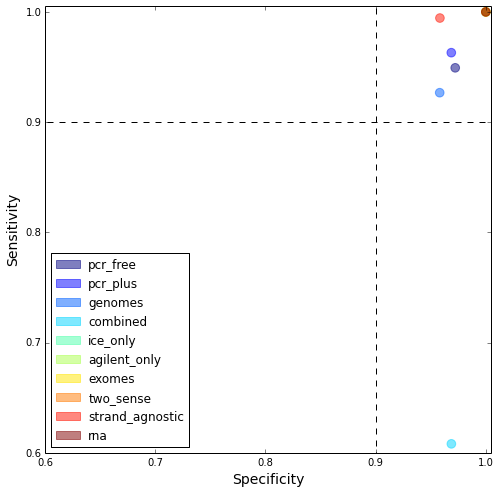

In [23]:
make_performance_figure("Exact Pairs Affinity", cleaned_sens, cleaned_spec)

In [24]:
make_performance_figure("Exact Pairs Affinity", no_opticals)

NameError: name 'no_opticals' is not defined

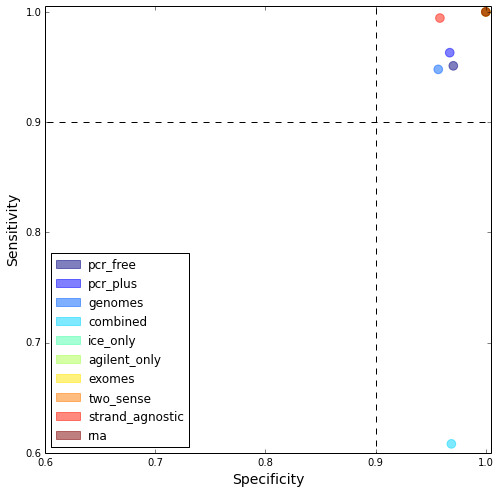

In [25]:
make_performance_figure("Exact Pairs Affinity", no_opticals_sens, no_opticals_spec)

In [ ]:
make_performance_figure("Exact Pairs Affinity", unfiltered)

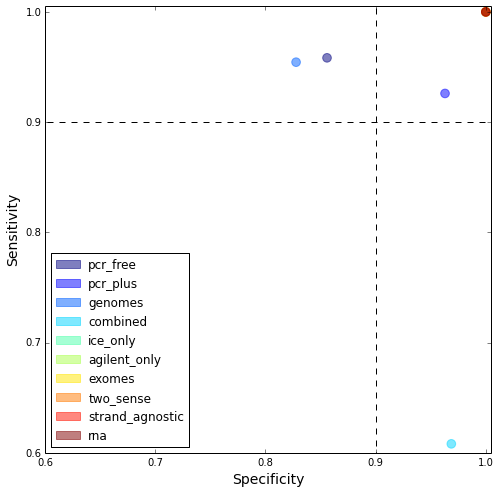

In [26]:
make_performance_figure("Exact Pairs Affinity", unfiltered_sens, unfiltered_spec)

In [22]:
def make_performance_figure(distance, LLR_sens, LLR_spec, title=None):
    fig = plt.figure(1, figsize=(8,8))
    plot1 = fig.gca()
    
#     print LLR_spec
    
    LLR_spec = pd.DataFrame(LLR_spec.loc[distance])
    LLR_sens = pd.DataFrame(LLR_sens.loc[distance])
    
#     LLR_spec = pd.DataFrame(data['LLR_p(different-library_|_truly_different-library)'].loc[distance])
#     LLR_sens = pd.DataFrame(data['LLR_p(same-library_|_truly_same-library)'].loc[distance])
#     LLR_rand = cleaned['LLR_rand_index']
    plot_scatter2(LLR_spec, LLR_sens, "Specificity", "Sensitivity", 0.6, 0.6, title, ax=plot1, draw_nineties=True, display_legend=True)


In [ ]:
LLR_sens

In [ ]:
pd.DataFrame(cleaned['LLR_p(same-library_|_truly_same-library)'])

In [21]:
import matplotlib.patches as mpatches
import matplotlib.markers as mk
import matplotlib.colors as mcl

def plot_scatter2(x_df, y_df, x_label, y_label, x_min, y_min, title=None, ax=None, draw_line=False, display_legend=False, draw_nineties=False):
    al = 0.5
    marker_size = 75
    font_size = 14
    
    if x_df.shape != y_df.shape:
        raise AssertionError("Attempting to create scatterplot from two dataframes with different shape")
    
    if ax is None:
        ax = plt.gca()
    
    rows = range(len(x_df.index))
    for i in xrange(len(x_df.columns)):
        dataset_key = x_df.columns[i]
        ax.scatter(x=x_df[dataset_key], y=y_df[dataset_key], c=rows, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', label=dataset_key, alpha=al)
    
    if draw_line:
        ax.plot([0,1.1], [0,1.1], c='k')
        
    if draw_nineties:
        ax.plot([0.9,0.9], [0, 1.1], c='k', linestyle='--')
        ax.plot([0, 1.1], [0.9,0.9], c='k', linestyle='--')

        
    ax.set_ylim(ymin=x_min, ymax=1.005)
    ax.set_xlim(xmin=y_min, xmax=1.005)
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    
    
    
    if title is not None:
        ax.set_title(title)
    
    if display_legend:
        # Set up an extra set of handles/labels within the legend, for the color key
        cmap = plt.cm.get_cmap()
        norm = mcl.Normalize(vmin=0,vmax=rows[-1])
        patches = []
        for i in rows:
            patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
        handles, labels = ax.get_legend_handles_labels()
#         new_handle = [handle for i,handle in enumerate(handles)]+patches
#         new_label = [label for i,label in enumerate(labels)]+[dist for dist in x_df.index]

        new_handle = patches
        new_label= [dist for dist in x_df.index]

        # display the legend
        ax.legend(new_handle, new_label, loc=3)
#         ax.legend(new_handle, new_label, ncol=2, bbox_to_anchor=(4.3,1.01))


    


In [118]:
cleaned_exp_false_diffs = cleaned['Expected_False-Diffs']
# display(cleaned_exp_false_diffs)
cleaned_expected_spec = pd.DataFrame(1 - cleaned_exp_false_diffs.values, index=cleaned_exp_false_diffs.index, columns=cleaned_exp_false_diffs.columns)


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.015127  0.069927  0.763347  0.843318   
Cosine Similarity         0.248601  0.474711  0.973659  0.588508   
Exact Pairs Affinity      0.018349  0.001518  0.006972  0.272450   
Five limited Affinity     0.176645  0.037723  0.247438  0.314531   
Four limited Affinity     0.109098  0.010972  0.016798  0.304602   
Jaccard Similarity Index  0.443656  0.247490  0.567813  0.428495   
Random Pairs Affinity     0.141793  0.008672  0.119839  0.356924   
Ten limited Affinity      0.482894  0.224500  0.683436  0.372715   
Three limited Affinity    0.109004  0.004612  0.008969  0.324447   

                              ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        6.113612e-05      0.009508  0.054031  4.112862e-10   
Cosine Similarity         4.153927e-34      0.094223  0.141826  1.229399e-03   
Exact Pairs Affinity      4.028389e-05      0.012487  0.053266  2.143303e-05   
Five limited Affinity     5.598122e-04      0.008374  0.052924  2.787605e-14   
Four limited Affinity     3.735936e-05      0.001024  0.054855  1.959359e-07   
Jaccard Similarity Index  6.722546e-06      0.043431  0.061758  1.000000e+00   
Random Pairs Affinity     1.138579e-03      0.010199  0.066711  3.241407e-02   
Ten limited Affinity      2.207671e-19      0.008750  0.050463  2.990118e-06   
Three limited Affinity    3.904937e-04      0.012721  0.018547  9.794177e-08   

                          strand_agnostic       rna  
All Pairs Affinity               0.003656  0.409231  
Cosine Similarity                0.015277  0.148487  
Exact Pairs Affinity             0.042451  0.017869  
Five limited Affinity            0.024272  0.028912  
Four limited Affinity            0.026095  0.026584  
Jaccard Similarity Index         0.002178  0.997450  
Random Pairs Affinity            0.029960  0.045338  
Ten limited Affinity             0.030225  0.038903  
Three limited Affinity           0.018424  0.025326

In [122]:
cleaned_exp_false_sames = cleaned['Expected_False-Sames']
display(cleaned_exp_false_sames)
cleaned_expected_sens = pd.DataFrame(1 - cleaned_exp_false_sames.values, index=cleaned_exp_false_sames.index, columns=cleaned_exp_false_sames.columns)
display(cleaned_expected_sens)

pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004   
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500   
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956   
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846   
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654   
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180   
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527   
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037   
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.366440e-11  1.110223e-16  1.236247e-02   
Cosine Similarity         4.440892e-16  1.312695e-04  9.958665e-02   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.003078e-06   
Five limited Affinity     1.110223e-16  1.110223e-16  2.177980e-04   
Four limited Affinity     1.110223e-16  1.110223e-16  7.095538e-05   
Jaccard Similarity Index  1.110223e-16  2.001824e-06  1.390329e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.768689e-04   
Ten limited Affinity      1.110223e-16  1.110223e-16  2.215789e-03   
Three limited Affinity    1.110223e-16  1.110223e-16  9.354998e-07   

                             two_sense  strand_agnostic       rna  
All Pairs Affinity        5.567856e-03         1.000000  0.031561  
Cosine Similarity         1.109314e-02         0.994135  0.119183  
Exact Pairs Affinity      1.110223e-16         0.036890  0.087032  
Five limited Affinity     1.110223e-16         0.973950  0.160229  
Four limited Affinity     1.110223e-16         0.079513  0.141245  
Jaccard Similarity Index  4.131795e-11         0.998055  0.010818  
Random Pairs Affinity     1.110223e-16         0.984041  0.104591  
Ten limited Affinity      1.110223e-16         0.987629  0.198231  
Three limited Affinity    1.110223e-16         0.955660  0.038310

pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.999149  0.969584  0.994556  0.999996       1.0   
Cosine Similarity         0.030279  0.999365  1.000000  0.911500       1.0   
Exact Pairs Affinity      0.978594  0.985230  0.954362  0.986044       1.0   
Five limited Affinity     0.828502  0.955062  0.980155  0.982154       1.0   
Four limited Affinity     0.850104  0.954108  0.724236  0.983346       1.0   
Jaccard Similarity Index  0.973099  1.000000  0.984684  0.773820       1.0   
Random Pairs Affinity     0.946185  0.967336  0.989682  0.995473       1.0   
Ten limited Affinity      0.852097  0.944670  0.983969  0.989963       1.0   
Three limited Affinity    0.935662  0.965920  0.830127  0.992919       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  0.987638   0.994432     1.066288e-07   
Cosine Similarity             0.999869  0.900413   0.988907     5.864884e-03   
Exact Pairs Affinity          1.000000  0.999999   1.000000     9.631102e-01   
Five limited Affinity         1.000000  0.999782   1.000000     2.605040e-02   
Four limited Affinity         1.000000  0.999929   1.000000     9.204865e-01   
Jaccard Similarity Index      0.999998  0.860967   1.000000     1.944716e-03   
Random Pairs Affinity         1.000000  0.999823   1.000000     1.595908e-02   
Ten limited Affinity          1.000000  0.997784   1.000000     1.237071e-02   
Three limited Affinity        1.000000  0.999999   1.000000     4.434046e-02   

                               rna  
All Pairs Affinity        0.968439  
Cosine Similarity         0.880817  
Exact Pairs Affinity      0.912968  
Five limited Affinity     0.839771  
Four limited Affinity     0.858755  
Jaccard Similarity Index  0.989182  
Random Pairs Affinity     0.895409  
Ten limited Affinity      0.801769  
Three limited Affinity    0.961690

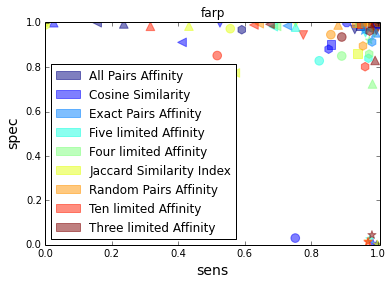

In [136]:
# ax=plt.gca()
# y_df = cleaned_expected_sens
# x_df = cleaned_expected_spec


# marker_size=75
# al=0.5
# ax.scatter(x=x_df, y=y_df, c=rows, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', label='farp', alpha=al)
plot_scatter2(cleaned_expected_spec, cleaned_expected_sens, "sens", 'spec', 0, 0, 'farp', display_legend=True)

In [138]:
cleaned_expected_sens["pcr_free"]

All Pairs Affinity          0.999149
Cosine Similarity           0.030279
Exact Pairs Affinity        0.978594
Five limited Affinity       0.828502
Four limited Affinity       0.850104
Jaccard Similarity Index    0.973099
Random Pairs Affinity       0.946185
Ten limited Affinity        0.852097
Three limited Affinity      0.935662
Name: pcr_free, dtype: float64

In [172]:
def expected_fails_to_successses(expected_fails):
    return pd.DataFrame(1 - expected_fails.values, index=expected_fails.index, columns=expected_fails.columns)

In [173]:
cleaned_exp_sens=expected_fails_to_successses(cleaned['Expected_False-Sames'])
no_opticals_exp_sens=expected_fails_to_successses(no_opticals['Expected_False-Sames'])
unfiltered_exp_sens=expected_fails_to_successses(unfiltered['Expected_False-Sames'])

NameError: name 'cleaned' is not defined

In [177]:
cleaned_exp_fals_same = pd.DataFrame.from_csv('feb_Expected_False-Sames_evaluation.csv')
cleaned_exp_sens=expected_fails_to_successses(pd.DataFrame.from_csv('feb_Expected_False-Sames_evaluation.csv'))

In [187]:
cleaned_exp_sens=expected_fails_to_successses(pd.DataFrame.from_csv('feb_Expected_False-Sames_evaluation.csv'))
unfiltered_exp_sens=expected_fails_to_successses(pd.DataFrame.from_csv('noF_Expected_False-Sames_evaluation.csv'))
no_opticals_exp_sens=expected_fails_to_successses(pd.DataFrame.from_csv('optNo_Expected_False-Sames_evaluation.csv'))

In [188]:
cleaned_exp_spec=expected_fails_to_successses(pd.DataFrame.from_csv('feb_Expected_False-Diffs_evaluation.csv'))
unfiltered_exp_spec=expected_fails_to_successses(pd.DataFrame.from_csv('noF_Expected_False-Diffs_evaluation.csv'))
no_opticals_exp_spec=expected_fails_to_successses(pd.DataFrame.from_csv('optNo_Expected_False-Diffs_evaluation.csv'))

In [178]:
display(cleaned_exp_fals_same)
display(cleaned_exp_sens)

pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004   
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500   
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956   
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846   
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654   
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180   
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527   
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037   
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.366440e-11  1.110223e-16  1.236247e-02   
Cosine Similarity         4.440892e-16  1.312695e-04  9.958665e-02   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.003078e-06   
Five limited Affinity     1.110223e-16  1.110223e-16  2.177980e-04   
Four limited Affinity     1.110223e-16  1.110223e-16  7.095538e-05   
Jaccard Similarity Index  1.110223e-16  2.001824e-06  1.390329e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.768689e-04   
Ten limited Affinity      1.110223e-16  1.110223e-16  2.215789e-03   
Three limited Affinity    1.110223e-16  1.110223e-16  9.354998e-07   

                             two_sense  strand_agnostic       rna  
All Pairs Affinity        5.567856e-03         1.000000  0.031561  
Cosine Similarity         1.109314e-02         0.994135  0.119183  
Exact Pairs Affinity      1.110223e-16         0.036890  0.087032  
Five limited Affinity     1.110223e-16         0.973950  0.160229  
Four limited Affinity     1.110223e-16         0.079513  0.141245  
Jaccard Similarity Index  4.131795e-11         0.998055  0.010818  
Random Pairs Affinity     1.110223e-16         0.984041  0.104591  
Ten limited Affinity      1.110223e-16         0.987629  0.198231  
Three limited Affinity    1.110223e-16         0.955660  0.038310

pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.999149  0.969584  0.994556  0.999996       1.0   
Cosine Similarity         0.030279  0.999365  1.000000  0.911500       1.0   
Exact Pairs Affinity      0.978594  0.985230  0.954362  0.986044       1.0   
Five limited Affinity     0.828502  0.955062  0.980155  0.982154       1.0   
Four limited Affinity     0.850104  0.954108  0.724236  0.983346       1.0   
Jaccard Similarity Index  0.973099  1.000000  0.984684  0.773820       1.0   
Random Pairs Affinity     0.946185  0.967336  0.989682  0.995473       1.0   
Ten limited Affinity      0.852097  0.944670  0.983969  0.989963       1.0   
Three limited Affinity    0.935662  0.965920  0.830127  0.992919       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  0.987638   0.994432     1.066290e-07   
Cosine Similarity             0.999869  0.900413   0.988907     5.864884e-03   
Exact Pairs Affinity          1.000000  0.999999   1.000000     9.631102e-01   
Five limited Affinity         1.000000  0.999782   1.000000     2.605040e-02   
Four limited Affinity         1.000000  0.999929   1.000000     9.204865e-01   
Jaccard Similarity Index      0.999998  0.860967   1.000000     1.944716e-03   
Random Pairs Affinity         1.000000  0.999823   1.000000     1.595908e-02   
Ten limited Affinity          1.000000  0.997784   1.000000     1.237071e-02   
Three limited Affinity        1.000000  0.999999   1.000000     4.434046e-02   

                               rna  
All Pairs Affinity        0.968439  
Cosine Similarity         0.880817  
Exact Pairs Affinity      0.912968  
Five limited Affinity     0.839771  
Four limited Affinity     0.858755  
Jaccard Similarity Index  0.989182  
Random Pairs Affinity     0.895409  
Ten limited Affinity      0.801769  
Three limited Affinity    0.961690

In [146]:
x_val = np.zeros(len(cleaned_exp_sens.index))

In [206]:
def box_plot_a_dataset(left, middle, right, dset, labels, ax=None):

    rows = range(len(cleaned_exp_sens.index))
#     print rows

    if ax is None:
        ax= plt.gca()
    # ax.scatter(x=x_val, y=unfiltered_exp_sens["pcr_free"], c=rows)
    # ax.scatter(x=x_val+1, y=no_opticals_exp_sens["pcr_free"], c=rows)
    # ax.scatter(x=x_val+2, y=cleaned_exp_sens["pcr_free"], c=rows)

    bp = ax.boxplot([left[dset], middle[dset], right[dset]])
    ax.set_xticklabels(labels)
    ax.set_title(dset)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
    #     box.set( facecolor = '#1b9e77' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

In [204]:
labs = ['Unfiltered', 'Filtered', '', 'No Opticals']

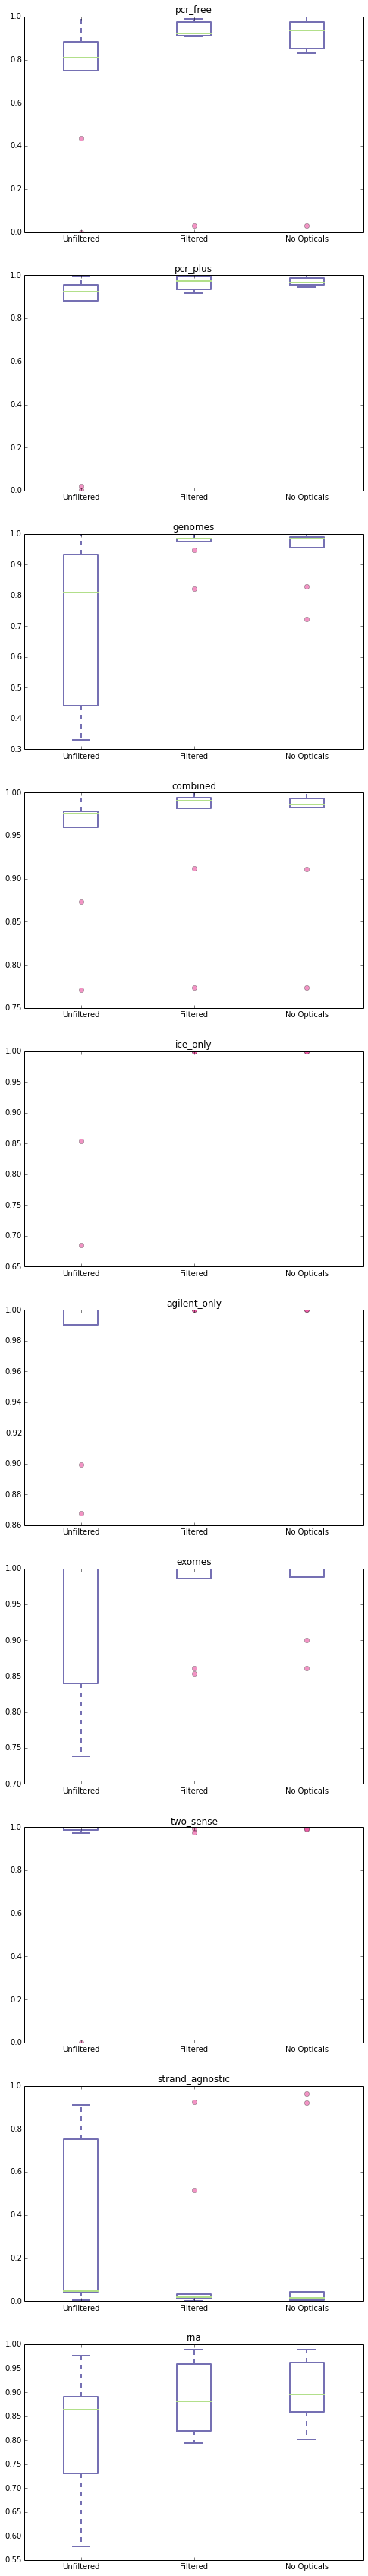

In [236]:
datasets = unfiltered_exp_sens.columns

n_subfigs = len(datasets)
# print n_subfigs
fig = plt.figure(figsize=(8, 6*n_subfigs))

i=0
for dset in datasets:
    i += 1
    sub= fig.add_subplot(n_subfigs, 1, i)
#     print dset

    box_plot_a_dataset(unfiltered_exp_sens, no_opticals_exp_sens, cleaned_exp_sens, dset, labs, ax=sub)

[[0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 5, 5, 5, 5, 5, 5, 5, 5], [6, 6, 6, 6, 6, 6, 6, 6, 6], [7, 7, 7, 7, 7, 7, 7, 7, 7], [8, 8, 8, 8, 8, 8, 8, 8, 8], [9, 9, 9, 9, 9, 9, 9, 9, 9]]


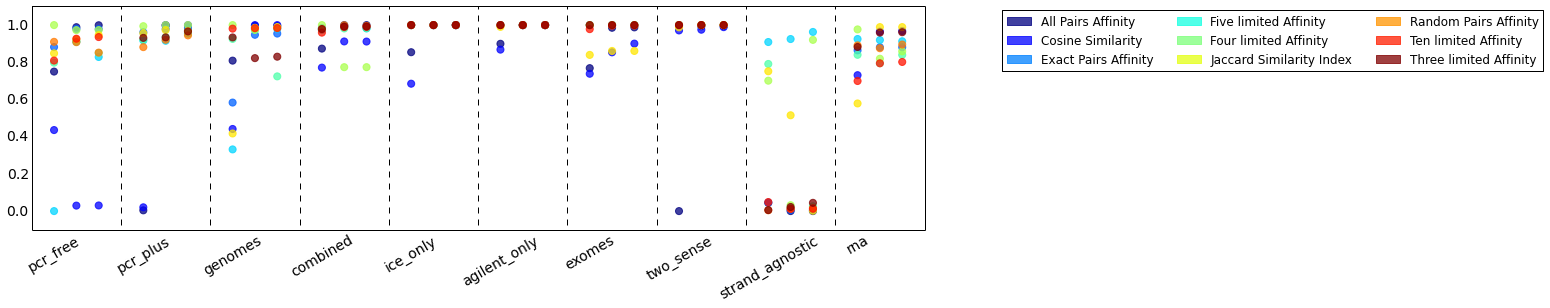

In [382]:
unfiltered_exp_sens.shape

unf = unfiltered_exp_sens
fil = no_opticals_exp_sens
cln = cleaned_exp_sens

marker_size=50
al=.75

offset= 4

datasets = unf.columns
n_subfigs = len(datasets)
dividers = np.arange(0,(n_subfigs*offset),offset)

unf_offsets = dividers + 1
unf_x = [unf_offsets] * len(unf.index)

fil_offsets = dividers + 2
fil_x = [fil_offsets] * len(fil.index)

cln_offsets = dividers + 3
cln_x = [cln_offsets] * len(cln.index)

fig=plt.figure(figsize=(16,4))
ax=plt.gca()

y_s = [[i]*len(unf.index) for i in range(len(datasets))]
print y_s


ax.set_xlim(0, (n_subfigs*offset))
ax.scatter(x=unf_x, y=unf, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)
ax.scatter(x=fil_x, y=fil, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)
ax.scatter(x=cln_x, y=cln, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)

# print ax.get_ylim()
ax.set_ylim((-0.10000000000000001, 1.1000000000000002))

# ax.set_xticks(np.arange(0, n_subfigs, 5))
ax.set_xticks(unf_offsets)

# xlab = []
# for dset in datasets:
#     xlab += ["",dset,"",""]
# print xlab
ax.set_xticklabels(datasets, rotation=30)

font_size=14
ax.tick_params(which='major', color='w', labelsize=font_size)


for x_thing in dividers:
    ax.plot([x_thing,x_thing], [-1, 2], c='k', linestyle='--')

    
#   if display_legend:
# Set up an extra set of handles/labels within the legend, for the color key
cmap = plt.cm.get_cmap()
norm = mcl.Normalize(vmin=0,vmax=rows[-1])
patches = []
for i in range(len(unf.index)):
    patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
handles, labels = ax.get_legend_handles_labels()
new_handle = [handle for i,handle in enumerate(handles)]+patches
new_label = [label for i,label in enumerate(labels)]+[dist for dist in unf.index]

# display the legend
#         ax.legend(new_handle, new_label, loc=3)
# ax.legend(new_handle, new_label, ncol=1, bbox_to_anchor=(4.3,1.01))
# ax.legend(new_handle, new_label, ncol=1, loc=3)

ax.legend(new_handle, new_label, ncol=3, bbox_to_anchor=(1.7,1.01))

# ax.legend()

In [333]:
fil_offsets

array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38])

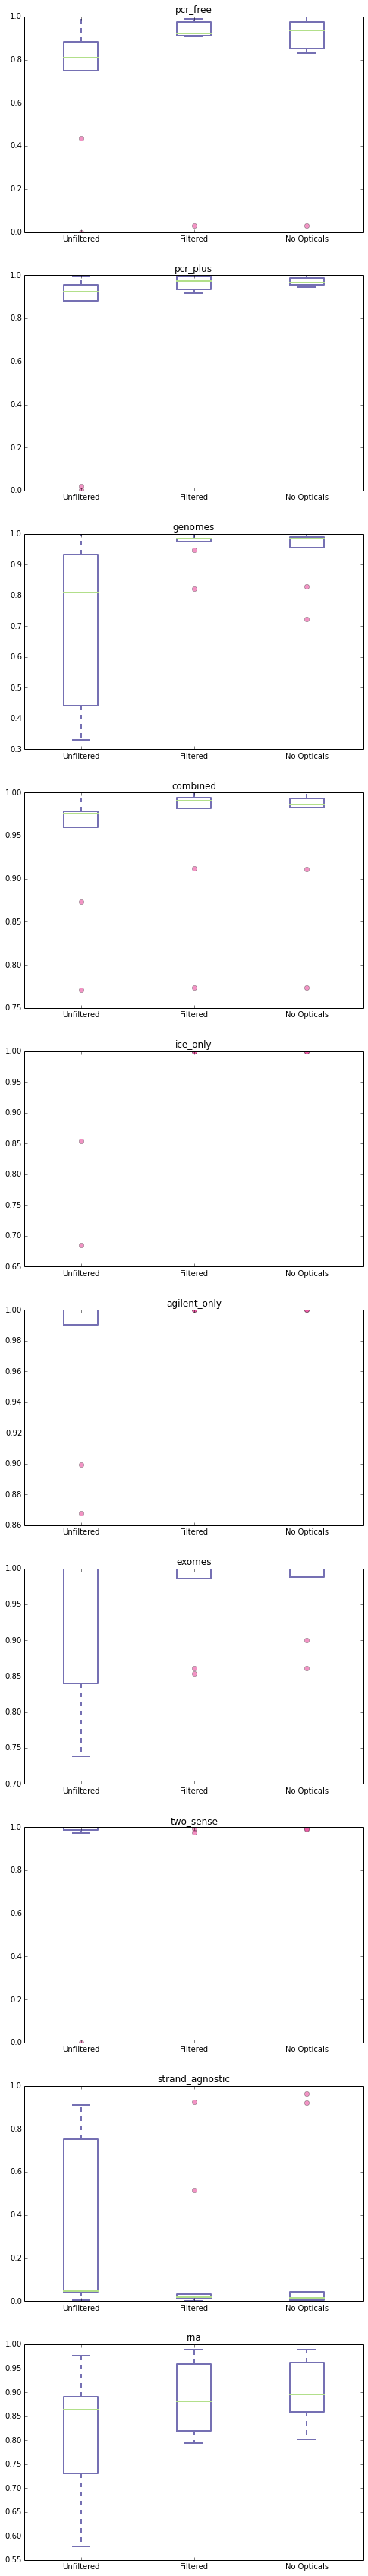

In [207]:
datasets = unfiltered_exp_sens.columns

n_subfigs = len(datasets)
# print n_subfigs
fig = plt.figure(figsize=(8, 6*n_subfigs))

i=0
for dset in datasets:
    i += 1
    sub= fig.add_subplot(n_subfigs, 1, i)
#     print dset

    box_plot_a_dataset(unfiltered_exp_sens, no_opticals_exp_sens, cleaned_exp_sens, dset, labs, ax=sub)

Index([u'All Pairs Affinity', u'Cosine Similarity', u'Exact Pairs Affinity',
       u'Five limited Affinity', u'Four limited Affinity',
       u'Jaccard Similarity Index', u'Random Pairs Affinity',
       u'Ten limited Affinity', u'Three limited Affinity'],
      dtype='object')


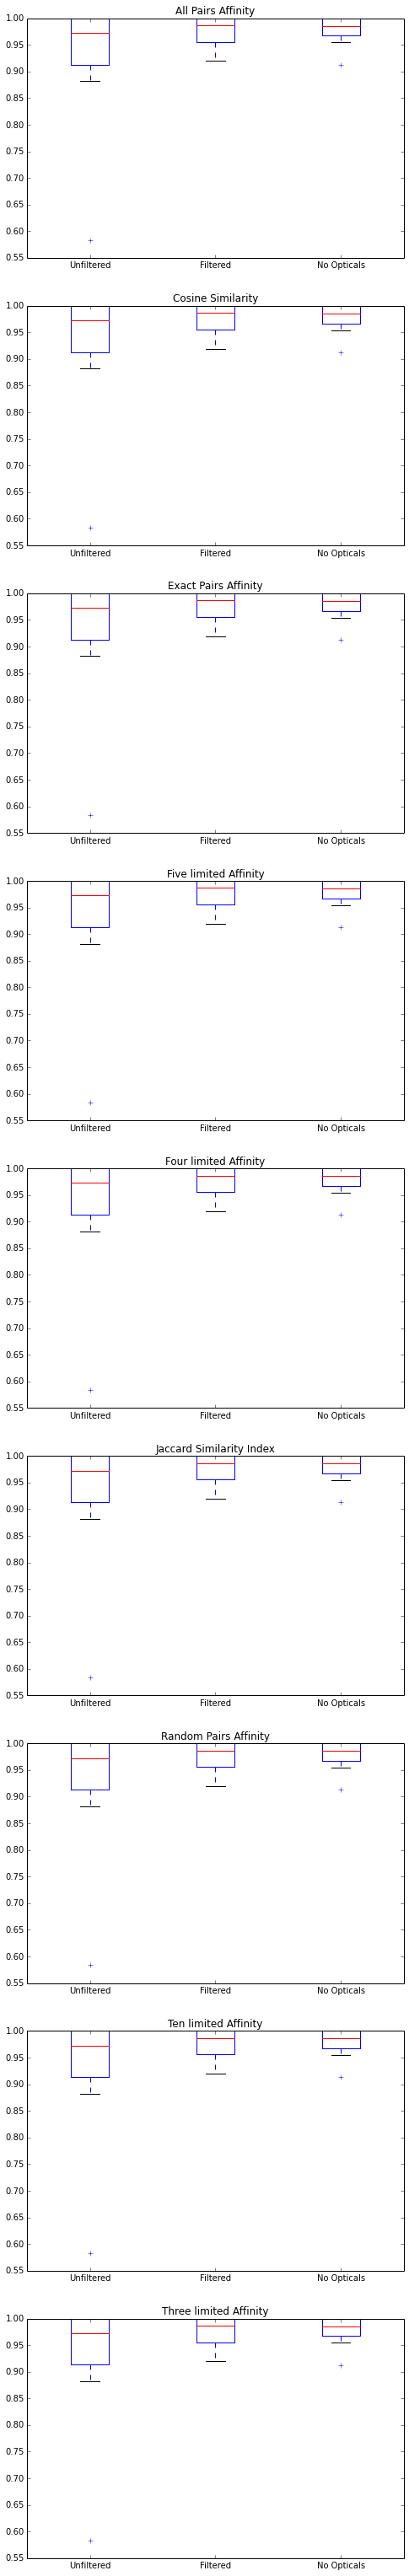

In [208]:
metrics = cleaned_exp_sens.index
print metrics

fig = plt.figure(figsize=(8, 6*len(metrics)))

i=0
for metric in metrics:
    i += 1
    ax=fig.add_subplot(len(metrics), 1, i)
    
    noF = pd.DataFrame(unfiltered_exp_sens.loc['Exact Pairs Affinity'])
    optNo = pd.DataFrame(no_opticals_exp_sens.loc['Exact Pairs Affinity'])
    cl = pd.DataFrame(cleaned_exp_sens.loc['Exact Pairs Affinity'])

    # display(noF)
    # display(optNo)
    # display(cl)

    ax= plt.gca()
        # ax.scatter(x=x_val, y=unfiltered_exp_sens["pcr_free"], c=rows)
        # ax.scatter(x=x_val+1, y=no_opticals_exp_sens["pcr_free"], c=rows)
        # ax.scatter(x=x_val+2, y=cleaned_exp_sens["pcr_free"], c=rows)

    bp = ax.boxplot([noF, optNo, cl])
    ax.set_xticklabels(labs)
    ax.set_title(metric)
#     ax.set_ylim(0.8,1)

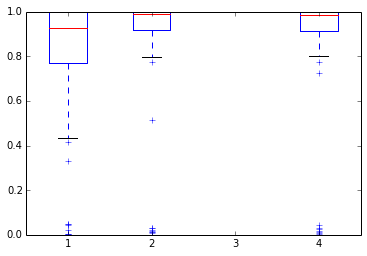

In [237]:
ax = plt.gca()
bp = ax.boxplot([unfiltered_exp_sens, no_opticals_exp_sens, [], cleaned_exp_sens])


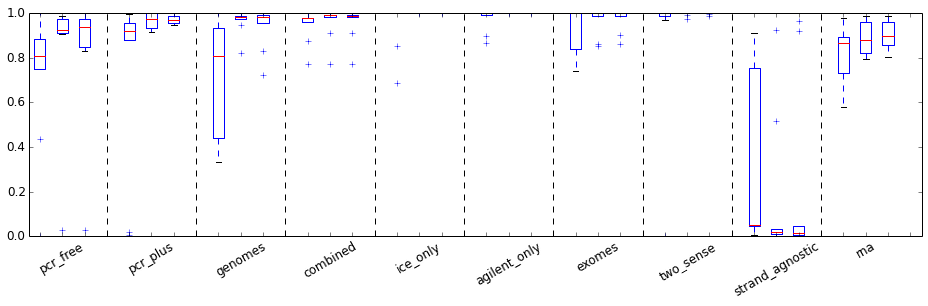

In [311]:

unfiltered_exp_sens.shape

unf = unfiltered_exp_sens
fil = no_opticals_exp_sens
cln = cleaned_exp_sens

datasets = unf.columns
n_subfigs = len(datasets)
dividers = np.arange(0,(n_subfigs*6),6)

fig = plt.figure(figsize=(16,4))
ax=plt.gca()

# datasets=['pcr_free', 'pcr_plus']
full=[]
xlabs = []
for dset in datasets:
    unf = unfiltered_exp_sens[dset]
    fil = no_opticals_exp_sens[dset]
    cln = cleaned_exp_sens[dset]
    fullset = [unf, fil, cln, []]
    xlab = ["",dset,"",""]
    full += fullset
    xlabs += xlab
 
bp = ax.boxplot(full)

ax.set_ylim((0.0, 1.0))

dividers = np.arange(0,4*len(datasets),4)
for x_thing in dividers:
    ax.plot([x_thing,x_thing], [0, 1.1], c='k', linestyle='--')

ax.set_xticklabels(xlabs, rotation=30)

font_size=12
# ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)

print

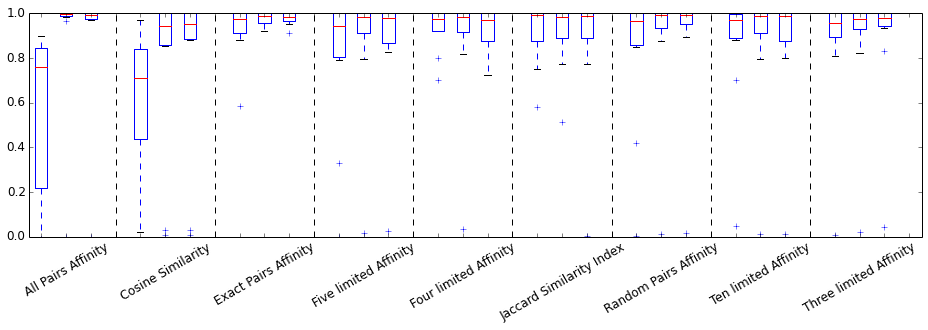

In [308]:

unfiltered_exp_sens.shape

unf = unfiltered_exp_sens.T
fil = no_opticals_exp_sens.T
cln = cleaned_exp_sens.T

datasets = unf.columns
n_subfigs = len(datasets)
dividers = np.arange(0,(n_subfigs*6),6)

fig = plt.figure(figsize=(16,4))
ax=plt.gca()

# datasets=['pcr_free', 'pcr_plus']
full=[]
xlabs = []
for dset in datasets:
#     print dset
    unfY = unf[dset]
#     print unfY
    filY = fil[dset]
    clnY = cln[dset]
    fullset = [unfY, filY, clnY, []]
    xlab = ["",dset,"",""]
    full += fullset
    xlabs += xlab
 
bp = ax.boxplot(full)

ax.set_ylim((0.0, 1.0))

dividers = np.arange(0,4*len(datasets),4)
for x_thing in dividers:
    ax.plot([x_thing,x_thing], [0, 1.1], c='k', linestyle='--')

ax.set_xticklabels(xlabs, rotation=30)

font_size=12
# ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)
print


In [297]:
8*4

32

In [ ]:
LLR_spec

In [ ]:
fig = plt.figure(1, figsize=(8,6))
plot_scatter(metrics["LLR_specificity"], metrics["LLR_sensitivity"], "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True)


In [ ]:
for key, value in metrics.iteritems():
    metrics[key] = metrics[key].sort_index()

In [ ]:
noOpticalDups = all_sets(["ice_only"], "noF")

In [ ]:
fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["LLR_sensitivity"], "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True)
plot_scatter(metrics["Cluster_specificity"], metrics["Cluster_sensitivity"], "Specificity", "Sensitivity", "Distance Clustering Performance by Dataset", ax=plot2)
plot_scatter(metrics["ratio_cluster_specificity"], metrics["ratio_cluster_sensitivity"], "Specificity", "Sensitivity", "Ratio Clustering Performance by Dataset", ax=plot3)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["Cluster_specificity"], "Pairwise Specificity", "Clustering Specificity", "Pairwise vs Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_specificity"], metrics["ratio_cluster_specificity"], "Pairwise Specificity", "Ratio Clustering Specificity", "Pairwise vs Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_specificity"], metrics["ratio_cluster_specificity"], "Clustering Specificity", "Ratio Clustering Specificity", "Clustering vs Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "LLR Pairwise Sensitivity", "Clustering Sensitivity", "LLR Pairwise vs Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_sensitivity"], metrics["ratio_cluster_sensitivity"], "LLR Pairwise Sensitivity", "Ratio Clustering Sensitivity", "LLR Pairwise vs Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_sensitivity"], metrics["ratio_cluster_sensitivity"], "Cluster Sensitivity", "Ratio Clustering Sensitivity", "Clustering vs Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [ ]:
distances = metrics["LLR_specificity"].index
print len(metrics)
print len(distances)
n_distances = len(distances)
fig = plt.figure(figsize=(24, 6*n_distances))
for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
    distance = distances[i]
    Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
    Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T
    
    Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
    Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T
    
    LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
    LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T
    
    # Get the appropriate axes
    plot_columns = 3
    cell_adjustment = i * plot_columns
    L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
    C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
    LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))
    
    # Only display the legend once
    doLegend = (i==0)
    
    plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
    plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
    plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)




In [ ]:
distance = u'Exact Pairs Affinity'

Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T

Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T


fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True, draw_nineties=True)
plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Similarity Clustering Performance by Dataset", ax=plot2, draw_nineties=True)
plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Likelihood Ratio Clustering Performance by Dataset", ax=plot3, draw_nineties=True)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(Lsp, Csp, "LLR Pairwise Specificity", "Similarity Clustering Specificity", "LLR Pairwise vs Similarity Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=False)
plot_scatter(Lsp, LCsp, "LLR Pairwise Specificity", "Likelihood Ratio Clustering Specificity", "LLR Pairwise vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(Csp, LCsp, "Similarity Clustering Specificity", "Likelihood Ratio Clustering Specificity", "Similarity Clustering vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(Lse, Cse, "LLR Pairwise Sensitivity", "Similarity Clustering Sensitivity", "LLR Pairwise vs Similarity Score Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=False)
plot_scatter(Lse, LCse, "LLR Pairwise Sensitivity", "Likelihood Ratio Clustering Sensitivity", "LLR Pairwise vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(Cse, LCse, "Similarity Clustering Sensitivity", "Likelihood Ratio Clustering Sensitivity", "Similarity Clustering vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [31]:
cleaned_sens.T

All Pairs Affinity  Cosine Similarity  Exact Pairs Affinity  \
pcr_free                   1.000000           0.500000              0.949275   
pcr_plus                   0.890533           0.519231              0.963018   
genomes                    0.414495           0.226384              0.926710   
combined                   0.223188           0.271884              0.608116   
ice_only                   1.000000           1.000000              1.000000   
agilent_only               1.000000           0.991124              1.000000   
exomes                     1.000000           0.831034              1.000000   
two_sense                  1.000000           1.000000              1.000000   
strand_agnostic            0.644444           0.363889              0.994444   
rna                        0.692964           0.938166              1.000000   

                 Five limited Affinity  Four limited Affinity  \
pcr_free                      0.878623               0.918478   
pcr_plus                      0.924556               0.942308   
genomes                       0.864821               0.938111   
combined                      0.608116               0.608116   
ice_only                      1.000000               1.000000   
agilent_only                  1.000000               1.000000   
exomes                        1.000000               1.000000   
two_sense                     1.000000               1.000000   
strand_agnostic               0.922222               0.922222   
rna                           0.985075               0.995736   

                 Jaccard Similarity Index  Random Pairs Affinity  \
pcr_free                         0.550725               0.916667   
pcr_plus                         0.899408               0.949704   
genomes                          0.726384               0.935668   
combined                         0.440580               0.605217   
ice_only                         1.000000               1.000000   
agilent_only                     0.991124               1.000000   
exomes                           0.917241               1.000000   
two_sense                        1.000000               1.000000   
strand_agnostic                  0.666667               0.905556   
rna                              0.940299               0.948827   

                 Ten limited Affinity  Three limited Affinity  
pcr_free                     0.652174                0.931159  
pcr_plus                     0.920118                0.963018  
genomes                      0.441368                0.937296  
combined                     0.597681                0.608116  
ice_only                     1.000000                1.000000  
agilent_only                 1.000000                1.000000  
exomes                       1.000000                1.000000  
two_sense                    1.000000                1.000000  
strand_agnostic              0.886111                0.994444  
rna                          0.940299                0.995736

Index([u'All Pairs Affinity', u'Cosine Similarity', u'Exact Pairs Affinity',
       u'Five limited Affinity', u'Four limited Affinity',
       u'Jaccard Similarity Index', u'Random Pairs Affinity',
       u'Ten limited Affinity', u'Three limited Affinity'],
      dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7, 8]
y TICKS


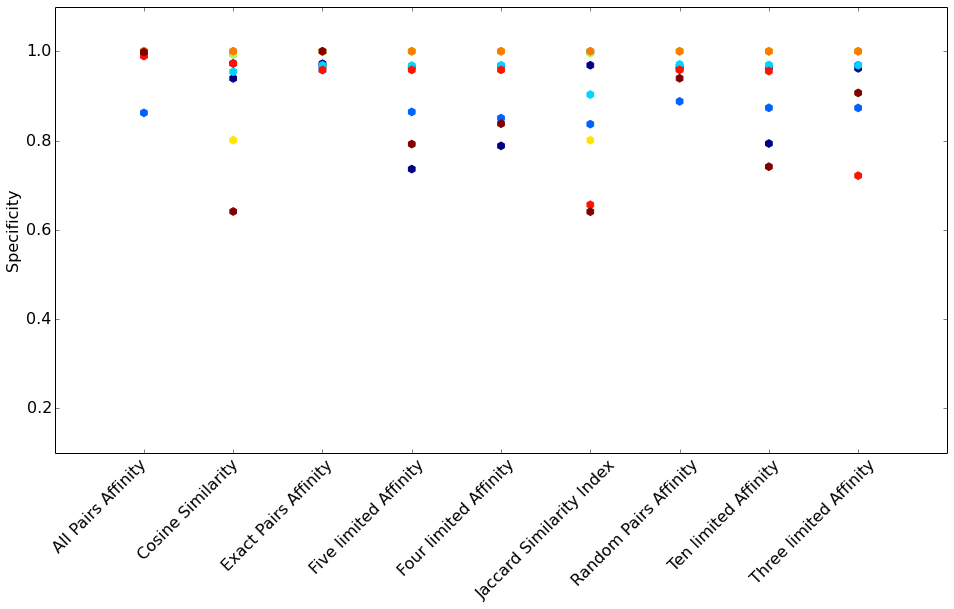

In [169]:
# cl = cleaned_sens.T
# ylab = 'Sensitivity'

cl = cleaned_spec.T
ylab = 'Specificity'

fig = plt.figure(figsize=(16,8))

metrics = cl.columns
sets = cl.index

x=np.arange(len(metrics))

al = 1
marker_size=60

print metrics

x_vals = range(len(metrics))
x_s = [x_vals for i in range(len(sets))]

y_s = [[i]*len(metrics) for i in range(len(sets))]

ax = plt.gca()
ax.scatter(x=x_s, y=cl, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)

print x_vals

ax.set_xticks(x)
ax.set_xticklabels([])
# Minor ticks
ax.set_xticks(x-0.5, minor=True)
ax.set_xticklabels(metrics, rotation=45, minor=True)

font_size=16
ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)


print 'y TICKS'
# print ax.get_yticks()
# print ax.get_ylim()


ax.set_yticks(np.arange(0,1.4,0.2))
ax.set_ylim((0.10000000000000001, 1.1000000000000001))

ax.set_ylabel(ylab, fontsize=font_size)
# ax.legend()

#  if display_legend:
# Set up an extra set of handles/labels within the legend, for the color key
cmap = plt.cm.get_cmap()
norm = mcl.Normalize(vmin=0,vmax=rows[-1])
patches = []
for i in range(len(sets)):
    patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
handles, labels = ax.get_legend_handles_labels()
new_handle = [handle for i,handle in enumerate(handles)]+patches
new_label = [label for i,label in enumerate(labels)]+[dist for dist in sets]

# display the legend
#         ax.legend(new_handle, new_label, loc=3)
# ax.legend(new_handle, new_label, ncol=1, bbox_to_anchor=(4.3,1.01))
# ax.legend(new_handle, new_label, ncol=1, loc=3)

# ax.legend(new_handle, new_label, ncol=3, bbox_to_anchor=(2.3,1.01))


Index([u'All Pairs Affinity', u'Cosine Similarity', u'Exact Pairs Affinity',
       u'Five limited Affinity', u'Four limited Affinity',
       u'Jaccard Similarity Index', u'Random Pairs Affinity',
       u'Ten limited Affinity', u'Three limited Affinity'],
      dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7, 8]
y TICKS


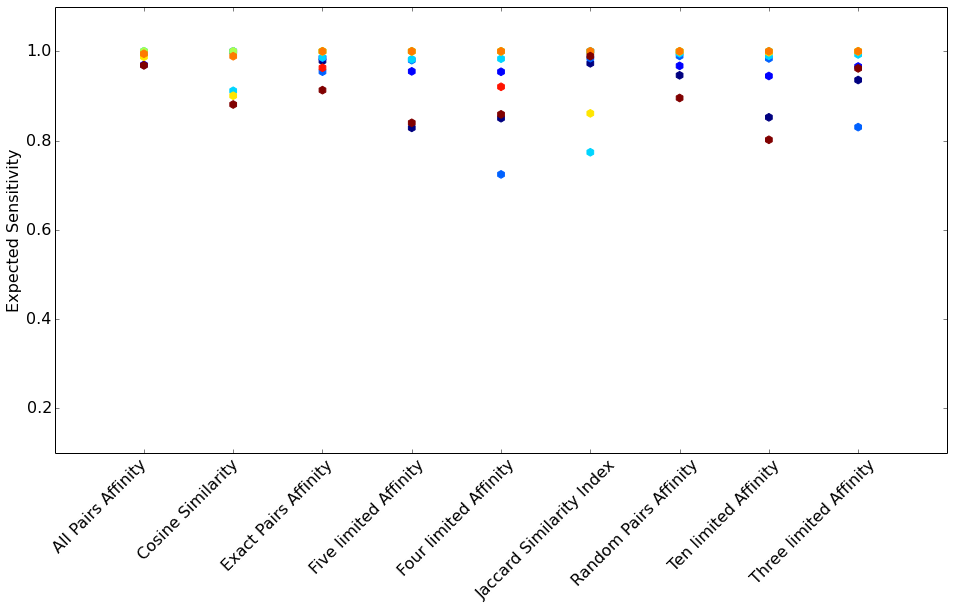

In [195]:
cl = cleaned_exp_sens.T
ylab = 'Expected Sensitivity'

# cl = cleaned_exp_spec.T
# ylab = 'Expected Specificity'

fig = plt.figure(figsize=(16,8))

metrics = cl.columns
sets = cl.index

x=np.arange(len(metrics))

al = 1
marker_size=60

print metrics

x_vals = range(len(metrics))
x_s = [x_vals for i in range(len(sets))]

y_s = [[i]*len(metrics) for i in range(len(sets))]

ax = plt.gca()
ax.scatter(x=x_s, y=cl, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)

print x_vals

ax.set_xticks(x)
ax.set_xticklabels([])
# Minor ticks
ax.set_xticks(x-0.5, minor=True)
ax.set_xticklabels(metrics, rotation=45, minor=True)

font_size=16
ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)


print 'y TICKS'
# print ax.get_yticks()
# print ax.get_ylim()


ax.set_yticks(np.arange(0,1.4,0.2))
ax.set_ylim((0.10000000000000001, 1.1000000000000001))

ax.set_ylabel(ylab, fontsize=font_size)
# ax.legend()

#  if display_legend:
# Set up an extra set of handles/labels within the legend, for the color key
cmap = plt.cm.get_cmap()
norm = mcl.Normalize(vmin=0,vmax=rows[-1])
patches = []
for i in range(len(sets)):
    patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
handles, labels = ax.get_legend_handles_labels()
new_handle = [handle for i,handle in enumerate(handles)]+patches
new_label = [label for i,label in enumerate(labels)]+[dist for dist in sets]

# display the legend
#         ax.legend(new_handle, new_label, loc=3)
# ax.legend(new_handle, new_label, ncol=1, bbox_to_anchor=(4.3,1.01))
# ax.legend(new_handle, new_label, ncol=1, loc=3)

# ax.legend(new_handle, new_label, ncol=3, bbox_to_anchor=(2.3,1.01))


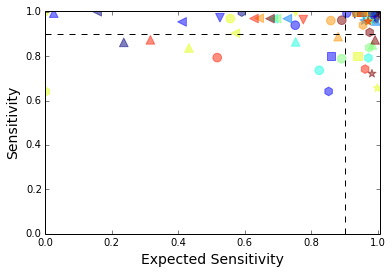

In [202]:
plot_scatter2(cleaned_exp_spec, cleaned_spec, "Expected Sensitivity", "Sensitivity", 0, 0, None, ax=plt.gca(), draw_nineties=True, display_legend=False)


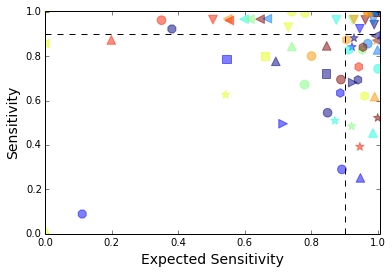

In [201]:
plot_scatter2(unfiltered_exp_spec, unfiltered_spec, "Expected Sensitivity", "Sensitivity", 0, 0, None, ax=plt.gca(), draw_nineties=True, display_legend=False)


In [199]:
cleaned_exp_sens

pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.999149  0.969584  0.994556  0.999996       1.0   
Cosine Similarity         0.030279  0.999365  1.000000  0.911500       1.0   
Exact Pairs Affinity      0.978594  0.985230  0.954362  0.986044       1.0   
Five limited Affinity     0.828502  0.955062  0.980155  0.982154       1.0   
Four limited Affinity     0.850104  0.954108  0.724236  0.983346       1.0   
Jaccard Similarity Index  0.973099  1.000000  0.984684  0.773820       1.0   
Random Pairs Affinity     0.946185  0.967336  0.989682  0.995473       1.0   
Ten limited Affinity      0.852097  0.944670  0.983969  0.989963       1.0   
Three limited Affinity    0.935662  0.965920  0.830127  0.992919       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  0.987638   0.994432     1.066290e-07   
Cosine Similarity             0.999869  0.900413   0.988907     5.864884e-03   
Exact Pairs Affinity          1.000000  0.999999   1.000000     9.631102e-01   
Five limited Affinity         1.000000  0.999782   1.000000     2.605040e-02   
Four limited Affinity         1.000000  0.999929   1.000000     9.204865e-01   
Jaccard Similarity Index      0.999998  0.860967   1.000000     1.944716e-03   
Random Pairs Affinity         1.000000  0.999823   1.000000     1.595908e-02   
Ten limited Affinity          1.000000  0.997784   1.000000     1.237071e-02   
Three limited Affinity        1.000000  0.999999   1.000000     4.434046e-02   

                               rna  
All Pairs Affinity        0.968439  
Cosine Similarity         0.880817  
Exact Pairs Affinity      0.912968  
Five limited Affinity     0.839771  
Four limited Affinity     0.858755  
Jaccard Similarity Index  0.989182  
Random Pairs Affinity     0.895409  
Ten limited Affinity      0.801769  
Three limited Affinity    0.961690

In [190]:
print cl.columns
print 
print cl.index

display(cl)

Index([u'All Pairs Affinity', u'Cosine Similarity', u'Exact Pairs Affinity',
       u'Five limited Affinity', u'Four limited Affinity',
       u'Jaccard Similarity Index', u'Random Pairs Affinity',
       u'Ten limited Affinity', u'Three limited Affinity'],
      dtype='object')

Index([u'pcr_free', u'pcr_plus', u'genomes', u'combined', u'ice_only',
       u'agilent_only', u'exomes', u'two_sense', u'strand_agnostic', u'rna'],
      dtype='object')


All Pairs Affinity  Cosine Similarity  Exact Pairs Affinity  \
pcr_free                   0.984873           0.751399              0.981651   
pcr_plus                   0.930073           0.525289              0.998482   
genomes                    0.236653           0.026341              0.993028   
combined                   0.156682           0.411492              0.727550   
ice_only                   0.999939           1.000000              0.999960   
agilent_only               0.990492           0.905777              0.987513   
exomes                     0.945969           0.858174              0.946734   
two_sense                  1.000000           0.998771              0.999979   
strand_agnostic            0.996344           0.984723              0.957549   
rna                        0.590769           0.851513              0.982131   

                 Five limited Affinity  Four limited Affinity  \
pcr_free                      0.823355               0.890902   
pcr_plus                      0.962277               0.989028   
genomes                       0.752562               0.983202   
combined                      0.685469               0.695398   
ice_only                      0.999440               0.999963   
agilent_only                  0.991626               0.998976   
exomes                        0.947076               0.945145   
two_sense                     1.000000               1.000000   
strand_agnostic               0.975728               0.973905   
rna                           0.971088               0.973416   

                 Jaccard Similarity Index  Random Pairs Affinity  \
pcr_free                         0.556344               0.858207   
pcr_plus                         0.752510               0.991328   
genomes                          0.432187               0.880161   
combined                         0.571505               0.643076   
ice_only                         0.999993               0.998861   
agilent_only                     0.956569               0.989801   
exomes                           0.938242               0.933289   
two_sense                        0.000000               0.967586   
strand_agnostic                  0.997822               0.970040   
rna                              0.002550               0.954662   

                 Ten limited Affinity  Three limited Affinity  
pcr_free                     0.517106                0.890996  
pcr_plus                     0.775500                0.995388  
genomes                      0.316564                0.991031  
combined                     0.627285                0.675553  
ice_only                     1.000000                0.999610  
agilent_only                 0.991250                0.987279  
exomes                       0.949537                0.981453  
two_sense                    0.999997                1.000000  
strand_agnostic              0.969775                0.981576  
rna                          0.961097                0.974674

In [148]:
np.arange(0,1.4,0.2)

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2])

In [93]:
[1]*len(metrics)

[1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
my_table = read_table("noF_test_ice_only_libraries.table.json")

In [ ]:
keycount = 0
minkey = 1000
maxkey = -1
for key, value in my_table.iteritems():
    if -1 in key:
        print key
    if not key:
        print "NOT KEY",
        print key
    else:
        if 0 in key:
            keycount += 1
        if max(key) > maxkey: maxkey = max(key)
        if min(key) < minkey: minkey = min(key)

        if value < 1:
            print key,
            print " : ",
            print value
print "done"
print keycount
print maxkey
print minkey
print len(my_table.keys())

In [ ]:
meta = read_metadata("feb_test_pcr_plus_libraries.read_groups.json")

In [ ]:
keys = [key for key in meta.iterkeys()]
keys